In [1]:
# set up environment
import warnings;
warnings.filterwarnings('ignore');
import pandas as pd
import os.path as op
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
InteractiveShell.ast_node_interactivity = "all"
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
import matplotlib.pyplot as plt;
from matplotlib.lines import Line2D;
import sys
import scipy.stats
import os
from matplotlib import cm
from matplotlib.colors import Normalize
cmap = cm.get_cmap('magma')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.lines import Line2D;
from sklearn.metrics import r2_score
import scipy
from scipy.stats import mannwhitneyu

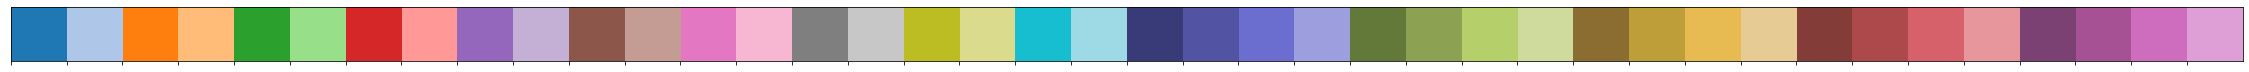

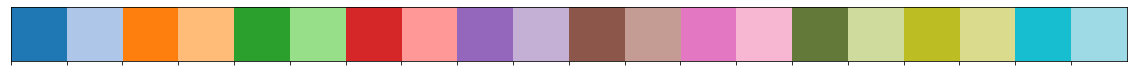

In [2]:
#plotting parameters, these will the same for all plots

x_labels=['Node (pos -> ant)', 'Node (pos -> ant)',
          'Node (pos -> ant)','Node (pos -> ant)',
          'Node (pos -> ant)', 'Node (pos -> ant)',
          'Node (inf -> sup)', 'Node (inf -> sup)',
          'Node (lh -> rh)', 'Node (lh -> rh)',
          'Node (pos -> ant)','Node (pos -> ant)',
          'Node (pos -> ant)', 'Node (pos -> ant)',
          'Node (pos -> ant)', 'Node (pos -> ant)',
          'Node (pos -> ant)', 'Node (pos -> ant)',
          'Node (pos -> ant)', 'Node (pos -> ant)'];

tracts=['AF', 'AF', 'ATR', 'ATR', 'CC', 'CC',
        'CS', 'CS', 'FcMi', 'FcMa','IFOF', 'IFOF',
        'ILF', 'ILF', 'MLF', 'MLF','SLF', 'SLF', 
        'UNC', 'UNC'];

tractPos = {'ATR': (0, 0), 'CS': (0, 1), 'CC': (0, 2), 'FcMi': (0, 4), 'FcMa': (0, 5),
            'IFOF': (1, 2), 'ILF':(1,0), 'MLF':(1,1), 'SLF':(1,3), 'UNC':(1,4), 'AF': (1, 5)};

tractPosHorz = {'ATR': (0, 0), 'CS': (0, 1), 'CC': (0, 2), 
            'ILF':(1,0), 'MLF':(1,1), 'SLF':(1,2),
            'IFOF': (2, 0),  'UNC':(2,1), 'AF': (2, 2), 
            'FcMi': (3, 0), 'FcMa': (3, 1),};

color_list_all=sns.color_palette("tab20")+sns.color_palette("tab20b") 
color_list_complete=color_list_all
color_list_chosen=color_list_all[0:14]
color_list_chosen.extend(color_list_all[24:25])
color_list_chosen.extend(color_list_all[27:28])
color_list_chosen.extend(color_list_all[16:20]) 
sns.palplot(color_list_all)
sns.palplot(color_list_chosen)
color_list_all=color_list_chosen
color_order=[19, 18, 1, 0, 5, 4, 3, 2, 7, 6, 9, 8, 11, 10, 15, 14, 13, 12, 17, 16]

tractsRh=['ARC_R', 'ATR_R', 'CGC_R', 'CST_R', 'IFO_R', 'ILF_R', 'MdLF_R', 'SLF_R', 'UNC_R']
tractNrRh=[0,2,4,6,10,12,14,16,18]
tractsLh=['ARC_L', 'ATR_L', 'CGC_L', 'CST_L', 'IFO_L', 'ILF_L', 'MdLF_L', 'SLF_L', 'UNC_L']
tractNrLh=[1,3,5,7,11,13,15,17,19]



In [3]:
#load all data from local folder

# load participant information from local folder
parts = pd.read_csv('./inputData/participants.csv', index_col=0)

#load QC data from local folder
QC = pd.read_csv('./inputData/QC_combined.csv', index_col=0)

#load session information from local folder
sessions = pd.read_csv('./inputData/sessions.csv')

sessions.rename(columns={"Unnamed: 0": "session_index"}, inplace=True)

#load tract profiles from local folder
tract_profiles = pd.read_csv("./inputData/tract_profiles_with_t1wt2w_nonorm.csv", index_col=0)


In [4]:
#perform quality control

#merge session and QC data, set QC treshhold

sessionsQC = pd.merge(QC, sessions, on=["session_id","participant_id"], how="inner")
sessionsQC.shape
#sessionsQC.head(20)
sessionsQC["qc_dmri_eddy_abs_motion"].mean()
sessionsQC["qc_dmri_eddy_abs_motion"].std()
motion_cutoff=sessionsQC["qc_dmri_eddy_abs_motion"].mean()+2*sessionsQC["qc_dmri_eddy_abs_motion"].std()
print(motion_cutoff)
sessionsQC["qc_dmri_eddy_percent_outlier_slices"].mean()
sessionsQC["qc_dmri_eddy_percent_outlier_slices"].std()
outlier_cutoff=sessionsQC["qc_dmri_eddy_percent_outlier_slices"].mean()+2*sessionsQC["qc_dmri_eddy_percent_outlier_slices"].std()
print(outlier_cutoff)

sessions_afterQC=sessionsQC[sessionsQC["qc_dmri_eddy_abs_motion"]<motion_cutoff]
sessions_afterQC=sessions_afterQC[sessions_afterQC["qc_dmri_eddy_percent_outlier_slices"]<outlier_cutoff]
sessions_afterQC.shape
sessionsAfterQC=sessions[sessions["session_id"].isin(sessions_afterQC["session_id"])]
sessionsAfterQC.shape
sessionsAfterQC=sessionsAfterQC[sessionsAfterQC['participant_id']!='CC00530XX11'];
sessionsAfterQC=sessionsAfterQC[sessionsAfterQC['participant_id']!='CC00129AN14'];
sessionsAfterQC=sessionsAfterQC[sessionsAfterQC['participant_id']!='CC00822XX14'];
sessionsAfterQC=sessionsAfterQC[sessionsAfterQC['participant_id']!='CC00766XX16'];
sessionsAfterQC=sessionsAfterQC[sessionsAfterQC['participant_id']!='CC00572CN12'];
sessionsAfterQC.shape

# load sl count for local storage and remove bundles with fever than 11 streamlines
subjects = pd.merge(parts, sessionsAfterQC, on="participant_id", how="inner")
subjects=subjects[subjects["session_id"].isin(tract_profiles["sessionID"])]

subjects.rename(columns={"participant_id": "subjectID"}, inplace=True)
subjects.rename(columns={"session_id": "sessionID"}, inplace=True)
os.makedirs('./outputData', exist_ok=True) 
subjects.to_csv("./outputData/subjects.csv")
#subjects.head()

allDataMerged=pd.merge(tract_profiles,subjects,on=['subjectID','sessionID'])
allDataMerged.head()
allDataMerged.shape

sl_count_all=pd.read_csv("./inputData/dHCP_sl_count.csv")
low_sl_count=sl_count_all[sl_count_all['n_streamlines_clean']<=10]['subject_id'].unique()
low_sl_count.shape

allDataCleaned=allDataMerged[~allDataMerged["subjectID"].isin(low_sl_count)]
allDataCleaned.shape

subjects.shape
subjectsCleaned=subjects[~subjects["subjectID"].isin(low_sl_count)]
subjectsCleaned.shape

tract_profilesCleaned=tract_profiles[~tract_profiles["subjectID"].isin(low_sl_count)]
#tract_profilesCleaned.shape

sessionsAfterQC.shape
sessionsCleaned=sessionsAfterQC[~sessionsAfterQC["participant_id"].isin(low_sl_count)]
sessionsCleaned.shape


(490, 45)

1.9578367346938785

0.9013503922044679

3.7605375191028143


4.484728061224486

1.7722473727436072

8.0292228067117


(450, 45)

(450, 8)

(445, 8)

,t1wt2w,tractID,nodeID,subjectID,sessionID,dti_fa,dti_md,dki_fa,dki_md,dki_mk,gender,birth_age,birth_weight,singleton,session_index,scan_age,scan_head_circumference,scan_number,radiology_score,sedation
0,1.140926,ARC_R,0,CC00549XX22,157600,0.164937,0.001084,0.174596,0.001122,0.181780,Female,42.0,3.685,Single,0,42.142857,33.5,1,2,0
1,0.908792,ARC_R,1,CC00549XX22,157600,0.176538,0.001116,0.186956,0.001153,0.172582,Female,42.0,3.685,Single,0,42.142857,33.5,1,2,0
2,0.830609,ARC_R,2,CC00549XX22,157600,0.189404,0.001148,0.200261,0.001186,0.169051,Female,42.0,3.685,Single,0,42.142857,33.5,1,2,0
3,0.817228,ARC_R,3,CC00549XX22,157600,0.201964,0.001173,0.211598,0.001211,0.166378,Female,42.0,3.685,Single,0,42.142857,33.5,1,2,0
4,0.831267,ARC_R,4,CC00549XX22,157600,0.213557,0.001181,0.222664,0.001218,0.161257,Female,42.0,3.685,Single,0,42.142857,33.5,1,2,0


(850000, 20)

(25,)

(804000, 20)

(425, 12)

(402, 12)

(445, 8)

(421, 8)

In [5]:
#identify longi subjects
subjectsCleaned.shape
subjectsCLeanedLongi=subjectsCleaned[subjectsCleaned.duplicated(subset="subjectID")]
subjectsCLeanedLongi.shape

subjectsCleaned["isLongi"]=subjectsCleaned["subjectID"].isin(subjectsCLeanedLongi["subjectID"])
subjectsCleaned["isLongi"]=subjectsCleaned["isLongi"].astype(int)
subjectsCleaned["timeAfterBirth"]=subjectsCleaned['scan_age']-subjectsCleaned['birth_age']

subjectsCLeanedNoLongi=subjectsCleaned[~subjectsCleaned.duplicated(subset="subjectID")]
subjectsCLeanedNoLongi.shape
subjectsCLeanedNoLongi["timeAfterBirth"].mean()
subjectsCLeanedNoLongi["timeAfterBirth"].min()
subjectsCLeanedNoLongi["timeAfterBirth"].max()

subjectsCLeanedNoLongi["birth_age"].min()
subjectsCLeanedNoLongi["birth_age"].max()
#subjectsCleaned["subjectID"].unique
#subjects.head()
#subjects['scan_age'].hist()
#subjects['birth_age'].hist()

subjectsCleaned["scan_age"].max()


(402, 12)

(34, 12)

(368, 14)

1.6013198757764187

-2.8421709430404007e-13

16.714285714285

24.571428571429

42.285714285714

44.71428571428601

(34,)

(34,)

(34,)

(300, 16)

(34, 16)

(34, 16)

(34, 16)

34.34033613445382

(34, 16)

40.92016806722692

(34, 16)

38.428571428571

40.9201680672269

(34, 16)

<AxesSubplot:>

31.96638655462191

(34, 16)

31.96638655462191

(34, 16)

40.07983193277305

(34, 16)

-2.8421709430404007e-13

16.714285714285

1.6000000000000179

<AxesSubplot:xlabel='timeAfterBirth', ylabel='Count'>

(850000, 20)

(804000, 20)

(804000, 24)

(600000, 24)

(68000, 24)

(68000, 24)

(68000, 24)

(20,)

(100,)

(4,)

['ARC_R' 'ARC_L' 'ATR_R' 'ATR_L' 'CGC_R' 'CGC_L' 'CST_R' 'CST_L' 'FA' 'FP'
 'IFO_R' 'IFO_L' 'ILF_R' 'ILF_L' 'MdLF_R' 'MdLF_L' 'SLF_R' 'SLF_L' 'UNC_R'
 'UNC_L']


,t1wt2w,tractID,nodeID,subjectID,sessionID,dti_fa,dti_md,dki_fa,dki_md,dki_mk,...,session_index,scan_age,scan_head_circumference,scan_number,radiology_score,sedation,isLongi,timeAfterBirth,matched,matched_groups
0,1.140926,ARC_R,0,CC00549XX22,157600,0.164937,0.001084,0.174596,0.001122,0.181780,...,0,42.142857,33.5,1,2,0,0,0.142857,0,0
1,0.908792,ARC_R,1,CC00549XX22,157600,0.176538,0.001116,0.186956,0.001153,0.172582,...,0,42.142857,33.5,1,2,0,0,0.142857,0,0
2,0.830609,ARC_R,2,CC00549XX22,157600,0.189404,0.001148,0.200261,0.001186,0.169051,...,0,42.142857,33.5,1,2,0,0,0.142857,0,0
3,0.817228,ARC_R,3,CC00549XX22,157600,0.201964,0.001173,0.211598,0.001211,0.166378,...,0,42.142857,33.5,1,2,0,0,0.142857,0,0
4,0.831267,ARC_R,4,CC00549XX22,157600,0.213557,0.001181,0.222664,0.001218,0.161257,...,0,42.142857,33.5,1,2,0,0,0.142857,0,0


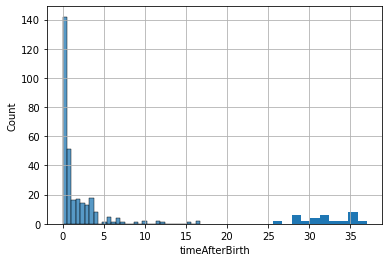

In [6]:
# assign matched labels to subjects table and all data table
#load the data that was matched sucessfully

matchedData=pd.read_csv('./inputData/matched_data_final.csv') #this table includes the single matches fro pymatch
#and Ariels nearest neighbor

subjectsCleaned["matched"]=0
#subjectsCleaned.head()
subjectsCleaned["matched"]=subjectsCleaned['subjectID'].isin(matchedData['subjectID']).astype(int)

subjectsCleaned["matched_groups"]=0
subjectsCleaned["matched_groups"][(subjectsCleaned["isLongi"]>0) & (subjectsCleaned['matched']>0) & (subjectsCleaned['scan_number']==1)]=1
subjectsCleaned["matched_groups"][subjectsCleaned["matched_groups"]==1].shape
subjectsCleaned["matched_groups"][(subjectsCleaned["isLongi"]>0) & (subjectsCleaned['matched']>0) & (subjectsCleaned['scan_number']==2)]=2
subjectsCleaned["matched_groups"][subjectsCleaned["matched_groups"]==2].shape
subjectsCleaned["matched_groups"][(subjectsCleaned["isLongi"]==0) & (subjectsCleaned['matched']>0)]=3
subjectsCleaned["matched_groups"][subjectsCleaned["matched_groups"]==3].shape
#subjectsCleaned.head()

subjectsCleaned[subjectsCleaned['matched_groups']==0].shape
subjectsCleaned[subjectsCleaned['matched_groups']==1].shape
subjectsCleaned[subjectsCleaned['matched_groups']==2].shape
subjectsCleaned[subjectsCleaned['matched_groups']==3].shape

subjectsCleanedMatched=subjectsCleaned[subjectsCleaned['matched_groups']>0]
age0=subjectsCleaned[subjectsCleaned['matched_groups']==1]
age0['scan_age'].mean()
age0.shape
age1=subjectsCleaned[subjectsCleaned['matched_groups']==2]
age1['scan_age'].mean()
age1.shape
age1['scan_age'].min()

age2=subjectsCleaned[subjectsCleaned['matched_groups']==3]
age2['scan_age'].mean()
age2.shape
age0['birth_age'].hist()

age3=subjectsCleaned[subjectsCleaned['matched_groups']==1]
age3['birth_age'].mean()
age3.shape
age4=subjectsCleaned[subjectsCleaned['matched_groups']==2]
age4['birth_age'].mean()
age4.shape
age5=subjectsCleaned[subjectsCleaned['matched_groups']==3]
age5['birth_age'].mean()
age5.shape

subjectsCleanedNonMatched=subjectsCleaned[subjectsCleaned['matched_groups']==0]
subjectsCleanedNonMatched['timeAfterBirth'].min()
subjectsCleanedNonMatched['timeAfterBirth'].max()
subjectsCleanedNonMatched['timeAfterBirth'].mean()
sns.histplot(subjectsCleanedNonMatched['timeAfterBirth'])


allDataMergedCleaned=pd.merge(tract_profilesCleaned,subjectsCleaned,on=['subjectID','sessionID'])
#allDataMergedCleaned.head(20)
allDataMerged.shape
allDataCleaned.shape
allDataMergedCleaned.shape

allDataMergedCleaned[allDataMergedCleaned['matched_groups']==0].shape
allDataMergedCleaned[allDataMergedCleaned['matched_groups']==1].shape
allDataMergedCleaned[allDataMergedCleaned['matched_groups']==2].shape
allDataMergedCleaned[allDataMergedCleaned['matched_groups']==3].shape

tractCount=allDataMergedCleaned['tractID'].unique()
tractCount.shape
nodeCount=allDataMergedCleaned['nodeID'].unique()
nodeCount.shape
groupCount=allDataMergedCleaned['matched_groups'].unique()
groupCount.shape

print(tractCount)
allDataMergedCleaned.head()
allDataMergedCleaned['dti_md_x100']=allDataMergedCleaned['dti_md']*100


<bound method Figure.tight_layout of <Figure size 1080x1656 with 12 Axes>>

(0.0, 1.0, 0.0, 1.0)

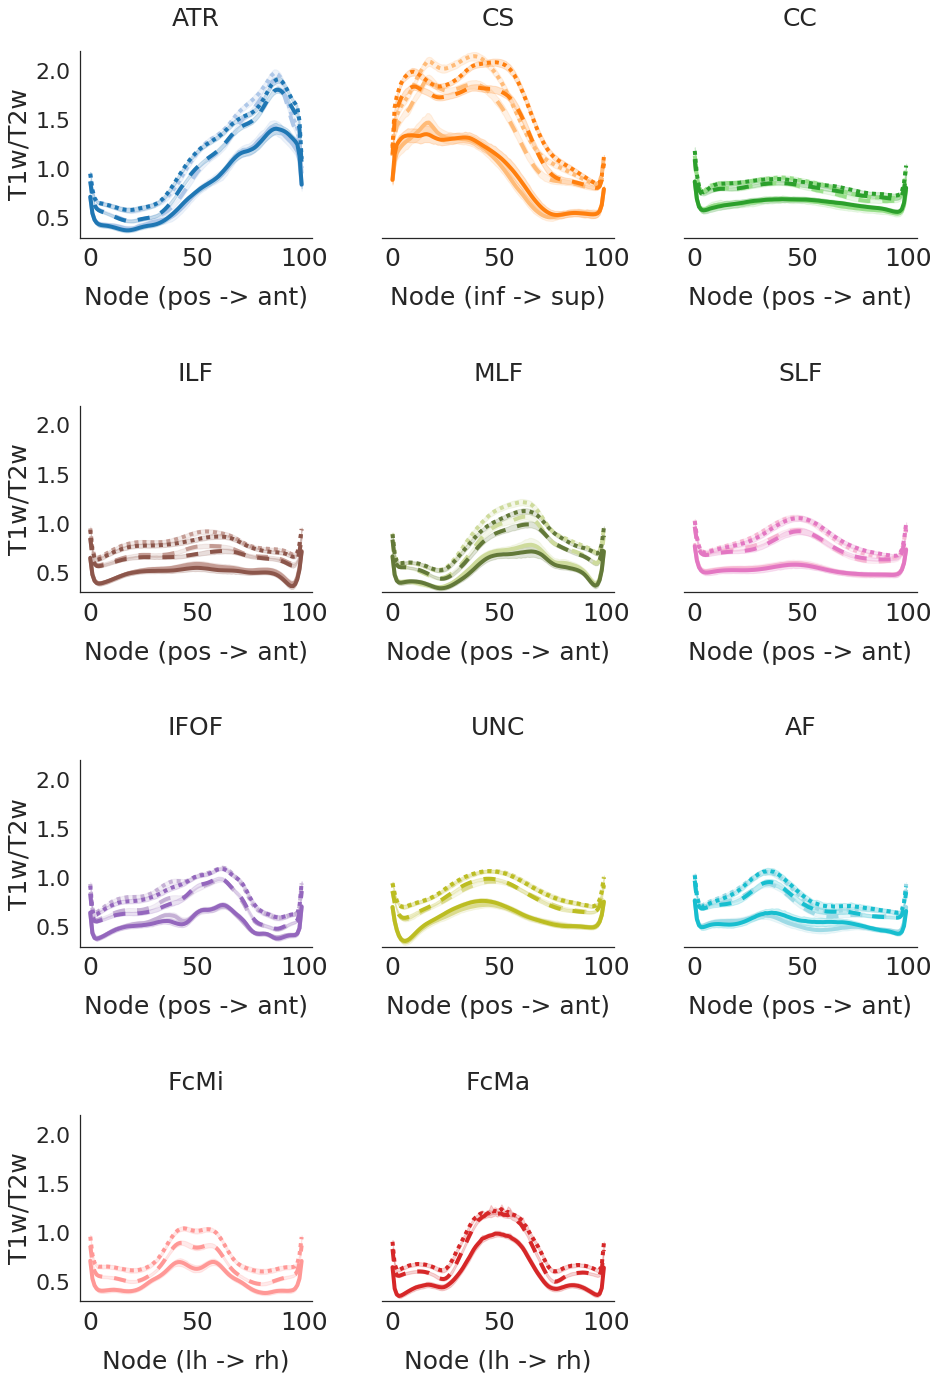

In [31]:
# this generates fig 1 in the main manuscript
#now we are looking at the non-longi sample
#here we create a simple plot of dev over time
allDataCleanedNoLongi=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==0]
allDataCleanedNoLongiIU=allDataCleanedNoLongi[allDataCleanedNoLongi["timeAfterBirth"]<=4]
allDataCleanedNoLongiIU['ageBin']=0
allDataCleanedNoLongiIU['ageBin'][(allDataCleanedNoLongiIU['scan_age']>=33) & (allDataCleanedNoLongiIU['scan_age']<37)]=33
allDataCleanedNoLongiIU['ageBin'][(allDataCleanedNoLongiIU['scan_age']>=37) & (allDataCleanedNoLongiIU['scan_age']<41)]=37
allDataCleanedNoLongiIU['ageBin'][(allDataCleanedNoLongiIU['scan_age']>=41) & (allDataCleanedNoLongiIU['scan_age']<45)]=41
#V7q06ZHPUYLLo0woXQAAk7KNqnOp3WMTTj/UYk6TvlSJ9rb1zOsibAaO7kzQjA3LpHYxrI8VushLTm27UhEEAOlY5AtbS2V917jZmHijIjuZqUtxh0PHvvOtbezLHnUl7WVi6IoirKvUCGqKA8QxhjK9QTXtrlyt8bcSsjcSkg+Y3P2cJ6ZMUmtbEVDh3W9zWYcjkzItiemc+QzImAbYUKSmHVTe5UDTtyEsAJeEW5/WV4DzL4Ii5fgtT/UTpuN6vLz6InB/UC3ipeXR/GQiOAklv23hG5uHDA7K0CTSB5OZu+ErZORNjZLVzeOcIa1du2rm4P6AuQnhk9hVhRFUZRdRoWoojxA1JoxcZLgOTY3FhodyxPCqF0bOmw0tIVtWYwXXbKe3ZWKayGiNqtC9P6lsYJ80kZMiTqZeaotfFoCceLkzorQTixbxFnvr65lpXPcBsZIi5dmBZorqTutkVTfwpScp0nTgHfr/EDOsTgjabq9QtQYEf+3vgT1RXjND8q8bAeiROadG9+9uSmKoijKJlAhqigPCIkxlGsxnmMzXw5XhSeAY8Ph8XY0tJQbPhraIp9xqDZ62kRY0oO0sz2Mch9hEkl7dXMigmaegtvPieCxHDj8dDrOSIRu9MTBq1M0iRgrVe5KFLIldlt9PZMIyrc6NrAk8pif2L0aVC8vx++sFzUGXvgFqNxpj5sLxLkYZFx1TgyODmJqsqIoinLfoUJUUR4Qao0YYwy2bTM14vG6syNcn29wd6nJkfEsrmORpI65+ezm0/dcx8KxLeI4oRkbFisRi5WQyZLHYydKO306yn4grIGJwE5TQI++Xtq0LF6WiJxXSMdVJWqYPWC/ByaB8m2oL4mQywyYv+12L2+J89qC1KjuVjps8ZD0EXWy7TrQ0tFuIXrryzD9uKyzXTFrCquDz0NRFEVR9hgVooryABDFCSu1GM9tt2sZK3qMFT0aR9pRzDBKGMm7m46GtvZZzNq8eL3Clbv11eWJgTgxW9qnss+pLUhqaieW3e3emsSyrNe0aL/TEqGNZRFuw/bDtWwxEjKJRCDjBowcG377YXGz8p7WF9vGRUdek6ZHm/aYuNGOmjpZmZMKUUVRFGUfoEJUUe5zjDEsVyNsW2o5e2mlzSbGYFvWlqKhq/vKOJR6tl+pRkSxCtH7jsYKNMv9KaK9RFVxqz1IJjnGSCpufWlzIrQTy5YIcGMFMku7U5tZmBKhnEQS8cyOwuTD8l4ffk1/e5zVVi7h7taxKoqiKMoQaKGIotzn1JoxzUgMiuZWmlybrZMkpm9cFBsKOWegWB0Wx7aYHs102cLUw4TlarjlfSr7kKgOKzck9Taswh/9DLz6UajOdo+Lm+DkDlZKrjFQvSsus1sVoZ14BSjfEfG309iO9ESNajJvgIfeDefetX6P1rC283NRFEVRlE2iEVFFuY+JE7OakpsYw6s3q9SaCdfm6zx0uMD0qIdlWatOuTlv+1GrsaLLSEEE7VjBZbTgkiQSmbV2Oj1R2XuSCJauSXTNdqRlSxLC/CvyOPQknH2HjI0a0i/0IJnjVOekL+pOiFCQ98iyRbiPHN15s6bsCDRG2lHpjebseKl77ujOzkNRFEVRNskBujpQFGWzVBsxICm5N+Yb1JpSD1pvJnz1ann1dZQYcp6F62z/wtt1bN7w0ChPnipx9nCBqZEMBkOcbLytcgBoLEv9o5MR8XP7ue71rVrQVi/PVi/Lg0BtHmqzOydCW3h5EfALl9J2NztMYUr234tJYOECvPKb7Yis7Ul6bhLv/DwURVEUZRNoRFRR7lOi2FCpx2RciXhem613rT86kaWQ1nMmCRSKO/d1UMp5zC43MbZEQS3EMMl1DlCdoNKPSSRa2KoHbVakLrE2J6/dfLtdSFSX9NCDEA01idSDlm9vLEKjBlz4uAhyAK8IuTGYelRca9fa1s2JWFy+BoVDIh53Suy6OZlH1BCDIhDH3FtfkjpeSKPVT6THNPL5tEyOFEVRFOUeoEJUUe5TyrUo7eogF7uvf2iUS3dq3Jhv4NhwZkYiVS1HW28HoqEtXMcil7EJowTXsbBsi3ozJpdRIXqgaZTBxG3jocIUPPUBWLwEN74gbrmO165XzI7cs6kOTbMiLU/iRipCNxDOjgdLV0S8gkRRl6/CneehMA3H3gQT5waLzFarl9qspDOXDu+cUC9MSduclhANK20RChK57mzl0iyrEFUURVHuKSpEFeU+pN6MqYUJWbd9MZxxbR49VuT4ZJZKI1l1y43jhJGCu+P1m1GccHOhQbkes1iJODeTZ6zoaZ3oQcUYiXw62e7lliUCdPwMq21DorpESu19/i+mvgzlG2KolBlSNFu2nFt9sX9ddRZe/TCMnYLT3yCR0kHbZ0agsdRuwbITeHkRlnFT0qZnnoKbz3bM7a58foVpWd9YPjgRa0VRFOW+RP8DKcp9RpJIuxbPsQaKvmLOZWZMDFMSY8CydsSkqJers3XO36pxe7FJI0xYqkXEA9x6lQNCVE9FjidRwN4aQ8tqixoTDxZh+4lmRQyE3MLmW5lkNzD6WboCz/8c3H2hHR3uxStC+a68rztFflI+o9Ycx8/IzYBDT8CT3yciFORzMolEuBVFURTlHrHPb1crirIZjDGs1CMM0kpldrnJYiXizEx+oBFRFBuKOQd7F3p8To9kuHSnfZG9UovSVF29/3UgaVbAcqT1x0u/KnWJZ94hTrCdJJEY4qzVV/Re06oHrdyWKOJW+pue+Fo4/mYRdI0lmA1g8WL3mCSCi78lovTsO/vFrmWDm4Hl6xJB3Ym+nl5ehGerr+jpr5cItpvtH+tk5YZCdmRnjZkURVEUZUhUiCrKfUSlEVNrJGRciziRdi31MOHOUoNzhwscHs+sRklNGqnJ71Ld5uRId5uKaiOm1ozJZ/Vr50DSWBaBeeHj0js0rMKLvwQzT4vgaYmZqJ7WPu4zcWOM9Nuszsrc3cLWRChAcabj50Mw+bC0fbn8OxJl7SSqr53+2nIeXroCoycGC8bNYNlSK9oyXVovcut4Uica1Q+Ws7GiKIpy36BXhIpyn1BtRJRrERnXxrIsLt4SEQrQjAwvXa8wWnBXnXKjxJDL2Di7EA0FKGRtjkxkyDg2EyWPkZxDGEk6sL3fRIqyPnFTzHXKV2HhfPc6N9sWncYAloig/URYhZVbcg62N3w96GYoTMFj3yXpuFc+LVHJ/CQ8/N71Ba+bk/d36Yqk0m43MpoZAe5I5LdXABsjtaItIW27UF9QIaooiqLcEzRHTlHuA2qNiOVKhJeK0MQYas3uGr7jU+12LcYYkgRKud27F2VZFq8/N8aJqRwTJQ/XtTFIOrBywAirgAVjpyUC2qJwSFxiW8QNSfXcrklR3ITagqTQDuqPuRnqS7B4NTUJKvVHHY2Bq78PKze3dxwQQT7zpNRjjp2GR799uCink2YPDDJA2iy2A/nx7trTxjJc+wP48n+Br/739nGcrPQ13e57rCiKoihbQIWoohxwao2IpUqE59mrkUbbsnjqVInTh6ROL+vanJ1pRz2aUUIp7+xaNLSF61h0yk7LgmYapVUOEI0VidQ5Hpz5BhFY2TF46N3d0b4khNz41o+TxFIzuXBRWqqUb8H8BYlmtkx4ht5XJPtYuSkRv0GRxrgJ5z8q7rIvf0hSWneC/AT437659jVuTsT3TojC3LhERFtGSRc+ATc+D80VeT37kjy3ItlhbfvHVBRFUZRNoqm5inKAaUYJS9VuEdrCsizOHi5QyrtkXXvVJChOJDW2FR3dTRzbwrEtksRgp8+1ZkJJMwEPDkksQsUrtJeNn4ax7+9O/YxDaYOyVZOiuAnLN2Q/nam9xkgtY31JnHiL0+tHXE0iEb/KLKtpwoNSwcu3pd61FR2MmxB8EB77Tqn73Gta72VjefstXZyMiOCwJp/H9GPdtauzQWq2ZEmqcmP5YPR8VRRFUe4rVIgqygGmXI+wbWtVhM6vhEyUunuCHhrtNg2K4oSxgrtndZqzyw1mV0LKtZh6mPD6cyNEsTfQxVfZh0R1ESqdQhT66w/jOowcH96kKA5FYDaWRQSaRARmpvc4lkQ0jZGxzRUoHu52e00iEcxJCOU78uwVBpsEhVVJxW1FBXuPdS/rl92cmB5lx7ZupNQiPwn1S7LPyYfh8u/K+2Q5UiMaN2SdkxFH5CTe/jEVRVEUZROoEFWUA0oYJTTCZLUH6N2lJl+9Wmai6PLYiRJZr/8iPE4Mjm2T2yWn3EHcWpQWMi3K9ZgwinEd/fo5ENSX4NWPSK3j0TfA1CP9Aq/VsiVTHG6fYQ2WrsrPbhbc/MYC0LJk/0kE5ZvSeqQwmYrZjn6YjjfYLMkYmHtZBFnc6F9fmIaHv2V7qcXbxXYgSgV3fmJ7+3Jz8n7FTRGbx94o4nzioe66VcsCjNxwGPbzUxRFUZQdQK8EFeWAUq5HqzWetWZMcL0CwEIl4vOvLvHEyRKTpe66uCg2TJS8rojpbjNR8rqE6HI1otJIyGXMns5D2QLGwOyLEFbkceHjcPOL8NQHusXoasuWIWwH4hCWr4k4WsshNqymwmikf4ztitCMm1L/aXtp9HOd36X6kgjQpcuD108/LrWvw5gsmSQ1b+rAckT47cTvs5uTFjM7YfqUn2y/18feuPY4yxFBr0JUURRF2UNUiCrKAaQVDc2m0dBXb1aJkrYtUJwYvJ7U1yg2eK5Fxt1b8XdkPMvF22KG4tgWtm0RxWZ1Pso+Jm5IW5FOSke7BWezKu6rw7REMYnUKlp2v8AMa3DrS2JUVF+QZbYnEdiZp7p7d0IqZLvTzgcy94qY9Zi4f11+Ek69HcZOrr19EsnDyaQitCbR02wqkqOGCN36oqQQb1c8tqKitUWph90OXl7e60GtXDpxU/fc4qHhbiYoiqIoyg6gQlRRDhjGGJaqEY7dvmB89FiRF6+VVyOP5w7nGcl3/3nHScJYMbPnUchDYxmOT2aZHPGYKHrYtkUYJVSbMWOuXvTua8Jqf0uRiXPy3DIRyo5A6chw9YWNsgi5QcY49QVxr+0kCaUv590X4NATcOItm+95WZgGeloGWQ6ceDMcee36wqvlJpsptR1nx052Rw69vDwyJUkZjuoiRp3McKKuWRan4Gm/e5+1eTFn2k5fUcuWfdSXu9+3ZgXmX5G5nvjaVKzGIqq1p6iiKIqyR6gQVZQDRrURE8XtaChA1rN5zZkRLt2pUanHnJjqdi4NIxmfuQfCz7EtHj1eIIzATlOJXcei3kwo5cyut5BRtkFjBR77LqlZXLosdZ2jx2Vdq2foyNHho2iNpbX7ao4cE1Od+VcHr7/7Asyfh9NfD1OPDp8Gm5+Q3qe3v9w+zpl3rF+DGTdFlGVKknLseGBmRHyvJbizJfDOpuZOqQkTtKOSg5h/FS7+thwvNy7HAhlvWZKiO3J0uPNci+yotIUBEdbnPybpuhgR5EdeJ5+J5YjYViGqKIqi7BEajlCUA0QUG8r1GM+1ieLufpytdi1Pnip1RT2NMSSGvgjpdudRbUTUmjHNaOO+oJ5jk5h2VKo1v3pzQLqksj+IQxFjjgeFKTj6enjsOyTaZ4ysL0wPL0LjUCKs66XTnnyrCCIsSfft20dD6lRf+Q2pDx2W42+C3AScfacI6/VEaLMsYnPspIjuVkTSsjeO+rbqV0eOwOQ5Sf1tVtr9PDu58ntiAhU3ACMCMQ7b6928CPfGyvDnOQgnK/NKYqk/rS+yGiE2MSxcSI+XlRRjo31+FUVRlL1BhaiiHBCMMSxXQywL4tjw+VeXOX+rium5yO0Voc0ooZRzdqRdijEiQOdWmixXY5YqEfMrTVZqUd88OnEdG4PBGEOlHnPlbo04MVQbetG7b4nq9KW0dq7Lja8d3RxEswxs8DuYHQX//fD6Pwuv/zPwyLeKgOxl8RJc++zwx3Zz8PSfhEOPrx9JbVZlDqNp+u120thtV2o8C1Ni9NRLK7LcorEEV3+v/dqyRIyWb0uN6laxLPmsorr8PPVo9/q5l9NxdrsGVlEURVH2ABWiinJAqDVjGlGCa1sE1ys0woSrs3W+cnmFcEBUMk4MjSghn3EoZHemXUu5FrFcjXEdi6xnk/VsMq5NpR51OeP24tgWN+cb/MHLS3z+1SUu3K6xUA6Jk4Q4WVvAKveQxjJU7kokrRNjJJJWmBx+X8ZIeugwwnX0eJoqaks96lMfkNpQq+d3ePrx4Y8PG4vKuCkRz+LMzvYSLUyJq2+v0+74GTFh6uTO82nabIrtijiszG5vDpkSqzcVWkK0cEgi0Ge/qft4jaXtHUtRFEVRhkSFqKIcAKLYsFyNybg21+cbzK60U/gWyhHX57v7IsaJIU4MUyMZxlKDoO1SbUSU6wkZ18LuuFC3LIus59AI44GCGMCxIU6gHrbX315sYsGa2yj3mLlXJQX2S/8JXvlwO4UzqkmUchjH2hZxQ4yHtuIoaztw7A0iSItpDaXtweRDm9/XWkR1iTqOHh/OdGkzWLbUedqeRFw7Ofl1kB3rXnbpU90RUK8g6bTbiVS6WYkKx00Rxs/8ADz1fZJu3Wkc5aTuub03HxRFURRlF1AhqigHgJVahG2BbVkUMk5Xa5aRvMOp6bY5kTGGME4YL3o7Zk7UjBKWqxEZz1rTddeyLGpr1HxalsXh8W7hslSNqIVJlzhV9hGtnptxExbOi7OrMRKhy49vbl+N5f6I5mbJT8ATfxwefR+c+rrNCeFBxE0Rd40VqQMdP7O5VOPNYLtSc+rlpGa0hePBuXd1j60vwo0vtl9blsyrfHt79Zu5CTlnkFTdQbT+tiNNz1UURVF2HxWiirLPaUYJjVAMigAmRzze+PAY40UXx7Z44mSpK+IpNaEuWW9n/ryTxLBYDnEduysS2ovnWFQbCckaqbYTRY/Rgrt6Dk+dKjGSc2iEybr1pco9oNXvs5OxkxI5zI5tTgQmsZjgDCvyTCKmPXGzPzJnWYNTWjdDq+1Mq7XJ6HEYPbG9NinDYDtyLC+X1t+mjByFQ092j735xbbTLcj7HdXlfdwqmSJgDTZOar3fIKK5OaCmVVEURVF2GG3foij7GGMM5Vp3z1Bot2upNmLymXakKYwTPNemlNu59MKVWoSBvjYrtWbMSi0mn7EZybtppDShHsYUsv1fLZ5rc2YmRyHjkOuYM0lCGBsyrrZx2Te0zIiieurqakHpqIiV9RxnB+6rJoJyGHfduCkPNy/CLaxBlLq9biWttxeTiHFQdhxKM8M7/u4Uli09VxcuyXvSSgM++VZYvNiuIzUJXP19ePTb2tt6BanZzY5sPcU5Oyoi3MtL+u/iZWkhs3gRjn+NpOraXmosdXi7Z6soiqIo67Lp/2a+79tBEGgunaLsAc3I0IwM1UaM51qUcu0/WcuyKHa8TowhSWCy5K2ZPrtZ6s2YajMhm4rExBiuz9W5Pt+g3mx/DRwZz/Dw0SKuY1OpJ+Qzpm8OnmNRzLoDBWczSu5Jj1NlLSw4+w7wilCbg+qcLM6Nbj59tTILL/4yjJ+G6cekzrP399MYEWG2250iaxLpyVm9K6LYK2xNPHa6wRYOSVuVnTQk2gxORkTwyq12faabhVNvkxYuLRYvinHR6Al5bTtpb9G5dr/RzZIba5sR3fkqXPl0e938q6kQTW8AxOHuR4kVRVGUB5qtXPnd9X3/Z3zf/27f9ws7PiNFUQCJhq7UxLTkxWtlvvjqMhduV9d0mQ0jw2hhZ9q0tI8f4zlSF1qpx3zpwjLnb9W6RCjArcUmXzi/RCNM1nTCtW2LjGvR0/4UC/r2p9xjkgiwRPgUpmHaF7Oh7Ojm9hOHMPsiNFfEEfaFX4SXfqV7TFiTVNDsKIyf6ha6li3id/wM5KdkXGevzWHn0KyK+Jw8J2Y990qEtsiOiZNtZ4ru5CMSLe3k9le6X7t5qC90b7cZ3KzU6pqk3+ypcqed+muRRsIVRVEUZffYihCdAP4U8AvArO/7H/R9/8/4vn9oZ6emKA82zcgQxYbLd2s0I4MBrtyt88Xzy311mNKmxe5K092J48eJwbEtVmoRz15YYqW2tptmvZnwwtVyuu1gYZnL2CRGIrxXZ+t8+eIyn3t5kWaobVz2FVFjcOTRzfUvW4/6Esyf715WSP9VJJGYGHl5mDgDI0fWTjm1HenJOX5aBHFYXd+4Jw5FtDbL0mpm/JRsvxPpvTuBZUlUNIna52FZEhUFca899TZ46D3929kZEY1bqau2bInCRg0RwiPH2usyJfk8QOtEFUVRlD1hK/+VXwO8D/g24Gs7fv73vu9/DvhV4NeCIHh1pyapKA8axhjK9YhqI+ZGT2uW6ZHudixhJC1VRgrujqXkAlQaEY4tdadfvVLui2T2MlZwOTmdw7Ys6s2EwoAMzozrYIh47vIKtY4o6GI1ZGo001eHqtwDGitw7bOSQuseFfESh5uv04zqsHSl3/To0OMiwKKGpJ1mSsNHKL28REdr8xJlXTUzsmSetiM1pk4Giofk2c3tfEuWncDJSJS3Npf2+UQioufeBWOn5VwH4aYtVuLG5m8MgByrvig/H3pSbgxMPizHbn0Otifvr9nhnqqKoiiK0sGmhWgQBM8BzwH/2Pf9SeC9wLcD7wa+Ln38U9/3X0JE6a8GQfD5HZuxojwANCNDGBnGCi6PHC2sRkXzGZvTM+0L1DBOsG2L8YK3rqPtZoliQzNM8ByLF65V+lqsTI96PHqsiGNbXLhV5fB4dtUR1xipa00S09e/1LHBsWwmS15X79PFckQjSnbM6VfZBvOviFEOSGRu5ik4/IxEFIfFJLByU4QoHZG7wrQ8mmWpc+zsYTksjifbmhmJjiaxPEcNeeSnIFvaeyOirZCfkJrNznrM6cc23s7xRIx3RjSHxc2x6p477cujF9sRk6gk3H6bHEVRFEVZg23lKQVBMA/8v8D/6/u+g4jQ9yHC9HHgMeB/2e5xFOVBwhhDpR7h2Ba2bXF8KseRiSzX5+qM5N3VqGFiDMbAeMntE3zbpd6MsS2Lcj1hdrm7Ju/YZJZHjhZWo6+PHCt2rbcsCwtDGBuyPfOyLItcxmas6HYJ0XqY0GgmsEYQSNlDFq+0f44baUTMiFHQMJhE3F3jUAxwOpl+LHXQdSCzBRHaiWWJSHIA8rBLLUB3FduR9i2LlyXaPOzNJCeNiha2YChkO/JZbigyLRH2KkQVRVGUXWInbxlPAkeAUeTSwCCWB5rXoyiboOWU22k65NgWpw7lmSi1LzrDyDCad3CdnY38xImh0ohxHIvRgssbHhpdbQdTyjk8fKSwcQqwBY1wjTpRT9rLTI14PHykwNc8Msbrzo0SJ0brRPcD1dnu14VpEY7DCJK4CUvXJPUzrEra6SoWTD0q7VwKU/szXfZe4BUkihtVh9/GSv+1brWvaHa03/TJGCjfgltflte2264ZVRRFUZRdYMuRSt/3x4FvAL4pfTyRrmpdoV4BPgl8Yhvzax3rh4CfAt4eBMFnhtzGBcqsfZ/8ehAEJ7Y7N0XZSYwxLFelNjRODIXs4Iv1ZprGmttBc6IW1YbU3bVSfUfyIkavzzeY6qlPXQvXsWiECcYMaOPi2hSyLo+dKOJ1iWgxZ9I60XvM6HERkc2y1Al6RcgUN051jUNYuio/Z0ptQdNi7KSkhUb1zbvv3u8UpuT93kzLFC8v6bm5sc1HRb08YNqGR1c+LaZSYWpQNPmQfO7NSne/U0VRFEXZQbbSR/SfIsLzNUhEtXXVuAD8NiI8P7FTZkW+778F+MktbPoEIkLPA58bsH5+O/NSlN2g3owJk5iXb1SoNxOOTGQ5PZMn11E7GcYJrmMxtsPmRCC1oZV63Nfr07IsTkwNb4xiWxahiYkTcAdcw5ZyDnMrMcZuC1XbsmiEsdaJ3mtOvx0mHhLxmcQiTjaq5TQJlG+KsPHy8nru5e4xU760aslPqrDppZWiu7SJFF3Llkf5ppg+baYm1vHkM21W5fMq326LUICFC1IXjJEbB5nimrtSFEVRlK2ylYjoX6ftPvFp4FeAzwDPBkGwo3l1vu9/N/DTQGkLm78uff6pIAj+4Y5NSlF2iSTt2zm3FK06yt5caHBnqcHX+uN4jk0UJ1hYjBeHi0xulko9wrIYWuCGUUJiDJ5jD5iPRRjFuE7/14znSquZRpjguZa0dGnGGAOj2p343tKZsmk7InA2cmet3IWwQ7AsXe0WNrYH42chaUpfUKUfLw+5SUlrHlb4eXmJWlZmpR3MZshPQX1Fbh5MPgSV2+118+dFiFqORGpViCqKoii7wFaEaBVoXSq+HRgHTgEzvu//bhAE224+5vv+CeAfIf1Kq8Bt4PAmd9MSol/c7nwUZS9ohAlhnHB5tta1fGYsi+fYJIkhTmB61N2V9NVmlFBrxmTcjSMrcSJptFnPIus5lGsxUWK6tnUsSc/Nr5EcX8g6XLhdZakSsVyLiBN48mSJQ+OZHXUAVjZJ3GxHLIdp29JYgfoCeB33C2/2fO1OnEMMj4pqfrMeham0LU00fKscryDvf250c+1c3GzbtXfinDgl2570ap14qD2msSKtcA6CC7GiKIpyoNiKEJ0A3oq0a/lm4PXAM8CPAZHv+3+I1IZ+EvhsEATRFo7xDxAR+gXgTyOpuVsVos9u4fiKsudUGzGeY/PI0SIXb1epNRNsC87M5KUlSmwYL7o7bk4E7dpUx7bXjYYmiSGMExzbZrzokvVkfM5zmFsJiZN2jadjQyMyA+tEQepIy/WYhUr7K2KlHpEkmrl5z1i8BHOvSgSsMC2puaV1vnrjUAxu3Hx3OumZd8D1P2i75s48JS6t6+1LkV/80hFYvjq8q7BlSeSysbL5vqL5CYnAZsfA/w5JD+4UwJYNJhb33LX6miqKoijKFtlKH9EQ+J308bd8358A3kVbmLZ6if5toOr7/qeDIPjWTR7mJeAHgZ8NgiDx/QF9ztbB930LeC1wC3i/7/s/grSTqSM1rH83CIJgk3NSlF0jjBPCKCHrOcyMZZge9bg53yAxhqxn04wSCllJZ90Nas2YKJbjr0ViRISOFlzyGadLXNq2RSlns1SNcFIVaVkWJm3j0ltz2lo/WfK62sOsVCMS0zLcVvacW38E1/6g/frYm2Di7OCxxkDlDmD1R+/yE/Dwt0jt4eIlKKY9P1XMbIxXkOhyVB8sLOtL4kY8ca69zM2KoCxMbaFWtCRp1WMnB4+xbEnP1c9OURRF2WG23d8zCIIF4BfSB77vnwP+GvDngCLwni3s8ye2Oa1zSBuZUeA/AL+HGCm9DvgA8G2+7783CILf2+ZxFGVHqDWSbmFnSf9QIBVmMJLbnXa8cWJYqcZ466TkGmNohoaxokshO3ge2YyDXYtJjFlNrbWQOtK10n1nxjK8fEPaVniOhedYq0aeyj2gOtf9Oje6diptWJU00vUid6XD8mhWoDit6Z3DYFmSCrt4ScR+63uhtgA3viAmUI4Hr/lBEaCQRi4TMYPabD2nV5Jo6loG825ORK6aTCmKoig7zI5c2fq+fxSJiL4biY5O0w5pnN+JY2ySVlrudeB9QRD8Eay2dPkJ4H8Cft73/YeDIKjfg/kpyipJYijXI5KeGssWUZQwknd3xZwI2gZF69VlNmNDMWevKUJBti/knFXXXWMMtUaMbUNxDRE9XvR46EieqZEM+YxNMzLEScLOtjhWhqZXiI4cG+zgaoz0G3XW6o7Vt8HwqaZKu36ztth2L37pV0T8g9Tx3v4KHH9Texvb25zRUQuvJ+paXxTX3IWLcPT1EhE3idxMUKMpRVEUZQfZkhD1fT8LfD0S7Xw38GS6ygISpF3KB4EPBkHw4g7Mc7P8EmKgFAdBcKO1MAiCyPf9vwF8I/AG4DuB/3YP5qcoqzTCmJvzDa7M1pkZy3DqUI5SKtySROorc2v0E90uYZxQacRk14mGJonBBkr5jb8u8hmHy3dqLFYiFsohYWx46lSJqVJmoJB2HYujEzlsW1J1bcsQJds5I2XLGANHXguLFyVC1liC0rHBY8MqRLXhxGXclHTTzfa6fNDJjUsUFCQSefgZuNbRiez2l+Xzar2vTmbzvUhBBKztiNi88QW4/oftdQsXRIg6mbYhkqIoiqLsEFvpI/oRxC23dRvVQpxtP46Iz18PguDujs1wC6RtZK6usS7xff83ESH6BlSIKveYlXrMzYUGAHeWmtxZavL4iSKHx7OrNZm74SJrjKFci3Bsi6tzdbKuzcxYps9YaDNzcGyLxUrInaV23edyLSKMDdkBQtSyLLKeRb2ZYLsWlmURx6pE7wmWBQ+9C+ZegUyarjmoLnCz0dC4KammyuZwMpIW2xKWh5+Bm1+CWL4riOpw9wU48hp5bVmAJenS+cnhj2NZckOhWRajpE4WL4lAbYncqNFOB1YURVGUbbKViOi70+dbwK8j4vMTByzF9Vb6rB0LlXtKFCdcn6sTxu3CSMeGyZKXOtDunkFRMzLUQ0MUJ1y8VcMAl+/WOTOT49CoCNKtzGF6NNMtRKsRjTAh6w2OumY9h2ojlhTlWsRKPWaipC0+7gmdBbrWABMiEAE0bDTUJIAlrrrK5smNi+GT44kYPPy0RC1b3PqSOBK3ajfdHFTnxQV3M/WcmaKk5I4cl+PETVke1eSmQ3EmdeZdAneT/UoVRVEUZQ22IkT/EZJy+4cbjrxH+L7/o0jq8P8dBMEnBgxp2UBe27tZKUo/9WZC3nMoZh0qjRiAY5M5PNemESaMF91126lslSSRdi2uDV+9UqElP6qNmPO3akyPZLAsEcpjhc3N4ch4lheuttsJL1cjas2YkbwzcD+ODS9crbBSi0jSiTxxsrgrbWqUDTCJCFBjxABnkJhpLIM15L+OqAHZUTW52Sqtes+WadHh14izcZK2PGqWYS6AQ0/Ia9uBKN58PWcrum07MH4Wwoo8T5yVzw9SZ95lKBwaXDesKIqiKJtkK+1b/vfdmMgOcw74XqCJtGtZxff9HPA96cuP7fG8FGUVYwzVRsyh8Qwz4xnmVkKuztY5OZ0jig2ea60ZRdwulbq4295ZarJSi7vWPXykgG1b4nbr2eQ2GZEdLbhkXItmJKoyMbBcDZkayeAO2JXr2NSb8aoIBRHEowUVonvK7a9ITWIcSiptZoCQSWJpHzJsK48kgtzYzs7zQcJ22+1V3Ky874eekM+qxc1nYfrxtjh0cxLFzI4MLxgdT2pFkxjOvWvwdq2eonFj8/1KFUVRFGUAQwlR3/e/GfifgTel2zwP/AzwH4MgiNbZ7tPAW4Ig2J2+E3KMU0iK7WwQBLPp4v8E/BXg+33f/9UgCH4pHesBPwmcBj4cBMEXd2teirIRjTDBmLZb7fRohunRTLouZqzYX6+5EzSjhEojwhi4eLvatW56xOPQWIYkMRhgrOBteg6t/qC3Fpury5aqMWEU4zprt35pRO2vkmojYVQT5/eWG1+U1iAtHn0fTPb0EI1qgBGBWbkLo8fX3l+c9g1V0bI9smMSiWzVZh55Hdx5Pk17RlJqFy+2+4rarrRxCaubc9DNjkJtfoNtLNm3fqaKoijKDrBhyCF1mf0I0pZlDOkN+mbg3wB/mPYNXY/dzuH5L8CLwF9qLQiC4AWklynAL/q+/4e+7/8icAH4s8BLwA/t8rwUZU2MMazUIhyn/88jiiUSuVbvze2QJIalSoRj27x6s0qnL5BjwyPH5CI0jA1jBRdniy1jDo1313iu1KROdC0KGTnXrGczkncwmDXHKrtEWOt+nR0QEa0tSg3h7a9IO5GXfg0qdwbvL26IaY6mcW4Pr5CaFqU3drIjMPlI95ibX+p+7WZFVG6G7AgM+ruLm+22Pk5GUrMVRVEUZQdY90rX9/23Af8YEZP/L5LS+r3AL6ZDXgt8zvf91+7eFLdGEAT/Gvhm4KPAI8D7EHfffwi8KQiCNa6eFGX3aUaGF69VePlGhaVKiOkwiYkNq+1bdpqVekRiDAuVkNmVsGvducMFsp5NFBsyrrXplNxODo91C9HlakQtTLrOs5PXnB3ha/0x3uKP89SpEhNFbfWx50Q9fnOZUvfrOJTaQWPawmf5Knz1v8Ns0D02icXcZrM9LZV+LEtSpaNGe9nR13WPKd+ElZvt105G6kR7P9P1cLNtl944hLsvwsu/Ds/+Jzj/0XS/nuwzWTMRSlEURVGGZqOr3b+SPv/dIAj+XsfyX/R9/93AzwHTwMd93397EAQv7cYkgyD4xi2u+yTwyV2YkqJsGWMMsytN5lIheHuxSSHr8NqzIzi2hWtbeAMipdul1oioNRJsC165UelaN5p3ODYpqX9xYhgtbE8IlnL9daLlWkw4IiK3l5znsIzUqrbcepU9ZuZJSbdtLEkUrNcVt1kGLJh/pd1CBMToZvxM99ioDoUpqStUto9XkDTnuCkiszANY6dg6Yqsz09J/WYnjidR0ZE1esEOouXSa9lw8bdYjZDW5qV+OD8hr6N6/40KRVEURdkkG10lvBUoI065XQRB8DHgHcAsMAV8xPf9I73jFEXpphkZrs91RyosCzzHIooTirnB7rJbxRhDpR6xWI3wHItLd2urAhEk3eHR48WOdi3WQLG4GSzLYmqkW8wuViLCaHB6rm1bOI5FkhgsC7SV6D3g4ffAY+8Xs5pHvg3y493rG8tiaNNplAPSPqSzt2TcFPdVNSnaOSxLxGdnVPTI62D0BPjvh6c+ID934mShvtJO6R2GVgTbzfXvb+G8PNsuNMqbPwdFURRF6WEjIToNvLqWIVEQBF8BvhURqyeB3/B9X3OxFGUN4sSwVAlZqXZHL45NZEkMOLZNbgedco1Je3PWYrKuTbkec32u0TXmxHRuNRU4ihNKObtLCMeJYaHcpNbsibhswKHe9NxaRH2dOtGMY1FrxlTqMXeXGmuOU3aRJAYsuTthdaRmx01xbq3e6ak9tESItjAJRE0xMRrUg1TZOp1RUYCxk/DYd0pkdKDLrSU3BKqbqBVtufTGzbb5EUBuQo4PadpvuW2WpCiKoihbZKMrhTKwbl5PEARf8H3/A8CvITWj/933/W8PgkD/SylKB8YYlqshWPC6cyMslENuLDRYKEccHs9sqWfneiSJYaka0QhjMq6IyygxXSmzOc/mzIy04ogTg21ZZNPaUGMM9WbMcjUGC5pRRMa1hzYwOjyWBcrYNowXPCZLLmFkSBKD3bOPZpTw28/P0yohdWw4d6SwK67ByjoksQgMN9ctbpoVed0bDZ04l5rcpIQVKB1WV9XdoBUVXboqYnAY3Bw0FiW6Pexnkh2FxgpMPiSOvNN+d+/Q1TYuTf2cFUVRlG2xUejlOWAmbd+yJkEQ/CbwV5H76N8C/Izv+3oFqSgdVBoxjTDBc0QUTo5keOrUCG/xx7EsC9fZfM/OtYhiw3w5pBklZL12qu9kyeNrHhnjeFoP+uixAo5tYYwhjA2jBRfbsqg2Iu4uNVmqRriOlQpZMR1ay3Col1Le5TVnRnirP84zZ0Y4MS2CNxpQ/+k5Vpe9dpyIOFX2iGYFrn0O7n5VDIjqS93rG8siPBYudi8//EzHPqpSV5ob3/XpPrD0RkU3wrLAzoiz8ZB/t6vi0ivA6bdDcWZAxNWS9jCKoiiKsg02EqL/FRGX/8X3/e9Yb2AQBP8X8H+m4/8kYhI0sQNzVJQDTxQbyrV4YEsW15FI5Uh+Z6Kh9WbM3EqTxJg1jmfzyLEiX/PIGJMjmdX5FTIihCUKGuHYFlnPWY1eeo5NI0yoNoZP0Z0e9bqufy0LmgPScy3LIp/tFuHVhgrRPaM2L61YXv2ImNRc/O32ulZa7vwrdLX3yE+1jXBadaGlw9quZTcZVCu6EW5WbhI0h6zrtN22e+5aOBmJmiqKoijKNthIiP5H4NPAYeCXfd8v+77/A2sNDoLgrwH/DhGj3wA8sVMTVZSDijGG5VqIZRm+erXM7HKzK6oYxYaMs32DoEaYML/SZLES4tgWnrP+n3chFX4th9pS3pUa1mqE69h96bMAnmuxXIsp14eLjGZcm0456dgWtTXqRAsZB8e2KGYdxotaX7in9Lb58PLtn5sVwMDdF7rHzDwlwsgkIkS1LnRv8AoiBDfTQsXNba6vaHa0O+pqEnHoPf9xWL6mbVwURVGUHWHdq4YgCBLf998L/H+BHwQKQGWDbX7U9/0LSL/OIQtZFOX+pd6MaYaG2eVw9TGSdzh7uMBkySNJ26VsJxpaa8YsVkJc2ybrDZ/eKym5CZOlDLYFi5UQy2LNOlDbssi60oolTgyjG0RxHdvqCqI5tkUjTFbdeTt562PjLFVCYgNxLBFiZY/oFaKdtX+NZajc7o6o2S5MPSo/h1WJ0nU65yq7h2VBYRLKdyAz5N+I48nnl0TD3SzwCqz+4c69Alc+3Z2K23LU1TYuiqIoyjbY0J4zCIJqEAR/DjgKfDfw2SG2+RdINPTfAl/d7iQV5aASxYblakySGC7crq0uX6nF3F2S9FnLYlvR0Cg2LFUiMo6Nu8n+o80ooZR18RyLxUq4WsO6HpYl0dtaI96wZtRNaz+7xliGKO7fRlq42CTGYCyGrkVVdoDcOBx/k5gPlY52pNyGIjaWr3ePn3xEhGfclJYuea3C2FNaPV4361wb1jYeAxJxtZy2cVWnCF28JKZW2sZFURRF2SZDhxyCIJgDfnUT4y8Af2kLc1KU+wJjDEvVEMuWCGKnsHJsOD2TJ4rNtvqGto5h2wxMpV2PKDapQZLNfDkkTkxXNDWME+rNZDVCmvPabV1EjNqrLV3Git7AY1iWheta0pomnZ6NREWzA9rUuHbqqWK6AqnKbjN2Uh7zr0rUbOIhWd4SLqe/XiKgd56XMTNPygcVNWD8tDipKnuH7cjNg8Zydxr1utt40FzpdjleC8uScY0VSbl28xClvwtxQ9Jzx06227jo568oiqJsgXWFaJpi+4dBEHxgj+ajKPcN5XpMmLrWHhrNUHp4jJdvVlgoR5ydKZB1LZpRQm4TqbSdGGNYrESEsSHr2qu1nsO0VzHGECcJxZzD/IqI5U5jo1sLDV6+WSHpCLiMFVyePFVaHWdZYmZUaybkMoOFJUDWtak04tV5tdJzB84Li2o9ohlLyvDJ6SEvspWdYbWPaPpZNpbS6JgFI0flcfrr0xrFUNIyhxVCw2ASEb9uVutNNyI3BvWF4cc7GYlgFmMRshuRHZH2LZYNE2dh/rw8Tzwk4rTVxiVq7OzvgKIoivLAsNF/+jPAtT2Yh6LcVzSjhEo96hJ3+azDM6dHmFsJmRzxiBJD1tt8Oi20RWgjjMl6Diu1iBevVRgtuDx2vLjh9mFssBGx7Dnt3qDGSArx1dl63zZL1Yhnzy/zzJmRVaMjkPTb5WrE1KiHPSCym/Fsyh1Ou7ZtEYVxGpFtj1+pRXziy3Orr/MZW4XoXtKZ5mnZEhkNa2m9YAetWtA4hOKhnTt2bUEeSSjpoKMnpLZRGYybbbdy6e0ragyUb8m68dOyzLIAIxFNu9C3u/795+RmQBLDybfC6W/oF7CWI1FWFaKKoijKFtBbzoqywxhj0vYnNlFi8DrElmVZTI/KRWOYJBTXSGkdZv/NVIRem6tz/mYVA1QbMeMFlyMTaxvHxImhGcbYjkXOc1bFozGG4HqFW4tr9yishwnPXljmtWdHKOXk60MinDHVekxpgMGQ51jY6f47U5CjOMF12he2+Ux3RLUeJn3bKLvE7EtQW5QImJuTiBcAZnA7llaaubsDAiRqwMpNEUhuXkRNWJP0TxWj61OYFjfblhCNm/JZ3nleXHKzYzD2A+3P0HIknbb35sIgLFtqfyuzkFnj5pabhfqyzEPTcxVFUZRNov85FGWHqTRiojih0oj4XLDI1dlan/FOGCdkPHtgn8/1aInQWjMm4zlculPj1VSEtnj5RoVKfXCvz8QYqvUYg+kSoQCX7tT6RKhl0ZdyG8WG5y6VqXek12Zcm3Itot7sP65lWWQzdpdBkWVbXduD9DftFO3GsGYKr7LDXPsDCH4NLv8OnP8oLF6Wti1rpcfGDWnxMUyK53pEDTmWSSTNt7U/Ly/LFi/3O/oqbdy8PFqtVpIYrnym3aqlsSSCfnV8KhyHNTnKjCAF2wMqtqN6d3quoiiKomwSFaKKsoPUGhHlaoRjWbx0rUKcwPlbNZ69sEy53u65FyeGkdzmExLKNRGhnmNx4XaVS3f6XTBnxjID6zWNMTRDMR8qZLvTaG/M17l8t/uCP+NavO7sKG9+dIwj492pf40o4blLK0SxXNCKKZGd1qz2X+TmPKfrWtaypK1Nr0AfK7rkMzalnMPUiKeGRXtFX/uWvCxbU4iGkBvd3jGTqN2TclDrl1Zq6OIlMc1R+rEsiUa2hKCXbxtNtbjzfMf4VDgO7Z7rgVcUoWsMVGflpsVz/xWe/3lZZjlimqQoiqIom0RTcxVlh6g2IpaqERnP5pUbVWrNtiBbqcU0I5FVYZyQ82y8TUZDq42Icl1MgS7frXOlRzjaNjx+osSh0W7RaIwhSgxxYnAdEY2dhkazy01evlHt2sZzLF57dnS1FtQ/XsS2LW7MtyMflUbM81fKPHN6RFqv2BbGwGI5Ynq0uy+q54pB0exyk/lKyEI54uGjeaZHM111om9/YpK5lSbNMGEk75LPbDPipgxHnxDNQlgBd0AKZ6t1R2ev0c1iEknHNQbcddpNO56Ip5WbMqfeWkhF0mydTLtH6MxTMP9Ke/3iRYlut9JrbU8ipWul2/aSn5AbBpYNL/yiHKdF5TYUZ0SIFg9peq6iKIqyKYYRol/n+/7gPL/hMEEQqOBV7muaUSIi1LWxLYupEY/Z5SZhmo56dCLLZMnDGEOSGEqlzdW9NZrSszPj2VyZrfdFQh0bnjk90tdGJUnEfTbrOYzlbRarEV5Hz9LlasQLV7t7AdoWPH2625DIsiweOVqgESbMrYSryxcrYpL0xMmiREUdi2aY0IwMWc/q2KfFrcUG1zuE7GIlohkluD19Sx3bwgCalLuHzDwNpSNQTc2i3Jw4rA6qD40aIk62Izoqs9KbMlPaeKztiMBavgHjp1Ts9GJZUJiC8m3IuNIDNjfRdtQ1Cdx9QfrEQod7bjScM7GXl/fcdmDsNCycb6+be0V+b0wy/OepKIqiKCnD/ke3tvlQlPuWxBiWKhGeY6+mu06PZnjjw2NMljzyGZuHj0pkKYwNxZyL5wx/MR0nhqVqhOvYXJ9rcPF2rwi1eM2Z0T4RGsYJUWwYL3pMlDyakUi71hyrjZjnLq+Q9OS/PnGyxGih/wLVsixZ12NIdHe5KXWqaZqtbVtUGlHf9od70nuXqxH1Zr/cdNPIqumdmLJ7nPsmePR9cOrr4MnvkSjboG9uk94iyI1t/Vj1RajPS8rnsLhZqUut3B1cr/ig04pumtRcauap7vV3v9quC2255za7b0CtiWVLrWjchKlHupe3alOdTPsmhqIoiqIMyTCRyleAf7zbE1GUg0qlHhMbQ7ZHXGY9m6dPlwhjg2NbxInBAorZzaWblmsi6m4tNDh/qzuF1rHhmTPdwlGioAbPtRgreRKljBLKjZhsmg7cjBKeu7yyGrFt8eixwqqr7yAc2+Lp0yWevbDclXp8fb5BxrU5PZPHsaEZSipwZwrw4fEsFiurdZ+1ZsJKLWIk766mKTfChFozZqUmrWk81+6KzCq7iZGH7bQFRi9RXZxYt+pk21iBldup0O1Qus2K1B86nkTVsgPqT72iiFjQNNBebFfes2ZZIpjTPlz7bDuNtlkW46eJs/LayUqrnNz4cPvPjkg679hpeUyck0erbYuTkc82qm8vZVtRFEV5oBhGiN4JguBndn0minIACTv6hV6drVHKuUx0pN1alkUmTYWV6KSLbQ+fJFBvxlSbCRkH5sth17pWCu1YoX28ME4wBsYKDrmMg2VZJEk7YmtZFokxPH+l3CUkAU4dynFscvBFZGcbFc+1ec2ZEZ69sLxa9wpw8U6NjGdzdCKLZRnqzZhihyFT1rMZyTss19qZ/svViPFSzFgqRF+4Wu5JO7Y4d2SIVhPK9jGJRNRsV8xsBqVtJhHkx7ewbyOpouXbIihb7rhxCFd/r9tQByS99Ow7uyOvliXb1hZkrsWZ7bv23k/kxqCxKD+7OZh8BGZfbK+/83yHEPVEnEaNwUZRvbi5ND3XBf/bB4+xXWkBNHJkO2ehKIqiPEDoLWVF2SLGSMqsY9vcWWpy/laNL19a4eLtKklP+mAUJ2Rca6Cb7VrUmzGLlYiMY2HbNk+dKnFmRiIQLRE6nqbjGmMkguhIn9J81l0VjuV6RGLa0ckrd+ssV7tTZw+PZTg7098TMorFaTeMZP8tchmHZ86M4PaI6lfS1jGubVFtJF2uuJZlMTXSk55bi6k1ktXWLp3GRa3jK7tMWIPLn4GbX4Ll6/K48AmYe7k7fTMOJQK22YhXHMLKDSjf6W7RUp2F5/9bvwgFGf/8f4PZoHu5Zck+Giva2qUXNwd2ph0F7U3PXbrc7W5r2cO73dqOvO/xOm1a3JxETeNw7TGKoiiK0oGaCCnKFqk0YuI4oRYmvHS9srr88t061UbCk6fEuMMYSVMdL3Y7ya5HLXXg9Rx7NYJqWRZnZvKUcg62xWrkNU4MUZxQyrsUs07XMaLYUG0kq1HZlVrE5R6jo/Gii3+82De3lggcL3l4jsVSVcyFWr1PSzmXp06X+Mqldp1pYiSq+fqHRonTFOGM25mem+Fix/EXyiEWhlozZiTv9gtRrRPdfeqL8MpvtF/PvgS1tN7v8u9C4RA88cclXbc0ZLQriUQkhjWJYFq2pHe2KN+C4EPrC5skhAsfl+dOUWVZUhMZN0WMjhyHrJrkiGnRZGpaVJKIceEQVO+2x9z5Kpx8i/zs5qC+JEZHw6Q5Z0f7hWuzIjcsSoclio0lNy/yEzt2WoqiKMr9i0ZEFWULhFFCuRbhuXaf4Y5lwfGpdrpblBjyWWfodi0tB17PtQem8U6PZphMI4tRmoo7OZKhlHP7xGS1EWHbrKbovnit0tWb03PEgKj3OEliSIxhvOSS9WQeY0URilFHn9Dxosejx7pNZyqNmAu3q9g2VOvdhttTIxk6S2nD2NCIDLWG9BRt9RAt5hzGCi6FrH5F7TpRT09J02OSbrupUDGQGSJNOqrDwiWJrNaXRPB4HdH25evw0q/1i9DMCOSn+vd36VMidnpxMtLvdPka1JfVxAjkPbRsabHTZ1pkibPt6stN9hR1c7IPY0Tsvvzr8Ec/LanVt7+SjklrT/WzUBRFUYZAI6KKsknixLBYkZRcy7I4PJ4l69k8f6VMFBv848XVlNnEGEwi0cOh910OcTsceNcijBNsy2Ki5HWZArXojYZevluj2ugWGf7x4mqEs0VipOXLeNHrcve1LYvxorSlSRKzKl4Pj2eYL4fcWWob3Fyfa3BiMosxdJkWea7FWMHrqnddrETMjGWIYsOZmQJnZgrcXWqSGMPh8SHq15TtEfaktyY9jsfjpyUq6RXXb/fRauGxfENqEJ3+VG/mz8P5j/WL3UNPwKm3SY/LO8/Dlc90j7nwCRGe42e6t7MdMT4q34BK+nNuvG2G1BJEQ2YiHHhsB/KT4mCbKYrL7e0vw+TDMP14d1Qa5P2uLw7XU9R2ZPuwKp/N4qX2uoULbaOiqC43GdS0SFEURdmAja6O3wnM78VEFOUgIHWhIQbTJdLGix5vODfKfDnkSId4CiPDWMEZKBQH7rsiAm2j8RuJUOiOhlYbMVdmuwXH4fFMn0Nuq+/oWMEll+k3gnFsi9G8w1I1JtuRMvzosYK0Ywnb0dJrcw1Oz+S7TIssy2J6tFuIzq00OTyeIYyS1aixbUMcd5skKbtEfhxOvlXES1iBWs9XfumopMEOilaCCNDqnAgak6S1ij3/WowRgXn5d4GeaNmxN8Hxr2mLxcNPS2rpqx9utxwxCbzyYfDfD6PHu7e3HYkEmkTMd5avpeY6DkRVwIbcqAhpx+uI8Paeh+kWrEnUjixaTnubJJR1Tma4Ppx7TXZUPg9jZI5P/Ym1hbiTkVTaOBzOCbmVnls6Ku7JjSVZbhLpKXr46bT2tKxCVFEURdmQjf6L/jzwEd/3Pwx8NAgCFaXKA0tiDMvViDBMuLscMjnike8Qa/msw/GOViNhlJD1rIGCbhDVRkwzSsh664+P4gSL9UVoZzTUGMPLNypd2XKea632Nl09v6QdCV1vzrmMQz00XfWiriOtW4KOWtmbCw1OTueoNhIK2bagPDKR5eUb7RTBxUpEHBtqYUIhvXa1ketogzYi3nVGjoF/DBaviMh4/ue61+cnRWgMSstNYjEWCqtpFHKAwItDuPw7Unvay8m3wtHX9y+fOCuuuRc+3l5mYkkHfejdbffXTiw7dYDNinA2CbgFea4vS8po51gnK3P2clLr2FiWVN/8eLu2VQ7cLeRW/5AsEaItA6fs6P5w8XU8iQo3lmVu693IsdJW38PWdXr5dpr29GNw/Q/k92P6cWnnAvK+1helXlVb7CiKoijrsJEQvQv8APD9QOL7/h8Cvwl8OAiCZ3d7coqyX5B03JAoNixVY165WcW9I/WVk6X+SEKcGIyBkfxwBkVRnLBSizesI40TQ2JgasRdN2raGQ29Od9gsdKdbvnwkUJXRNcYQ3MIEQqyz7GCy1I1pBEmeK6FbVkcHstw6XaNRiRRrMSIGD02maMRJqv7HS96FLMOlUaM61jMjGWwLIkeh5GYP63UY6qNGMeCGU3P3SMSaK60o5AgkUnLFgHSGf2Lw1SszUEcybhBrNyES7/dH2XFgrPvkJTctZj2Jfp46VMdUwzFWGnmaRGxa0XxnI5Iv+WA3ZMmbBIR0fUFqCUyxs3J/pevy/xWRVdrmwFpvklaY9lYkXMcOdZdD3uvyI3KuQ2D29FTdKPvKsuW6HNYkc9u/LQYInVuZzsQRvK+DJPyqyiKojywrCtEgyB40vf9U8C3Ad8KfCPwFuDv+b5/G/hw+vh4EARLuzxXRbknJIlhoRySJNLK5KXr0tIiig1fubTCI0cLHJ9qp6GZtMZyouj1ucAOotUGxrZZty40SQxRbJgc8XCdtQVrZzS02oh55Vala/1EyWVmrH2hboyhGRlG8m5XhHc9bFvqRWuNmOVqRCY1NDoxneP8rXa08/q8CNHl1HzJsS0c2+L0TB4bmBz1Vs+5EcUsVEJ+78XF1e1H8g7vUiG6NxjTHTUEScdNQsjNtJc1ViQKCiL4BkVKmxW49rnuPpYtbG/tqGYvM09Juu21z3Yvv/Oc1CiefjuMn918Dahlg2P3C1kn0y1iu7YZcAzbSaOgWRHni5dlnO1AYVrE3b3Aycr7nMQbR2ltVwyrovpwIjo7Iim5mdLaQtPNSnueXjGvKIqiKB1sWOASBMEV4N8B/873/QzwDYgwfS/ww8APAbHv+79PO1r63K7NWFH2EGMMK7WIODFkXJtrc3U6TGOxgFKu+0KvGSWM5AfXWA6i1owJo2TdyGmngVCvuVAvlTQaaoAXr5VJOuZrW/Do0XarFhGhCfmsQzG7ubRCy7Io5FwSpC1MznM4OpHl8t3aauuXKDbcXmxwdCJLuRYxlpo4HZ3IUm/GXcLbRpx9O9E+onvA3RclmtdckV6TnRTSutBWvV9UFxHq5gcLnCSGm1+Em8/2mx4B5CbgkfdKOuewHHuDiLurn6WrvrS5Aq/8pkQhj7+5v3Z0r3E8eRgjEdeVW/LzvWhlYlmSYlyZHS4qabnicDyMEG2JS5P0i8xmpS3mmytSK5ob3dIpKIqiKPc/m3JaCIKgCXw8ffyY7/vnaEdLvwH4euAf+75/g1SUItHSyhq7VJR9Ta0ZU2u2nWfPzORxbIsLt6XlwcNHC6viCsREKOsNL+rixLBcjWlGhj+6uMSJqZxECzsEmjGGZmgYK24sbquNiGojJuvaXL5bZ6XW7U768NEC+XRunSJ0NN/f+mVYillH0mrjBM+xOT6Z5fLdtjHS1bk6xyazVJsJWS8ml3HIejbVZrdQcRyLsNkjRLWP6O5z81kxEhpEbkLqKG1XIn5L11KTngG/h7UFccTt7FvZyfTjEsFcK+K4HkdfL4Lz/Mf6e1mu3ICXfkVSRKcfg9ETIv7uVSSuZW6UKUqbE7g3YjRTgvKd4ca6OYlyFqc3NmCybMiNSd2tlxexvXIdbj8Hixfh9NdLJNstQOWOvA/7oXZWURRF2Xdsy/IvCIILwE8CP+n7fg74JkSUfgvw59JHA9gHRTOKsjla/Twzrr0q0izL4tShPLmMzUot5thkO220VRc6Whhe1C1XI7AML12vECdw+W6dhUrEEyeKq6IzjA2FrE0hu/6fa60Rrc633ky4fLe7P+DUiMfRiQ5H39iQz2xPhIK8J6MFl/mVkDBOODGV64och5Hh1mKToxPZ1RRd17HAdB+zJb6LOXEZNsZQzOkF7K7T20e0k+yopGIaI6IC+oWkSaSP5LXPrR0FPfON60csTdLRz9KIkOuNzpWOwFMfgOt/CLe+TJ/7bvUuXElFsO3KcXPjsh8nK8IsOyrLMqXdb+li2fdWjDoZOfdhHHFb70WzOlwEMzPSrvu99UfSS7TF7efg0JMiPqNEblAUp7d0CoqiKMr9zY55zwdBUEeioL8J4Pu+j0RLv2WnjqEoe8VqP0/b4srdOiemsl11mTNjWWbG2uONkfrN8eL6JkKd1BrS7uTWQpNKvR25XK5GLFYjjmQcothgWxYj+bX/VI0xVOoxK/VUNAOv3Kx2u+Q6Fv7xdkpukq4sbVOEtnBsi8kRj/mVEGMZjk3muNrRLubq3TrHJrIYoFyPGCt4OI7V1WMUwLUtvunpSaLYMLsccmhsC9EzZXNE9cHLrbRvpFeQutDGSn8fyvJtaclSud2/vZuXtiyHnlg/IhY1pA61eEi2sSwRvc1Kux9oCycj/UanH4Orvw9LVwbvM4lEmK4VnbU9iep5xbTViy1ztBwRbZkROdcklvenVUNpu+1epaUjw0UP76UYzY1D+dZwrVmcjERFhxGibq5dgzr5sHwWrRsDtTko32wbN9UX5Lw1KqooiqL0sGkh6vv+l4FfBX5tPefcIAgCIAD+5ZZnpyj3gFavUCy4dKfOtbk6d5ebPHN6hKzXn+4nbU8kejdsXahEW2OiuD9yOTOW4ch4lsQY4iRhaiSDvU6blsVKSBwnZNPI7d3lZlefToCHjhS6akvDKGE0P7xoHgbHlpYy8ytNjk9muT5Xp5VZ24gSbiw0OD6ZpdaIyXkOec+m0oi752BBnEiUVfu27BGHXwujJ0UsNVegOCOiyxiJJFq2CE2vw5SoWYErn4H5Vwbvc/JhiYKu10sybkLckP2OHk9br6SMnoDKXWkDMsiRtzAtPUVXbsCNL6aCdBNp3EkoZjrMDr9NL5YtYnTiIZh8aG3n4FUxeksiv/nJ3Y/GtmjVh/b2SB2E7YkbbhINIbAtEbnVORHs42ckLRfks2k5L1u2HLu5cu+MmxRFUZR9y1Yiok8DTwH/u+/714BfSx+fCoIgXndLRTkA1BoxzTBhvhxxbU6iRZV6zJcuLPPMmREKHfWfcepkO1Yc3nE2ihMWyyGODV+92h+5fPhoQZx3I8NowV2zpUszSlgoh1gWZNLeo3FiOH+z2jVurOByeLwdWZQopE1uk+ZEw+A6FiN5h6VqxNGJLNfnG6vrLt2pcWQ8g+vYLJRDRgrOQO1gjFkV3sZojeiuc/pt8jx/HrBEpGVK0hs0Owq1RRETrYhWswwv/nJ/rSakEcu3S8RyLeGTxBClfUdLp9OIZM9YyxZBnESSLjrImRfaPVCbZZgNpFaxcmftKO9OYhIRwis34MqnRZCeePNgIybLlve0cle2Kx7a/fmBCMpMSaLO7gD36SSSGwKdkedmRaLFG5EdScU8cOQ1cl5HXis3ETo/TzeXCtZRddBVFEVRutiKEP0O4H1ILehJ4C8BPwos+b7/G4go/bAaFCkHkShOWK5Jf8vrc90Xs4kxdAbvWk62UyOZDZ1sQURVrRmzXI1xbOmxuVztrql75JhELsVEyB4objv34zpWV0Tx+lydeph0jX/kWKHLJTeMDRNFd91WMdshl3Eo1xNOTOe4udhYde2NYsOVu3XOHSlgDJSrEYmROXWmB6/U5D1ZqUZEccKxydxQ76+yExhWQ9EmERFRvtmu1wyr8NKvDhahE+fEqGatyKBJUoFooHhYxM56wsSyJOK4dEW2Wy+6mimJuy5vENEcViWa2liWqGtYk6hcfUlSRePmhu/Eplk4L49DT0r6cG86bEuMVmdFIO5Vmm5uLO2N2iFEK3fh7gsw97JEMx/6ZlnuZOQ9G0aIrtagNkV8jp4YPM525MZDWF37d0NRFEV5INm0EA2C4EPAhwB8338tUgf67cAbge8H/iTQ9H3/t5AU3g8GQTCggEhR9hed/Twd2+a1Z0d54VqZ+ZUQ24KnTo+spt62IpZjBXcokZQksu9GGOOlZkIXb/ebCR0azRDFCY4tdaG99ZvishvSCA2ea3WJyWbUn+Z7fDJLKdf+M49iQyFjD51CvBUsy6KUd1iqJJyaznPpTntO11IH3VzGITQW9WYMGHIZmaNtWXz50nKX2+9I3mVqRGtF94xVcWiJyGi16YhDCD4oAq+TwjScfCuMnRq8P2OkxtIYaSmSGx/eOdd2JG136ZqIyWHai1iWpKRmisAAgyRjJAW1WZboX+scTQImrQmtL4lwsl2JJLr5tuhqliXNdpAYB7j7VYnMPvSe/sinZaWR0duy796a293A7Wm3snJDItotFs5D9PVynk5Gzm8YgyOQPrPL19b+PFspwU5WoqJece/SkpUHgkq0gmt5ZJ11blQpirJv2a5r7h8BfwT8Q9/3p5Eo6fuAdyMmRd8C/FtgiP9oinJvafXzzKZprq5j8fSpEhdu1yjlxF22RavtyTDpuHFiWCiHxIkh6zkkxvDStTKdnUlc2+LRY0WMgcTAVKk/YtmMJKXXQF+tqjGGV29Wu3qcuo7FmZn2hXuctA2KdpucZ1O2bY5NZrkxX6cZybETA8GNKs+cLuG5NrnEsFAJGTcW+ayDbdFXD6u9RPeIlth0PBEtti1RRCcjguLy77RTMVtMnBPBtZYRTRKJCM2OiWAdRtz04mRg/JQIqMaKCLi1WsgMQ0sMbjc6V18SETcbiEFP17pFeOEXJdI4+XDP8W1pbbJyA+xTw4nr7WA78v430nYrpSNixtRckfVJJLW+M0+1JihidJiIrZeXz6OzrrTVzuXml2DkKBx7Y1vghtXh+poqypBEJsZSQwFFObDsZL7bPPAS8CwiTq30oTl1yr4nTgwrtbhLyIFE9x46UuDweDutrRnGQ7c9aYQJc8tNksSsRk7P36yy3Nvf81iBjGvRjAyjeafLoRdEJM+vNLFtqy8Ca4zh5RtV7ix1pxuePpRfrS8VV9+E0cLOGhSthWVJragxdIlhgIVyyK1FmWvGs8k4NpVGlKbo0ifAVYjuEZYl9ZuWnbZhcSQ66GQkjXP2pe7xY6fWF6FhVYTt6EkRJFsRoS1sF0aOw9gJSRuNG3tTB7oeuTHpb/rUB+Dh94rY68TE8OpHpL1JL7YjUcKlq1K/udtkR2Q+IJ/v9GPd6+++2P7ZzUrLlWHqsy0bClPtc6jOwVd/XtK3ly7LucepcZqTkfVa963sIAZDZAa0jVIU5UCwrdCI7/uvQXqHfhPwdqCVZ2Qh/UN/H/jEdo6hKHtBuR6xWAl58WqFk4dynDmUH+hU2whjsp6zYa9QYwzleky5HuE59qr4qzVjbi50X3hOjXgcHsukfT1t8j39QqM4We2/2SvS4sQQXK/0idB8xub4ZE/P0Ozwrr47QdaT854Zy3B7sclSRz3sqzerTBRdchmHrGdzY77O3EpIGBtWahGlnCOBK9fW+tA9w0rFipUKUTt1zL0jLVo6yU3Aw98yWISaJDW8GRXDoY0cWIfFdtqRzFbdY7OSClwrbb9yD35XLEtcc8dOipPw3Re611/5jEQDT35dTysaDzCweFnEXKY02FBoJ3BzaeQylvfp0ONw4/Pt9ZXbIhILUzIuqovYX68ut0VmBKzUhClT6k5Zjuow+yIcfiaNiq5IhNxbw3xKUbZAYuKNBymKsi/ZSvuWv4gIz28AWvaAFpAAX0KE5yeAz6S9RRVlX9MIReidv1nFAFfu1plbDnn8RLErjbUZJWQ9m/Hi+iI0TqT9SzNst1Rpkc84vPbcKM9fXqEZGbKejX9cUtWM6U+bNcawWIkkZbXnmLVmzFevlCnXu/8JZ1yLp06PrArpOEl7keZ2PyW3k1ZUdLES8djxIp9/dWk1HTlODM9fKfO6c6NkPJv5ctRlsvTUQ0Us2ybrWkyUtD50b7AA01FPmArSVz7cjqaBCJWHv2VwXWASSS1n6bDUgu5WPaCTEeFXnZNjmkTqN5PWzY70uJYl87W93a9NdDJw9psk9fXSp9otTEAig2EVzr6zW7w7GeldWp2DyqxEfHcjdbWz3UqmKA62oyekvrPF7Etw6uvS8Y6kHpeGEKK2IzcmavOy75mn4GZHZ7fyLRGiIFHg1nnezw66Sfr3or1T9wSNiCrKwWUrV6b/F+2mC38EfDp9/FYQBAs7NC9F2ROSxLBUCbk6W6cRtVPGKo2YzozQMDUQGit464rQKE5YKEcYzGqtaS+jeZc3PDTGi9fKq/09m1FCMefgOt37Ltdi4jhZbc8C4tZ7fa7BxTvVVUfaFhnX4rVnR1dbzJgOZ9+1epHuJq2oqOtYnDtS4NWO1jLlekxwvYJ/vEDWs7uEaKVhGMlrFt+eY9mpYEtF6MXfbtcStjjzDomc9RI1ZJuxk3tTB2i7Ing7SWIRzSZJ61MbIgDDlol7+jfQip7abr8gaqUnb1W4HnpCIoOvfFha4bSYe1nSVHsjybYj71ccimgbP7M7Aqaz3QrA9OPdQnQugJNvSWtYsyJEC9PDzSU3JnWyxsDh18CtL0vq9tHXS1p2i1ataH1p71yD7wXl21JjXTpyr2fyQBCTbDxIUZR9yVZDJK3/0OeAq8B54CigQlQ5UKzUIhJjKOUc5hxrtR7x5HSOsYL8eTQjEaETJW9dMRdGCfPlENuy8Jz17/ZnPXHlBRHDAMWevp7VRkS5EZPtqPOcXQ65dKdGpdGfipTP2Dx9urvPaRgllHLDOfvuBpZlMVpwWSiHHJ/MslAOmVtpX5zfWWpSyDrkMzZLHe1PK42I0bxDrEp07xg5Agupu60xsHARlq92jzn8DEz73cuMkSio48LEmeEdcXcD2wE6/o4yJWBKxGUSpn0zw7ZIbbn5rpKAnWlHVh0vXd8xxrIlYrieQBs7BY9/N7z8IRHCLRYvSt3ooLRmx4NmQ+ozi9NbO//1cDKSatsypJo4J5HillgOq5ImPHE2FeemnWK94b49EbphTUT1a39w7fRbryDp3l5h91KR7zVJCJZmcuwVcaIRUUU5qGxFiJ4Avhlxxn0n8H6kfQu+798GPtl6BEFwda2dKMq9phEmVJuSPntyOs+RiSxX7tZZKIerBjutmtCxgrumCO3uD2r1RTU3IkxNhDr330oXzqSpvSu1iOB6pS8Nt8X0iMdjJ0pdxw7jBNe1KeXubXpYxrXwXIs4gcdPlHj2wjLVDiF96U6NQ6PdRjZL5ZBi1iGKDa5tM1FS4+1dxyRIJDQUUTn/Svf60lGpc+wkDqUOMDcurUr2ayqivYZwNEZEZxJJJNX2RBwlkUTtonoqPNNHa3xYgcRZX0gVD8Hjf0xa3jSW2ssXL8KFT8BD7+6PunoFqM2KmNsNN93cuETrHE8eU49017TOvihCFNKeokvDCVGA/CTUL4nYXa8G1LLlfS7fktY8O1VDvK8w+/dv4T4jTkJCswt9gRVF2RO20kf0BvAz6aNlWPTu9PF1tHuJ4vv+eeATQRD8xZ2asKLsBGImFOHa1mqqrefYPHSkkLq3WoTxxjWhUSz1oGGU4Dn2ptNf48Tg2HZXG5hWunDLOff8rSpXZweXWzu2xbnDeY5NZrvmmBiDMTC2ganSXmBZFqWcy3w5JOfZPHVKxGinG+7d5bBrm7lyxFy5DEgK7xsf7nEkVXaeVl1bK2pYvtm9/sw3dl9cRw3ASGuVg2o+Y1ltUdaJ7Q5OP24RN9uOt+uJ0dwYPP5d8OKvdIvR+VdEFJ54c898bHBy4jhbOiJjdpJWynSrv+f0491CdPFSu1+rk4FGWc51mCi3m2v3Wu0cb4yc760vw2PfkUZms2kE9orUi97LKPpu0OrZquwaFysvc6V2kYXmLLWkSiOp82jpyXs9LUVRNsm2b0UGQfBl4MvAP/N9Pwu8Bfhe4M8ADwMPASpElX1FGBuakUSAeiOYlmURJyLkRtepCW31B12vHnQjotgw1iN0q40Yg1wnvni1wt3lwXd7D49lOHek0NdTFCCMDKOF/jYw94qMa5F1RdwXsg5PnSrxlUsrXb1U10Lbt+wBFz4pESoQURl33xigONMtzOJQIojjp+8/ETEMLbOk5Rsi1izAzQ+OgmVKg8Xojc+LUO1tpeJ4ImJWbsrNgfUE8WaxXRG3nT1Fc+PS9xREQM29DEdeI68tS3q3DjuHwrSkc7d+J5avwZXfg+pdeX3ji1KHCvJ7FjVg4ZLczBjGoXe/U74FlbtQW4SRRByF79f043vM3eZtXip/ZfX1Yjh/D2ejKMpW2ZGcGN/3XSQa+m7gPcBrafcPrayxmaLcE4wxlGsRc8shr96qcnwyx+lDua6em2GcMFH01uy5uSpCjVndLorNptJyW+NzHUIyTgyVRoxrQ3B9sAidHvU4O1OguEbKbRglZD2rK8p6r2nVis4uh8SWYbzo8fjJEl+9Ut5w26i3uauy88y9DEtX2q+9HrOhTrGUxCIgxk89mCK0hZORmtg4lOhe+bYIvUHCI1MC//3wwi909z+9+FviYDtyrHt8q1VN5a4Itp1M082NQT29aG9FRa99Vvq0HnpCakdbuDkRqfmJ4SJ8mSJ4JTlHNyctdloiFODWl6TGOJ8a7rtZiC2JLt8PNzVKR0SM33pObtSEFRWiu0TO7v6bqMXVNUYqirKf2bIQ9X3/EUR0vhv4RqBI28ToOvDrwAeRelFF2TeEsaHWTLh8t4YxcG2uzs2FBo+fKDI9miFKDIV1em42o4TFcggWqyK02oj5yqUVzh3JMzO28YVHnBjixDA10h1xLdcjLAsu3qlze7FbhGZci0ePyRzX269h/UjuvcJ1bCZHPOZWmliWzaHRDNOjHrM9abktSjkHx7YY1/rQ3aez9yN0uMwiAmTykfbrqCputbtRw3gQcTxwxuT9WLklrrBWWj/aKd5yY/DIt8FLv9puh2MSeOU34YnvkfWdWLaIuZUbO+uk62blRkMrhfbQEzD5cP/xQY4ZVkVYDpt+XTwkRldOFo6+Du5+tW3YZNnSQqYlRKEtPpeuiiA/6L9Xlg2ZgrgFZ4esr1U2Td7p/n2sJypEFeUgspU+ov8eEaCn0kWtq90vI8Lzg0EQfHFnpqcoO4sxhuVqxI35Bs2Odi2JMRRzDokxJAmU1ui5WW1ELFcjXMdejZau1CK+cmmFMDYE1yuUcm6Xc20vSWKIYsPkiLcqZEEEbq0eU27EfTWhWc/mdWdH1hTH0Ba3E6W1I7n3moxrM1ZwWa7GZD2LoxPZNYXoQ0fy5DMuM+MHPEqy3zFG0i/XYvxsWxy0BMkg0fKg00rXjRtidFRbkKhm5w2hkaNw7p1w/mPtZVFd3HUf/2P9IszxoJm2dSkd2Tkxmp8U4edk5JjriT/Hk/MZVoi6Wdl/I93m1Nvh/EdFTJ/++sHizMmIMF68LO67xZn+ut2DQquFkLKrzGSP8vbJb6YcVShHizwz9sZ7PSVFUbbAViKiP5I+h8Dv0BafV9beRFH2B5VGTBQnjBVc7i7bNNLelSenc+QzDs0wppR3Bwq5KE5YrsZ4ro2dXlzOLjd54Wp5tdYxTuCrV8q8/qHRgftIEkn7HS96XS1VxKAoIgFeutadzZ5xLV57Zn0RGsWGxIgIvVetWoYln3GohwlhnDBZ8si4VtdNgRb1ZrzuOSs7RFjtuXC26GpXMvmQPLd6c46dVCOWtbAsiWIWs4AF9VSMdjL1qIjUG59vL6svwsu/3jbz6SRTkAj1yg2JGO6EGG2ZESXRxq61TlZuVBQPDe9wmxuTcweJtnoFmft6WRpORh5hte2oe9B+z6JG6qys5QS7zZg3wZg3wdXqZa7XIvLOHvQuVhRlx9mKEP2viPj8cBAE69xGV5T9RRQnlGsxGdfm0JjD5IjH1dk6txcbnJrOEycG27YHRjONMSxVI2wbbMvCGMO1uTrnb9X6xo7knYHXW0laezpW9PoE1ko9Ik4SXrlRJewx53niZIn8GhFWqWc12JbFZKk7wrpfsSyL0bzUi2Kz2janl1poGEfOsZ14oew4zQ2+xvNTcnHdrEhK7kGv49sLLEt6gSahvG+Znovk418j4rOzRU7lNrzyYXj02/oFn1eEZlXE6E4INMuWus/KnX6hPOhcIO0pOmQk3M2mpldp+u/o8f4xS1cH/z55BUlvri/JHA8Sn/kJqRl2s5Adgzf+yP1hwrTfsRKiZHBmjaIo+5uttG/5gd2YiKLsJsYYlmsiJFu1k45tcWYmz6lDOWzLoh4mTBTd1Whn57blepyaADnUmzEvXa+wWOlvon1yOse5w/m++sw4MRKJLXp9JkKNMKHWiFmqRMyXu/+ZnpnJM17sT1GLE0OUJGAs8lmbkdzafU73I64j/U3LjZijA4ToI0fzlHIuS5WQMDacms7tu5rX+4be+tDOaCiWuKpGVREhO91O5H7GsiWdduW6iMhMR2qrZcG5d0FUE2fZFstXRYw+8q39kc9MQcRgZRZKM9ufX3ZEzJBarVzWw8lIFHczKdn5CTEr6hWaJoHrn5eI8MQ5ePhb+oW1VxCR7OUPjpBLorYRVViVNjh602ZvMJb2ElWUA8r+D58oyg5QDxPqzYRaoz9lyrYswigh59l9rVCSRGpKy/WIjGuzVA35wvnlgSL0kaMFHjpS6BNMYZSQJIbJkUyfCE3SmlWwePVWt9nCaMHl9KH+i7AoNsSxYbzgMTOWYazgHSgR2qKQc3BtC9e2yLjd83/1Zo0vXVzhpetVnj2/jBrn7iJ9QrSD7GiavpmRuj29GbA5bEfcaFt9M3vXPfKtUDjUvXzpMrz6ERFsvXgFcbxttVvZ1txc+Xyj/myEPhxPal+jxvD79wpi2pR0pH1HdQg+1E5LXrgAl39XxHAnli0ibvGymBsNei/2G80eB3CvcPBSiw8YfzD/O3xp6bO8Wn2Rj935NXXOVZQDiH5LKvc9SWJYqUbcXW7y7IVlXrxWXq0NBRGDBhjJd/fzTIxhoRJSDxNynsPcSsiXL6709bV0bIunT5c4PtUtGo0xNMIY17WYGs0MrN2s1mPiJOHqbK2rTtIC/GPF1fkkiSGMEhqhXNRNjUp670EUoC1sy2IidcTN9fRhtXveKm3hsousZ1SUn5D00uKhnTPKedCwHRg9JsKvV8g5GfC/vdtFFmDxIlz+9ACBZoFbkFYx8Q5EgPLjcqNhGCx7/ZsWg8bnJ7qFruVIFLiT2WDwfp2MiLnqrAjSsL8MYl8R1sDuyF7ZKOVZ2TYXqi9zs3GVSlxmJV6irkJUUQ4cO9JHdLfxff+HgJ8C3h4EwWc2sd0x4O8A3wwcBa4APwv80yAINnFrVznIVBsxUWK4mqZ/3l5sMrvc5MmTJSZHMkRRQjHv9vUAXalFhLEh69rMrzR5fkDPy/Giy2PHi101n8aY1DwISnmXYtYZmFYaxQnlekwjTLg21/3reHI6t9onNE5ddgtZh4xr4bn2vnXF3SyOLWI041nQcZ1p9RjmREm/mZGyQ6wnLnITgHVw0iP3K7YrdZKLl6WGsNMR1iuA/x3w0q90RzrvPCcRy6Ov69mXI/sr34bRE9uLUrs5SX/tndNaY+tLUJgaPtKXG5OU3pYpkuNJC5sXf0kiiG5ehPhaKb+WLYKu5aibnxRxux8ddUeOwjt+XFKtl6/D2Il7PaP7nrxTYDlaXH1dS2ocsKpiRXngWVeI+r7/X3bgGCYIgh/c6sa+778F+MktbHcC+CxwAvgS8CzwdcDfA77J9/13B0Gg1e33OXEi9Z23FxtdJkAGEYlrGRTVGhHVekLWk4u8kbzLaMFN02iF04dynJnJ90VRW7WkI3kH1xl8wdaqWbUswys3u+/i5jyb0zPSTiFJa0snih7Z+9RB1nNb73/7z9FxoJAK+HzW7qvbVXaQ9SKi2VEx2tFo6PZxMiIcl6+mrzujZ0V47DvhhV/qNo+6+ntSlztxtntfbk7GNZa2X7ebm4DyzY3FnWWLu/JmeorarhgSrVwHL21lkx2BR78dLn4SHnpPtwhNYrkx0mtS5GQk2lhfFDfe3ITUzDrZ/SVKLQupqx6T+mBlV8nb3b+HmpqrKAePjSKi39czZjNXgy2rSwNsSYj6vv/dwE8DW8lx+beICP3bQRD8g3R/ReBXgXcBfxn4F1uZl3JwqDViLEv6guYzNrWmpHiemMqRcaV9y3iPQVEUJyzXYjKetSoyPdfmNWdGeOFqmbmVkEePFTg22R0lSoyhGSWMF1zy2fX/tOphQjM03F0OWal195x75FgBx7ZWRe146f4VoS1G893nl884vOZMiSiGiREPbw1Br+wA60VEMyPyUHYGLw+jJ1ODItNtZpMpwaPvk2hhZ9rt+Y/Bk9/Tn77bStF1suv3Ad2ITDEVmcnGkU7bhfry8EIURHg2xyQC2tquMAVPfE9/NPfG5+Hml+DU22Dmqe71liVzNUZ+Z+uLgIHCtAjX/VKPmYQyF+v+/s7eDzw5+joOZY+x0LxLwSlyInfmXk9JUZRNspEQfQPw34AnEEH5S0B/fuIOk0Yz/xHwp4AqcBs4vIntfeB9wPl0PwAEQVDxff/PABeA/xEVovc1cWKo1GM812J6NMPkiMftxSbX5+qcnM4RxgkZz+oyKGq1abEs+qJwjm3x5KkSy9Woz8l21RV3CBHaqllNEsPF2913cA+NZpgayYgIDRPGiu4D0UtzJN/9fjbCZCgzT2UHeOw7JH1y4QJc+2z3utzo9kSO0o+Xh7FTsHRFxEpntLkwJS6ywYdYTU1PQnj5N0SMdqZI2468XroivV03Iw47sR2JqtYXu/eRxPI7ced5OPkWifA5WRGBm60ZLh4SIZrE7e16/7hXbsCNLwIGLv+OHPvcu/pb31hW+3fSJOL8G1bT+d3D6GhYE6Eet4SofnntNifyZ8g7JYyJsS0Hd9g+t4qi9BEmTcrRChOZqT097rp/tUEQPO/7/tcDvwU8jaTZ/vAezOsfICL0C8CfRlJzhxaiwHuQaOyHgiDocjkJguCK7/vPAm/yff+JIAhe2KE5K/uMWjMGq92uxbYsjk5kOTIuUYhmlDBS8rpSayuNdpuWQdiW1SVCk0R6gzq2PbA1yyCqjRgDXLhd7XKDdWyLh48WMK3IanFjUXu/MFroPs9mlKBVoXvE6HF5JGG3EPUKEs3aT6mP9wtuFoqHoXyjP+I8dkoiglc+3V7WWIJXPyr1lJ2RP9tNxehVGD8j+90K2VGozbdfzwaSFtxy+r39nAg9K01yimqbM+OxXTnflRvyO9VLHML5j9PVOqi+0N9PtRfLlv2FNRHkoye2/h5sl5d+FW5/RVKIvQI8/l0w7d+buTxA2NhY2CQmIUliHOf+v3GrKLtBI6nTTPa+DdKGuSxBEMwD7wcWgD/m+/737vqs4CUknffNQRA8t4Xtn0yfn19n/yDiWrkPSYxEQ02v6yQiTKPYkM86XSmfzShhpRYNdLcdRBgnhLFhtOAyPTqcCG1FaZerEXeXu0uUzx3Ok/VsmrGRVOIHRIQC5DN2VwAhTqAZmtXrXmUP6G0Jkh0TgaLsDtkRESyDWqIcfgYOPdG9bPkqXPtc/1jblRTflZtbb3PiZmUurZTg3nYz86+2XWttT0yLNkt2RKKbg9rF2C6ceHO36+zZd3aLyqje7yLcwsuLKF28LNH9+B7YP7TatySh3DjQiOieYFkWtmVhSIgY0gFaUZQ+EpNgiDceuMMMdcUdBMEV4EeRKOM/8X1/V7s0B0HwE0EQ/JfeaOYmOJo+31xjfWv5ZqKsygGiESY0w5g/fGWJr15ZoVxv/4NKTOpom2sLvSg2LJZDPMce6HDbiTGGRpRgWxbTox6FrLvhNi1qzZjYGF7tMSgayTscm8wSJwbHslYdcx8ULMui0CPkq80Yy7JUh+4V9YXu17kxcTVVdgfLkt6scbNfQFoWnP6GfsObm8/C3Mv9+3Iysp/qfP+6YclPtIXo2KnuSK2JYfbF9rEa5c23j2mdbxJ19xZtrZt+DJ7+E9J3deZpSTdePb6RiPALvwCzLw1uOeNkJDpcuQsL5+V5L/uP9vYR1fYtu85iOM/n5j/FS+XneXHly/zO7Efu9ZQU5cASm5h7kYs2dHV/EAQ/D3wOOM0WzYf2kFZRyVoWaq1GEfqf4j6l1oi5udAkTuDucsgXXl3mlRsVAMLYUMo7qy1QEmNYrIRgsWFbFEmbNeQ9m8kRb01X3EEkaTT0xnyDeth9gfTosWI6N6kLfRBdYgvZ7veyHiZgzJpBEGWHGRQR1Zqr3cXNiatss9IvzmwHHn4veD01khd/S0RWL62em4MijkPNJd9tWjTzVPf6O8+n6yyZ21ZEr5uF0lEIK4Ojm9lRcQ8+9bbu5UtXJCJcuQMXPgHP/dzg7W1Hoq5eSVKNy7f739ddpeN7W4XorhIlEUvNBS7XXmUpmqeaVFgI5+71tBTlwJGYBGMMsbk3GQWbusoIguCtuzWRHaZ1lb/WJazV86zcR0RxQqUecXOhO+Utn3FIjMGCrujbSi0iSqRf6Hq0RGgp76zZG3Q9qs2YaiPm2lz3heLxqSwjeZcwStJeofvE/XGPKebcrnTlRlMuIAelVyu7QKMnopMbVyG6F+QnRNyVb4kTbqcJUKYIj7wXXvzldnQvieCV3xTzok5zIcuSqGDljjjzbvZmVq9p0aEn4PofSjQUxKRo8bK0knFzMi4/sfmazNwoxA2ozolY652nZXU7zpoErv5+95je/qmt74jWMsuSfTdW5P0aObr7v8tv+atyvLsviJOvCtFd5fOLn+Yry1/oWlZPamuMVhRlLa7ULvDxO79G1s6RsbM8VHyMN028beMNd4j79Yq3dUW1Vl5Zy3qwsgdzUfaYWjMhSuiq2cy4Fkcns0SxoZhzsNPIZ70ZU2skZJyNL9rC2JDP2FsSoVFsKNciLt2pdd3Iz7gWZ2cKJImR3qa5B/fCv7eX6/X5JsGN6qbfa2WLRP9/9v48SLYsv+/DPuecu+Rae719736dvc307ENgBsAQA2IzsZkEKQikTFoiZYeWCJFh2mEqLNAhWqTCDsOUJTIsyrQlUQGaBFcRJAgMdswAmA0z3dPd2evbl9or97ud4z/OzbWWV69eVb16753PxJvqzLyZeXOpU/d7f7/f9ztxEFeYcXNuR0Vhxrbhpp2tlb7KKbj0hfHr4ia896+3Vvu8EOLO1jbRvRJODQWvX4T5q+O33/+2/SmEFXbdfVagSvM2jiZuP7iCm8XjWaOw1QRo5W3btrt5Y/z968+kbt46orlRk1e5Tx2fOJmnlLLaanoV6wh9lO3YDsdTQDfroNF0dYfNdJ1Wukuk2yGw60pZq9V+rVar/fwR7ctBcif/uVOi9INmSB1PKNoYulHGVMnjU89P8cqFCpWC4vxCcXBM3a+GZtpGtfhKcHc9GpsjnSTNDEoKqsW9z4P2McbQ7KasNRM22uPP8fzpEp4SJJmmOtIu/CxSnhCimTa5g7E7oDsSkm2EqOPoKMxYcZZsc3508WVrYDRK8w7c+J2t2/pFWxXdT0uqF1oh1Rdtk8/ZuDl01/UK0Gs+/KwoWJFWOQGzl6wrc7LTFE3+PFd/FD7ys3DqY1BatO29fYyGO1+zr7n+z6H+z8YdgP2SrYpu3jx8MdqPbnmYaBvHvih54xXnipris9Pfi3CNbg7HQ9HNxv/mFFV5hy0Phwcd4X0B+MQR7MdB03fLfXmH21/Kf+7HkddxjOnFGdoYpBAIIVicCvjkc1OcnR+vhhpjaHQSBDay5Z07Hb7+foNbK70traCZNmhtmCl7g0rqwxAlmk6UcX15/Mz/bNljcSogzQyeknty3X2a2c6gKclcW+6RoDPbLjlKcfbx7MuzTGnBCqd4GzF6/nO2JXWUpddh+a3x66RnP89oH862YMVwlq9V5RPjog/g3rfsTyHsv6i5v+cBK3yrZ6x4e5CgLc7a2dFX/tR4pX713fHX2ri11aTILwLG3nYYYjSNbBU66eQZos/2Wn4UlNW4EDVolPTQuIro4yAzGal+DG7VjkdmsqW9pPaZSb1PntZSQ9867cdrtdrYa6zVaheAjwPXXYbo04UxhnZPbzEQEsKeIzVm2K7bizOixFY537rVzu8P793r8Pbt4UGg1oY0M8w+pDFRnzQzNDopK414i0HR1dygKNOa6dLDV1qfNiZbcwHi1AnRI2GyCqfCx5fH+CwjpJ1nVMHWCrVU8NwPbc0dvf6bNrJkFL8I7ZX9ia6gDDLYuSq68vZw37yCfe5HaYeUns2xzWIr5NJo98ebXCc7E8ZNCy9ZQT+JV7ACffOGFc8HOXu+9Ab81l+Hr/5tePMfWUMlx6EyKURjHZMZTfqYDFeedZrpJivxsvN0eAL57rnv58+f/4/53vkf4vvmf4Qr5aPNP37ihWitVrtQq9VerNVqg7889Xr9Q6wYrQH/55Fty8DfBRTwfzvqfXUcLlGiubvW4+1bbRqd8T9GSWYohRIlBZk2NLoZvhJ8uNSlE423sC1O2XQibWxr6EzZ25eBUN+NN9WaGyvj1dAzcyGlUJFkhnLo4T+jBkWjBJ5gsuCcpO7s9pEwWYHzi86o6HHRF2ZCbK0S+kXbpjr62egU3v834624/fnESYG6F4SE8uKwQj57Zdx4x2S2EgtWHJtsq2h+WLyCjYwpztnXmHT27v574fPw8k/banE/j3SU1n14/1eswPWLtlrZvGONl/brMDzJYCbX2Mc8UqfeZ5PyRGtuYmIyk5Dup1X8Gca6pdpqZqJj0u2ikR5AZjKaySZR1nGGUU8oSipKssRCsEjFO9r88KfhSOO/B74P+GvAz41c/x8Avwv81Vqt9hNAHfhu7HzovwL+9mHsjDaGzXbKbMV/8MaOA6M/h3lnPaIba5YbMVMljxfOlCiHCmPMoOLW7qUIoNFNuTkhEE/OBCxMBQOH3OmyR2EfLbPGGJqdlEwb7qzFpCMtpkrCpRNFMm0dfJ+1zNCdEEJQDCTtaCg+tbGt0c/y7OyRMGlu4zkh+lhRvhVWG9etcBqdOSwvwsXvtTEufTrLcPv34fyIsb1fskK0MP3w1e2gnGeTJnZfTr4GN38XpG/nVRdeHG4rffs8wSPOFfnFvIUWa2bUum9NmaRvK/S7dYxUTkLtJ6yz76hozmIr0qNNKz6f+2O2FVj59rb16/a5SnOPZi4UT7Qnh1uNdBwHixIeBVkcEz7fbnwNg+FTs597jHt2/NFG0806NNMGse4hEBjM4KcSHkVZougV8YSPFAq1S7t5N+0AhkCGbMZrFArFZ77D60lDG43OP/uj5qk90qjX6x/UarXPYCuiPwI8D3wA/C3g5+v1+qH0bxgD5jEEwj7rJJlhpZHQjYciptlJ8ZW00Sy+xFOSNDN0Io3A8NbN8SpQ4AmeP2174+NUUwk9SuH+fkXsXKgGzJa4lgsLRQJPEiV5ZqgTWQNCX40JUbBVUfWMz88eOpNC1EVPPH680LbpNm5vjTlZeMmK1PX3h9fd/QbMXLJCC/I4Fx+ad2H6/MMZ6AgJxXlo3bWPceIVwFgR6hXGt1VB7n4bHVw7twqsEE970FsfzqGqwJ4g2U40CrHVXff6bw/nR+MmvPVP4KM/a42h+o/VWbHV38qp/ZsMFefs+9V3EXa/P0dCSVXGhGhsIjaTjce3Q8eYRCd0sw5d3SHOehgMvvApbjMPqE1GV7dpR438aFYghaAgS5S9MhKbHOAJH4Ggka7jyxAlFN2sTU93t31cx/Ek1YkVokbvesLhsNjLUfanarXaB4/wHKZerz/3CPenXq9/YZ+33QT+/KM898PSn0XsG+Y4joZOL2OtNT4PdWI6IPSt4CuX7Ve9E6UIYXjnTodoou3zxXMVfCVJMk3oKyrF/f1Cam3nQn1P8M7tzpa4lnMLBZJME3iCgnOEHSPwt/7OxKmhEDyGnXmWmGzNdQfSx4Owait2k5mbQsDlP2qzR0fne9//FfjIz1iRBXmcS9tuVz39cFW/oAwI+wdNBXB6B9/CvuBt3bOC96BiS4QYVklLiW3XjZo2Zshou29eYWfxmMXWSXeUE6+Ou0ELad/juG0rpvvNGz3/3Ta7tbdpP4/J2BvHoVD2Kqwl4zPCzWwDbTTyGYvPGbbXJqTGzsta4ybbehvrCIHAEx6hLOxasZRCEUwIEmM0ke7SiVr2OBcQCAqqSGoSitKuOb4IWIuXORmexXNdNceeVCf8dzd+Hl/4eMJnyp/hJ07920da0d7LtyQELj3Cczxz5cEs00SJfuZdUI+KTBt6iebFsyVOzQTcXO2x3ko5t1AgzQyBJ/CVGFRD11oJK41x0Xp+ocBcxSfTBgxMPYJ5ULOXYoBOlHF/c3xe5fLJElJYE6Nq2XftKxNsN4ubZG5O9NCZrIiGRzsj4tiF0rydOextjItRrwBXfsDGlfSJm7YKeOWLw+uCshVwKoTyNiY+OyGV/R7ErWHL7E54od2us/Zwz7FXlA9qeljxzBL7WrtrkObzmF5xXJSqAF75abj5Fbj/LStAR1uXYdjKG5St0F2/ZudzH/R6JzHaCmSvYNuE3e/PkTBpWATQy3qkJiEQT7/ZWmYy2mmLdtokMXEuEAVKyDzGJg+zEWLbCmWsIzpZmxl/buz6jWQNXwSUVHlwjCKE3PKeGmOIdUQgh10SnvSJdMRKvMRiePKxVNgce6eb2eisxCQkJkGk4siPS/ciRG8Cf++wd+RJJ800v/3mOr3YilClBD/26ROPe7eeCbpxZvPVpWSuGjBXDehGGcVQ0Us007nga0cJSaZ57+74MH21qLh8oogxhjTTzFWDfc8ktnopnZ4m8OCNu+PZeOVQcWomyI2TlDMo2obthKhzzj0CtghRN+N2bOhnboJtMx2tVk+ft/Ob9781vG7lLZh7HmYuDq8LKrYF1S8+3CxnYXrvMTB+yT5HWNnavnvQKN+2wxZmc7fdtq0apyY3JMrXEenBxe+xLcteaO/XJ41sq25Qhud+0IrHLLEtz6V5+2+vVbUsyV14tZ1pdRwJpQkhejI4yytTHyfVCYF8+oSoMYae7pLomFjHdLI2djYzoCj31gob6R7XOu9xs/shjXQDT/j82Mk/PSY+vr7xZTbTdXwRMOPPUau8yonw9JbHEkJsK/hDGdLLuqzFy8z6C64yeozpTGaI7vF7dJDs5dtxo16v/7VD35MnHCUFm5100IaZZibPh3QVr8NEG0Onl215n4uhGquGJqmm00t5/27HVj1zpICXzlWQUhAlGeXC/hxyATq9lGY3I/QFd9ejLc69V04V0QakEFQKbmHejm0ros459/BJJmdEnRA9VvTFqE5t5c4fOVg4/102kqQ34pB77TfGW3T7ba7NO1aUqT2KJS+0VUadPXh+Ukj7fO1lO995FGfVhbD76IUQTlvTpF4eJ6NGhOf0+a33vf5btqoaN+GNX4DL328FvPTs48Qt26r7IFHdj7MRcvdWYceBM+3PMuXNEMgQT3hU1TQYQ6R7lHg6xguMMaQmJTUJ6/EqiYmRSKRQFGSI2OFkiTGadtaikW6yGJzEz1tnU53wneY3B9ulJqGbtSmNuBBnxnYZJCZmOb7HC7wy9thvNr+FNhlT/gwL/omx+/YpqCJRFnEvu8mMv0CgAiQSz52oOVZEOkIiB/m7RfWIpnP7wB0NHxBC2Hm/UbOcXpJRUe4tPkyiOOP+RkSl6G3J4sy0YapkF71mLyUzkOrx6tqVkyVKuWhVUu7bwTZONZvdlNCTJJnhg3vjVdf5qs9s2SPONPPVwBkU7UDgbT8j6jhkJmdEXUX0+CEkVE/Zil3fzRascLryAza/sj8JEzfh1u/bamAf6dn7te7D9Lm9P2c4Y1tg91JJ9UL73Enn0V10HxapbFtwac4+f+s+JDF4pa2iePVdWK0PL2cxNG5ZISqE3fcstu919ayt8u7EB78GjZv2v4MqvPqn3e/PEfFC5RVOhGdoJZtEOqKZbmKw7blPOqlOaKXN/DXZ32tf+JT2IBS+sfEVrnXfG1z+3rkfZCE8CUDZqzLnL7CWrAxu30zXJ4To+En0WX9+7PL1znt0te34+p65Hxy7rzGG270bnC6cI1Qh2mSsJ8uYfBrKFz5Vb5qiV3osDq2OcS6ULvPvXfxL3OndZCNZ5VRhj38bDhD3LThARoWoJwWJO4A+VIwxbHYyPlzqkWlDtag4N19gcTrAGPCUIPAEcWqjWMqhxyeuTLHSTPjwfhdfCc7OhzZHS9uW3P0YTBljzYk8ac9M1m+3xwSvlHD1dIlUQyXcf8X1WWDyvakWFZdOPOS8luPhca25Twb9jNH161Z49ashlZNw6jW494fDbe9/ywqr6khLnV+0QvFhHG4LU9YN1pi9VTlVaKuioy2yR4mQthV5pmj3u7NmK7Wjr3fqLExfhM3r9nJx3uaRjqKCPHP0FmSLtk15ssVQp7bK3Cdu2pbhNM9gPSgXYceOeCg0GpV/11JSNpJVThbOHLphUaJjulkXTYbEPlesIzI0Ph5SevRPDnl4qPyyNoZER/S0Fcye8DBAqmMyMrQx2GlPSbhN1dMYQydrsZ6sshTd5aXqa2MzoJPbN7MGC5wcXD5fvJwLUcGUN70l6WHKnyGJE1KTUFHVsTbnRMcDEQrwRvPrfCH4kUER4L32W7ze/DqhLHK1/BJXSi9QGNm3zKT2uRNBRVWp+NWnso36SUIIgURQ9WaY8w9hxv8BOCF6gHzy+WkwsNlNmSqqQTXOcThEieb+ejRotW12M96922FhKiDVmumSj4FcJPYH7gWLUwELVZ9UG4QQxKmm/AgCsRtnpLnT7rWlLqvNcSOkyyeKBL6NjnGZobsz+RkYY3NXHYeIMc4190nCK9g23db98RMGZz8La++PZ1p++CV49d8aF1DCs+6ulT16GKjAGv1EjfGW4N22j5sQtayIfVxIBeUTtmW3vTSeSeqX4IU/Dve/Dbf/AJ7/4fH3KGrA/dfh7KfBL9v5086qnSMtTNvPQAhbMc3bGAH7e1Ochc2bVsROnTn61/2MoaQiyrq81Xqd9WSVnu5QUVWuVF4kPATDov6c5mayMcjgFEJijEYgkLlRUJcYkxlytyB0/j3pGwpJIfGEAgSxjiC/LsADwa6GMd/Y/D2uj1Q8Z/w5rpRrg8veRKWxlTbGLp8tXBz8LKitJ3o/N/dFjDG0syaRHq8uN9PxmfH1ZJVbvWucL17mXu82rze/AUCku7zR/AahLHCxNAzOUMKjqLyBmG5ljUGVNFAFfOFMHB8HGan97j6G994J0QOkWrS/XO04I8tcNfQw6Vch725EY9efmQsRgMS2SrejDK01gT8uAIWws6NaGwTsWyCmmabZyfA9yXIj5trSViOks/MFklRTLbrM0AcxGd+SZmbPhRjHPsli0CMnT4SyB+uO40thxmZsRi0IcnGofBvpUv/nw+16G3Dr98arfV7BXl+a23tUSXHW3mevv4xeyca5+IXhnOrjwgvHM0l7TVCefR9OvQaLL43vozFw7TdttXTtXbj4vTB7JT9h07LmTdIKCDorsPAydJbtf1fy6rPRe5/DdTwSEoUSHnejm4PrWlmTbtImDB9tHYt1TCPZINExGSkYk0/SGbwdMjj3w3bOsr2sy93oFje7H/B8+WXOFIZzzrP+HNdHDjXu9G5OCFH73QtlSNWb3mLqVFBFniu/uOs+CSGoeFNUGD+ZVPaqfGr6c2ym62wma3SyDu20hTGa1xtfYzQoo6KmOF+8PLi8HN1jJV6i4lU5EZ4hVHb+OjUpa8kqJAYlFFVvhrJXHmvdzUzmHHgPgSjr4QkfbQzhY5rffdBfoT8P3D+KHXlasCVuSLQToodJnBoybbh6pszt1d6gCnl2rkCiDdWCItPQ6ma7VjrTzDBVUvsSiL04Y6OdoqTNMX3r1nh7o68Er5yvQG5Q5OJ8HszkZ5Vmk01DjgNnshrqF53yP+4IYat9SceeSOgLqekLsPgyLL853PbeH8Lsc8MW3f5nGzWtwNwLKrDbdjd2nv1sL1vxVZgZtg237ts22Med6TiaSVqMhhVSr7RVKK+/P2zZjVvw7i/BCz9mXYj7sS4m94KonrEiF2yVuR/bYrQ9oeM4dKSQ+DKgrCq0s+Hf4KX4LjPh3C733Jl+LMpGsooSVugGBIPfnYOoGnWzDgaTGw9JfBEMHvd6532+vvnlwbaBLIwJ0flgvJthOb6Xx6hY4V2rvEKt8uqhtCaHssCF0pVtb/ue+R/k3fabfNB5h8ykvFx9bWwf7kd3eKf9HQAkksulq7w2/Rk84eHlfiqZydhIVtlI1iipEkVVpp016GU9yqrCtD/nXHgPkH+19Ivcj+4QiICCKvGDJ35iy/frsNn106zX6//fo9qRpwmlBFFiY1xC3/UVHjT9aqjvSeYCxVzFpxNlNDrpYCa0ECganQS5S4tLmhmUEhT2IRA7UWr3QVlzotdvtNAj5q4CeOVChUKgiJKMqZKrhu6FLUJUG7Q2+47TceyBScdc/+hd8xz7QCorhDau25bT/jp34fO2NXSsRffXrIlO/wDOK1gDonBq7y6vhVnrJjtZFU171hhp6Q0rymo/PhR+cctWUov7EwSHQr9CGm1Ca8m+/r4zrjHjc7Zg3+PpC8PLWWxFptHjFWXpDTNUnRA9MmT+Ps/48wMhWlbVMVG6V9ppy1ZATQIYQlnYVswZo9lI11mO7tFMN8lMxmvTnyYcydO05i9rRLpLlPX47Oz3jR2L/PrKL9HTw7Lmj5/6Gbz8kHwy1/Ne79aY0JzyZiipMiVVYdaf50R4elAFHX1PdqOfAdp3S+23DAv7Hxg0nvAHbrt7oaCKfGTqk7xQeZUbnfcHLcB9Rj8Tjd4yy5roBE94FFUJYwxRnnPqCZ+CLNLJOnSyNmVVpexV8GVw6HPATzv9HNHYxMRpjOTo1y13WuEAWW3GfP39Br04I9OwOB3w+Zf2eMbZsWd6cUZmNKEa/sKUQkUpVCSpplxQaG3yEwHb/1L1DYrmq8FDn91MM0Oza9txMfCdG02iZDxi5PnTJWbKPpm2brz7EbvPIkoKlBRjETtJpl3m6mEyaVR01G6njv3jF6G0YE15+nO9KrBRJPV/Ntyutw63v2qjXsCKr7RrhWVfPD0I5VsxGm0OZ0WjBnznH9rHAuseu/4BzOUzYX7Jij2vOKwmHgeEsJVbv2SrtnHLnoARAmo/YedG7/2hvXzx+8aF952vwd1v2O0/+rP2/c7NZbj+23buVHpWfJ/7Lph//jG9yGcDicRgeKH8CieD0wghOVO8QKZTMpPuyZk1Mxkb8SqtrEkgQ4rSflebaYOV+D7r8QpnChc4VTgL2OzFX1/5pbHHeLn62pgQfa/9FivxsKEwMfFY5qZgYgxFJ4Oq4JQ3Q1GV6eYZjxrNcnSPs0Ur7IQQ/NDiTz30sYsxhsykudAWVL0qYT4jakeaFEIIBILMZDTSDbpZJxepQ/oxLJLtZwpDGXK18vKW6zsTJwcul66OXf799d+gp3u8WPkIZwsXCWQADIVwQRUwRtPRLVpRA4Gwn5cqUVDFsaqyY29M5ojuxZX5oHFC9ACRQtDuDY0LenG2y9aO/aC1FYFpagiUGVt0jDFoA8VA0eymu1Ygk1RTKXgPLXCsU2+CEHbhrt9p0+iOf85n50LOzuezD5lhtuLvy433WSXwBN14+GcvTg0lN7J4eDijoieb0pwVUqNOuNPnt7bo3v2GddEtL9rLfskK2LC6d3fX4kye05lXRYOqFVzN28NtbvyOrSAqf5it2bhtW1uP29ykCmzrcGfVznj6JbuPFz4HCzUrUksj0RXG2OgXgKRtRfjVH7GVZS+0VeZOHovRugcLu8/hOR4dIQRKeEz7s4QyZCVexhiNwZDoBPWACL1EJyxH98hMRlGWEELQzTr83vpvsJ6sDrZbCIaus2WvSkmVxw7iMzN+HNDLulsuj7rDTgqmxMQUKA5uOx2eZS1Z4VR4jvPFy1S98VnNBwmu0fzRwX0QhKpAVc5Q9Iq7inQfW+FMtRWtQkBmNJlJiXSPbtqmZ2L6ElVgK7Ge8HesUl4p1dhM17nbu0lRlah604PbMpOxEi+jyfiDjd9myvs2X1z4sS2vUwhJKAqD15iRsZlssJGsoYSi7E1RlEWEkEjsd8OJ0+1JdYonvMF3RCIfi4OxE6IHSCEY/+XrTVTJHI9ON86IM8M3PmhQCGxcy4npACUFSWYohtK2dCQ7z4baltyHzwzV2tDspSSprbTeWulxbyMe22a24vHcaVstiFNNwZeuPfshCbzxPN4kdb9Hh8qWiqgTok8UQtr5z41rYPzhPOb5z9m23aR/sGzg2m/Ay3/SikghbUtv+75tVd1Li5sKrOiK28NZ4ovfC2/8AuMZpr83zDBVvo05ad2zba57bQU+KoS04twrWOGZRlaQlhbsv1Fa98Zbnnvr8OYvwit/yj5G1BzfPhwXD47DwcafaDzpY+uH1sE21tG2rrB9Yh2zFN1FYKttfQqysMUtdrJFdSE4yY3uB4PL2oz/nRptuwW2PF5BltDGoMnQRm8Rsq9NfXpL6+qD0EaTmGTg0FtQRablDIGyLcY7VTB3wxsxsFECIKCoSoP2YZ2L08Qk9NIuHd1G62xQrRwVpX333I9UP7nl/ViNl9AM34NJAZnomN9e/RUWw1OcK15i1p9HCIHHcL5Um4xmskmDjbzebJBCUZQlKv6Ui4mZwJMe/6sL/yFr8Qp3uzeZCmZYS5aP14yo4+EYFRxC2CxRbYyrhh0QxhjavYzVRkymod3LqN9uc3u1xyefm8IYQylUtHsZUoidZ0P30ZKbpJqNdoo2hsCT3N+IeO9eZ2ybYiB5+XwFKawbLwaqJfcr9rAEE8I9dg7Uh4sTok8+XmjNi9pLw8/PC+HSF+Ddfzncrn0fVt62TrH9beKWbbEtzOztuYpz1pinXxUtzcPJj9rc0j6TGaZ+0YrX1j173XGc6wqrdj87a7ay6YVbjYyihhWsac/OgAYV2+4scxfeqDHxmE6IHgVKKGKdooRCIOgkbdaSFZbiO3xy5nPb3qeTtlmNl2inLd7tvMnHpj4zEK1CSC6VrvJm8w8H2wcTQvR0eI7UpCwEJwhlgZI3XDeNMVwuXUUiKagioSyOVf8AvrDww7u+pkkRqvN4mP5xS2YyEj08Ed43PiqpCiWvjC+DI3GZlUIiRYBPQEmVmTXzxCamm7ZppQ2bsSo8a/rUb/0VYssJAjs/OmwCnsyzXI7vsZGusZGu8W77Teb8Rb5v/ofGjuOkUBTU+GvWRtPRHVq9JkVVYsqbGbj1OiyJjil5ZcqqOvadOircUfIBIoXgi6/NIwWstxIWpwInQg+QKNFkWnNnbTyyZWEqINOGwJcYA90o3bEamqSagq8eKjM0zTRrzQQpBYEnWdqMeevWeDujkoJXL1bxla3Ixplmtuw7k519EHjj71nsKqKHy5bW3Or22zmON4XpvEW3NzTfmb0MM5dh48Phdre+YuNI+u24XtHOcfrbOMhuhxfmc6kr4FesGD33WTsbuluGaVC2+9e6D5WTx1OMSs/mqxam8tnRJqjCsKV4oQbzL9j/7v9tN9q6F3vhNkLU/S4dNplJkUKhMbSTBm+2vjUwxal607xa/eSY8DDG0Ew3WYtXuN27wXea38BgKMgiH5v+zGC7S8Xnebv5beaDRRaCU1QmWmPPFi8OZjYnEULwkalPHsjrs6Y9vUFWqfWRF/jCo+rPUFSlQW7ofiqeB40QglCEhEHItD9r23izNrGOiXQPg0YJb8s85+XSVRaCE7zV/Da3e9eZCxbHHvd+dHfscsWrjt3/eud9lqI7TPtzzPhzzAeLKOEhhRzkycY65n50h4IqMevPPZQR09NK37TKtmmbsar0UeGE6AEzVfRIM40S44YrjkenHWUYI6gU1aDtWQibHZppqBQVm+2URkfz4VKL506VmK8Ow5HtDKmhUtz7WcJMG9Zbdt7UU4Jbqz3eu9vZst3L58uUQ2X/aOSZoc6gaH9MniRwrbmHzKRrrjt4fjIR0lZFN66NO9te/B7YvAH91r+kA3e+OswW7UettJdt6+xeDmRL8zZ7NmpagbmtQdIGXP8te30fv2yrqQgr+I6jGAUr5KfP25M0nRX7Or1ckE6+P0kHivP2Pc9GTpIK6Ryoj4B22mIzWWM1XqaTtcecWZvpJre7N7hcvooQ1oBnPV6hk7W42f2AN1vDKv6HnXe5Wn6JsmfXv4Iq8iMn/sSRV8/6lc5+cJnBUFFVZoJ5JJLUJEihnohMzX7ls1/97IvqVtrMjYsE4Uj7btWb5jOz30OsP4ucMHNamhCiF4vPjV2+H93hVu8aN3vXAHih/CqvTn18bJu++VGsI+72bjHjz1H2qk/Ee3kYrMZLpDolMxlSSLTRjyUuzwnRQ6DfepC54+cDI0k1SaophopXL1Tpxhm3V+2MgacEWWZIUk2aZVxb7tCNNW/caDFb9nj+jBWJqTYUQ4Wv9nbwk2nDRjvBYOND3r3T5vZENRasCJ2vBoP9LAWKcvhsLmwHwaQQjd2s9eHiKqJPD15oW2e760P343AKTn/Cis8+974FCy8NjXj8ohVbYWtvJyL6OaZpNMwx3c4gaflNK277pj1C2HbW3kbe1rtw/GZG+whp34ugYuds2yt5G7uw+y59Ww1VoTWM6qyO3z+oujzeI0Bj+O3VX6Grt54gBrjdu8aJ8BQgaKTr1pRIlblYep73O/XBrKJBc6P7IS9VPzq470GLUJ1XNI3RpCbDDKJTbEuqAXzhU/VnCGUIefWzIIuDE+q+eHKreKPCNNWztLIWzWQDsDO4Iv/fZBs0wBcWfoSl6A43uh/QTptj5lEAm+n62OXFcPz29WSVzGTM+4sEMkQbzUayxkayjhRikFH6LMXBfG3jy1zrvItCMeXP8Gr1U8wER5/04YToIWC7MQ2dKCV0ZjUHQifKxtqci4Hi+dP2QCtONaEv6EQZq82UTjQULuvtFK2NrYZqKId7+8qnmWa9lWIwZBpev96k0Um3bPfSuTInpsPBfgS+YqrkXNoeha2tua6z4FApzNrZPbAH16MuoY4nj/4Mp86GIu/0J+xs6KB11sD134QXf2oolryCrYoG5b1VKqWyLbajOaYXPm8dcqPN4XbXfsNWDPtuvQMxumlbWcuLViwf1wPA/v76ZVvx1KkV33Eb0sS67gq5jVGRO6Fz2DTTTe70blBSlS1CdNqb5WzhAqcL51lJlpBG4El/UJ0rqhKfmflefmftV1DC4xPT38XZwoXtnmZHtNFok5GhBwZBjFTypBAYYwbVTSWUbReVHtNyGJ2SZjFCSgIRjJkDPc140mdGzlL1qjTTBt20Q0Y2aLUOJ4yFQhlyvniZ88XLZCYbO8bKTEYrHbbFC+QWw53vNL7JUnyXaW+Wi6XnuFC8QlFZY0ljNK20STfrMBcsEsrCM3EMtxzZv/sZmXWIFo/nWMsJ0QPm/Xsd6rfbg1zJF8+Weem8M/94FNJM04nSHaNWjDGkmcAYuL487lR3aiagWvRspTJUeOrBi0uSz4QKYK2V8O7dDumEYY6U8PK5CgtT9sxdnGp8JZguOxH6qGypiLrW3MPl6g9D3LDC4Px37z3Kw3E86QvExq1hVU75tkX33ZHsw+YdWH3Hzj2C3SZqPpxxkV/MZ1NzF10V2DiT7/zDYSuw9GzlcBQhrODVGTTvQXcDqqeGs63HESHG9684N94CPSq+AcJxcxrHwbIc3eNf3PsFEpOgJg5lz4TneanyGtN5dWczWef1xteY9ufGZjcXw5N8Yvq7mAsWt8SjpDohMSnDBE1btRxWLwVKSHwZUBQBnghQUiGxf78SnZCSIFF40s5E+juIzEnR9SyhhMdMPtcJ1jhnI1mjm9kTCxKZC3g1MHCabKUVCD4/98dopOusJ2tokw3mZgE2kjWWYtvau5mu8+3G15jx5ljIq6ZCyEFUzf3oLr7wmfJmKHnlp7ZC2klbtLPhyTOJpKqqSI6+Q8UJ0QNGwECEAnRdW+Ej0+pmNLoZ799rcWGhwKnZcGAClGYGKaxYvbsejVXPpIBLJ0uDfNG9xLWkmWa9mZCkhvfutllvb62Chr7kIxcqVIr21ydKNaEnmC65vNCDYKsQdRXRQ6V8Aj7zH9rZQm/nqAPHE0RYtW2vndVhZW7mMkxfhM3rw+36mZ9+/rn7JduCGlT33jJbWrAC1mhbGSwtwKXvgw9/zT5O7cehuEO7l1R2/7IY1q/Zanxp/vhWRycZXe8nK6K++106TD7ovEOS5x9mjP+dNhjaus00s9zt3eLbja/Rzposxfc4EZ7mZHhmsG0/UgT64tM+ZiBD5rx5AhXaKibSBsMYG00ihdpVpBzWbGk7aVLwSk/tXKMvAxbDUyQ6JjUJkY6IdUSc9dAYPOHhCZ9xt1zJYnhySztun3db3xm7PO+fGIhQsOL3fnSH04VzlGSJzKSsJcusJ6tM+zOUVAVPPl1yKTEJF4pXuNe7TWwipv1ZDIJAHH1F/ul6Z48B4WSWaHT0DlRPE0mq6SUZd9YiokTz7t0O15e7vHCmPHDLFcLOc95aHc+lOrdQoOBL4lRTLqgHOthGiWazndCJNW/ebI2dUOgzV/F58Vx5IJasCJVMlz0nQg8IZ1b0GFHPRlvYM0Fp3s5wJt2RzM/vgddvDiuUaRdu/i5c+QF7WSpsNtZy7my7hzVN+ba9tnXftrAKYWdFsxjmrg5nVXd9jMC293bXbXW1evrJq8xPOua6GKTHRqwjUh2TmZRT4VnSasLXN76CJuNrG1/mBxb++JhQjPNtAxGyEJ4klGHuIjqO4vGaBEVZj6X4HjNmjtng8EYojDFkJsurkI/nuMaXNhKmqMqDferpLs20QS+znW8C8KW/7Wc1yqXSVRKTcC+6AxhqlVfHbr/Vu843N38PT3icLVyiVnmVildFG81mss5GskZJVSh7FQIZPhUnAab9WX5g8ce4071JpHt4MkCbdEse7lHghOgBUxiZB/WUcPEdj4AxhlYvpd3L2BipTMapzfLMtJ29MNpwZy0aM4fyleDCQsHOZxgo7WIelGaGVjell2javZTv3GxvcTwWAi6dKHJhYTg7EPcroU6EHiiBPzEj6nJEj4jcgMXxdCCkFZPrHw6rlYUZOPMpuP0Hw+1W3raRJNP5fJxXgt66FZh7nRcuzFjh2dscCs9TH3vI/c3bddPIzp1WTtkYlSeFhRfse9a4aVuNi3OPe4+eaipq5xncTtYGBM1kk7da3+ZudGtwW9WbQucmQYlOSE2S50ueIJDhgQuvVCesx6vMBvOPNP9pjGE9XiGUIY10YyCK9vM4ke7R0z0i3SPTtgKspEcobRW/nTbsHCZiILw84ZGYlETHFFWRkqrgy+DIWleFEBRViaIqoY0myeNg2mmTru4ghbSRMHbrsc9xMTzFYniKbtbhbu/mWEUc4EbnAwBSk3K9+x6xjviuuS8g85Zd+5516UTWrKygCpRVlYIqPtGi1DowWwOpOX+Bu9EtYrPVkPOwcUL0gJkp+/zQxxfIMs1GJ2Wh6g7s9ks3yogSQzfRCGHHcQBmyh5TJY9enOVmQmKLm+2FxSKe2r0aqrWh2UvpRvbxO1HGGzdaTKbuTJc8amfLAzFrjCHJjJ0Jde24B46riD4uxJPTEunYG8rPXXTXhgLx9Cdh7T17XZ8Pfx0+8jO2Mtk352kvWUfYcA+VPSFsVTSLhxXY/eKFoD1o3bHRQoVZO5t53NfZ+RegfAq++g1bHb32m9Yt2JkWHQr9mJXt6OoOoQx5p/2dgQid8xe5Wn6ZM4XzCCHoZV2U8DgZnjm0NlpjDGvJCp2sQxIlnCycRgnPjguRofODGoHAoEmNPeHuC39MtNrs0waxiSiqMkbDWrzKifDUIHYj0XEuziJSUjy8QWRNZtJBS2s7a9q4jpHZSxBondHKNjEYAhkQyNBWRsnIdEqPHhKJFJJ21qKZmwNJoZAINBoPn5JXoaiKh5rRKYUkVAVCVWDKnyHWMa2kQVdbB/i+O3F/f6WQKOFRVCWulGtjj9VKm6wmS2PXjTonAyzFd5n1FygqO+qV6pTVbAmBoKyqg5MCT5I/iDGGzWQTgWQpuoNC0cs6FGXpyPfFCdEDRklBMZBEif27mWQGNyny8MSpZrObEniSs3MF5qsBt1d73FnrcWGhkFdD7QJ+a7U3EKlgZzjPzIW7VkONMWx2Uut06wnWWgnf2UaEnpkLef50aSA2tTbEmaEUSqpFVwk9DPwJQ6lM2/dduu6Cw0Wq4xul4dg/xRlb4ey76Eplsz3f/EfDbeIm3PwyXPqCvSyknRduL0FQ2tsJCiFtFXP9w3HH3v0gFfgVK2qjBsjAOusGZStUj+sJk3vfHLbodldh+S0495nHu09PKZMVUSvmRj0iFCeDs8z5JyioAmcLFwfCLM56FFWFuWBhzxWtLDff6keMgG0BbqUN0tzpVQlFIEI86eEJj07Wppt1KXtlIh1xv3cHkWeBAmP7O4lADMx5rLDSFPKKZSADulmXW91ruRA19KNeVC4MI5LcUkkihSDWET26+MIfq6TGOibREe2sRTtr0c069LIOQojcYCkglAV8ESCFYCE4RSiHwt3k2ZMeoOlHohgbQ+NNE6rijiZNB0UgA+bCBWBh8H7FOqKne2Q6JdY9urpNIAtbPm8pJM+XX+JW9xo93eVs4cLAOAkg0j1+d+1LgGDWn2MhOMmr1Y/jSx9jDB3dphU1kEJR8aqUVNlWZo/xsWEna1NvvoESipIq87XN3x3cJhD8qbP/67H34LBxQvSA0dqw2UkohR5KSCJntPLQaGPYbKf4Sg6EXsGXPHeqxMXFAkoKolRjtCE1cG99vBp6abGIkoIk1ZTD7auhvTgjSqzT7fv3ulvmSwEunyhyYdG24qaZIdM2T3Sm7FEM3AH7YSGEIPDEmElRnGoK7j0/XIQ8vgf4jv0jPWsg1F4azi1WTsHJ1+D+t4bbLb0Bs8/ZPFCw1dS4BVFr7y2yyreP3bzz6JXAgUttwQrb3oYVd0LZVuDijH1tx4n28vjlLH48+/EMsFtFFKyAmAsWaaUNDJpu1kYIgRQe88FJSqq8J7GQ6oRmuplXAPvbW9FnMHi5AE11RoymZYYRSQZDMRePoQxJdYIQglA8OB7EDMQlCCkH1/VnN4t59IsxJo+23f3xdgoM+NXlf0FvhwzW7fiBhR/DlzODy0LIwbuikBSV/Z3MTMp6sorJRandbtheO2k4dJD0W2oLI+9RJ2uzHq8QE41VnEuqzEenPsVHqp/gZu8aM974OMK93u38vwzrySraaETuvCyEIMDHCI9+K3gj2UAJj0CGBDKkIAuDjFSTuy4/bpF6u3uDP9j4LfsaGN8Xg+EPN/+ALyz88JHtzzFbxZ8O7LpgSLVms5HhKcFs2bXo7pVOlJFpvaVFE8BT9uxflllRuNlOx9p2i4Hk5GyQZ3dBaRun3DQzbHYytDZ880aTZnerodRzp0qczyuvaarxPcFUySfwHv8i8iwQeJI4HX4ucWooPLk53k8GxTk3I/q0Upi2Vc/Rttlzf8Q6JY/Gjnz4a8MWXbBCsLNs23P3epIirEJchaRjXXj3QpbAh1+yJkdT57e24UoF+QE9OrNtxb3145dBOmlYVHARLodFQRaRKDT278RkdbGdNTlXvIgnFGvJSl7turTnSA5tNK20wUayjkBQkMXd//bv4bDgYWZE7XMNH/RO7wavN75OpHtcKF7h1alP4gmP1CS0siadtEVXdzhfvPJQcTC+8Nh6Gn5n9joTqoSHUh6xjuhH32gMm8kGG8kaUigKskDFmxoIxsNCCEHZq1BUJbpZh2aySTfr5DOwATKPhrlQvLLlvvei22OXTxfOjV1eju/ze+u/ycnwNKcL5zkTnkcKRaJjelmHzYn4H7DvYUmWKftTBEdcPdVa8+3GVweXt6vK96NzjgonRA+BexsR15d69HLX1W6smb3iDvD2QqYNrW6G70nevNmmGEouLBTH8j+T1M50+p7k9GzITMnjw6UuS5sxl0/aNto4zw2drIYaY2h0Etq9lLdvt7eNBnn+dIlz8wXSzKCNYbrsUfClE6BHSOBL6A2FaJq5OdFD50lzKXXsHSGhctqaAGWJrVwq37rlvvWLw+3iJtz6feuuC7bimPYeLltUCGuSNPpcD2L5O3Zude09m7954lVYfGn7XFGphhmkrfs2NqVyciieHyeTQjR8gsyWnjCEEFS8Co10c9vbI23lVdErc1oWiUyPUIV7ElKxjlmLlohNTEEWBi2yD0sna/NB+x2UUFwqPU9RPfz8nTGGevsN3mz+4eC6Dzrv8EHnHXwRkJjxqvusP08YnNjz43vSh4cIdxA83Hvx6yv/ikTHlL0qVW+KOX+R+WCRipoi0hHt3h1KXpkpb+bQ5yylkJQ9634b65hO1qKdttA6wsC2jrhT3gwNb4Nm/j07FY4L0Zvda6Qm4XbvBrd7N7hQvMKnZj5nzZPYfu0zRtPRHVq9JhJBoAoUpJ2r3S6e5iDITEake9zp3GQzWd9128oDug0OGidED4g0M/zhhw26UUajm44JnM128hj37Mmi3UuRAjbbKcsNu8DeXYu4eKLI2Tl7oJxqg2ToSFwMFS+fr3BhMaUcqoEBQHmb2dB2lLHSiHnrVnvLPGjoS146V2am7JNmBmMM81UfTx2Ts+3PECenA9aafTc/mCq5pcrheCSUD9PnbF6n9KxgrJ7e2qJ7/9uwULP5spDPij5ktqj0oHoGNm7Y++x2IK9TuPuN4eVo00bK3Po9mL8Ki6/Ydt/tqqRBxQrl9WtWnPole93jiiGKJ7JEnRA9VMpqakyISiTni5e5VLrKnL8wvF5KRGZNdmbk7rNv7bTFaryEl5vb7JXMZLTSBkooQllgM1nn99Z/gzgXiu+13+IjU58kkAEVNcWUP7Onx+2b7mzHpAgFBtEmeyWURQqyREmVKKkKJVUeRKakJibO3WkTnWDQD5WnGeke7cz+TsRJxHqywo2udaitqCkulZ7nXPESsY64H93BEz7T3gzFPVatHwVryDTHjD9HohNbKU03BxVcX3h40uel6kd5qfpRelmX1XiJWX/YuqtNxp3ejbHHPVe4NHb5y2u/RqR7KGHnhj8z+714wiMU9nhWa2sGtZmtD6qTAjFo5+23/Jk8QzXIo4VkXjHvt9ZqNBiDEHKQeZvpjNjkOazajrCVvTI/eOInebP5TT7svEtJlXOX6SEVdbTrlju6OyCUZItpTp9GN8UY4ypqDyBONZ1ehucJ3rs7bA1IMsPyZszZuZA0MwgYq5D2qRTs1zlOMqaK3hZzmzjV3F3r8fbtrSJ0ruLz0vkyvpIkmQYDc06EPjauniljDKy1El44U3Kfg8NxEHgFW9mMm8O22XOfhfUPRkSUsS66r/y0FZBSQZrZ2/daFQXbAlw5YauWfnHnec6Na7aNdxKT2WiZlbetc+7Ci1YgT+ZzegUbT5PFNoO0vWxjZwozR2u+laVbX4dzzD1Uyl4FRiwiapWP8mLl1W2PtQIZ0Eg2KeexI6P0I00a6SbdtE1BFZAPGcvRTlt8aeV/3vH2xMR8Y/Mr+X6+yiv+x/f0uH3H173SfYh5T4DvnvujD7X9w7Aer+54Wytr8EbzG7zR/AZT3gxnCxc5X7zEapKg0jWmvTlCFR7qLGkfX/r4cpqqN0VsYpIspplu0Mu6g7bhgipytnhx7H7NtGEFc348GcqQE+Hpwe3GGFbipYE5Fdgs2lF+efmf4kmfaW+WxfAUl0tXc1dlTStrshGvUPamqHpVtMnoZp386Yaitd9gO5xDHb+1lTWIsoizRRvR5QEfn/4jnC9c5t32W1uFqKuIPpkIISj4km48bCEU2BnFalGRZgbfc0J0J9JMs95M8DwbuaInFP2VU/agKdX21207IQrkhkKS4kQ1NM00t1Z7vHWrw2SX5/mFAldO2vmPJNMIBLNVf8fncBw+SgpqZ8usNGJmKq6t3eE4MEpztupojD3brgK49H3wzshBdGcZ7r8Op16zl/dTFQUoztrHb961QnG7mdG55+GlPwFLr9vW3O0C1XvrcOsr9l/lFLz4U+P7IaR9HhXY+3dWoLNqn78wfTRtu7218ct+6fiZKT1lTDrnapOh0VsO9sEKOk8o7vfucKJwhkAGaKPpZh0ayTqJSfCER8mz1cCHLR7oh+hvfdgZvH67qC8CFoITY7mowwiRKiVVYsqbeajH3gmTV+HGpwj78kbuqWLZ1R0UiuwB700j3aDR2uC99lv86Mk/CcBasgwJg1nSUBYJZIAn/UPL7rRGUiGhDCl6JdbiZTpZa9COPBmrM+3P8qMn/iTrySq3e9dzZ+Hh+9LVnTER6k+I6kTH9sSBhma6yXqyyuXSVYQQKBTdrM3XNr882L6kyvzQ4k8NHiMz6aD1Wwj7PRgVwu+363y78dWBTP1+70fH3HAr3tS239uK5yqiTyyFQI0J0Y9dqVp3VbN9Bc9h0dqw3kqRUuTxN4pPPT/NjeUuN5Z7nJgOmC55djYUUGp7wyBjDGmmma2MD39n2nB/Pebtm22yiVLo5ZNFLi7awOI4yfA8yUzZ39Zp13G0CHH8owMdjicOFViB1t0YZovOXIK5q7D27nC7279vRWJQ3n9VFOz9Zy9ZMRq3wC9v/cWunrb/Lnwelt+Epe9sbXPtY8zuYlhIWzU1OnfaXbePfdjVye6EEHXV0ENn0jk30j0yk+4oVHwZkOiE+73bSCEHkSy+DAb5ie20xRvNb7AQnOC58ot73hdtdhZbAolheGz4sEK0rCpcLb/MlVKNkiqzHN+jkW4w7c0yGyzgPUTFdHKfs/zfZCUNQOVOt7auZo+7BILUJGRaD7Yevk6RV3AVSnhcLl3lUvE5OlmHdtZkPVllJb7PUnRv7P3oc654afDZ9dui+1Esnfw9E0BZVan604caC6OEYiE4SVdX8yhAa17VHeyHsBmqQjLrzzMXLGx5jEayMXZ5shLfzlpbnnOUYMJ0SjDuVdLNOrze/Prg8vnC5TEhGshg5DSC4VuNr/K9cz+IEGJwoiHKtlpVTZ7gOWycED1AJsWm1n0LbhtFEfruqHqSfp6nNmbMJVdJweWTJRang8H11jyIHd/HNDMUA0XoDx/HGMNKI+bNWy2idHzhu7hY4OJiceCMWyl6lAvKtVAfE6zVvvssHI4Dp5AL0dG8zwufh83rw8iRLLbZos/9MXt5v1VRsJXBqbO5udBmLka3qaj4JTjzKTj9Cdi8aU2MNq6NV0nnntvbcwppH09n0Lht23WLs4dXpeysjF8OnWPuYTPZQtjTXfR2FfURfOmjjEIwfqCf6IR66w3ea7+JRrMc3eV88fIWMbATQkimvGlSk9HLOmg0vgj4+PRnqXhTvNX8Fl3dJZSFh85oXAxPsRieGlw+EZ4eExwPIjMZMhcxiU4GVTpvJGbEkz4KK6z6mai7PqZOB5U2gyE1CalOSUxML+sS6zZK+EghKaoSZa/CifA0NV4lynrc7H3I7d4NVuNl+oL2SumFLc9j9ycY2P70o1ia2SYFVaQobRzMpMg7CIQQlPJ5WYCKP0WsYzKTkOhk8F72dBeBJJwwWzoZnuYHF38iP0GSbYlK6WwRouNrUyDGX1NZjY8ldCfmgSdjeIoj+w6wGi9xu3edc8VL9HSPqje9RQwDlLzKlusOEydEDwhjDGvN8cHxONWUChIlBO1eSugfA1e/Y0Y3z/MMfUk3zra40/bnPm2Opyb0txeKWtslsVIc/0o3Oyn1221avfGzlWfmQi6dKA7yQWerwZiAdRwPJud8HQ7HAaB8O7/ZvGerh0LYyuXZz8KN3x5ut1rPI1XOPlpVFHLn3lN2prO9ZAXhdq64/W1nLtp/SRdW37H/2vdt1unD0Dc16q7bCml50YrEgz7J1ZmsiDqjosOmPFG56WbtbeMoJhlrn8w6vN9+mw87746Z/8Qm5u3W63x06lN72pdZf54fWPxxYDhz6stgIOi+6xBnMUdJTUpm0rzipbHGOz6xidEYCqrArDe/rUMsWNEa64hExwMDnD7aaDSaRMckJmW0IiqFtBU7bOXOlyE6r7TaCuq4ELtceoHnyy8R6Yhb3WusJ6tM+7MPfH1CCEIVYkxAplM2snU2kjVKqkLVnz70OJRABkBAceStG2bNNgGDFApPeCihqHhTVNh+LThTuMAfP/mnaKSbrMXL9v0eIZQFToZnaKYNOlnbzkSPMCk8J4VpX0SHssh8sMhCcILF8BTaaCRQVMUthlcFWTq01uedcEL0gEgys2X2sJdkRLGkl6Q0OinlgiL0j/YDPs7EqabRyfA9QTfO+Op7m8xVfF44U96SIRqnGsTOs6FppqmWvLGW2l6c8e69DqvNcdfiuYrP86dLdt7UwHzVx98ms9Tx+HEeRQ7HIRFOW5EXtSDIZzdPfsS2xnZHTEau/xa8+qetOHyUqihY8VectZXK9n0rar3S7o/lF+2s6qnXrBlRUN55292edxD5ci+PfDl1MO66ax9A/Z+DnnDHdxXRQ2eyNbc7YbqyE5nJuNe7xbXue9yP7jLZYtpnLV62B+0P6eAqhDjwbExtMmIdP0Bo21zMijeFROFJj0CEeNIbGODsLD57NNPGwHVXjLTiAgMzHEE+tykKY4JvOFNqE0P7Lb8YTSgLlGWAxiYeIASttEFCTCADrpSuIkTtod4PIQRfXf8dSqrCxeJzSKHo9Fp4wmfKm6HoHZ2g8qTPbLDAlD9LrCN6WYde1qWroxEDoWHbssxnmA1mMPe7sE3kjid9Pjf3RcCeBMhMOnZ7WVV4rlRDo9FGb3F5LsoSP37qZ8Zat1NtK7iz/gI9vbUtt3rE86HghOiB4W8jkG4s9/jw/vCDPjEdcvHE4Qb3PikkaW5OpOzCVr/dRmtYaSRstDd54UyZE9O2gpxmmjjVFIPtszy1tqYChWC46KSZ4Xo+YzpKKY96STODkoKZijMlOs4Enu0ocDgcB4wQNqIl6dg2XBVYsXnpC+PZot3VoXFRvyoaNayg3C9eCFPnrSBsL9nHlP5QkAq1fcVyPyL0gy/Zyursc3l1tGoF+PqHtir8qNXRjQ+tqJ6kOLP/x3TsiaIsDaIqwFYxjTG7isco6/Evl/7hro9bkEVeqX6cC8Urj3VUJ9ExaS4+lPCY9mcpqQoGTWISBAIlvIFY7AudPn3xmeiYOIvo6i5gBuY7Bk2s47FW3YIs7uk1a5MRZTGZSfFkQDBm1DN0+jXGVkQbupdLMui7uSY6ppt1ctEr8aRHKAt7mnltpc2BadP7nbdZCE5wqXSVheAk68ky64mk6k/l+Zx+Xq3d3l/koFBCUVSlsfnW1CSkJiXVCalOiI2NwzH59sZk6MHJhbymLOx/9//nCTVoUR5lLlhkLljccX+EEAgjiHU0nIcWPovBSYqqTCPdYDE4yXI8XL8mT+4cBU6IHhBCCHwlSLLh2aq+rXKfa0sdTs+FW6p9zxpJqllrJihlzYluLHfZaA/P9KSZNR3q040ylBQ7VpOTTDNV8gbzhNacKOLdO+NtC54UvHqhQmYMoSeYLvmu9fOYM3pyweFwHDBS2bbbjet5tqi0xj7zNduW2+f2H8D8C7Y66RXtPOSj5nUKAYUpKy7TrhW3Wd7ul7QeXCndC827sPKW/VdahHN/BKYv2NcxWh0tzto24f3Mj25c3/5615p76AghKHtVmiNZolnemjp50N7nvfZbOz5eIAKeK7/I1fLLY+6ou5GZDGP0wLhmlL7Rzqj8EoP8R/v/mdFjxj0i/3+DoaCKzHrz+CLYsj8+468v1YltmcVmSnbS1sDgp38cakUrI7LHVjf7Rk2ZSWmkG7SzJqlO0dj97+kunaxNO20R6S6JjrdxwhUUZZGyV6HiTTPjzVL1pnNhVqY4McOpjUYJD02GNsZWZdOIhtnITyQofBngC1vV9ZWPZHicd7P74djjrcRLrMRLAMz6C5wITjMfLDLlzSJFXwILyqpMxZsimJjnPAykkAQiJCBk1MjZ5O3OfdOgfjt1plNSUvv5GFvlzNBEuovW/e+I/QRH25z7r61/yepYgTHgC4+iLFNQBTzp44+0Lk/7s1woPT8mRF1F9AmnEEiS7vCXc/Ir3uhmLG/GzFf9Z/YAO85FqJeLUIATMyGrzYTNjhWjs2WP07PWICBJbTU00zZT8uxcYayCqftxLfn7qY1hox1Tv9MeOykA8NL5Mp4SBJ5gpnz42VQOh8Nx7PEKtjLauj90ej3/3TZbtN9umkU2OuXy91txqKU1AJo+/+hisT/DOZoP2tuw86sqsGJ3v+H2d78x/O/OMrzzL2xL7plPW0EaVCGN7GsB+/rDaStU9/KcRsPmje1vc625R0JZjQvRbtaxAmabbe9Hd6i339hy/bQ3y6XSVS6WnttSjes7y/bnIwEk1tAnNQlKePjSt+JMZ4we+UkE0/4sRVUmMymxjgaPoY3GGIMvfUJZsCJR2JFMg42Re5AY7gvdVtqknTVHHG4NSngUZGHH45zUpDSSDTaSNTaSVdaSFRrpxq7PtzuGru7QjTsDQTh8HyRz+YxiWVUpqwoVb4pQFhBi5DV6FYzRJCYlSru0dYuu6WCMxhNebqIkCWWBO70dfu+A9WSF9WQF2vb7cb54ifPFy1TUFD3dpRW18IVHxZumpMp4RxyzNPqZCGFneH18tkkdAqxwzUyKEBKJJDVJ7nYr8FUw7AowZjirm7dVP6itvDnh7FtVR79uOSF6gBQDSXNEiCbaMFVU9BLN+YUip2dDpICNVkK1ZCiFz5ZDa5xq1lvjIhSg4Eteu1zl+lKXO+sRL56rDM4UNbspYSD5zo023Vhza6XHhcUiZ+ZClLS5n9MlDyEE2hg22wkf3OsORG2fSyeKg+2mS06EOhwOx4DCDKS9PF6llBsXfdq65vZZfhMWX4HKSSte47Ztq62cOnjjn8IMqNBGoqRdyDL7HF64c9vuJHHbugBP0rpnBWlpAU593EbUeKFVAEnPVkiFsnmrQWX3DNLWfSvSt8NVRI+EileFkY+gkW1Q9bd/7zeSNfoVpUAEnC9e5mLp+W1dbFOTkugYJTxCGeLJAC+vyMUmJtYRU3KaklcZHOybEWOf/lxg/1jDx9/b3OguX+1+m2uct7R2sw4mn/ssytK2xzWpTmhlTdppk810g81kjc10Y4tj62Gi0azE91mJx1vYfRFQVCWbE6qKFGSRoipRUhUqaorF4BSajF7Wo5d1yMhITEKWZbxY+SjrySr3olu7Cuh21uTt1usEMqRans4rlLaSvZmL8JIqU1RljLGFjUAWjtywZzeEEHgjgt0XwYG5BDfTxtjlSSfqo8AJ0QOkGHrAuGHBx69MEaWa0BvONwa+pNlN6SWaatHD3yEX82kiSsZFaKYNUgzPDElh41rOLxTxlBWhrW4KAjZa6SCfNckM79/r2KqyL5FCEAYqr4Qm3F+PubU6fmAwU/Y4Nx9iDMxVXTuuw+FwjCGEdZON26BT26J68jVYfgt668Ptrv8mvPzTQ/Of3qatIgaHYPfvF8E/a/87i+2+RQ1I+oY0+Trer5pOEpTh1Z+xeahr7229vbMCH/yKrfSeeNW6A/slILRtu+0VaC9b0V2YyfNUJw6ZVt7eft+lv7MjsONAmYy0aKdNBJJUJ1sqirXKq5wvXqaXdZj257YVG9bxtosSHgvBCYqqvOX4rLTlXpaxStduinKPGGNITEySxXR1N4+nscUOK5ADRC6CO1mb9XiVjXSNTtbKW2mb9HR3t6d4BASB8FHCIzHDSJiHITExSRrT2OF2gaSiKpS8CiVZoaCKBDIgFAU86XEyPM2ZwnlaaYO70S02ktVt40gAToVnxy4roVCqmH/eEZ0Jo6uCKhEIH08EhKpwqJmlj5NWNilEXWvuE01hIv7jyskCc9WAtWZMpsHL17z1dkqaaeYqvp2VlIJyQVLw1VMpknpxxkY7wVMSJQVaG9640aTgK66eKY1lRfbbbnuJJtOGUqB46+b4AnF6NqQUKqIkG8yGNjsJm+2Ed++Oz4X6nuDFs2Uybd1x1VP4/jocDscjIz1b3WzcHLriXvwe6wjbp71kK6MnXrGXvQK0lmC2tP/22b2gAigGdpbTaMgSK5izyFYw4xYg7GtQwbBiWpyF53/YCspbv7d9hTRu2dvufA0+9udtdVSqoTFSltgqKtj5WJWbKvWa1sRpO8LqwVeJHdsy48+PXV6Ol/iICOmZHt42DbolVR7Lhuwzaiwz7c0y5c88tFvuQaGNJtI9NuN1YhPlLZYKX/jIPNc01hH3ojssx3e527tNO2seyHOXVJmK6rfN2rbRgipRlDYLtKjKdmZVeGPCOzMZnaxNK23QSNfZTNbpZG06WXvfYtigaWYNmtlWqVr1pplS0xRUiYqqcql0lUC+QpT1WI2XWYnvs5Ys21lbWSQ2EZHu4ovC2DGnECLP6xxWGI0xJFlMLCKM0ZjEEIiQgirY2Bvp21ZhtjfQfFLQRm9xmnYV0SecSSEaJbZNo1zwBtXARifljRtNdC6MnjtVws+vb4qMckFRCtXYL8qTTKeX0uim+Eoi80rod260WG+lQEqUaF4+Xxmb+0wyTZoaiqHi9lo0NusphW2z1SZ3yvUVvThjs5vyzp0OmR6fC33lvG3znSopF9HicDgcuxFWoDBrY1X8kp2jnH0O1t8fbnPzy9aFtm9WFLdsZfRRXHQfBiGtWCQEylCcs2Ix6dr9Ttp51oS0Qrlf7a39mBXSd7+xfYV05lL+uBMo3/4zxorfpGvF8PoH0Lq7/T66ttwj40LpCoykDTXSdTbSdab9GWIdIxGkJrWuo1hXWSHkwCQmzfMwJZKSKlP2qoTq8KrZxpiBgZEUksxkRFmXxKQIrKCLdAToQesqWIfZ+9FtlqJ7LMf3HnGe01JWFab9OWa8WWaDBWb9hTwn8+FRQlH1pqh6U5zm3Nht7bTFcnyPZro5qNQ2s82Bk+t+sLmdw9lgibTGSLJE2ZviXPESL1ReZT1ZBiDTmvVsDZFvF+Szlf3Z01FSk/Kvl/8x094Ms8ECJ8MzzPjztLIWeuQ5LTbXdMqbJpTFx3byYj+00+bAlRlAoijIner9h4cTogdIIRj/AvYS204aeDb/stFN+fZ1K0IBVpsJUnR55UKFUNr20lYvoxtpqkVF6D+5Z1vSzNCNUlo9TZC30AK8f6/DWmvYwrHWSnjvbpsXz9n2GmMM3ThDKUmSGm5OxK+cXygQ+pIo1VQLCgM0Oik3lnp0ovEg1+dOlSgXFL4amhk5HA6HYxdK87YF1mgr5i58zlYSdX7AkkVw7Tfh6o/mc5tFW3F8VBfdR6EvFgtTecU0tvOlvYYVl/05z/IJWyHtbcC9b1k33f7rOvna7s8hxPD1rX8I1359522dED0ySqrMqfAc9/IoD4B70S1OF86xma7hywJlWbUznyYhznrofH4zVEWm5DSBKuCLg/GOsMZGGUp4SCHz/Mcsz9ZM2Yw3iEyUB6iIXJAqJBIwCCEpyAIGw2q8zFJ8l+XoLuvJ6gMyRLdHIOzMpVeloqpM+3NM+7NMedODiJWHweROrtpkg9RQgcwjRrY/zip7Fcre8xOPY+jl7ca9rEuke/SyLp2sRTtr0Uw3H6qSqtG08/uuJEtc79rXPuXNMOsv0NVtKmoKMPSyzmBGViCoeFUKqjSocK4ly6QmYTVZZjVZ5r32WyihWAhOciI4zVywwLQ3iyd9e0JDpyxH95FIpvxZyl5lTzOm2mgM5rHNo67Gy2OXy17lsWgOJ0QPkMJEvEgvn2sUQlAtetxbj0gnnFwvnhieeZNC0C/abbRTlBRUiorCEyJIbTuDod1LiRKDEBD64/OvFxeLrLeSwcxnKZRcOTU8A9ONM4yGQiD41rX22LIbeILzC0W0NkigGCiavZT7GxH3N+OxfTkxHXBmNiAzMFXynoj3z+FwOB47yrditLNq21PDKRt7cuN3httsfAhr79pIF6nsv+ZdGwXzqC66j0q/Elo9Y6u7nWVbKVUjgrQwA5e+D8591s7Btu/btuS90ri59TnNyIlQ55h7pFwuXR0TovejO2iTca5wacvffpNHhdjK6P6OC0YjN1KdkJKidZabGMW5HdJ4pEYfX/iU1NaqU6oTmmmTtWSFlfg+S9EdkoeYuxRIZv155oJ5qt40JVWxFV5VfWCVzhhDhhXQfXHEyN73BTPYSBJfBIQyREoFCFKdEOkemY5G7iFywyYrVX3hjc3sCiGGmZs7nL+KdUw7a+ZRNG3aWSt3xF3d/g6TrwvDZrrOZrrOte67+MJnLjjBieAUs8E8SngYo2mmDZppA5k7Fd/t3dzyWJnJuB/d4X50Z3BdSZWpeNOcDs/yXPlFtMnYSFbZSNYoqRIlrwLGvnP+SHSKMcbO9CaraJMRqiIlWcbPW373Gh30KCQ62WIeVVZH35YLTogeKJMV0Tgd/mEKPMHJmZByqPjgfpdGN2VhyqdSGH4E2hi+9t4m1aLHhcUCnlJstlN6vmSq5B3b+UZjDHFqaPVSktSgpH292y3yoS/52OUp/vDDBlIIXrtcHeSqppmml2gqBcW9jZhGd9z59uppG7/Snw1NtWGtGfPB/fGzZqVQ8sLpEqmG6ZI6tu+bw+FwHEsKM9Bdt6Y9UsHJj8Lqu1aw9bn2m1A5bechBy66y9ZV97ic+POLMHUeko6tkEZNKxqVPzQUOv3xh3/cuatw/9vDy8V5K3j7FJwQPUoul6/ylfVhhXo9WWE1XmLa39oubh1I93bo22+j7Y5V0Gx8xlBk2SzOQSbniDOuyUeIwFa/elknNxNq09FtOmmLVtaklTb2NUc57c0yFyxyIjjNifD0ng11tOlXNE3emikIZEBRlQlEgJT9Cm0/+1Qi8znV3UStMQb7Pz2IvDEYMp3Ryhp0s85AoI7mYfrS37Y6G8iAQM4zOzEHHOuItdgKUitM14j28P4lJuF+dJv70W0EgmlvlvngBIvhKYqqhDEGjWZzItJkJ/ozsEVpP3P7+ZeGBkjRqLGaGbyXYE+GhLKAFAGZTtnIVumfvui7IJe8CoEMD6Xdt5Gsj7U2A1Qfw3woOCF6oEzOiCaZQRuDFFaUzZQ9tDZ85GKFtVZCuTB+5nhpM6Yba7pxzNJmzKmZgBfOlElSzWojztt1j4ehkW1HMKSpphtrotTgSUE48R4sbUY0OinPnRpai4e+5LXLU0jBQIRqrWl2Mwq+RGv44P646dB81WdhyifLc0MLvmS1mfDBvR6jY6FSwMvnK2TGUAzUM5vX6nA4HPtGKjtX2bxrW26FhCtfhDd+YVj5yyJ4/9/ASz9lb/dLtuXVC49uXnQv9B1+g3LuvtuCuGPFKew9M3SUyinwy3Yedf4F2Lw1fnt58WD23bEnqt40c/4ia8nwZMCd3k3OlS4Tim3mfnfBGENsYrpZm1baRJsMiRyIPAOEYvt8zkTHrCXL9HSPSPdsm2nazCtum4MM0Ud5nYvBKU6Ep1gIThLIB7+2fgZlatJBpIwUCk/6KCTTcpaCV9xXm+4k/exKkOOPp6DiV0l1Mqis9nNZIx3RTdt0dZd8uHtMqlqRPC7GAhlyqnCWU4Wzg9cY6V7+Pm8MqsqTTrhj7wuGjXSNjXSN9ztvU5QlZv0Fpv1ZLpWe54qo0U6brCZLrMcrxCbe8bFOhKe3vA+TBkj9/TRGcye6SStt0NEdVP5eBTLEl4GNsJElMpXSyqwDdMWrUFJWlB5Ed1+kI9vCPJH3enLCWfiocEL0AJFSEHiCOB0qo26UUc6rnr4nmav6rLUS5qo+vhr+YhljuLE8fkYnyQxSioHJT6OTAhmF0Drs7lR1PEzSzNBLMjq9zApAAUqILSI8zQwf3O9wZ822ahQCxbn5YRvy6PbGGBrdDE/a61+/0SIbWa+VhKunrZBNU81M2aMTa26u9LZUTZ8/XSL0JZ4SriXX4XA49ks4ZcVa1IKgZE2Bzn0X3Pzd4Tatu3D7q7bFVQgrRttL9ud2xj+PGxXY11Gcs9Xe7rqtlIIV3yrYmygVAs5/t93er8DqOyO3KWt85DhSLpeusrY5FKK3etd4Nf0EYbC376Exhk7aYiNdIzMZoi+AthF7UdazIiZZpZFu0s06tNMmXd3Z5pH3TyBDToVnORGcHlTttt93K+j6M5ujSASBsnOyVuxsX308CrZrOS2qEjN55bpfkRzOoaZEOrInBHQ2qCv2X6PKZ2uV8CioIgVVZDE8yRVqgDXjWYrvcj+6y1J0d9eIma7u0I1ucCe6MbiuJMtM+TO8WHmNUIasJss0knVa2XgsTkEWWUtW7GtE4YmAQAVj2Z/Qj/eR/MHGbz/wvZJIFsNTnArOsFg4QyNt4AmPqmcdjZXw8CbjpPbA9fb7LMf3WPRPsZ7vc5/zxcsP/XgHgROiB0zBV8TpUBy1e0MhClaMzlcDNjsJUZIR5PmicWrGcqeEsGY7fWx7qUQKiGJNN9J4ylZZPXXwZftJjDF0ooxWz7qceUrg7yLyPhwRoQDv3e1QDOxrn6TZtWfqKkVb8dQTJw2vnCxRCBRppgk8gdaa5Y2YmyvjRkZzFZ8T0wEgmC4djPGAw+FwPJMIYc19kq6tJKoATn3MzkduDg/WuPNVO485fX4o5pp3rOPu454X3Q2poLwAxRlIe1ZwRw3A5POkD2hzXKjZ6vDtr41fXz0znEV1HBlXyy/z9c0vDy430g2udz6g4lXxH+AEm+p0kEFZkIVBpTHVCevJCht5G2Mr3WQz3dxTG+jD0jcVmvZnmfMXmA9OMOfPD3JCR+lXOTOTodEIBFV/mqIsDaquUigU6pFmYY8aIQQKBULl4iSkqMpMe7O2ImkMCIE2GZlOiU1MYhKirDeooXpC5dEykrJX5bJX5XLpBbTRrMT3udO7yb3o9qDVejc6uk0nanMvuk0oC8z6CyyEpzgrL+EJRWo0ibbHoVrbY+MeKdp0IbUmVH0Tp0CE+CpAMFrz3RmNHsykfrf3/ZwqnCUzGZvJ+uCEgyc8Kt4UoSriCW9X06PMpDSSBr+z9qu0sgZT3szYPpRVlSl/5oHvyWHghOgBUwgkjZE1qh1ttaf2lGCu4tOOMlrdDCkMoS/51PNTrDQTPrzfZaHqUwqHXyqt7fzodMnj0skSBV+SZpqVRsJUUVEMD2ex6c9/Njopmdb4ntw2WiZJ9Vg8ysUTRe5vxgNzJiEgSSd/8QzNTkaUaOaqVjh6SvCxy1Vur0V8cL/DVNHjzFxoF15tKBUU6+2E9+51x1pyPSl44UyJTBvmXF6ow+FwPDpSwdQZWL9uZyqFgCs/YFt0k5Hqz/v/Bl7907lzbmBbVpt3oHraZns+LnRmxeKoqOzPvfaRnt3voGJbauM29NatwREj86STf/eMsa+zfW/8+pnHU1V41pkOZjlTuMCd3vAkyY3ue5wKT3OicGbLnF3ftbWZNuhlHRv/IUtEusft3nXu9G6yEt/fl1PtToQypKRsFmc/z7SsqlS8KcqqsussYGYyEh0PBFcoQ4pehVAGNtvyMVU5jwIhxNYW65FfYWMMiYmJs4iu7hLpLlob+rE8vgyQQnIitLO0xhjaWZO7vVvcjW6xGi898HOOdI970a0xU6w+BVmi4lUpqwrl3J24qMoD06pEx/RMD5GOmljt7XsViHDQ+quEQo3MIFthuoFJ1vLbvZF4IltZVtLmnbbSJq83vk4rz2SdjP+ZbC8+Sp7eb+5jYnJGst3bPidJCEGl4FHwFc1uSpRmSATzVZ/5qo+Z+I7eWYsG86P3N2POzxe4cqqElIZGN6Ud6QN12NXGEMUZ7UiTZgZPCcIJV+A0M6y1Yu5vxKy1Ej55ZYpK0X6lAk/y/KkSb99uUwwkL54tM10eP8PcjjLaUcZC1UfJ4fsmhODcfIH5qj+4HKea0Fe0uxn31uNBZbbP86dLCCkoB2owd+pwOByOR8QrWBfd7pqds/RLcOWPQf2fDbdJu/DeL8OLP2lFnl+2QnXzJkydO/xYF51CGtnKrc6saEx7VlRi8giX0ApHndnXFFTs9dK3YrTv/luYsv/SyL6GuAVph8EfZaHs42cpyLz6O8rC1cN9rY4debX6iTEheje6zWa6TpCETHmzeNJDG02sIzaSdWLdxRM+gQi5H9/heud97kW39i0+bRTIFCVVIZQhBVm0sSneFFPezJ5mOmFY8Ry65tpKX7/q2RdWDoudyQwJZEgFG52UmYzUpHTTNq10Ez3i+usJn4o3xdXKy1ytvEyiY5bje6zES7TShv2XNff8/D3doRd3WGFo5iYQFGSRUBUoyCJlVaXsVSjIInPBAkVZoiCLaDSJjslMRmZSYhPRydpEeaX1dOH8js9rhelIwcpoWmmT271rVLwplPBIdEQj3eRe7zbNbDIDdcjp8NyOtx02TogeMNtliY46p03iKcFsxSfJFFGs6UQZ2pix6mKaaa6NzI8aw6AaKIUViJk2bLYTWlJSLkhCf39usVobOnF/BtTgKblFXPe5ttTh1uqw/fb2WkTt7PArdXImQBvDyZlwy77ESUazkzJd8vB2EI797M9MGzDGGhr10i3ZogtT1sgIBOXiMW4FczgcjieR4ixEm5AlVlROn4ezn4HbfzDcpnUXbn4ZLn6PveyXrBjcvAkzFw6nMpoltnrZ3aBvdELuSolQdh+EsEI16Vrh6Cl7v+7aSOSKyHNCA/uvL1C9gn0MsI+hE0h6Vnh7BRtjo0d8CrwilB8iBsZxoFwoXqGipgZVHzB80HmHoizTSpsEspBXFTM84WOAeusNrnffHxz47wWJpOrNMOPPMePPUe5HpXjVh86ENEaT5iJkGJti5zrn5AyhCgeZpI69o4RtSw6DkGl/ltSkpCYhyrp0sg6xjlBC4YsAXwacKVzgTOHC4P6JjlmNl7nR/YA7vZtoti8q7YTB2LnTHeaGQ1mgrCpMeTPMBYtUvWmUUDZCR2s6us1assy0N8tSdBcpJBKJlAoPD08ESCHQRgMCT9pK6FqyxFutb2/7nDshEJwrXHyo+xwkTogeMJNZop1exp21iLMjRj3b4SuJX5SUCopelNHsZghp8JWkl2h8JQZtrlLChcXxx0tSTehLjGFgauR7gtCzxj1CCET/b62w5kedOCNOrLNvH5P/LfeVwB9Z+DbaCUraPNQ+89VgTIje34i4crI4ENFCCM7MbX3dqdastRKqRY9iuPtX0BjrzBsGknYvo367M3au0vcEV0+XSLVhvupv2zbscDgcjkdAKusUu3nT/reQcOZT1lV3NFPz/rfsXOmCNQvBK9iqYj9j9CAOprMYeps2ikUn2D9Ypd0jY6Q3LoSVv7VKawyYzArWuJWL1NHHnGipE8rG1YxSPQP+7n/rHYeHkooXKq/wjc2vDK670f2AKW+Gq+WXyUxKKAM20w1eb32D273rD6x+llWVWX+OKX+WqjdNVU1T8R6czTnKqHPtsDlT5NEvglAWqUg7y+oJD084j4uDRAiBL3x8fIqqxLSZI9YRzdxoymIQ+XypEgpfBgNn3lQnrCbLrMT3aaYNYt0jynpEOiI20a7PvRNR7qy8lqxAXmcqqTJVNU3Vm6biTXGucBlf+nn2qK3paqPpmS7adCZSaq3PzFJ094HP7Qt/LKN2xp+n7E/t63UcBE6IHjCTFdHVVsL6e5ucng33FLsihaBU8Ah8xUY7IU415VDx6avT3FuPuL7U4+RMMNZ+mmnDNz9sUvAlV04VmS75g+vbUYYxxp7wNXbhE2Iw842nBIrx/eovgMYYVpsJN1d6bHZSZsoeH7s8/LJOlz08KUjz8mzo56J5hwpnpg1Jqmn1MioFNWbitBNRqpEKupHmg/tdomTcyah2powQglIgXUuuw+FwHBZB2c5QtpeHkS7P/SB85x9Y4dbn2q/bHM1KXhn0S/b21n0oLey/TTeLodeA7mqeBRoerDOvECC8vVduowYsvT5+3czFxzsT66BW+QhvNb81Vol6o/kNNpI1qt4UK/ESy/G9XR7BxqRcKF7hbOECFW/3A/SB02ueDalNNjhdMWpAGaiQ6dy5Vg3yOAWSgxmncuwdIQShKhCqgi12mITEJMRZj07WJtZWXNqoG9vKezI8w8nwzJbHSk1KM92kkWzQSDfYTNZppJv09uGg3M8lvR/bdn+FGsycllSFgipRVCVCGRLIYNvvTaR3F8Y25mjcLXcxOIUvDnl8YheO7YpZq9V+APg/Ah/FhvF8Hfgb9Xr9l/d4fw9oATv9pbpdr9cPvCl6MsYEbBvtZidltrL3D7pvaNTspXQjjRBwejbk1Ew4ZtIDcGPZCrQo0XzzgyYXFgtcOVlCSfFIpj3dWPPGjeEBxkY7ZaOdMJPPekohOD0XYgycmAmoFnY2TEpSnWeqks+yPrh9JUk1WWbACJY2Y1ab49bbZ+dDZit2nrayB1HrcDgcjkegOGdbUXsbVoz6RXj+R+CtXxy2ueoU3vmX8PKfgMKMvc4vWzEaNe1jBGXbAruTq64xttqZRvmsZ8sK0UH1c4eTjn0Dod6mrcQmHVvl7M+NImyVNqxCOG0javYjAoyBD76UV2RzpAeLLz/8YzkOlIpX5VMzn+cr678+Ftdxq3dt1/t5wudc8RIXi88x5y/seCxjjCYxKZmxLdkSgRI+UioKskBBlfCFjxByTIi61trjia2WBvgElFSZGeZJdEysY1vF1gmdrD10I0bmJxLUwAF32ptl1p8fe9xEx3SyNt2sQytrsJls0M6adHOxuZc55IyMRrqxxVgIrEgtqKLNHVVlSqpC1ZtiPlgkkCHdrIPJnXUDGTLlzVBWVd5qfYtRoyRf+NTKLz/WkyHH8ui9Vqv9OeDvARHwa1h/rD8K/Otarfbv1+v1/9ceHuZlrAh9H/i9bW5fO5i9HWeyIjp4slbyUEIUbC7pdMmnUrDRKe1ehpSM5Y9242xLjEkpGP/jvtZMCANJKdh65q0XZzR7GXFqhezp2XAwm1kKFXMVm3va5/pSl5nLw9cxGjEziXW6xbrtKkGgFN0425MI1drmlSohaXZTPlwat0uvFhVXThRJMs1cJdhTtdnhcDgcj4AQtiqqU2sEFJShchIufQE+/LXhdmkX6v8CXvqpvHqaC0ij7Wxmd9VuF07b6mkW2wqj0bblNYuGs5dC2SpqUNm6P8ZA+76Nk2ncstVavXNW4BakZ4VxYQYKs3YWtjBrL+8kkrPEzsI2b49ff+ZT9rEcjxUpJBdLzxHpLl/d+F0Metftq940z5df5HzxCt42zrM6N73pZ4uCzb4sqjkCGbg22qcQXwZjkT+zZoHExKQmJdYxse4NHIwVymae6sy2Wo8I1ao3zbQ/C5wde3xtMpppg41kjZX4Pqvx8shc897IyGhnLdpZC5LhiIBAUFZVpv1Zqt4UnghITcxmus477e8MTqD0ebn6cWbDxYd+jw6SYydEa7XaaeDvAJvA5+v1+hv59Z8GfhX4f9RqtX9Zr9dv7/IwAB/Pf/69er3+1w9thyfYSWStNuJdRdtu9GczC4Gk0UmJ8plRKe2yOFPxWcurhUrC4vTwF8gYw9u3W8SpIfAE5YLHa5eqg9tXmgnv3R22EHhScGFxaA99bqEwEKKzZY+LJ4a37YQxhjTPAw08QSlUJJmhF2t8KfLK6M4LtzGGdpSCMSRG89bt9tjtnhS8fL5CZqASqh3NlBwOh8NxwAhp224bt+08pV+0lcDeJtz9+nC7aBPe+sfWSTecGt43KNv/Niavkm4CwopNIa2Q7BsF7URnBVbehrX3xtuCHxadQnvJ/pt8jcW5oSjt70tvHTaubX3OqfOw8OLBtgo79k1JlTlduMBnZgSvN79OJ2tv2WbWX+DFyqucCs9tEZLaaBITo41GCY+iLBHKAoEKnfB8Bhm48hJSUuUtt4+6HEe6R6wjtNH2BIZO81Zt2+Yr8tMZfZF6sfQcALGOWE9WWY2XWYuXWU9WSUz80PtqMLSyxp6E7bnCRc4UzhM8IGf3sDl2QhT4j7CVzP+iL0IB6vX6V2u12n8J/OfAXwT+swc8Tl+Ifn3XrQ4YTwkCTxBPZGZOtpXuB19J5io+vTij0c1A2/zRj16sst5K+PB+h1I47pbbS/RgX+LU4CXjzl/FiQruciMeE6KzZY8LCwUWp4Mxo6LtyLTN+jTGUAzsDKgQ0OgkRIlGScF3brZRUvDS+fKOYrQdZaSZQUnJG9eb6IkTmq9cqAyqwuUH7JPD4XA4DhipbEbo5g1bzVQBnPsjVqCt1ofbRQ148xfh+R+yRj6jCGFF7F5JOrD6rhWgneUHb/8oGG3FbmflwduqAC58fjg363jsCCGYDeaJdJc/tvATrCcr3I1ukZqUGX+Oef8EVW9qTFCO5nRKoSjJCmW/SiC2n8VzOPoIIfCEj5ebIY1i23tti29CjNYajaaXddFoW0GVHr4IxuZQjTF0shYbyRrrySqtvK23m3WIdO+R822nvGlenfrkscigPY5H8T+c//yn29z2T7BC9EfYuxD9xsHs1t6ZrwbcXR8fGO4lemy+cr8IISiG1syo07M5nFIaZis+M+UpsgnRttkeL8N7cvwPZXGijbfZzeglejDrKoTgyg6VXK0N2tjMUZNHzlQLCt+X+ErSjTManTR36xV8+1rTCmjA3DS8fL4yIUatk2+rm1IMFG/caJJk479sV0+XmC57JKlmvho4l1yHw+F4HCjfOuGuX7ctrkLC5e+3Fc31D4bbJW1465/AmU/a9tWHNfNpL8Hdb9rq514OvlRgq5hBxcapqGAoEI22gjZq2OpmuvfIjm0JKvDcD9lKaFB98PaOIyOUIfP+CVbjJeaDEyyEJ7dsk+qENI9N8YTPtD9HURVd1dNxYCjhoZRHqMY7PIwxRLpHT3eJsh493aPvfKty996yV6XsVTlbvLjtfdtZk1bapJU1aaabrMcrO8bF9AlEwNXKyzxXepHEpNtWeI+aYyVEa7WawM52auCtbTZ5J7/tlVqtJur1+rZ/lfLH+RhwD/jxWq32F4GXgB62vffn6vV6fbv7HgSL01uFKMCbN1p890uzB/IcSgqqJY9i2G/XzQjyqJZRAs/mlG62E7Rhy+0F31ZZA1/iK9tG6+0yb5lmhkxrhBBIIfA9CJQi8NXgsY0xtLopzV5GoAS9RPP69SbdeKiSVxoJH97v8typ0sBNtxdreok1Znr9RmsQV9Pn/EKBs/MFokQzVfJ2dOd1OBwOxxHgFaByws5pBlVbKX3+h+GDX4XVd0Y2NHDna7D8lhWj8y/s3sYat6zwXH3XPvZuSA9mLsH0BZg6Z/djLyJiYGy0Ad11+7O3Dp1Ve/1uCAknPgLnPmufP+k8XHXXcSRU/CoZGRvxCiLPYTSYfG5UEMiQWW+B0LXcOo4YIYQ1G1JF8PN28NwkKdJdulkXgx5E+ux03/ngxNht3azDWrzMWrJCN+sQ6x5CSKby3NtT4Tl86ZOZDGkEZe/xn0ATxjxaefcgqdVqc8AqsFyv10/ssM194AQwXa/Xt22CrtVqzwHv5Rc18LvABrZKeg5oAj9Sr9d/d4/7dQn48Etf+hLnzj3YaHezk/Br397eC+l7X5llvnqw/dh2pjKj1c1st1OeGzqKNf/RCKAYPlzgMti22zQz+J6gUvBs7Ms2gjXTVoR24ozQk6y1Et682SabsPoth4oXz5asmZExgJ0p7USaa8tdJr+WZ+ZCrp4ukWSG0JNMlz33R8MxiftCbM/xWeQdTx/GQOsuRK3x+c+bX4Z739z+PkLB9HkoLVqzIkRugNSyJkDNOw9+3qnzsPgSzFzefyTMTiRda6jU27QzrDq11VSvaHNSK6eGwjNu23nS8sJ+n82tW9tzIOuWMYae7pLpjJQUhUJJRSACPPn4Iiscjt3QRtNN2zTSDRKT5Lmz/VAgQSCDfTsxG2PoZh0Ww1OUvH1XRA9s3TpWFVGg/47sVlvu26dWgJ2mcfttubeBP16v1/8QBpEufwP4y8A/qNVqz9fr9UfszdnKVNHbdk4U4FsfNvn01SkqhYMTUkJYcVjwFe3Ixr1IYfBGBKmUttr5MBhjSDLbduspyUzZI/S3z7zSJnf27WYgIFCC68s9rk243YJ1vD2/UCDRBiUEnhAkqWGzk3FrdevHcXrWitBUG5QUTJWcCHU4HI5jgRBQPglpbFtdvYK97sLnbIXywy/ZiuEoJrOmPxvXHu65CrNWfM6/sL2L7kHhF8E/Z/d/N3SaGxsdTKeT4+ARQti5vYc//+5wPDakkJT9KmW/ijaaLG8hN8bQ1V1aySYaW8SBfmatnW/2hL+jSM1MRqR7VLzqo4jQA+W4CdF+7+ZuZ8LExM/t+EXgApDV6/XBqdV6vZ7WarW/AnwB+CTwk8Av7Hdnd9xBIViYCriztrU9d7OTcm8tYrqsKRcUoa9QkgMRVp6ycS/l0NCNMzpRhjEGIWwrrxQ7P4/W1unWYEbefUEplBQDNSZqJ4lTzWY7JTO2YppmhtdvtFhvpVu2nS17nF0ICZQVtFrbau5qM9nW0OnyiSIXFgtoY0+yz1R8F9XicDgcxwmp7LzoxvWheRHAzEV49Wfg7jfg/retAN0P1bNw+uMwfXHntlujbe6omYzrmDycEPYxVLhzRMteMNpWTqtnHu1xHA6HYxekkEgx7KQMVYFpbwaTz5Qahq69nbRNT3fQuctn/3YrU21e7qw/fyxacvscNyHa90TfbdiiP/G74xBHPjt6c4fbdK1W+yWsEP0khyBEARZ3EKLn5gssTIdobWj2Mpq9FIGNYlG5YPQ9gafsvOd+zHg8ZeNeygVFmtmW3CTV1vjHaMzIY4pcdyopKIdqMHfZNx/arv22f3uSGdq9lF6i8ZUkkIL7GzHv3etsme8EOD0bcGIqwMufoxdl3N2IWG+lWw8VBLx4tszJGftepZlhrupvmXF1OBwOxzFA+bbdtnFrGOsC9ueFz8Gp12DpDTs7Gu0hM6+0CPNXYe4qhLscNKWRNUgS0sbE+KWhMNQZYGwcTP86o20bcbQB6YQwFsrOfEq1uwNuFtsKcGlh931zOByOQ0CIfhCMFZtSBPgEA/OhzGTowYk/u60Q1gjpuHHchGgDK0YXarWaV6/Xx0pqeWvtAtCr1+sbj/A89/Kf+wv23AML01vnQKtFxZVT9o+zlIJQDs19jAFtIE01vQQMGRjwPYHvSQIlUErgyZ0rk5NIYaNkghFx2Xe57Ss/Iex2e60yam2IkoxWT5NpgxAGCSSZxmjD3fVoiwj1pODiiQIzZd8aGfVSljZi1ttbK6ZgRfGrFyrMVuz2caaZKfuD1+FwOByOY4gXWtOg5l077+mXhxXMoGIjXs5+1savtJehuzZs2xXSbhNWbUtsYWbn5+lXI42xc6mVk1bw7nVmyivYmU6jrVg1GWSJbS3u/8u9CxBy6Arcr7p6BZi9uHvWqcPhcDwmlFDHUnRux7ESovV63dRqtTeBzwAvAG9ObFIDJPD6bo9Tq9X+A+B7gf+2Xq//6jabXM5/3nq0Pd6ZakER+pIoGbYJlUO1bT+xEGLwt3p0C601nV5G6Bs62OqlENZsqBhIPPVwwsyeDRl/jgfRNymKEk2UarIR19w002NzsELAqZmARjcdmA2VC4rLJwpkGm6v9VhvpWPvySSVguLFc2UqBc9aVCeGqZK3JWbG4XA4HMeQfqxLZ9Ua/vil8cgWIazhT3lbP8Kd0RmkueeAUNYgqDA1bAPeD0KCkoBvReVodVOnuTjtWtGrM/s6pk/Y1+R8ChwOh+OROVZCNOdfY4XoT7JViP5k/vOXHvAYV4A/BcTYuJYBtVqtAPx0fvHfPMJ+7ooQgnPzIe/fG5r1rDQTznZTKsW9me10Ys3X3m9QChWLUz4nZ0IKgaQbZbR7Kb4nCX1JkLfQ7jYD+rD0zYdaXdvaJAWkGqIkr4RiK6mTDr1+UXJ2LuT2WsRs2UMKeOdOZ1vjplEKvuTyySInpm14tBXANqblYU2WHA6Hw/EYkcrGuvhFmwOa9qzj7H5nKZOurUaWF60IHM0GPSykZ//5xd2HhRwOh8Oxb45VfAsMolLeworI76/X61/Pr/8U8CXABy7V6/Wl/PoL2BbblXq9vpJf9zLwbWz19Kfr9fov5tf7wH8D/HvAv6rX6z/6EPu05/iWPr0449/84QrZSAHwzFzIufmQYqAeKBpvLHf54P646+xUyePUTMDiVICUVrD1P0I75ykJA7UvUWqMIU5t620v1mjAlxBnhm6UoQElhrEtSapp9TK6sd0+07b12+/J+gABAABJREFUtxdnpDsXPccoBpILi0VOzgSDedg002QaZsoeBVcJdewdV6LYnuO1yDueLYy2M6HtFSCPQNmriOzPf/plK2wfpfp5fHHr1va4dcvhOL48tfEt1Ov1a7Va7S8D/zXwlVqt9iXsC/5+7P7+O30RmvPfA98H/DXg5/LHeLNWq/0l4OeBf1Sr1b4K3AA+i80RfRv4c4f9WgqB4srJEu/eHVrXL23EzJY9jLGmQr4ndzQkWmttdZFtdFIanZR373SYrfgsTgXMT9n5yb4BUiOPUPGkdb0t+AopRe6gO9L6a2x2pzFmICpN3v6rlEBow0ojIc0M5YJt6G11U5rdjEY3pRvvUW1OIIC5qs+ZuZC5yjBEum+ApKRgYcoZEzkcDscTj5B23jOoQnfdzoX2NcZOVdK0Z9tigwpUTw+NjxwOh8PxVHHshChAvV7/b2q12g3grwDfA0TA7wB/vV6vf2mPj/G3arXad4D/HVaAfhS4Dvx14G/U6/XWbvc/KK6eKfPB/S6Ztn94U214726XF8+XSbVtf1VSEPrWJVfJobHQbo65BitU11oJ3LHVw8sni0yX/MH9tYFmJ6WJFaY2Cte21OrcIAnRvxZ8aU2LklRza6XHvY2ITqSpFhSlgmK5EaP3pz2RgjHh7E/Mt2pjSFJDMZRUi96+3IIdDofDcUyRyhoEFWft/GXatVXSNGN4cj3/exSU7ZypMwNyOByOp5pj15p7HNlva26ft2+1eOvWeNqMpwRn50IWp3wMECUGnYtVmUe4FHyJwbDeSrm3HrPZ2d5lts8nn5uiWtx6bqH/GQthq6J96TlaHTXGsNlJubXSY7WV8KhfCwEUQ8lsxWeu4jNT9reNgtHGmiEZMzQlOqg5V8czh/vibI9b5B3HE51Zd12wQlV641ErzwZu3doet245HMeXp7c192mkdrbMRjvh7no8uC7NDNeXe1xf7lEMbBWwHCoKgY1oMZlmI7atsoGSvHi2TKo1q82Epc2YTjRemiwEkkph+z/eo8LOZg/BRjths2MdbHuxptFNt83+fBClUFIpeBR8m3kqBFSKHlMlb0vVs89QfNpKaSlUFHw5yDB1OBwOxzOAVFCYftx74XA4HI7HhBOiR4AQgk9fneYrb2+w3Ng699mNNd04HrtOSWtMNFX0MAEkXTO4bq7ikWaw0UlZbSS0o2zgNrtXVhoJt1Z7D/1aPCmYrXhUix6VosKTgiQzCOw8auBvP/NqjCHVdiZVChtl029HdhVQh8PhcDgcDofj2cIJ0SNCScknn5vijRst7q5HY06625FpWG+lrLdsO24plMyWfaZKCi0ECJgueZyeDdHaPFSmaKY18iGLj54UnJ4LWajaGdTMGIyGDEMxGFYztQYjzNDNV+Rtwdg52GKgCDwnPh0Oh8PhcDgcjmcZJ0SPkGLo8cqFCqdnQ1abCcuNmFY329MgRCfSdKKIu+swX7Uzl6FvXXSVBN+zM6Z+LvK0tu2vQloRCWCMzQGNUs3DzAbPV33OzoUIYVuKlRIESiB8keeX2nZiTwmyzKCBSkEReHIgOJU8uIxTh8PhcDgcDofD8WTjhOgRUwo9dB7dcmo2RALNXkYnymhH9merl+04r6kNLDcSlhsJUyWPxSmfUiCJU02aaYjtDKjBxrAAA+OhvJCKrwSVgmKm7NGJMuJ0++cqhZIzczbz1EDu7mvFp5KSYiBde63D4XA4HA6Hw+F4aJwQfQxYcx9FO0rpRZpSQVEuKE4KQb/DthNp1tsJK42Yjfb2brn9TNHAE8yWfUoFSSmwmaFSWOE4lhuqDZ04o9GxLb+9ZPv+YE8KTs4GzJZ9CoHEl4IMCD1JOZQEvtrWAdfhcDgcDofD4XA49oIToo8JTwmmSz7VoiHLDEmq6SWaJHeT9T3ByZmAM3MhSWq4ux5xZ623bfUyTg33N2PYtFXPYmANg2wl1OaJppkh2YMr7nzV5/RMSKVoW2szbeNe5kseheCZstR3OBwOh8PhcDgch4QToo8ZKQTSE/iepFTI3WUzQ5pp4tQMhOe5+ZDzC3a29PZqtGOmqDFsiXbZC9Wi4uJCgamyj68E2kCSGUJfMFXaPgPU4XA4HA6Hw+FwOPaDE6LHDCEEfi5Mi6EVpnFqaEcpcWKYKfssTAV0ehm31yKWNh/swLvjcwHzUz4XFopMlexXwRiTx7HAdNmj4Es3/+lwOBwOh8PhcDgOFCdEjzlCWIOg0A9IM0OUZDS7GWEgeeFMiedPl1hr2VnSzfbOc599Cr6kWvSYq/osVP1B7ApAkmq0sY63pdDOmjocDofD4XA4HA7HQeOE6BOEpwSesrOazU5KlGowMFPyWKj6CCGIEk2cajJtZ0MFICX4ShJ41uF2FGMMqbbRL6GvqBa9Lds4HA6Hw+FwOBwOx0HihOgTiJKCmYpPlmeF9pKMbqQRwqCkjWbZrZ3WGEOmIdMaEBR8SalszYkcDofD4XA4HA6H47BxQvQJxuZ5CkJfUikYojgbcd41gxxRjMEgEAIMBmFsu2+l4LkoFofD4XA4HA6Hw3HkOCH6lKCkoFTwBs672tjcUJ0ntmhj2289JfGVcPOfDofD4XA4HA6H47HhhOhTiBACJXCVTofD4XA4HA6Hw3EscUOBDofD4XA4HA6Hw+E4UpwQdTgcDofD4XA4HA7HkeJac/eGArh3797j3g+Hw7EDX/ziFy8Bt+r1evq49+W4UKvVvC996UuPezccDscOuHVrK27dcjiONwe5bjkhujdOA/zsz/7s494Ph8OxMx8Cl4Frj3k/jhPnvvjFLz7ufXA4HDvj1q2tuHXL4TjeHNi65YTo3vgq8D3AXSB7zPvicDh25tbj3oFjxi3sHwuHw3F8cevWOG7dcjiOPweybgljzEE8jsPhcDgcDofD4XA4HHvCmRU5HA6Hw+FwOBwOh+NIcULU4XA4HA6Hw+FwOBxHihOiDofD4XA4HA6Hw+E4UpwQdTgcDofD4XA4HA7HkeKEqMPhcDgcDofD4XA4jhQnRB0Oh8PhcDgcDofDcaQ4IepwOBwOh8PhcDgcjiPFe9w78DRQq9VKwF8B/i1sCHMT+Drw8/V6/V89zn17FqnVateAiw/YbLZer2+M3Gce+E+BnwDOAevA7wL/Zb1e/73D2dNnk1qt9u8Dfwf4C/V6/e/usM2+Po9arXYB+D8BPwycAJaBLwH/Rb1ef+sgX8eTjlu3jhdu3Tr+uLXr8ePWreOFW7eOP8d93RLGmL2/GscWarVaGfumfxZIgDeAeeBCvsnP1ev1v/aYdu+Zo1arTQMbQAbstqD9cL1eb+X3OYn9hXsO6ABvYX8RT+aP8xfr9fr/+xB3+5mhVqt9Gvv7UmWHRXG/n0etVqvl95sHNoF3gSvAHNADfrJer//yIbysJw63bh0v3Lp1/HFr1+PHrVvHC7duHX+ehHXLteY+Ov81dlH8Q+C5er3+iXq9fhH4d4AU+LlarfYDj3H/njVey3++W6/XP7/Lv9bIff4B9hfwV4Bz9Xr9U8AZ4P8AKODv1Gq1l470VTyF1Gq1LwC/jF0Qd+OhP49areYB/zN2QfwfgdP1ev3TwGng/wkUgF/Iz/o53Lp13HDr1jHGrV3HBrduHS/cunWMeVLWLSdEH4FarfYc8GcADfxsvV6/2b+tXq//D8DfzC/+3NHv3TNLf2F8fS8b57+o3we0gH+7Xq+vA9TrdV2v1/8m8PcBH/irB7+rzwa1Wq1Qq9V+DvhVYPYB236B/X0efwZ4HrgB/Lv1er2b3y8G/mPgd4AZ4D85kBf1BOPWrWOJW7eOIW7tOj64detY4tatY8iTtm45Ifpo/Fns2YKv1Ov1N7e5/W/nPz+X91E7Dp/+wvjGHrf/c/nPf1av11e2ub3/Gf5krVYrPsqOPYvUarXngXeA/yy/6j8Fru9ylz+X/3zYz6N/v/8hXwgH1Ot1g52PAPiZve35U41bt44fbt06Zri169jh1q3jh1u3jhlP4rrlhOij8V35z9/Z7sZ6vX6b4Rfg+45kjxwPdYaOB3yGwB9gW37KwKceYb+eVc4B57HzI5+t1+t//QHbP/TnUavVJPCZB9zvd/OfV2q12vk97PfTjFu3jh9u3Tp+uLXreOHWreOHW7eOH0/cuuVccx+N5/Of7++yzTWso9gLh743zzi1Wk0Br+QX79Rqtf8E+B5gGrgN/EvgH9brdZ1vL7GD1bDDZ1iv15NarXab4Wf424f3Cp5KbgH/i3q9/ksP2vARPo+zQHG3+wE3sUP3Kr/fzR22exZw69Yxwq1bxxa3dh0v3Lp1jHDr1rHliVu3nBB9NE7kP5d32WY1/7lwyPvisF/2/i/Hr7B1QPvPAn+pVqv9ZL1ev4vtne//DjzoM7yI+wwfmnq9/h7w3h433+/ncWLktm3vV6/Xs1qttol1c3vWP0e3bh0v3Lp1DHFr17HDrVvHC7duHUOexHXLteY+GqX8Z2+XbboT2zoOj9dG/vurwPdi2wnmsYPV97DtBL9Uq9UCxj8T9xk+fvb7ebjP8eFw69bxwq1bTz5u7Tp83Lp1vHDr1pPPsVi3XEX00ciwYn63MFaR/9SHvzvPPDeA/wr7ufzlfksINhfp79dqta8C3wQ+Bvy7wD8bua/7DB8/2ch/P8znsd/7Pau4det44datJx+3dh0+bt06Xrh168nnWKxbTog+Gi1sabuwyzb927q7bOM4AOr1+peBL+9y+zu1Wu3vA38B+CmsLXUf9xk+fkazxh7m85i8X7TH+z2ruHXrGOHWracCt3YdPm7dOka4deup4FisW64199HoWx3vFtja741eOuR9ceyNb+Y/L2N/mfq/QO4zfPzs9/MYtRzf9n55+PL0xP2eVdy69eTh1q3jjVu7Dh+3bj15uHXreHMs1i0nRB+Nt/Kfl3fZ5lL+853D3RUHWBewfB5hJ/rf+SRvJannl7f9DGu1mg+cyS+6z/AQ2e/nUa/X7wCbu90Pa2euRu/3DOPWrWOGW7eebNzadSS4deuY4datJ5vjsm45Ifpo/H7+87u2u7FWq50F+sHKO7YwOA6GWq32W0AM/F932ewT+c9+IPaunyF22N7DDmR/c4dtHAfHfj+PP3jA/b47/3k9X0SfZdy6dYxw69ZTg1u7Dhe3bh0j3Lr11PDY1y0nRB+Nf5j//EKtVqttc/v/Nv/5m/V6/drR7NIzzRvYMzD/y1qtNmklTq1Wuwj86fziL+Q//3/5zz9Zq9XmtnnM/mf4D+r1uptZOHz2+3n07/fndzhD+7/Jf/5/Hn0Xn3jcunW8cOvW04Fbuw4Xt24dL9y69XTw2NctJ0QfgXq9/i7wP2F/Gf9xrVbrBy5Tq9X+DPC/zy/+549h955F/u/YfvezwD+o1Wqn+jfUarXXgF/G2ov/FvCP85u+BPwOtpf9n9ZqtZP59rJWq/0V4GeBBPibR/UinnH2+3n8j9hg5SvA/9T/w1ir1YJarfa3gM9jW0n+qyN5FccYt24dO9y69XTg1q5DxK1bxw63bj0dPPZ1Sxizm/Ou40HUarV54DeAV7GWxq9jnd0u5pv81Xq9/n95PHv37FGr1f4E9hekgG0beQfbVvBivsnXgB+q1+trI/e5gl0sz2IX1jfy/z6Ftab+s/V6fdTxzfEI1Gq1a9jfj79Qr9f/7ja37+vzqNVqn8YGa09jh/Dfxi6Sc9jvwg/X6/VfP4SX9MTh1q3jhVu3ngzc2vV4cevW8cKtW08Gx33dchXRR6Rer68CfwT4a9hfwpewLlK/CfxJtygeLfV6/RexuVX/LXAHeAE4DXwF+I+A7xpdFPP7fJDf5+eB28BHsAvrvwa+6BbFo2W/n0e9Xv8qNmT7vwM28v/WwC8Cn3UHckPcunW8cOvW04Fbuw4Xt24dL9y69XTwuNctVxF1OBz/f/buO06y7K7v/ueGyp178szObNDu2SStUBYSSAgkcrAJJiMb40TyY3AEjODBGGMDtrExxpj0gMEGbKLARkuShGQBiqvdPZvz5OlY8Ybz/HGqqrs6TIfprg7zfb9es7VVde+tU9Xdp+7vnnN+PxERERGRodKIqIiIiIiIiAyVAlEREREREREZKgWiIiIiIiIiMlQKREVERERERGSoFIiKiIiIiIjIUCkQFRERERERkaFSICoiIiIiIiJDpUBUREREREREhkqBqIiIiIiIiAyVAlEREREREREZKgWiIiIiIiIiMlQKREVERERERGSoFIiKiIiIiIjIUCkQFRERERERkaFSICoiIiIiIiJDpUBUREREREREhkqBqIiIiIiIiAyVAlEREREREREZKgWiIiIiIiIiMlTxXjfgZmWMuRV4unv3F6y137DB9m8F/gjAWhvsauNWvB5QsNamu/2a3deNgD8GjgCvsNYmw3hd2RnGmCpwzFr7zLLHPh34E+BvW2t/aq/aJjtP/di6r7uqH9uNthhjTgD/Bng7MAFcAb7RWvv7N3rsm40x5p8D/wx4rbX2E3vdHtk56qfWfV2dbx1gh+V8SyOi+8PXG2O+YK8bsU/8I+DNwHeoUzxYjDFfDTwGfNbyx621fwr8D+DHjDEv24u2yVCoH1uy6/2YMSYEfh/4GmAKeBiYBZ7Zjde7CfwwcAH4b8aYwl43RnaN+qklOt86oA7T+ZYC0f3jp4wxk3vdiL1kjLkN+B7gD621797r9siW/SBwep3n/glQAP7j8Joje0D92Pr92IeAe4B7dmjEwwAPdP//C6y1n2Ktvc9a++gOHPumY61tAd8F3A985x43R3aX+imdbx10h+Z8S4Ho/uCAk8C/3+uG7LF/CVSAd+1xO4bKGPONxpjKXrdjN1lrnwb+P+AdxpjP3ev2yK5QP+at2Y9ZaxvW2kd3MFA8suz//3iHjokx5su6U35vRr8MPAF8lzHm6F43RnaF+ilP51uH1EE731Iguj/0rlp8rTHmi/a0JXvEGHMf8BXAw9ba9+51e4bsp4GXjDE/Zoy5a68bs4t+snv7rr1shOwa9WPD7cei3v9Ya9s7eNxvAZ4zxvz37tq1m4a1Ngd+CqihUdHDSv2Uzrd0vrWPKFnR/vDv8VOsPg34z8aY91lrr23lAMaY08DfBz4fuBXI8Vd2/xfw76y1s+vs91bgHwCvBcaBh4AfA85v8Hq347+o3wGcAVrAJ4CfB37WWpttpf3AtwIB8IvrtPGPgI8Brwe+G78u6lS3ne8B/pW19ol12rrlz8YYczd+/cTru/ukwFPAu7v7XNri+7uePwbe2m3jtxtjHgT+E/BbNzqFr7tG4FuAzwDO4U+w5oCP46/+/8zyn9Wyz/r/4n8fvw34euBOoAP8JfDvrbW/uWyfdwHfu+xl/4sx5r8A32etfVfvQWvtnxtjHgVeZ4x5vbX2/97Ie5N9R/3Y5voxWJaQxBjzc8A3AH8Xv+bzn3fbcxS43H3sB3oJKVYkXukd23X/d+Bvbpv+DHgD/kT1K4wxD+P7o1+w1s7fyIGNMV8J/HXgbuAEvi/6MP7q/S93A8Hetu8EfhZ40Vp7Zo1j3crS53Dbss/nXfj+6N/h133+S+BzgFH8+tlfwf8uza3TzF8E/hXwN40x77LWNrf7fmVfUj+l8623ovOtfUMjovuDw385N/Bfzj++lZ2NMZ8JfBLfUb0MsPgv3Jfjr4Z83Bjz8jX2+8fAHwJfiP9d+CRwF/DfGPxFX7nfX8F3oH8X3zk9ij9hejPwX4D/bYwZ2UL7Q+DLu3d/9zqbFrrPfzd+SslDwHHgbwJ/aYz5jDWOveXPxhjzRuAv8D+TU919Xuzu88+ADxtjbtns+9uItfYz8CdmPwpcwy8+/3XgGWPMPzfGnNzOcY0xX4z/jL4duB14Fv+zKuM7yp8CfmGd3YvA7+Ezcp4CHsFfuHob8BvGmL+zbNvngPcDvVGZJ7r3n1vjuL1snl+5nfck+5r6sc31Y+t5Ff7k7xvwn+ET+DVA3wh8aFmf08L/fT20bN/3s/7f3JZYa/8Z/mT3HwKPA/fif5YvGWP+szHmgevtvx5jzI/iT8begf9d+TiQAJ+NPyH+uRtt+wpngD/Hn9jN4d+LAb4P+IAxZlVwC2CtPY//OUx12yqHi/opnW/pfGsfUSC6T1hrnwT+affuVxtjvmQz+xljzgG/gb+69lvALd2kFffjr6p8ALgF+B1jzPiy/d4E/FD37ncCJ621r2WpY37rOq/3AP5kogz8ADBlrX2ltfZO/InU48Bn4q8wbdan4L/05621H7/Odvfi/zD/AXDaWvsa/InabwJjwK+seI/b+mzwVyhr+CunJ6y1r7LW3ov/0ni8+5rftYX3tyHrfUf32F8LvLf7/9+Hnyb3q2t1/OvpJmL4WaCE/1kct9Y+YK19Of7LpLc+5qu703RW+hT81cmvsdYetda+utueB7vP/4AxJu62/WestW/GZ5wEf7X0zdban1njuO/r3r59s+9FDg71Y5vqx9bzTfjMt/dYa++y1t4HfCqwgB8d/Q4Aa+2F7t/bt/Z27P69rfc3t2XW2ivW2n9jrb0L3+f+d/yJ6d8CPmqMeb8x5muMMcXNHM8Ycw/w/+CD6M+w1t5qrX2ttfY0PvDOga8zxrxhJ9rf9aX4E+jP6n6eDwD34TNN3oOforce9VOHmPopnW/pfGv/UCC6v/w48Kfd//9JY8z0Jvb5p8AI/krMl1trL/aesNY+hZ8ecQE4y7ITF/xVLoCft9b+SG9KlLW2Za39NvyVu7W8C//H9uPW2u+xPtNg7/U+gv/yz4CvMcbcu4n2g79aBP5K2kZ+1Fr7Y8vaO4O/2vM0cAx/1bBnu59N74r/z9pla6+6+3wH8Dv4q107zlrbttb+krX20/FfBP8OfyL6ZcAfGmP+ZJOH+jT8ieMF4NustY1lr1HHv49O96FVV2+7vtda+9+W7TeHnz4DMI0fXdiqXn2++4wxx7exv+x/6se2pwP8FWvtY8va8gGWRgrftM3j3hBr7R9Za78SP8L4j/FX4D8VP4r5gjHm2CYO84qlw9k/XnH8X8CfvP0y/meyk77eWts7mcP6RFFfgg98P/s6gW+vn3rbDrdH9g/1UxvT+dbm6HzrBigQ3UestQ74G/gpI8eB/7CJ3Xr1sH7CWttZ+WS34+hdKfkS6BfB7XVGP7fOcX9y5QPGmBLQy8C1am1B9/U+AXwUv/5gs7W6buverrnmYIV/u8Zrtlh6H1+87KktfzZdj3dvf9IY85lmWU05a+1vW2u/0Fr7LzfR1htirX0E34H9bWCm+/C5Te77W9baUeB2u/a6hzJ+WgpAdZ3D/PYajz2y7P8nNtOWFZ7AnwTC0s9dDhH1Y5vqx9byF9baC2s83vubm9jmcXeEtfaytfaHga9iaVrwUdbvP5br9akPGGP+jTHmzhXH/hZr7Vdbazd74rcZT1hrf2flg91+tfc6X7zy+d5m3Vv1UYeU+imdb61on8639oiSFe0z1tonjTH/FH9l5iuNMb9qrf2fa21rjBllqY7QX17nsL3neldUzrF05fmh1ZsDvnNb6c5l+/2EMWa9TI29P967r9Om5XpX1Gc32O4la+0L6zzXm2JyF9zQZwP+KtRv46dKvAdYNMb8KfAHwO9aax9nl3XXKfxN/HS93vqIF9hiynlrbdMY8wrglfh1C3fgp6fdj7+CB+tfkHpxneP17m65/7DW5saYeXynupmRFDmA1I9ty6q/t65espw9+77unkx/FfB3gNd0H17EnyBf3mh/a+2HjTG/hE968h3AdxhjnsFPPfvfwO9baxd2uNkfus5zH8cHB+tlzZzt3paNMWP2BpM0yf6kfuq6dL6l862hUCC6P/04fsrFpwP/qftHuZaxZf+/XgZAgN6X6IgxJgCWF3JeXGefmTUeWz6v/zVrPL/SxCa2YVl7GtfdaumK0lp676PXxm19NtZaZ639fWPMa/HT0D4fn23x87r/fswY8z7gb1trH96gvRhjfhVfs2yl89baL1+xbYBf7/F38Fcae3+ff4S/WvubdgvZ8YyvH/Uv8OsPlnsJ+B/d93O9ot6rrmquEGy2LSvU8b8bN3VB8ZuA+rGt2a2/tz5jzD/D/92v5ctWjsh2p/v9HXzCn97n9ijwE/hphlsJ0L4OPwXxm1jKjvmN3X8tY8xPAf9wrdGUbdrM98XEOs/Xl/3/JEu/e3L4qJ9am863dL41FApE9yFrrTPG/A38Vadj+LpXay1GX34FeXyN53t6v4CL3WNfXfbcGGtf0V6r4O/yL+dRa+16nepW9dY9TGywXe06z/Xef++9bOuz6T1orf0o8FXdaSJvwCcTeDt+ndabgfcYY+7szv+/ntey9vSO/pqH7tqUv46fEvKyZe3/BeA/dqeMbEl3of3v4K++fRD4Jfx6gUdsNxW6MeZF9qZz6r2myiIcYurH9qW7WH+taRmgm4Doy/AnaJ/WfS7DJyL5D8vXXG5Ft3/9GeBnjDFH8X3qW/Enn+fwpQuC7u1y652AXe/7YKPne79n65WFWN4vqp86xNRPrUvnW5uk860bo0B0n+pOGfkn+KkBX8EanZe1dt4Y8xI+3fOrWX8qUu9qWm+Kw3P4X8oK/urN/1ljn7Uyez2JPyGJus+vWZeoe3WrBTy9yc6zdxX+yAbbnTXGjK4zheuV3dtPwvY/G2NMhJ9Lf8pa+6fW2gSfUe29wP9rjPlUfCayk/i037+5+pBLrLW3bvCewE/J6E3B+SR+tOEXbvCL5x/jO8U/BN6x8sped/3JRp/3jjPGVFhaI3HxetvKwad+bH+x1r4TeOcGm/0WvqQK+EDtp4GftNY+v93X7U7duwt/AmqttZeBXwV+1RjzrfgRiL+LHzXtBaK9tVbrJTA6tcHL3n+d517ZvV0vYUvvZ5hw/ZEhOQTUT61J51ubp/OtG6BkRfvbf2ApqcLfW2ebXjKGv2fWSKXfTSv9Dd27vwd+3nnv/xnMerbcN618oNsh/XH37sqr1r3Xuw3fcXycpVpVG+klhlizrtsyEWucRHXXL3199+6vLntqy58N/uTlcXzGtBNrtOEDLF39izZo72ZFwK/hyxrcb639iR24+tlbmP6xdaaXfD2+dhXs3AWp3qL4600hWf4zfnSHXlf2N/VjB0sJ3899Lb4Ew3fdSBDa9f34WoE/svIJ6zNy9kZZl/epV7q3U+tk5v0rG7zma7rrtQZ0H+uNCv/aOvv2foZPrpN8RA4f9VODdL61eTrfugEKRPexZVnd6qz/y/av8H+o9+OvLve/sLud1O/iM8K9iK/X1PO9+DnpX2KM+Ve9jsMYUzDGfD/wV9d5ve/FX6X7amPMj5plhZSNMfcD78b/wT2LL9S8Ge/v3n6KMaa8wbY/ZHyB595rHsV3KmfxHezPLdt2y5+NtfZj+CkVEfDLZlnR8+5n9C/w02vqLKV+v1HnrLVfbleUNbhBvU7nq4yv4QeAMaZsjPkWBhfhbybr5Wb0OvPrZZrrnQA+YZeld5fDS/3YgfM11tpPtb6swU6t1/xFwAGfb4z5R2ZZZkxjzFmW6gS+e9k+/xc/IhkA/7Z7db/3s/12fE3T6wmAXzfL6vZ1g9D/1X3u560v57KWXj/1vnWel0NG/dSadL61OTrfugEKRPc562sp/ZMNnv8y/CLwL8LXdfuIMeYT+NTNb8RPDfkia+2VZfs9hO90O/isZReMMR8CzgPfg/+yXuv13o+/epfgC5RfMsb8hTHG4q/K3Y2fAvAOu6wm1AY+BFzFd6iv22Dbp4D/aYx52hjzF8Dz+BTnz+GTbaysQ7XlzwZfJ2sOv07hKWPMo8aYD3ff1z/FfzH8rRX7bJu19qWdOM4K34+fDnQC+IQx5mFjzEfwU45+HP+F8bHutjs1gvOR7u0/NsZ82Bjz3Wts8+bu7bvXeE4OKfVjB8du9EfW2r9kqZbiv8J/3h82xjyKn4L4Kd3bf7Bsnxngh7t3vwp4sdvnn8eXlfgp1s80DD7r5RF8//cJY8xD+Oykt+On0H37dfZVP3UTUj+1is63NkfnWzdAgejB8B9ZmjKyirX2/+DXEPwYvuMw+BTUH8H/IT9grf3wGvv9Ej574S/jM6i9Ar9+4Fu5zpe0tfZn8UWIfwrfkd6Pv0L2CP7E4RV2WVH2jXSnPv1K9+7nXm9b4C3Aj+KnN9wHPAP8APCqbme/8thb/my62dlehU9Y8DT+itO9+Mx2P9PdZ7NXH/dE98TvAfxIxLP4NOJ34E/2fhD/M/t33c0/3/gMcjfqO4Ffx1+9vBu4Z/mTxpgQeEf37v+3A68nB4v6sZuYtfYH8dNp3w208YXdT+J/vv8M//N9acU+340v+fI+fPkDAzwGfK21dr3pkz3P4k+0fxVfWuIs8Of4JEyfbX3B+FWMr3F6B35t6L4+gZNdoX5qic63NkHnWzcmcM5tvJXILjPG3IGf3nAZOLt8XY4x5q34lNoABa3ZOZiMMZ+Hn57zR9bat+11e0R22vX6MRkOY8y78FMa32+tffMGm6+1/w8D/xD4Xmvt9+9w80T2nM63Dr+DdL6lEVHZF6y1T+JTXp8EvmCPmyO7o7em6/v2tBUiu0T92MHWXbv6Dfipgv9ug81FDiT1UzeFA3O+pUBU9pP/Fz9l6zv3uiGys4wxd+O/8N5jrV132pPIIaB+7OD6BnwtyX+93tRdkUNC/dQhddDOtxSIyr7RvUr33cCbjDFfutftkR31r/HrYlalqRc5TNSPHUzGmBo+6chHWEqSJHIoqZ861A7U+ZYCUdlvfhSfpvuHlqf4l4Oru+bkC4D/x1r7zN62RmQo1I8dPP8ImAK+zlqb7HVjRIZA/dQhcxDPt5SsSERERERERIZKI6IiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERmqeK8bILJdxpifA74B+BNr7Vu7j90KPN3d5DOstX+8heO5LTZh0lo7u8V9ROSQW9EPAfy4tfbbNrHfdwL/unv3RWvtme7j7wR+FsBaG2yhHW8F/miz2wMfs9a+cgvbi8ghZYx5BfA3gc8ETgNl4DLwEPC7wH+11jZX7PNO1FfJFigQFVntceDSJrZLd7shInIofKkx5tuttRtd7Ppru9iGvwDaG2zz+C6+vogcEMaY7wO+Gz9zch54EugAJ4HP6f77R8aYL7HWfniHX1591U1EgajIaj9orf25vW6EiBwKKXAKeBPwvvU2MsbcDrxmF9vx5dbaZ3bx+CJyCBhj/jrwz4E68E7gf1lrs2XP3wP8DPAG4H8bY+611l7ewSaor7qJaI2oiIjI7vnD7u2Xb7BdbzT0I7vYFhGRjXxX9/Y7rbW/tjwIBbDWPgJ8EX7m2BFgw2UHIutRICoiIrJ7/kf39kuNMddbM/XXgHzZ9iIiQ2WMmQDu6N79v+tt1x0B/Y3u3dfvbqvkMFMgKiIisnveC5zHJ/v41LU2MMYY4AHgj4ELQ2uZiMigZNn/f8EG234vcB/wVbvXHDnstEZURERk9+TArwPfgp+e+/41tvnK7u2vDKtRIiIrWWvrxpj349e0f58x5mXAfwXev8YU3QvowpncII2IioiI7K6Npud+BX4k4teH1yQRkTV9K7AIBMDXA38CXDPG/K4x5p8YY15vjFH8IDtCI6Iiq/2sMeZnr/N8v26piMgmvA94ETgDvBH4s94TxpiXA/cC77bWXvOzdHfF0xsc+/uste/arRcXkYPBWvsRY8zrgf8MvLn78Bjwed1/AJeMMf8FX2WgscNNUF91E1EgKrLaRnVEPzGshojIwWetdcaYXwO+HT8998+WPd3Llrvb03I3qs333C6/vogcENbah4FPM8a8EvgS4O3Aa4FCd5Nj+Oy6X2mMeau19oUdfHn1VTcRBaIiq6mOqIjstP+BD0S/zBjzD6y1rvv4VwAtljJQ7hbV5hORLbHWfhT4KPAuY0wVv3b0s4GvwwejdwC/ip/psVPUV91ENMdbRERk930AeB4/PfcNAMaYVwF3Ar9rrV3Yw7aJiFyXtbZhrf0Da+13AreyNIvjDd2+TGTLFIiKiIjssu4I6K91735593ZY03JFRDZkjPlJY8zjxpjvut521tom8LeATm/XXW+cHEoKREVERIajlz33y7rZc78Cn53yd/euSSIifRXgZfh1odfVncWx2L17eRfbJIeYAlEREZEhsNZ+EHgWuAX4Zvz0tt/sji6IiOy1X+zevsYY887rbWiMeQcwBVwDPrjL7ZJDSsmK5DAbN8Yc2WCbq8uShoiI7LZfA74D+MHu/S1Ny91En5Zaa2e30S4RuclZa//AGPPrwJcCP93NmvtvlycPMsaUga8Cfqz70HdbaxdXHkt9lWyGAlE5zH5jE9tMArO72wwRkb7/gQ9ER4EZ4H9vcf+NpsB9DHjl1pslIgLAVwM/BXw9PtP3txtjngMu4qfu3gmU8OtD/6m19j+tcxz1VbIhTc0VEREZEmvth4Cnu3f/p7U22cv2iIgsZ63tWGvfCbwO+BHgw/jA85X4rN8W+NfAK6y1P7RHzZRDInBOsxJFRERERERkeDQiKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQxXvdgIPAGBMDZ4AXrLXpXrdHRERERETkIFMgujlngKcffPDBvW6HiKwv2OsG7FNurxsgIutSv7U29Vsi+9eO9VuamisiIiIiIiJDpUBUREREREREhkqBqIiIiIiIiAyVAlEREREREREZKgWiIiIiIiIiMlQKREVERERERGSoFIiKiIiIiIjIUCkQFRERERERkaFSICoiIiIiIiJDpUBUREREREREhkqBqIiIiIiIiAyVAlEREREREREZKgWiIiIiIiIiMlQKREVERERERGSoFIiKiIiIiIjIUCkQFRERERERkaFSICoiIiIiIiJDpUBUREREREREhkqBqIiIiIiIiAxVvNcNWIsxJgL+LvANwD1ABDwF/Arwr621rU0e5xTwvcDbgZPAc8AvAj9srW3vQtNFRERERERkA/tuRLQbhP4m8OPA3cAHgT8GTgHfD/yxMaa6ieOcAf4v8LeAWeB3gbHuMX7fGFPYheaLiIiIiIjIBvZdIAr8TeDzgY8Dd1trP8ta+7nAncAHgNcD37OJ4/wEcAb4Hmvtq6y1Xwa8DHgP8Fbg23ah7SIiIiIiIrKB/RiIvrN7+/ettS/2HrTWXsFP1wX4yusdwBhjgC8AngR+cNkx6sA3AhnwrTvXZBEREREREdms/RiIXgEeBT60xnOPdW9PbXCMzwYC4LettfnyJ6y1zwEfBs4ZY+69wbaKiIiIiIjIFu27ZEXW2i+8ztOv7d6+sMFh7uvePrTO8492j/Vy4OHNt05ERERERERu1H4cEV2TMSbAJxoC+PUNNj/ZvT2/zvO9x4/faLtERERERERkaw5MIIpf6/kW4CLwrzfYtta9bazzfLN7O7ID7RIREREREZEtOBCBqDHm+4F/ArSBr7DWXt5gl966ULfO88GKWxERERERERmSfbdGdDljTAz8R3wt0BbwV621f7qJXRe7t5V1ni93b+s31kIRERERERHZqn0biBpjRoBfBT4HmAW+eJNBKMBL3dsT6zy/0RpSERERERER2SX7MhA1xkwCfwC8Gnge+Dxr7XoZcNfS23a98iz3dG8/sb0WioiIiIiIyHbtuzWixpgi8G58EPow8KlbDEIBfr97+0XGmIH3aIw5C3wK8Ky1VqVbREREREREhmzfBaL4Ei1vwI+EvtVae92aocaYs8aYu40xR3qPWWufxgejhqWSLxhjasBPAxHwI7vQdhEREREREdnAvpqaa4yZAr6te/cy8GPGmDW3tdZ+bfd/fwFf1uX7gHct2+SbgfcD32WM+WLAAp+KXx/6e8B/2uHmi4iIiIiIyCbsq0AUeB1LmW5f1f23nq+9znNYa58yxrwOPyL6ucDLgKeAfw/8W2tteuPNFRERERERka0KnFuv1Kb0GGNuBZ5+8MEHOXPmzF43R0TWprrAa1MnL7J/qd9am/otkf1rx/qt/bhGVERERERERA4xBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQKRAVERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDJUCURERERERERkqBaIiIiIiIiIyVApERUREREREZKgUiIqIiIiIiMhQbTkQNcYoeBUREREREZFti7exz2VjzO8Avwn8vrW2scNtEhERERERkUNsO4HoJPB1wNcCbWPMe/BB6W9Zay/vZONERERERETk8NlOIPoA8AXA5wNvWPb/P2mM+SDwG8BvWmuf2KlGioiIiIiIyOEROOe2vbMxZgr4XOALgXcAE92nHPAoPij9DWvtn99QK/eYMeZW4OkHH3yQM2fO7HVzRGRtwV43YJ/aficvIrtN/dba1G+J7F871m9tZ0S0z1p7Dfgl4JeMMRHwJvwI6RcC9wB3A//4Rl9HREREREREDo+dDBCngBPAGBDhr2bpSp+IiIiIiIgM2HYgaoyZAN4CvK37797uU73g8zngQeA9N9C+3mu9E/hZ4NOste/b5D4xsAiU1tnkRWut5tmKiIiIiIgM2ZYDUWPMD+MDzwfwdUh7gecM8Ef4wPM9O5WsyBjzRuDHt7Hrvfgg9Engg2s8f+1G2iUiIiIiIiLbs50R0e9kaRH5e4H/BbwP+LC1dkcXlxtj/irwc8DINnb/lO7tz1pr/8WONUpERERERERuyHYC0QZQ7f7/p+Ez5Z4Fjhlj/tRaW7/RRhljzgA/iK9X2gAuAse3eJheIPqXN9oeERERERER2TnbCUQngU/Fl2t5O/Aq4BXA3wdSY8yH8GtDHwQ+YK1Nt/EaP4APQv8C+Bv4qbnbDUQ/vI3XFxERERERkV2y5UDUWpsAf9L9913GmEngs1gKTN/U/fc9QMMY815r7edt8WUeBb4B+EVrbW6M2dLOxpgAeCVwAfgiY8zfwpeTaeHXsL7LWmu32CYRERERERHZATdcvsVaOwP8avcfxpjbgX8AfBNQAz57G8f8oRts1u34MjJjwH8G3o9PpPQpwFcCn2+M+Vxr7ftv8HVERERERERki3akjqgx5iR+RPQd+NHRIyxl031yJ15ji3rTcl8EvsBa+1Hol3T5IeA7gP9ujHmZtba1B+0TERERERG5aW0rEDXGlIBPx492vgO4r/tUAOT4cim/BfyWtfaRHWjnVv06PoFSZq19qfegtTY1xvwj4K3Aq4EvAX5lD9onIiIiIiJy09pOHdHfx2fLLXcfCvCZbf8AH3z+jrX28o61cBu6ZWSeX+e53Bjzbnwg+moUiIqIiIiIiAzVdkZE39G9vQD8Dj74fM8Bm+J6oXtbve5WIiIiIiIisuO2E4j+IH7K7Yd2ujE7xRjzzfipw//FWvueNTa5rXv7wvBaJSIiIiIiIrC98i3fvRsN2WG3A18BdPDlWvqMMWXgy7t3/8+Q2yUiIiIiInLT21Qgaox5O/APgdd293kI+Hngp6216XX2ey/wRmvtjmTnXec1zuKn2F6x1l7pPvxfgW8HvsYY8xvW2l/vblsAfhw4B/yetfYvd6tdIiIiIiIisrZwow26WWZ/H1+WZRxfG/T1wH8EPtStG3o9wQbP36hfAB4BvqX3gLX2YXwtU4BfM8Z8yBjza8BTwN8EHgXeucvtEhERERERkTVcNxA1xrwZ+Jf4YPKX8FNavwL4te4mrwQ+aIx55e41cXustf8eeDvwv4E7gS/AZ/f9F8BrrbWX9rB5IiIiIiIiN62Npsx+e/f2Xdba71/2+K8ZY94B/DJwBPgDY8ynWWsf3Y1GWmvfus3nHgQe3IUmiYiIiIiIyDZtNDX3U4FFfKbcAdba/wN8BnAFmAZ+3xhzYsdbKCIiIiIiIofKRoHoEeCJ9RISWWs/DnwePli9BfhdY0xtZ5soIiIiIiIih8lGgegicOp6G1hr/wL4SiDHrxn9H8aYDZMgiYiIiIiIyM1po4DxE8CxbvmWdVlr3w38P/ikRp8D/LwxZrez5YqIiIiIiMgBtFEg+t/wweUvGGO++HobWmv/A/Bvu9t/NT5J0OQOtFFEREREREQOkY0C0Z8G3gscB/6nMWbRGPO1621srf0HwH/CB6NvAe7dqYaKiIiIiIjI4XDdQNRamwOfC/xXIAOqQH2Dfb4Z+IdAskNtFBERERERkUNkw6RC1tqGtfabgJPAXwU+sIl9fgQ/GvoTwCdvtJEiIiIiIiJyeATOub1uw75njLkVePrBBx/kzJkze90cEVmbEqStTZ28yP6lfmtt6rdE9q8d67euOyJqjHnKGPMrO/ViIiIiIiIiIhtNzb2VDeqIioiIiIiIiGzFhmtERURERERERHaSAlEREREREREZKgWiIiIiIiIiMlQKREVERERERGSo4k1s8yZjTHYDr+GstZt5HREREREREbkJbDZAVJ0rERERERER2RGbCUQfB/7lbjdEREREREREbg6bCUQvWWt/ftdbIiIiIiIiIjcFJSsSERERERGRoVIgKiIiIiIiIkOlQFRERERERESGSoGoiIiIiIiIDNVGyYo+E7g2jIaIiIiIiIjIzWGjEdH/DnyHMearjDFTw2iQiIiIiIiIHG4bjYheBr4W+BogN8Z8CHg38HvW2g/vduNERERERETk8LluIGqtvc8Ycxb4fODzgLcCbwS+3xhzEfi97r8/sNbO7XJbRUREZIc558jyNs45wiAiyxOStE4YRJSK44ThZkqOi4iIbE3gnNv0xsaYIvAWfGD6ucCdgAMy4M9YGi39xM43de8YY24Fnn7wwQc5c+bMXjdHRNYW7HUD9qnNd/Jy08nyDq3OLGnahsD/ETkgCgrkLgNySoVxCnFVAenuUL+1NvVbIvvXjvVbWwpEVzLG3M7SaOlbgDK+83iJblCKHy2t33hT944CUZEDQSd0a9MJnQxwzpHnCZ1kgU7WIAwiorC4zrY5mWuDg0JhlFJhlDCIhtziQ0391trUb4nsXzvWb93Q5U1r7VPAjwM/bowpA2/DB6WfA3xT918bqNxgO0VEROQGpFmbdmeONO8AfhpuHJYJgvXPKYIgJA4qOOdI0kWStE65MEmxUB1ew0VE5FDasXk21toWfhT03QDGGIMfLf2cnXoNERER2RrnctrJAq3OHHFYIA5L1w0+1xIEAXFQJncZzfYVwvAYcVTepRaLiMjNYMuBqDHmY8BvAL95vcy51loLWOBHt906ERER2RbnHGnWpNmZxbmMQlTZcgC6UhhEEJVotK8wUj6hdaMiIrJt2/kGeTlwP/DdxpgXgN/s/vtja222k40TERGRrctdRqs9S5LVicIS4TprQMFP2a23LpGkdY6M3z3w3NWFx8nzDpMjd/RHQMMgwrmMZvsq1fJRgmCjkuQiIiKrbScQ/WLgC/BrQW8BvgX4ZmDOGPO7+KD09w56giIREZGDxDlH7lLyPKHZmQWXU4jWX8uZZi0uzn6cxeYFerlhJkdvH0hc1Gxfpd66yMzi00yO3M70mOknN0qyJp10kVJhbJffmYiIHEZbDkSttb8N/DaAMeaV+HWgXwi8Bvga4KuBjjHmD/FTeH/LWntxh9orIiIiK2R5QrN9lTxPcTiioEAYrT8KChCGBZrtqyxPUNpoX2G0cqp/P81aADiXcW3hcTrJAqePvB6AOCzR7swRRxWisLDzb0pERA61G5pPY639qLX2X1hr3wCcAN4J/Do+U+7nAD8JvHCjjRQREZG1dZIG9eYFnHPEUZlCVFm1djPPE+bqz9JJFvuPhUHEWPXswHb11uWB+71AFCAgZGr0zqX7QUgQRLQ6M9xIKTgREbk57WSWgWvAo8Ap4Bjw6d3HtXhERERkhznn6KQ+G24UFtes79loXWZm8SnqrUs4ciZHbufYxMv7z0/UzjGz+ATFeISRyilGKicGjj81eifXFh4ny9scn3wlldLUwPGjsEiSNkmipkq6iIjIltxQIGqMeQBfO/RtwKcBo92nAvyo6J8B77mR1xARERHPZ8JtATlp1qGTLhCH62fDbXZmWWxd6N+fqz/HkbF7+iOmxcII5469lVJhbNUxgiBgavQOxmtnWWyeZ7x2y8DzadYEAqKoSCuZpRCXlbhIREQ2bTvlW/4ePvB8C9C7NBoAOfARfOD5HuB93dqiIiIisgNayRydznw34AtWBaG5ywZGRidHbmNm8UmyvN19PmW++SITtXP9bcrF8eu+ZhQWGK8NTuHtJAs8f+UDxFGZs0ffjHOZEheJiMiWbGdE9D+wlNngo8B7u//+0Fo7s0PtEhERkWU6SZ1OMk+8Rj3QNGtxdeFxFhovctvxtxF1ExWFYcz06J1cmnuIQlRltHqaWunoDbWj2ZnhxSsfJMs7pFmTawtPMDX6MtqdOQpRVbVFRURkU7b7bdH7BrwdeB54EjgJKBAVERHZIc7lfg1m1iRNm8RReVUQOrPwJJfnH8E5X8r7yvyjHJ98Rf/58ZFbKRcnKRcn153CuxV+zWinf//K/KOMVE4QhUU6aX3DEVYRERHYXiB6Bng78A7gM4EvwpdvwRhzEXiw989a+/wOtVNEROSm4pyj2Z4hyeqEQWHNIBQgd3k/CAWYrT/NxMit/WmyYRCtSjK0njxPyLvHct3JTwEhcVTqb3N84gGa7av9YLRaOkoYFIjCEp1knmJhZM3ESSIiIssFN5pyvZuw6B3df28CyixN3X0SeI+19u/d0IvsMWPMrcDTDz74IGfOnNnr5ojI2m58qOdwUl2NA6qdLNJqz1CIKwOPJ2lz4LHcZTxz4Y9IsjoAcVThxOQrqZWPbep1nMvJ8gRHThyViKMqYRgREOLISZIGSdYYyMy70HiRCzMf5ejE/YxXz/YD5DRvUorHKRW1VnST1G+tTf2WyP61Y/3WDQeiyxljSsAbga8AvhEoAM5ae6AvjSoQFTkQdEK3Np3QHUBZ1mGxdZE4LPUz0XbSOpfnHmax+RK3Hv+MgcRAi83znJ/5CEdGDeMjt25qRNIHoH5Us1AYoRjXiMLCGts5krRJK5kBR390NM3aAyOl/WO6DiOVkxoV3Rz1W2tTvyWyf+1Yv7UjGQWMMTF+NPQdwGcDr2Spfmh9J15DRETkZpCkDZrta0RBoR+E9kYgc5cCcHX+MU5Nv6a/T618gttPvH3NQHItWZ6Qu5RycZxiPHLdsitBEFAsVImjIs3ODEnWIA4rawShjiStE4QxSVLXqKiIiFzXtgNRY8yd+KDzHcBbgRpLEfKLwO8Av4VfLyoiIiIbaCcLtDqzA9NgAZqda/0gFGCh+SLt5K7+qGgQBETB2kGoc468O/UW/FBTFBYYKR8nCoubblsYxlRLR+gkC7SSWeJwqW5oqzPLpdmHaHVmuPXE22h314qqrqjIzcNlOa6T4joppDnEIUEx9v8i9QWy2nbqiP4kPgDtFRXrBZ8fwweev2Wt/cudaZ6IiMjNoZM0aHVmVtUGBTg6fh/N9jVaySwApcI4eZ6ucZRBvZHPYmGEOCp3R1mjbWfPDYKAUnGMIIhodq4RhyUuzz3CzOIT/W1mFp5kauxOOmmDUmFkW68jIvuXcw7SHJdmkDuCKMSlGa7ZARdAFEIYQupwnTa5axOUIsJKEQrb73/k8NnOiOjf6t4mwJ+wFHw+t2OtEhERuYmkWZtm5ypx6PP9zS4+w3jtXH9EMQhCTk2/lmcv/SnTY3cxUbtt3ZO55cmHorC45ZHPzSgWajgyWp05inFt4Lm5+rNMjt7hR0XjqkZFRQ4B5xyulfjRzk7mp1YEQBDgcuf/vxAP9kthAITQDVzz2QaEIeFYmaCoesOyvUD0v+GDz9+z1i7scHtERERuKnme0mhf6U6tDbg0+wlm60+z2LrAqanXEHbXfRbiKref+CzCcO2vbuccWd6GwCcfKkQVorC4a6MPxXiETtpgtHKKqwuPkWZNAErFCZzLcC4kSZsUC7UNjiQi+5nLcvKFJiS5H+3c4qhmEAQQRxBHuCwnm20Q1koE1d3rn+Rg2HIgaq392t1oiIiIyM3GuZxm5xo4CMKIy3OfZLb+NAD11iWeu/w+Tk+/oV+uZb0gNMs75C6jWBilVBgdSsbaIAipFCepty4xNXonC40XmB4zVEtHCYKAPE/ppIsKREUOsLyV4BZaEAQ7MooZRCGEAa7RwXVSwtEyQawM2zcrjYuLiIjskXayQJq1KUQVcpfR6swMPJ/lCdcbMMjzlMwlxFGZavHoprPmbiTLO6RZizAoEAYRYRivOcU2jkoUoyoj5ZNM1G4dGN0Iw5gka5LlyY61S0SGwzmHq7dxjY6fchvu3MhlEARQjHFpRnatTlgp+tFRJTS66SgQFRER2QOdpE47mSMOu6OdQcTpI2/g+cvvp53MEQYxp6dfTxxVVu3rXE6atwnDmFrpKFFY2rEpbnmeUm9dBudwy8o5RmGRYjxCIa4MBKWl4jidrLH2wRykaZOoqEBU5KBwuSNfbEErgWK8Yd+SXVnALbZ9sqIkIzw5QXR0dOl4SUY+UyecrBEUlkY/gziCKMS1EvJmh7BaJKiWdjTolf3tQASixph3Aj8LfJq19n1b2O8U8L3A24GTwHPALwI/bK1t70JTRURENuSTE10jCgYDyCgscObIG3np6p9zbOJ+ysXxgf38OtAOBI5ycZJiXNvRNVa9qcKBC4hW1AnN85Rm5xqtJKJamu7XEQ3DmGJhlCRZJI7KOOdotK8ws/ikn6YbRhQLo1oLJjvONROIdmbKqHguzcgX25BkBKXVF5Cc8xenlv8955cXcDPLLka1ksF9FppkT1wiCyCYrBGdHCccry4dpxj7C1/NDi7JCEcrBLFGR28G1/3LNcb8wg68hrPWfsN2dzbGvBH48W3sdwb4AHAG+AjwYeBNwPcDbzPGvMNam1znECIiIjsudxmN9mWisMjV+ccIw5jp0Tv7z8dRiVuOvmlV4Oan4XYoRDXKxfF114tuq015Spq1SdI6ae6nCq8UhjEhcXfE9BKV4lR//WcpHiFJFmi2Z7k4+xHayTwAnWSBkcpJsrzTD1xFdkreSgi6tSrlxrg0J19s4TopQbj6M3VZTn5xnuylWeI7jhJMLq39DscqZMsCUZdmA/vmi92xHwfuWp10oUXh1ecIwqVg0wekBR8Iz9YJx6sDo6dyOG30l/vXVmyzlcuZvcTODthWIGqM+avAzwHbKUT2E/gg9HustT/QPV4N+A3gs4BvA35kO+0SERHZrnYyDw4WWxe4tvAY4Ecij4yZ/jbLg1DnHGneIgoL1ErHdzygy/KEeusyzuVEQbxmELpcGMYELqTRuUrmEsqF8e6o6BhpfplOstjfNskaNFqXKRVGFIjKrnB5vtdNOPBc1i2tAoRrjIJmF+fJnr0Cqf+s88sLhMsC0WBsRZ+RDAairt4ZuB+dmRwIQpcLupl189kG4YSC0cNuo0D01cCvAPfiA8pfBxavu8cO6I5m/iDwdUADuAgc38L+BvgC4MnucQCw1taNMd8IPAV8KwpERURkiLI8oZMskmVtLsx8pP/41flHCQiYHrtrYPteMqJyYZxiYWTHa3L21oMGBMRRedP7BUFIIazQSRZweUalNEmxMEInXWC0epr5xvP9bZvtK4xUjlEqjg8lm6/cRAIfRLk8XzewkevrB6EB62evzV0/CAXIr9Vxad6fPhvUSoRnJgkqRYJSTFAaDC/C8QpZs9NfcxoeHxt4Pru8AAGE0yMEQUAQhTjwI6MTNQWjh9h1A1Fr7UPGmE8H/hB4OX6a7V8fQrt+AB+E/gXwN/BTczcdiAKfjR+N/W1r7cClMmvtc8aYDwOvNcbca619eIfaLCIicl2tzhxhEFHvzODc8lGDgGrpyMC2WZ7gyBkpHyeKijveljRr0WhfI4CBrLabzXIbBAGFqEKSNYjTMsVCjVI8xmj1FhYaLzJSOclE7RyV0hEy1yJJ6pSKYxseV2Qj6XNXyV6Y6SfHwZwkvu3IxjvKAJdk5HO+/u/yYM85N5gB+/gY2YVZaC6taHONdn8kNAgD4rPT675OdGqC8OS4LwOTDl40cO2E7KlLkDnyqUXiO44RFKJ+MJrN1AnHK2uO1MrBt+HlI2vtNeCLgBngS40xX7HrrYJH8dN5X2+t/cQ29r+ve/vQdY4PPrgWERHZdWnWJs0aRGGRiZHbuOXom4hDPwp5fPIBKqWp/rZZ3sHhqJWP7XgQmucpzdZV6q1LhIREoT9+o32V5y+/n+cu/Wk/IclmRGGRVjKHcznFwgjlwhi3n3wHp6ZfQ7Xsa4pGQYl2Mo9zmkYpO6CT4uaa0Mn8usO2Un5sVd5KyGbqEAYDQWg+2yD9xAsD6zyDMCA+dwSigPDMJIVX30q4cjruBoIgIByrEE4tTel1zpE+6YNQ8OtHk48/j8t8PxFEIUEhJp9rkrf0M95NLstxe/AZb2p1d3cU8ZuBXwb+lTHmN6y1nY322y5r7Q/d4CFOdm/Pr/N87/GtjLKKiIhsi3OOVmeGKFgKKqulI5w7/lYWmi8xUTvX3y7N20RhTK10ZEcTEjmX00kWaSdzQEgcVgiCgCRtcHnukyw0X+pvu9B8ibHq6U0dNwwisrxDJ21QKoxQKo7R6swNbBMEIQ5Hkjb7CY5Etm3F6Jhrp3vUkIMpb3bIF1oEy+qDOufInr9G/oKvZZw+cYnYnOiPjAaTVQqvunVHp8m6RsdfUFgmOj4+UE80CAMoxOTzTXCOsLLzs0ME6KTk7ZSoPNyR501PqLfW/nfgg8A5tpl8aIh633LrFDaj91u/nSRIIiIiW5KkDdrJAjA40hhHJSZHbgO6QWjWolioUSsf27Eg1DlHJ2mw0LxAK5kjCsv9xEGzi8/w9MU/HAhCAa7O2y2NisZhiXZ3VLQQVwlw/f19OZerJGmjP3IqciNWrkFcmRxH1uacI6+3cQstgmI8UK8zf2m2H4SCH53ML8737wdBsONrNcNaifiBWwhqvj8KJqqEpydWbReEgR8ZXWiRa/R7VzjX+89wbelbzlr7qbvVkB3W+5Zb7xMNVtyKiIjsitxlNDvXuDz7SZKswYnJV1IrHxvYxo+ENikWxygXxnes5qZzjlYySydZIApLhN1puFmecHHmYyw0X1xzvzgqbankShCEuDzvj3gW4hrtZJ7F5gXm6s/SSReplo5wYupV/ZFTke0KJ2sU33C7T7STZMTHtPZ4I845XL2Na3SgGK/qY8IT474eaGPZhMd06wG+y5edegds2JeF1RLBy8+QvXCN6OTEYMbwLCe/MEd4aqI7MhrhFlq4OBoYNZUb57J8/weiB0gvs+96E9h7qQHrQ2iLiIjcxNrJAvONF2h2rgLwwpUPMFY9y/HJV/SzyKZ5i2I8smtBaG8aLkCrM8tLV/+CJFv9FVgqjHNs4v5ViZOuJ81apFmbYmGEVjJHIa5SiGssNM9zee6T/e0a7SukaZN2EFKMqzueAVhuHkEhIpis4VoJbraxJyfQB4lzjnyhBe10zSAU/HrM+O6TJB9/HoKA+K7jhOPVzR0/yyHLcM4fpz/MkzkfmAYAAUShX5O64vXXSnbkckdqL+BmG7jFNtGdxwnC0Nc7rbcJR8s71lcKPjPyHrhuIGqM+UPg49bavz+c5uyY3hyjE+s8v9EaUhERkRuW5R0arctcm39s4PE0axJ0V8f4kcci5eLkjpxY9eqOtjvz/tjdINQ5x8zik1yZewTH4PTYIIg4Nn4/47VzW2pDJ1nghSsfJHcZt534TFyekeVtorBEpThFpThFs3Otv/3M4lMcnbifTrKoDLpy43pTSxWHrqs3Eko7hULU//vOLs3jWslAABiUC8R3n+yWYNl4raBLM8hyiEKCkTJhMV41UulyB1mOS1JckkGS+ceiqF/+ZdVxlwWhAPnVRZxzxHedICjGuFZCDoQjJZXt2Sl7VI93oxHRt25im/2oly333nWev6d7u52MvCIiIhvyCYpmicISY9UzzNafAXzQd2Lyld3gMMe5jHLx6I4EoXme0uxcI03bRGGBQrQ0Mejy3MPMLD6xap9SYYxTU6+hWBjd0ms129d44eoHyXO/ZuvqvOXImKHdmadWOUaxMMpY7Vw3EA0YrZ5mauRlxGGRdjpPoVBTXVG5Md2/GdfJfDAUaoRsJdfoDEzHdc6RvzhL9pyfoZEVIqKTE/3tN8qG6/Ic0hyHH5kOR8sDAe5KQRhAGPXXlzrnIMnIGx2f7XitabZJ5oPn5VqJD3rDCIoxtFPyTko4XlWd0Rvg8tz/HfVHrofrIAaZm/H73dsvMsb8k+W1RI0xZ4FPAZ7drRqiaadDXFRWLxGRm1mSNkjTNsW4yvHJBxivnePizMcYq91CIa72kxNVStObqtu5kTRr02hfBecoxKtPJidHbmOu/gy5W8owOl67lWMT928rIFxsnu8HoeBHO8dr5wjDmCzrUIgr1EpHmB67m/Gqf889LneHtq5o3q0PqyB7dyUPvUB+te5LTuSO4hvuIJjc3FTSm4FzDrfYwjWTgem4yzPjAmRPXyEoxoTT66/bdpkPPsH5gL9WJCwW1h3RvJ4gCKAYExVjXCclX2z5gDQM+xcTglJM4f7TJA+/5APQSoH43lP9gLN3DJfl5HMNwsma1oxuU/roBbLnr/mLCcUI7jxBdHx4/fKB/6kZY84aY+42xvQXtFhrn8YHowb4/mXb1oCfBiLgR3ajPVma0pyb2XhDEdlQnmVbytwpsl9keYdW59pAsp9ycYKzxz6diZrPkuuTE40OBGjb4VxOszNLvenrgq6XYKgQVzk67stsh0GBk1Ov4cTkA2sGTHmeduuetkizJknWJM3aA3+P0+N3E0fLA17HpdlPELiQTrpIGEQUi6NM1G5d9R7jsEQrme8HbYdJs32NVmd2r5tx6LlW6kf6umvbVEt0icty8tmGD9JXrAkNp2pLU5rBj4Kt8zXrnOt+ro5gtEQ4VfP/qqVtBaErBcWYcLLmA8lyDGmKS7s1RMsFCvedJpis+dvi4NiZc64bfAbk883BJEmyaa6d+r+hdopbaG8rQdWNOPCBKPALwCPAt6x4/JuBC8B3GWM+YYz5NeBx4O3A7wH/aTca05v2oJNnkRtXv3aFtNXa62aIbIlzOY32VZqduVWBVhD4RB1J1qQQ1SgXJrY9JTd3Ge1knoXGeZJ0gTgqb1jyZbx2jukxw20nPmNVndDeCG2SNSEIKBVGKRUnqJSmqJamKcRV0rxJnvsR1bC7rnS5RvuyT5CU1snzlGJcW1WuJXeZH7kFkvTw5Qx05ARKyr/rVpZwUS1Rz+W5r7mZOYJiYXV23JEysemmUIlC4ntPER5ZPRrqcofrpAS1kg8WK0WCeP0puNvVKwsTjpQJJ2uAf13wP+PCPSdXBaHZxTmyJy75YLQQQZr7kVWde2/Zqgs4m1gbvJMO69RcrLVPGWNehx8R/VzgZcBTwL8H/q21dnd6rKA7/925/toFEdket0drFkRuRCuZI0kXOX/tLwiDmGMT9zNaOb00NS5PiMIildL2khPlLiNJ6rTTeZyDOCxuOgNtEAQcGbt71eNZ3iF3GcXCKKV4ZM2A1mfDrdBoXyPPWsRRmZHKSaqlIzTaV/rbzSw+wcmpV5OkDUrFMeK4RJYnhEHEXP1Zri48Rpq1ue3422h35inEh2utqHNOCVSGYXkgGuDXD97kXJ6TzzUhzfvBm2sluHYykAE3nKz5LLTVImFt9QwK5xwuSQnHKoTl4QUmQRwRTtbI5xs+CC6u7oeyl2bJnun2N2FAdPvRwQRGyqa7NStq8Abl4YaGwfWuHhhjcqCFH1ncLmetveMG9t9zxphbgacffPBBzpw5c91t8zxj4eIFRo8eJ4wPbZwvMhRzF16kNnWEuLipWob65lmbLhEPUZYnLDYvcGn2IRabL/UfH6mc5PT063AuJ8s71CrHt7wu1DlHkjZoJTOAIwpKN1wCxbmcNGsRxxXKxYlNtSl3Ga32LEnaII7KtDozPHf5vQPbnD36aRTiGqPVk2R5h3rrMheufXggYB2r3sLRiXspRFUqpakbeh/7yULjJYqFEUqFTa2zUr+1tg37LddMcKlPekPATV9L1GXdkdBlQWi+2CJ95DxkOfH9pwlHyhscpTuY0kkJRsuElb3Jd+JyRz7XGHgvANn5WbKnrwxsG56eJD7nM/+6dgLlgoLRLXDO4VoJ2YU5glKB6PjYZtbb7tiHu5lIqQTcegOvcfOdBDlHnmeEh3fAWWTXuTzvrv3Rl4kcHJ3OPK32zEAQClAtHQXYdnKiPE9pd+ZoZ3UKYbkfgPanyW4wJXcl5xxZ3oYAKt1pt5s9cQuDiEppiigs0OrMUi5OUilO9+ukAlxbfJJjE/eTpE0KcZUoLDBaOT0QiM43nmdy5HacyynEVeJo45Pk/SzPU4Ig8iOih2Ll0/4WVAoEFHzg1E79536TBh/9IDRzS0HoTJ3UXuivoU0fPk/h5acJ1gkue9lswfnpuHsUhILPtBuOV8jnmgMjo+FkjezFGeh0R/ECCEeXLlQHpQKurZHRrQgCX981KBeIpkaGnvRpM99czwM/u9sNOejSTodH/s/vkLRadJp1gjDk9V/zjXvdLJED6SO//sukSYeoUKA8Ns7L3vwZFCvKhij7W5Z36KQNqqWjTI2+jJmFp3DklArjTNRuJc3axHFlS8mJsjyh1Znr1h0NKCyrCbrYOs+l2YcYqZzg+MQrttTOjabhbiQIAoqFUXJyOsk8U6Mv48WrS4HoYvMlpsfu8mVa4irl4gRp1qEYj9BJFwkImRx9GcW4BkFIo32NkcrxAz1F97lL72V28RnCsEgxrnL6yOsZrZ7a62YdekEUdpdEcdNdt/TJhFLcYgsIBsqY9JPQ9KQZ2cV54luPrD5O7iBJCapFgkpxX2SgDcKQcLw6ME03KBco3Hua5KEXIHfEd58knBjsT4OigtEt6/2e7EH5o818+zxnrf2+XW/JARfGEfMXzw885vJc60QOOP0Mh885R2thnjzzIz3N2RnC8OCenB4U7WSBYly74ameN7NWZ54wjIjCAkfH72O8do7Ls59kavRO/FlyTqW4+XWhvSmtAQFxuHRC1U7muTz7SertSwDMLj7NWPUWKsXJ6x7PT8NtE8dlqsWjN1wyJggCyoVxXJ4RFCJKhTHayXz/+dnFp5keNaR5izgsU4jLTI8Z6q1LHBm7Z6DETJ6nNNvXqJamD+zvYJI1ceRkeYtmp4VDaxaHIgzIs5yg1SGobmoZx6Hgcke+2IJeeZYVQUR0YtwHZC/OAhCeniA6O73GcXJckhHu4VTc9QRhQDhW9YmIehmAq0Xie0+Bc4Sjg2WqXJYTRGE3GE1xUYdgjTWw4rnuumqXdWuJ7kHQrrmjOyQMI6JiiayzVIA37bQplK9fGFj2jstzsjQFl/urqYHPc+hyR5alJM06abtNGBUo1WoEUYzLUvLc/+HmWUbWaRMEAZWJSeLS4JW3m3ma0I3Ikk4/CAUIo4hIdXl3XZo1icLiuqU/5PqyvEOaNgemlxbjEU4feT0ASdagUpze9OhjmrVotK8QEvf36aR1rs0/xlzjuVXbX5z5KOeOvWXdIC7LE5zLqJSmtjQNdyNBEFAqjpJkDSZHXsaFmQ/3n+ski4RBTLszR1wuUyqMk5ZajFVX51qIoxJJ1qSVzN1QJuG9lKSNgfuFSLM4dpNzjs77n/ABSpKRAaXPuf9A/u5slUszn5Qod1Dy5Vn8qGY2kE04OjsNnYxgpER0cmL1cTqpn946XiEccrbUzQrCgHC07C/rtBJcMV5zrWteb5M+8hLRrUeIjoxCIcIttsnjcN++t72WX5gj+fgLEIcQR7gzLQp3Hh9qGxSI7qBCaTAQTVotBaL7jMtz0k6bdqNO0uidNLilJMf9qT0BYRwTl8q4PKc5Pwe9TIjd54MgIIgiXJ6zcOkiUSHGV0Ry5HmOyx1BAGEcU6rWKFZrSmC1CZ3GipO5ys6dNMv6HG5VmQ3ZvE6ySL11idHqSaJg8MJJlifEUXlTU3Jzl9HuzNFJF4nCEmEQ0U7muTr/GAvNl1g77UJAtXQUhxuYmeicI3cpuUsJwwK18tYTJG1GFBYpRFVqpaMUoirFeISpsTupFKf7pWqyvEMclYijKlnWIYqWPqN2Mk+jfZWJ2q10OgsEhJQKYwfu7z53g8n441jf/7spCIJ+ENrXTmGIWV73gksyn8gnCAmKUf+x1J7HdTIKLz/Tn6IbBAHRy46t+lvqJSSiXCCslfbFVNzrCQIfjLowwDU6uBW1UfOFFukjL0Gakz1+0U/rnarhijFuvombCAemLYvXL3mU5v5fMvy6zjor3kF3fcZnQwD1a1cZPXqM6sT1p0nJ8GRJQntxgXZ9EeccYRQRl0qbOtEJoogwuk4HFoZEcexHSp2DICSO46WasnlOc26OxtwscbFEsVIhLpWICkVN+11DdWKS13/dN7F4+SILly5QnVq9nkV2ns+grkB0O/I8ZbF5kYuzH+Py/Cc5MmqYGLmNIPBr1/I8pVqe3rC/yV1GvXUJl2fEYYUsb3Fp3jJXf3bdfSrFaY5PvmJVhlbncj8lNqpSKUwSbaHEy3aUiqMkaYOzx95CHA0G4mEQ007miKNjlIvjLDYvEHYz9s8sPsWVuYe7a2nHqBSnaHfmcC6jXJw4UNN077/1K2kl88wvPkexMEocHuzkSwdBUIpxy06eXTslOMSBqOukPgiNon7wmNfbpI+e90E4kNrzxPee7k/VXRWEZjku9VNxg/LqOqP7VRAEUCuBcz5jcjcYdWnWD0IBcJDaC8QPnCGslnBRRD7XIJyoEsQKRpdbWUM02IORYwWiO2j06DHyPKNTr9+MuYL3FeccWadNmiSkrSZJswlhuOngczvCNYLK3qhpWPGZFPMs86Or3aHX0sgolbFxBaQrxMUihUqV6tQRJs+c3evmHGqN1hU6aZ168yLzQcCxyfspRBrJ2Yp2usjVhcfwsyESLs09RL19mTNH3kCWdyjGVaLw+tPLnctptC7j8pw4KtNJ6zxz8Y9wbu0r1MV4hCPj9zBSPjk4MuCybibdnErxCMXCcKaHRmGRQlwlzVprPFfwo6LdkdBiYZQkWeTy3CeZb7zQ3+7CtQ9z9tinE0cVOmmdLO9QLk4eqOniIRGFuMpI5cSBOcE/yIJSAbfYnYkWR4e6lmje7JAvtAniaGAEM7+62A9CAdx8i+y5q2snJUozcI5osnYgRwiDIICRMs7hMyUXIoI4IrrtKNnjF/vbhSfG+tmBgyj0K/RnG4STtX0/+jtUWbdWezdmGXYNUdg4EP3rwMUNtpFlAgKCMCTPhj+8fbPLkoQ8S0k7HdqL8z55QRD40c9yuT9C2V5cIC6ViQpLV36uPfcMc+dfJE9TsqTD2PGTnLjn/v7zC5cuUL/mM0IGQUDtyDFGppc6+c2sBw2CgCiOibrTc51ztBbnSdstatNHiOLDexV3O/IsIQhDBem77LnL76e5rKTGxMg5BaJbkOcpcwtPD3yGAOO1s35GBDnF4vXrG+Yuo9m+Su7S/hrTQlSlUpwcKHcCUIxHmRp9GWPVMwOjhX4EtE0YxhQKNYpxbVem4V6PH+1s4Fy+aiQzDCJayTy16AilwihJusho5cxAIJpkTZqda4xWTlKIKuR5Qr11iUJUpVQYHZjOu185l/kpkwpChyK+/zTgfIBWjAknD9+6XJfluEYb10h85tiVSYlumcLNt3DzTQCCsQrR6dUz8lyS+fWgBzwYW5qm2+5P042OjkKWkz11mfD0JNHZqYG/wV5mZR+MVnVe0VW4/zTRPSfJL8z5340jo0Nvw3UDUWvtzw+rIYdFEIYEgT+JVsbV3dcb+WzMzZJ22uC6AV+xSFwM+9tctA+zeOUSzdlZ8izl1te/ifETS2n1WwvzzF9YVnz+6LGB11m4dJHLTz7Wv3/inmAgEJ15/lleeuijFGsjFCtVJs6cZeLUUkKOtQLVIAgoliuknQ7z51+iNDJKaWR0IEC+GfU+qyxJCEOd0O22laNNa41oyfrayTyl4gRTo3cxs/ikTwhUnGakfJIsb1MsjFw3IMzyhEb7Sn8ktCcIAo6M38tzl/4UgEJc4+j4vatGQMEHslneoVKcolio7c4b3YQwjCkXp2h2rq5K1BMGBdKsSZYnRGGBUmEM5xwTI7cxu/g0QRBxauq1jFSOLztegcDFZHmbxVaDOCpTKU3tyxIvvXquuUv9BWnVER2KsOovTrhGAml2qJIEutzhWh1co+NHrHpJiZodX/exW1szCALiu46TfOx5wqka0W1HVwWrrpNCHBKOVQ50ENrTn6ZL4IP0Ykx0YtzXPx0dnBLvshzXSghrJT+1eb5JOFZd9RndrAKAOCIcKfZ/p4ZJU3N30OUnH+PFj3+Ydr1OlnQ4dd8D3Pq6T93rZh1KabtNq75A2mqSpxlRoUCxmxjKucF50UEQUL96mfrVpZGF1vz8QCC68ourUFoxIrSiv1q5fadRJ0sSmrMzNGdnqExMDTy/cPE8L37io4weP8H4ydOMTB/tX6SIi0Wf/a9Rp7W4wMj0UYrVw3dVd7Me++M/YOaF54gKBQqVCrdHEWMnVItvtywPfkCB6Fb4uqF1ivEIR8fvYWrkDq4tPsFo5RT+qhir1m4u18uMGxCtOf20UpxkonYbxcIoE7Vzq0YZ/Shox8/SKB/bF1NYC3GVJPPTapdPRw4CH5x1kgUqpSmK8QjtZIEjY/eQZQlTo3dQLk70t3fO0excpVKcJgqLRECatam3LlEtHRn6aO9Grs4/xgtXPkAYxERhkaPj93J86oG9btah1y87EQW4duazyEYHO8BYqg3aBpdDYSnnRHZxjuzpKwQjZeL7TvXPRYJiTOGBW6AQrV4T2gtCxyuHanDEB6O9CxE+GF0rCE0feQlXbxPfc4pwrNJfZ3tYgvIbljv/b49+NxSI7qAsSfrTNwGSVnMPW3M4OedoL8zTmJv1ZT3iAnHRn3x1GnVmXniOmeef5cQ99w+MSI6fPMPilcv9++2F+YHjruyc4/LKJBMrRjNXbN+pLw7uv6LcyOLVK3Qada4+/SRXn36SkSPHuONNb1k6XhAQl0rkWcbi1UvU3BFKtZHrfBKHV6dRJ+u0yTptOvVFTXPfZdXSEbKsjXOOKCoNBANyfa3OPGGwdOIXRT4AAT/NtFycXHf0rp3M02zPEkel647wHZ98xarHnHNkzq+LKxfGKBZG9k1SH19bdILF1kVWvqsoLPrAvTBCFBYpFyZodq5xavrVq44zu/gUl+YeolKc5sj4PVRL08RRiSxPqLcuUi0dWXURZS8lmc/2nbuUPEtXZdCV3ZEvtAjiEBeAa6Xkl+bXLFNyELg0xzU7PoFM7iCOCCJ/wcU5R/roedyM/z1z803yF2aIblm66L1yNKufGbcY+aDrEAWhPf1g1OUDCYygG4Q+/BJuwV9cTR9+ifiek4TjVZ95eKbuP5c9GAXcD3y5n7S7PNTt2e/Hzfnp75LCiuAlaWlkYSf46bcdOq0GSb1OlmUUyoM1Oy8/+TgvPfTR/v2Z558dCETHTp7ixU98BICoUCRckTlt4vQtVMYnfHBbKFIaGZwnP3r0eD9zrnOO6ooRz05z8KLDyum1y0djgXVH+MIoolAqU796hSxNqIwdzHp6N6LTqA/cv5lHh4fh2MT9HJu4n4WGn5peKx/bYA8BPzrXaF1aM3DP85QwjCmuU66lkzRodWYpRJVN/333SrH45EWOYjcA3Y/TVKOo2A8al49cBkHg14p25qmVj1CIK7TTmDxPCJdt10nrXJ5/BIBm5yrPX34fJyZfyXjtHFFYIHch9eZlyqUJivHIvugj02zwO0ClW4bD5Y70Y8/j6h2/RhAIj40dqJEu5xyuleAWWxD4eo5rLeUJivFAHszs+WsEUzXC2uqZEL0gI6gWCWq7l6RxP+glMCIIcfU2rjuFOb+y2A9CAcgd2QszBGMVgkKEy3Ky2caByx68U1yjTee9j/txljgin6hSfM2tQ2+HAtEdFK+YzpkuqykqW5elKUmjQXtxnizLCMOQsFCgWCySdjoDo461qemBfRcunidtt4lLvoMuVqrc+ro3URkfX7MuZXl0jPLo+lPoRo8dZ/TY+kV+73jTW0haTTr1RZJWi+qy9uR5Tmt+tn8/iCImbzk3sP+Vp56g02xw/K57+lNSW/Pz5GlKdXKKMNx/J5u7ZeUFnEJ179a83UzCsECWd/a6GQeCc45WZ5ZLsw+RZk0mR25ncvSO/lTUzHWolY6tOUqZ5ymt5BpRuLmTQ+dyP/rpII6qFOIqUVTclwHocqXCGPXWJSIGL8pFYZEka5BmbeKoRLU0zWLzIoGL+p/XxZmPDWQLjsIiI5WT/fthEBFEJVrtWdKsRaU4SRju7emMr8G7lH5y5RpZ2R1BGPhaiMuy5bqFFsHE/v78nXOQZH4Kbqfb/sJSIiKXO1yzMxBkRmenya8s+m3DgOi2IwTV1Qm8fHmWnHCsTFje/wm+dkIQBAQjJfIo8ImbSjHR8TFIUrLnrvltaiVis7TGPohCCAPcQguXdMvZ3ETBaL+GqMP/Lu5BDVFQILqjatNHeOCLv5w06ZA06kyevW2vm3Tg5FlG1unQri/SaTYICIiKPvjMs4zZF57jytNPkGcZ5jPe0e80KhOTlGojtLtTZB3QmLk6MPI4fnL31hkGQUCxUqVYWf3lF4Yh933OF7Fw5RJzL73QnU689OWQtFucf+QT5GnKzPPPcuaBVzN+8hTFSoWk2WShc5Ha9JFV030Pq9d/zd+gOTfLteefoVQb6U+9lt0VBjGZax+qZB+7Jcs7zNWfo5MuAHB14TFmFp/m9pOfBUAcVdacNurXPV4jINwwkHTOdS8M5JQK4xTi6p4HW1sRhSWisNgfHR54LijQ6sxSKx8jCotUugmO4tCPEB8dv5crc49Qb18C4Mj4vQPrTXOXkWUdCnGFNGuz2LpAqTBBMa7u2RTlc8ffwpkjn8ps/RmioDAQOMvOy87Pkp2f84l8OoMn0PlCi3CfBqJ+pDIjb7Qhyfy6vCjs17d0uSO/PE/2wgxkOYVXnes/FxQiorNT5FcWie88vma9VB9MOKLJ6oEsz3KjwkqRPHd+ZLQYE52ZgiAgv7xAfO8pgniwfwiCAFeMoZWQ5xCOlW+eJEatlTVE9+b75eB8qx0AcbHIyJFjtOuLpK22aomukGcZWZKQddrkeU5UKOCcI2k2yZI2Ls/B+Y8tiqOB6bd5lvHIH7ybtL00WrZ45TKj3ey2QRAwccs5Fi5dYPL0WSZO39IfDV23PXkOeU4Q+WkweZ7j8pywe985R5YkRHF8w3Pnwzhm/MSpgQRJPRcefog87Raibrd45s//jHs+63MpVmsUymWyJGH+4nlGjhxdM9A9bIIwJCqWKI+OM3HqjIKiXZblCfXmRZqdGVqdWdrJHEcn7tvrZu1bzjla7RlmF58aeLxWPuYzw+YtqsXV9fsAWsksjdYVwiCmUppacxvoZcFtU4xHKBXGDlQA2hMEAcV4jGbnKiFLJasWW+eJwzJxXKGTLlIqjFIs1MhcQqczTxxVKBcnOHP0jTTaV5mvP8d4dbCW8LX5x5hZfIqj4/cxXjsHOFqdGTrpApXi1B4mbXKEYbzHbbg5uMU2+cXBXA9Ega8duc+SFfVHPzsprtk9+Y9CgtLqQDL95IsD00mzl2aJzy7NsApPjBOeGF+dkKg7FZduwp5hT012rpvwpjcpIM1xaeYDv975k3P+fe9y24Jq0SexaiVQKhCdniQ8OViv3TnnpzaXC0THxqBUuDmTGFUK0P2d7NVdHbaD9+12APhfdtedqnPwOefIMx8oBUHYDSg7uCwnLHSDtNzhcOAczvkkduCDvTxNSVpNsiTpPh74QK/bafWSDhEES4vMV2S+DaOIkSNHmX3x+f5jV59+oh+IAhy/6x5OmHtXtT9L026Q68jznCDo9odxRBDGpJ0OLs+7AWdE2mrh8CdShUrFZ+bNXX+NaBAEvq3+Trdkz/a++LIkYeHyhYHHTph7KS6bjhoVCgRh2A28j69ai3wY+Rqiq5NCyc5L0gZPnv/f/fuLzREFoteR5R3SvM147SzXFp7oT2eeHjNkeadbv3P1F3o7WaTeusKFax8hdylnjrxxzWA0yzq4IKdaOkJhnTWmB0UhrtBKIrI8YbF5nmsLj9NJF6kUpzlz5I20O3PEUZkoLFAujBMQdB/zI6PV0jTV0uCyi1ZnjqsLjwOOi7MfY77xPCenXkMhrpDnKfXmJcrFcYqF0aFfxHLk4PIDeeHgwFkxGhgcGyU6M0UQQjixP5Zz9Muv1Dv+pCMMB7La9gLU5clywukRsmWBaP7SLO7E+ECplpWvQZr6c5Ehr3V0We6D63bqA20gwOEICLongq43utB/zxBEAYTBUuAaRQTlmHCNwHw7enVGc8C1EiiuHkzIX5ghf2HG30lzolMTfg1ukvlaoxPVQx+MRqcnCY+PkV5egHZGNFntlrYZ7vp29Za7wE8NCsjSlLh4sKa59epydpo+cMzT1NdEBSDwnUy37+hFdG7pfwdyy/aCuSAMCaOIYmXjX+4sTZk7/yJXnnqcqbO3ceS2O/rPTd96x0Ag6vJ8YBrh8s/ZB88+YI6LRQrVml9jGseEUdy9jQa274++5hl5kvYDwDzP6NTr5Gk3u5jLyTM/eurIyTttXL4s41gAQRgNBq7riAoFzNs+h0uPPcKlJyzVySmO3Xn34GeSJEQFP5134fJFRo8dp1A6nMFonmV+dDpNgd2/ciprlW/R2vbraScLRGGBqdE7majdxszi06RZk2I8Qpa31izXkmZtmu2rXJ75BGnuTzKfv/JnnDnyxn6g5UuxtHytzOLUoQhmfAbdcWYWn+bCzEf6jzc7V6m3L1EtTdPqzFAtHSUIAkqFMYLAB6MEEAWlgam2zuXd4yxdqEyyZj8hUhjGBEFEK5kjzZqUS1NDKfPiXE6atfoXn/dLBuPDbNU0wiwnKISQdEfi9mhaqkv9WjvXyXzGWly//Ap0z03mGuRX6+RXFwkqBQr3LyVWDI+PkT1/za8DDXziJdY5h3BZDllGMFImKBWGMqW0Fzzn9Y7/nB0Q+wA77J2LXWf/gG7wTK9ciIM0I59LYNQR7tCoXC8YdWGAa3QGsulmL874z7gre+YKOEd0etInMepl1B2/CaY3Z87/3MYrBMWIvDX8bN8H/5tun3nkPb9H/eplkmaTPEv5lC/9aqoTk3vdrDXlWeZLY7icPMtIWk2SVpM8ywnD0I/0hSFxPJwF3ItXL/PUB96L65bruJKmTN96e/+1a9NHqE5NU5ucZvrWOyiNDJY3cc71RzeDICAqFBk9cpy4vHH7lz8fhhFhKRq4f71ERi7PSZMOabvV7WAhS9qknY6vAQZ+ynEAASFxqTjwelEcc/LelzN+8jRRsTRw5S5tt3nsT97D5C3nOHH3fcTFIouXLlI7pLVGzz/8CZ758z8jLpWIiyU6jTon77l/r5t1qPnRu6UkK7lLyF2275Ph7IU8T0mzJnHog/cwjJkeuxPwwWahMLIqgMzzlHrrMlfmHqWVzPQfdy5jsXmeamm6OxW3Q7k4uW+ywO6UQlyhUpqiWjpKo71UQuvy3Ce57fjbSLM2rWSWcmGiH4wW4hpJUqedzAEhUdjrMwPGa2e5PPdwP5nRsYmXD3zmSbpIGBbJXUa9eYFScZxCXNvV3+dmZwb7/G8A/u+pUprm7LE3X7eGrNyYVdNaW2k3iMh9EDikQR3nHGS5Dz5bKS5J/e9qGKxZ05NORvrJl5b2TzJcO+m/nyAKiU5N4JLMB0ZrrNtzzkGaA45wojaUYGkpAO2ubY0iwm2WPfEBc+9zCSAEohC30CLPcoJKcUcuQvsERmXyIOivGQ2CwK+tXfrKgzgkmFw6n+pn1J2pH/qMui7trq8Og6ULBEOmQHSHdRqLtBcX+veXr2nca3mekbU7dJoNklbDT6tgaTRzqS7n7l3NnXnhOVrzc3QadTr1One86S2Esf81rIxN+IZ0tRcXWLx8kdFjJwDfqbzszZ+xemqKc6Rtn2SlPDJKaWSUMI6H1nEEYUihVL7uKKXLfbDfnJ+jU18kKhRWtbE6ObVqn2f/4oMkzQaXHnuE5uwMZ1/9eqJikcWrl6jm05Rqh+uktdOog3OkrZb/t4/+fg6rIAiYqJ3DAc6llItTq6c3CACdpE6WtSlEg2e5zjkcOcV49cWxZuca8/XnWGi+MPBctXSMo+P3+qy4eYdqaXpfT8XNsg5p3iIMYr9EI89wLiOKit1Ace3vjSAIKRfGmRq9cyAQTdI6s/VnmKjdRqezQEBIuTgO+Ky4peIYhbhKqzNHktWJQl9vdXLkdkbKJ7g4+3ECAkZXJAW6MPtxWp0ZJmrnmBy5g1ZnnnZnjkJco9CdNr3TfWaaLpVuyfIOWdYmy5Pr7CE3KiivqJnZTnBhiGsl5NcW/QjXLiUs6k9J7fgpqbjuleY4JCwV/PMLLfKZOvlsg8J9p5em1pZigtHywDrQ/Moi0emlAYvltUFXvXaS+RlY5ZiwVhrKrCGXZOSLLf9e42jNta3ryRttXKPj2xlHBJVCP/nScr2kQa6ZkDcSglLkM/4Wohse6Q2qRT97rzsyGk6PEN9zivTR8wDEd58krA6u6Q6i0E8tnu9m1B0pHaqlQq6dkC/682ZaCfnlBf9ZRwFBFA51eq4C0R22MhjZL7VEk1aT+rWr5FnWDziDdQJO5xxJq0l7cYHy6PjAmsRrzz9L/eoVPwUpz5k6dzsjR472n7/8xGPMX3yJLE3J05ST971iIEHPpcceobWwlGCgOT/XL70SFQqMHT/J3PkX+8/XZ671A1EYHLnsZdglCCiNjlKqjRLF+/NXOghDojBkZPoInUrVJ7Rq+6lcUaG4ZrvPP/IQi1cu9e8vXLrA1aef4Li5l0KpTGPmGp3FBaqTU8SHZKpupzlYQ9TlOWmnrcy5u+y2k59JnqfMN16kVj56KKaF7jTncq7OWy7PfZLxkXNMj97Vn9ac5wnFqDowDdQ5RyuZZaFxnivzjw4cqxDXODX9agDSvE2luH+D0CxPaHV8mZTu4gygd50ixCWOAPxobmHttXmFuEKpOM5Y9Szzjef6j1+Ze4TRykniqEK7M4cj92tFu0FtGMZUy9OkWY1G+xpZ3iEKixTiKqenXz9Q4gWg2b5Gs+1rNs8sPsXs4jPceuJtxFGVNG2RpHUIIsqFcQpxZcem0CZZY+B+FJU1PXe3FePBUa00J3nv40sXs/OdDURd7nCdBNdMcElOEHSnlq5R8zN95DxufuniRD7b8AlxusKp2tI60Ki7VnKj13fOT/UtF4iGFYBmOa7RJm8mBFsMQPvHmG36qa/LxRHBSJFgpEw4XiEYrRCE3Rwhxdj/DNOcvPsZBiOlGxqVDIIAaiUfjDYTH4xOVInvOw1ptiroyi7OEdRKhCNlXCmGdkreyXxbD8lU3ezyIuknuhdHw8HfQbfQpviqc+vsufN0trHD4vLyX+iALNm7unxpp0OWdLr1Levd6Y7Xn3//7F/+X+bPv+in7ALnXvtGJk4trV+oX7nEteee6d+vHTk6EIi2FuZYvLJ01TttD643K4+NDwaic7MDNUAnTt9CY+YaE6dvYfrW2ymNjK5qY56mpJ0OUSGmOjVNoVI5UHU2i9UqxWq1O5LbojE7Q6fRICoOBqRjJ04y8/wz/c+wNn20v340CEOKlQpZmjJ/8YKvgzo+fqA+h7VkyeAoQtQt2yO7LwhCAgJyp897Le1knmuLT+LImV18mrnFZzkx9SpGK6fIXUaxuNRX9YLQevMSl2Y/zvLpTmEQc3r69QRBRJq39/VIaJq1abQvExCuGgVezrmcRucqmesMBJI9vVHRiZHbWGi+2A8gc5dycebjnJp+HXFU6Y84V0tHBi6GxFGZ0coJOuki7WSxH5CuvGDikxgtKRcnKUS+bnQUFf36PJfR7FyjlUSUCxPdgPTGRlycy4nC4kAd3jRt4wq5AtJd0g9a2svWtC2bUZVfXvDLjLYZsPWmv7pW4qcvJn4qLHHkp24utnBzTfK5JuGx0cFAc7xCtiwQdbMNWP789Aiu0SGcqhFcJylObzqsz8UR+BHQ6s6P6K963W4NU9doAwFB8QZmmK313tIMN9vEzTZ9wqAoJJyqEZ4cJxzpLqVaVs7GLbZxreSGstkGQQAjZQhDP0234LMLr5TPNsievOzrtN5+1P9ci/HSVN0h/Qx2m1tcNki24kLIWmWBdpMC0R129lWv45ZXvob61csUaiOMHx9+LbEsTWnOzdJpLAIBYRRRqFT6JUmac7MsXr7IwuWL3PLK1wxkaKWb5KdnZSC5cmqCW/kLvPL5FUHEyrWWzbmZgfvjJ08zvkbJjl4pFZdlhHGBWreUyUHuDIIgoFCuMHa8TNJq0pqfHwhIR6aPctdb3s4zf/5nJM0m517zhsH1o50OURwTViq0F33d1drUkQOdVffet38+jblZZp9/lkK1SlQsEB6i6TD7W+CnXCoQXSXPU67OWdJlI18OR7k4QZZ3KMTVgUy5nWSBVmuWS7MfHwhOAE5OvZpiXPNlXkpHKcTDzVC4EecceZ6QZE3ayTxRUNhwhDwIQgphhU6ySJ4nVErTq9ZkFuIKxUKN6THDlbmH+48vti6w0HyJseppClGZLO+w2LpApTg1EKAHQUipMEYxHiXL2/0R0jgs97/baqUjtDuz/YRQR8buHviOmKs/w2z9WaZGX0atfJxm+ypJWqJYGCWKitteR3pk/G7Ga+d49uKfstB8gcXmSzzRfIlT06/j+OTLt3VM2VhQiHzG1rU0E/IrC4THxzd9vH7w2Suzkud+1DMMoLg08pk9f20g2Y0rRgOBZjBegaW8iuRzzcHEiuUC8Z3Hr9+WzCddCqtFgkLs1zHu8iioc84H3vU25Phss8uSLLmZhk9KtEYAt67NlNLJcn/h4PICwViF+L5TS59V6C84uPTGEwgFQUBQK5GHAflCyyeRWjbt1zU7pLZbxSB3ZE9cwrUS4rPT/rMPu2tNs9wHzAe43ujyqeErbWfk+0YoEN1hvUCrvbiwKgjbbS7PaS8u0Jyb9esWy6uv9D7xvj+ice1q//7CpYtM33p7//7KEcissyKDZrAyEB0sUbPy6m+eD34GI0ePcyzLKNVGKFRrlMcGA9OVgWyWpuTdUbJCtUqpNkpcKh3oAHSlIAgoVqoUK1WSdovGtaskzSZxuUyhUuGON72VpNkYCDCdczzzofcDcPbVr6dYqZKnKfOX/OhoZWx8ICvwQZKnKRcff5Q89dmCy6Pj3PraN1Ie2/wJhWxNqzNHs32VxdYF8jxjavQORqura97ejPw6z1mCICaOyqSZ/wIfr52lEFVJ8xal4lI/5jPkznJl4VHayWCdw+mxuxmpnCBJG1RK0/suCE2zNq3ODFmeEBAQh0tZa5OsSbszRzuZI8s75C4nCguMlE9QLk76C2tRhTRrU29dolYanOIdBCGleJzR8mkWm+dpdZYuQl6c+SjFuEq5OEnUTTTUaF+hmI9RLowNfK8EQdAfIW0nC3SS+X6G3cnROxgfuZW5+rM02zNUy0v1XJ1zzNafoZ3Mc/7aX1KIqpyYfCVRGNNsXwUcUeSD5eXve9OfXd4md4MzOgrRwb0ouN/lM3Xc4ooL5WN+7WUwWSM8PgaBX9+4XuDSr33pnF972ehA5tfHuzD0wey1OkEhGli3uSrQnF8RaI6U/ajZSJlwskowvrmL5i7NfOKjICAIA6LJISUiyp1fY9srMxNHBIWg36b8wjzZxTlopwRTNcK7Nz/AEpQLfgQ4y6Cd4Vqd6+bDWW8KbhD3Egg1CEdvbKpuWClCEPipv8uC0Xym7rMVL9922bTdIAh8vdF2Sp4d7HqjwUiJoHfRYcXPY+X6692mQHSXhFFElg0nDbJzjk6zQXN2BpflPlALQ9JOhyCAqLB0pb42dWRFIHphzUA0jGNKI6MUKoNTxiZO30J5dKxfO3Nlgp3pW+9g7MQpwjgmiuMVU5WhNjU9MBV33feU5yTtNlGhQLU7yndQA6utKJTKjB0/SXN+jtb8LIVKlTCKVl0guGgfpn7Vr7t47I/+gFP3P8DU2VspRhGd+iKdxQUq4xN+2nJ8sDK+Ze0WSaNO0vJTm+pXr3DuNW/Y41YdbjMLTw6U1yjEFQWiXVneJs2aTIycY6x2hvn681xbeIKp0TvJ8jbFwkh/bagPoK6y0HyRxeZLA8cZqZxkevQu0qxNHFf21XTcPE+XkgIFxf403E6ywFzjeRabF+ikC2vue23hcQpRlemxuxirniWOSmR5h0b7CrXysYGArhBXiOMix8ZfzvOX3+frbuKn6D5/+QOcO/4Wit0Mt0FYoZMskGWtboBaWBGQht16oSPdDLsLOHKiIGZy5HYmB/NG0erMDFwYSLIGUVQmDAuEFPojwY3WZZ/5tjhFFG2+lESWNVeNfsf76Gd82GQX51c9Fh4dJbz3JGRLmU/zWT+KRhx115T64NO1/ainy123Oko3AIsj8oUW6SdfXJqyWIoJz0wOBJoD6+o6mZ8i3J3SGIQBhVeevW77e9l2+8dwDkoFP9rYHX3b9Sm4rvs5LLa6AehSUOaSjOylGfILcz447+0zU8d10oHap9cTjpQJzVKeD+ecD/B7U5tnGpAuDVhEZ9avMtEflVzoJRDa/qhk2M2cm881/c89ColOTUIckT112a8xPjtNuGydca++fb/e6LX6Da9f3SuFe06RzTVwrcSPAteX9V2amnuw+TqcHYIoJu90SNtt4tLuJVpJOx0aM1f7CV3CYpH24gKXn3ycmeef4ejLDCfuXipOP3nLOS4/Yfv3Fy5f8uVOuiORY8dPcu9nf+G6o44j00cYmT6y6vGe8tjYqlHOzXDOkacJWZoR4Dvy2tQ0xWptqH/gvh0pWeqvbAdBSBiFhFGMw3VLw4S7GhQHYUhlfIIwDGnMzhCXywPTUxevXOaiXZraliX+d2Dq7K3d6b5lXJ7TnJujMT9LGIaUR8YpjtT29RrS5vwsWZKSpilhoUCUpf01oysviMjOWl1LdH8kWdtrzjlanVmioFunMoiYGLmV8ZpP5JDlLUrx0kWidmcOyBmv3UK9dYFmx0/fK8ajnJx8lQ+8AkelOLkvTlycy+kki/0yKXHoZ9F0kkWuLFgWGi9seAzwQd2FmY+y0DzPickHiKMKad6i2Z6hUpoaqPXspzMnHBm/h8tzn+wfY6RygkK0fCquH2HN8oR6yydti8IixXhkINFQL8NusTBCkrZI0kWSrElAQBQufY8tH4EFGCmfoFQYHXi9VtvXNM1dymLrIuXi+IYlWJK0yWLzPM5lpOngCN311tXKDVorAHEQVkvdJDc+uMjTjHy20Q1Cg36lAOiOerba5AstojPLRjyrxcFRonYKzQSq/sJEEAaE0/5KRzBWIRyvwBplVgaaluXd0TZHP8tSsUDQm/IbhUNNhONy5zPhNhM/7bh7juHSjOylWfKXZtdOouT8+tvlWX63IggCqBaJqkU4Ntaf8pudn/VrUTcIgnrZdWmn5Endj0pu83MLSwWCiYB8ruF/KlFIdGyMoFoivzxPeHpiYPv8kp8+HL/sGEG54EeSF1q4eoegVjxQAanLcuikPpHmiXE/JXuh5evxKhA92BYuXeSxP/4/PlFQp83oseO84gu/bMdfxzlHe3GBxuwMURxT7J6oz770As/++Qf62119+kmO3Xl3P3CqjI1TnZomLpYYPXac0aPHB4olR4UCUWH3fgldnpPnObjcZzzvdcxBQKFapTLuR/CiOB5Kquxee1yW0mk2SRp1stwnB/AZIgerWLgAAtftsAoFgjAiLhSJyxV/f4c6oSAIKI+NE8QxjWvXyKBff7Q0MsrI0eMsXr4IQFwsceKewXVIjdkZqpP+BDDPcxrzMzTnZ4lLZcIoJAgjwigijGPCKCaMI1/r1Llu9rpw6B3qi5/4KBcf/SRBFFEeGeX2N/rSPuWx8V39nRQFoutJ0iZJ0qRUHJyREAQBSdakXBjvTz9NsxaddNEHc2HALUffxKXZh5hvvsDpI6+HICDLO/siK7FzOUnapJXM4VzWX2eZZm2uzltm68+wnXpy9dZFnrn4J5w58kbKxXE/6pgUBqYuR2GJOCwxVj1Llne4tvA449WzHJ985Zp9ThQWiOiOOOcpzc41mp2AYlylENeII3+hNwhCioUqxUKVLE9I0gbtxI/ixmGRydE7qJWPc23xCebqzzE1eueKtl/mhSsfoFyY4MTUp1CMR2l1ZsEx0P6VFpov8uzFP1nzuViB6K5ZtY5tqkp813E/2klAAOT1NuknXyQ6NUF4atJ/t9EdMHj8oh+N607FDI+M9k/AgygkGK/4JENd+UzdB09d663xdHl3lNPXw/KPOQgKoR89C0N/UhGHe1YOxKU5+UIT0qWgwznnp+A+f7Vbo3QNQUB4ZIRgfOcuDAdB4Kf7TtX6I46b2WenEggFxZhwouanV3cSKMSEIyXCkaMD27l26rP/ZjnJR58jumWK8OQEQamAy/NuQNr2NVDLhX0/ZdclSzM241uPQBiQXVkkmqxqjehBF0bRQB3R3SjfknbaNGZnSFstCuXyQGc2evQ4YRyTp2l/25kXnmP63G39bdaqxbkWl+f+alX3NggCgijyCY3SFOe6GQGXH8u5bmfi+gnsenVKA/yU3zAuEEb+ClwYx8TF0o4GcWvJ0oSk2ewnYsqzjKzdGkjMFIQhYaFAMdx4OpbLcz/tJ81Imk1cd11u70374C72I5lBQFwq+TItW3yfpWrNl2qZnaHTqBMVChTKZW5/46dx+YnHuPDoQ5y87xUD2ZCbc7M88d4/pFit9ZM/1aamu7VMU/LU4Vzur+a5vPuVTf8ibe+roDcSHBWKvv1x9yJFEOCybOl3ItyZL9T6VZ9t2WUZzblZwPnR4bHxA3OV8aAqFcaolU8QRyUCQiZGbt3rJu05n/l2hhevfpByaYojY3dTjGvd53I/YtctV+Kn5F4bGIELgpDjk69geuwuorBImrWplqdXBf3DfU+DAajPPFvEuZxrC09ydd6Su/WWlPjRTF/6pEYQhDTaV6k3L/Sn2IKfyvz85fdxevp1VEpHaHVmCcNCfz1sEASUiuPUWxc5MnYP5eIEI+WTm/obD8OYkNhnHM9adNI6pcIYpcLYwP5RWCAqjlMqjC4b8YU4KnF84gGOjN3TD2DB//wuznwMgFYyy7MX/4ST069mpHySZjKLw616jZ5G68qqx3qWv4bsrJWjNkE3eAq6I4t5vU368EuQ5mTPXSO7tNAvSREEga8Bumw9YD7TIDq5lIcgnKqR1duEkz5ICsZX1A7O/XkOQXeKbpZ3p7eGBMXIj9iG3QRD0e4nGtos10n9iHEQ9KfX5rMN0qcv+9HRtcShD+aPj29q9LG/9jZ33c9hc9OMt/o9v1MJhIJCRDhZwzU75PV2f6ru8veTPnVp6fcld2TPXyM8Mgql7qBJKfTnVI2Or5s6WiIo7c8R0uSR87g8J5waIYjxCbny3P+tzLeIjyoQPdDi8uAXT9reuUA0zzOas7O0FxeICgXCOOKCfZjjd93TH/GMCgWmz93O5ScfA1gzYdFafxiumy3XB5h+zUQQhgRR7KdJRjF5npJ1EoIwpDQ6ShBG0B/h9B1yEAYEYUQUxQRRiMtzsjT1QUyxMNSpoXmekbRatBcXyLrZf4Mo9N8dYeDXsW5QzmY9y4Ov3mjd8qt5Ls/J04S8+3inXsfhA7e4VKY0MtIfxd5IGEWMTB8hHRmhPnOtn8jo2J2GiTO3UFixDvfas08D0GnUufzkY2RpQm1qul/LdO78S7TrC0RxgTCOGT12fKBOZ9Js9i8u9GrKLm9/9x2uaGPsywOVKsTF4pZHMF2eD6xdBqhOTtNemB+80CG7olo+wqkjryFwEWlWZ7R2ZuOdDrkkbTK7+AxJ1iBpNFhovMjEyG0cG7+fNG9TLk70s6z6tYc5YbC6P4mjMknaoFyauu660N4FPJ+9eO0+Gty2yoEsD0BxuV8XGfpyJguNF7k8/4ivsbmGYjzK1OjLGKmcGMgMDDA5cjuddJEL1z7Sn4YMfs3nC1c+yOkjr6dSmqbZuUoUnuiPBMdRiUJUI81ajFa2vhY5CAKioEjoHO1kDpenlEuTa5aNKRXHKMRVkqxFmjXJsjYOX8al9/O7Nv8YSbb0/h05adr0FxvCCu1knixPqJQmV2XWbbQvs5YoLKp0yy5aGYi6TuoDnyggKBdIPvKcL33S274y+LsbTtTI/n/2/jtatizP6wM/ex8bPq6/z6ePzKzMLG+6u7q7Wm2EG6k1EgxDAwOLAaQ1A4xAA5JAUrMWCNCSBgSDhADBCDcgBgk02KGbbrq7fFWXy6yqSP/8e9fHDXfs3vPHPhE34rp3n7nmvdyfVVnxbsQ5J3bEidhxvvv3+31/2zvXZ2prlxBdrCOX9i4+6FyZmkYpQWLEieMYUxvPObNOqiNHXNWNTE/QSaE1Sj3ejStxLs4YAXpQixmlzfsxijZoYd6XUZub3AgcpTVCFzlmo7dolJL8EO/ZozIQEtI46grP2TGfKlrIjAytJnGuzCF2pWOPHX6VRm9HaD9DBOZaGG9vv9nTQCcZ+dU1k2J9bQNRDfA+/Yw5N0pNpwCeEFaIPiLyNOXq175I3N/5MROFycykm9qDksYR/fU1tDJmRBtX3+PO918nT1Mc1x33lwSYf/Z5euurLDzzPM0Ll/ZEq1QhknRuPnTFpQ+O71OqN3FDE/16VGkjJ7m2kqcpaRyRDgdkUYQGHNfFK+1NkVJKEW9vE/e6JMM+6XBIGg3J4giVmYgfhSCX0qG2tMzic60Dn3vyHAvHgX3qSEe1sL3VFfxKlVKjOdU79DDcIKS+uFwYGXVww3CPmFV5zuaNq1P31ZemL/TW33+H7sqd8d/P/+hPTAnR97/yBQZbOxeVT//AD1NfXB6Pf+WtNlkS4ZeMi3GpOYNwHLI4Gn/+3SCgVGvghuGRPvtZHFNfPk939S55kuAGAd2VO2zevIZfq1GbXzzSe2S5f7Z6xkl0EK+jVGrqH0cXFR9QjFPuBlu99ybvNRkfKIRwxtHRPE9Ikt6Bkc48T3Dd0nj7/VAqox+voVVa1LA5uDJASqdoqaNI0wGg8LwqnrNTIykQxgFSZeR5jNLZjqlGcX+mzELcTgRU0xveZn37TaJ0a98xeU6Z+cZL1EoXDv0O+26VSwufZbXzBpu9dybeLcXN9a9wcf4zBF6dYbxOOVwcHyv0G/Si4U5mzX2w3n0LzylRK13AlSWSfEgeZZSDuX3TnqV0CWSVwKuORXmcbZPmCa4MaFafIk679KLbADSrzzBTe3b8Hho34Ije8O6e3qMlf44sj0kKs6Tx69cKpbJTT8N+Utnj7Fn02wQQgYtzacb0gyzqHEV5VwR1pgzX1k07kmYZOTv9/Ryb9hSRop20LomohY9XPWCWm3Ylab5vT1C5WEPd3jKuwWB6aF6YQZ5v7ivqdsQnRviXfRNddeT4d2N/AV+UYhVlQGTKuPVmQBFpPep7qrUmv7aBc65hXtNEixdRC5EPmF46TtXtDMamTMKRuC+dR612yd9fM07Ay9Mu/tl7ZkHKOT9jBGrgobPc9EDVetz2ZixuT4n8dmcqjqAzZcT3eo/8dgdRDdBz1RP9bNsZ8hEhHMnt735n6r4XPvdTRmQU0cIHwaThbpFFQxzfx/V9bn/vdVbe/N54m7tvfo+ZS0+N23v4pTIv/OhP7DmW1posihBS4lequL6PcBxkUS94WvUKD4tWiiQaEm13yNPU/FZ43j1F0NWvfpHtO7cOfHw3fuXgC8n96G+ss3n9fbywRFhvFC625SKa7ZpI46CPGwQE1dqR+qIKKSk3Z3B8n8H6GspxptJy8zSltnSOzq0bYxOq2sK0iEv6vam/dxsvjYyaRkyKVCEEnVvXi9RZw7mXX2Px+RZIH8fbGUdv7S7S8yk3Z+/ZcscrlWj92E/RuXObPE3YvnObd7/4S+Z9XFvl47/pt30gXJNPg7ub356K6lTCJbQ+oEboA0KuEtKsVzjAFtkUwmGu/gK5Sij5swghi/TdLaTcv+G71gpNTslfPPDzr7ViEK+BUuOaQq0VuUrIilQwY7zjAoI07ZOm3XEdnJ4wPxEIxK6InWnDMuq1qej0r7HRfftAF1wpXObqLZrVp4/cV1MIwWLzFVwnnDIg0jrnxtqXuLzwwziOT5J2x/WWUrqE3gzDZH3KpOheKJWxsf0mSmesu2+y2HyVSrgw7j9aDhYOTYk1taQVEyXNBkTpJiA4P/dJOoNr9KO7LDZemdpHa43rhCidM4zXSDK/iIi7NKqXma09R3dwh9ubX90Zp86KnqXPHvm1We4D392p+wHItbmodk3kyTnXRHgO+Z1t09JlV0RUlH3c1y6aKNjEd3PSzdZExeSE0BKPzXWSzpUxoIlM0EE48sDaPyEEzlPzZN+9hVys4Vye29cVdxwNdibeE/dofhKjFOXx36NjVnyTzhplO6VduyK2+5Ff30Dd3EStbuO2zo1FnlYK1RkiZh7c/Em4EjlTnqobFULgLNaNi26upj8zwwR126T/qzsd5EIN59nFKdGps5x8o28WOKQwabunUEua39qa+ttZrIPSpN+4DlmO3uiThx7usye3+G+F6CNCSgc3CMjiHdc8nWdoxyHPsimxcFTiQZ/B+irS9fDLOz/U8888x9q7b6MKwaCyjNV33uT8h17bc4yRC6zKMhCCoF4nrNXPtHvqUdBak6cpWTQk6nVReY7refj7RD4PotScuS8h6rj3t8I27Gyx/v67U/e5YUh1boHawhK15XP4pRJ5mtJfXyUNS5Rm5o4UIQ3KFVzPp7+xRjIcmPpT18ULQ658/NPkr32M7sod0uEQOXG8UaufSXYLvFF98Qgv2GVks6u3bHWX0N249j7ScWicv4jKc7qrd3CDEuVmc0rUTqK1Ng7Bvo+QksHWTppuMugz2FynaqOix8LuSN724DpJ2uXC/Kfuq33Fk0ScbhN4Da4sfo7u8AZrne9TK1/AkT65Ssf1jmk2JMvjA91RMxUR+rP7RsW0VmQqJkm2UTqbOg9CSJxC6OYqRghnHDV8kLrDLI/p9K+y1X/vECMqQaNyhfn6iwc+h9a6iLhmmEtJgRRyPL7Z2nMIIVnZ+s7EPjm3N77G5YUfIUo7uG44TvE1KbMD0nw4Fsv3YntwY1zHmmRdbqx9gUblCguNDyGFRz9aoeTP4XuHi1shhOkZ6obE8RZJ3qdevkijfHlqHEpl3Fz/KtXSEjPVZ5BuGaVS+tEqAgkYcZKrve9rmvX23Gd5NJiUTBeinYVTPUx2WqiEHqISGIdT19ljhCOEgEpgonNjg6EiPT7wTHuPM1TbeT+ouHBA1YArkUe4dpHNMt7HruzrmKq1hjQDKY0Qe4RppkJK0w6naLek07wQgNmBz6M2eqgbhQt2kpO9fhPnuUWchZpZKHBNqrWcKT9wBFJIiWyUTf3pMEEjzHj2EejZ1YmyIm3SX3cvboiiNZDWRWbNIEEPYiiiucJ1jizqHxSdK5ynZlGbJfR6D92LkefqqI3+VAsdtTk45CiPHitEHyFeqTwlRLM4xvEDIxjvU4jGgz799VUcz2fz+vvMXHpqLFC8IOTcS69w8zvfQDouS62XmH9m2gEwT1PyLBvXJIb1Jl4pfCIEaBZFDDubprWHEDie90BCv9y4P/txeZ91j/vVB2dRxNbN62zdNN2wq/MLzD/zPPXl82Rpwvbtm5QaTfxq9Z7nyvE8agtLJMNhkV48NK7HrovjeTQvXNqzj1aKxeda5FlmaljzfKrPLIATBDvGRnm+p/1Qnuz0m3L9gFKjuXN8rbnbfoNkMCCs1Tn3yoepLy6bKOfd24TVOqVGc8+qcjIckCUxfqlMnmemTnUC8Zh/bs8yu4VoP7pLP7rLwsyHKH0AhWiuUrI8GovLevkStdKFsXAM/WYRDVVE6daeusmd4yS4TrgnJVdrbSJxyRYahRQuKk/Z6N8gTjuk2bDYLifOumhtLhCkcPHcCqHfxHerSOEWkVgHKSSmMMvsp3RKniekeUSUbBIlm1Npo7uphueYb7w01c4EjIlPrlImc7lcJ8Rz6uPnylRMnicgNK4Mmak+g9I5a52dFlNJ1mN1+w0WGh9iGG9QCZeM0ZkQlIM5onSbJN0uxOjhF/6d/tV97xtEq5yf+wSB12AYr6GZ2fN69kMKh1I4h5OWiJJ1pPAQojBxURk31r/MMF5jEK+MjbxGvUfjtDt+jiwf7jm2dc09XkTooaeEaArFz7pw5FSKJY5Ei1HPTnZaqTjSpNv6hchwz26d573QuTJmO1Fa1Kven4jeU3dbpM+iFaL84M609zWGKeOgxEShd4lJtbprgadwQSZKTb9XR6IxYvSh0nSFQFRDdMlHD2LUMDWLE7sinbo3vTjvLE2n7aobm6jNvjEHmimPo8km+q6L9F0KN2UHZCHQg4l0Z80D95Yd94vtxwjPw70QwoUZ8l6EbJT3REk5wTZCYIXoI8ULSwzZ6VWWJhFi4LDe63LupVcO2XMHlecMtzvE3W3yPOPqV7/EYHOddDjk3Ms7LTrmnn6WNI6Yf/rZsVnNuBdnmuGGJeqzczj+4SmRjwujSF7U6aCyBOn547pPrRSd2zcRQlJfPnfkY5aaM3hhiaBWI6hU8UplvLCEG4amRrZ435TK0XmOX76/1Nw02nthspve2iq9tVX8SpXll16hee4Cg+0tol6XcnN2KhK+H0JKgkqFoFIhi2P6G+azIgq3Xuk4UxFP6Tgs3+Oz2PrcT47/rSZ6zII5Dxde/ShpHJMMenvMsHqrKyQDs5oWdbd574u/zDM/+COFm7NH1OuSxTGl5o4YzZKY2298h1KjgeP5iH3eu6MaO1nun4NqG7NsCP6D9Yp7nImTThHp2mFcj6nFWFgmaQ+tc+Q+QlRrhdY5ob+wa2VcMYjXybIIx/ERSDa6b7K2/f17jkvpjDjtjB1gHwW10kVma88R+tMXTlprMhUhhEPoN3CdsEj7lXuEYjDxukaRzbna86Rpj87g2ni7Tv8qlWCBMJglyXpjASeEpOQ3cYRHlGwghHOguAc4N/dx1rfbbO/qcZrmA66t/AoLzQ/RKF8hSrYQmDTco+B7ZRzp0o9XjaOk8Li5/hWG8Y4r7t2tb+G5ZSrhInG6zft3f5F6+QKLjVfxvAquE05FnE/TIfmDgAi9Kdu8cY3j6HHXRPBUPy5cXBUjsxxRDcb1f487Wml0lKD7MQhp0pbvv/uSOZbWhclTYUAZeEY4neD7NDYOClxUL0bH6VS6rvPCElx1Ta/TCfLrG+hhYtJiHYkWoDtDVCk35/sBr4WFIxG1EiL0Ub1oXDsKIFwH72OXUStdI+hyhZiZnnPURh/dj8l7MVxbx20tI0Z1mI4Y9zAduw3noNPMpFVPGDwJwTgqKxy5k5quddEKEYTnGifhJDMmVEW0Xye5yRJwiwXLXCGL86qHu743Jeua+9iy2xDnxje+Zur0HIfl1suHrk5prUkGA4ZbG6buqNvh6le/OG4vsvp2m9nLTxFURz/eYkrcZkmCyjP8UpnK7Dxu8Hj/AKo8J08SEylLY1SaGaMm38crREnU3Wbj6ntsXr9KlsSUGs37EqJeGPLyv/kbjuslMHPpKcJag7jfY9jZZNjZQk+0i5kk6fcYbm0yc+ESflhC5Tm9tRWCSpVSc+ZI9ZFuEFBfWiYZDtB5jsqNa3CSDIuCDGGc0YpIhNYKtHE6Hk1ounDlHH9WtSbP83GNswCaFy+b1bp9JvWNa+9N/V2dXxin1AohxqnI3dWV8Ry6ef197nzvdYqNKDdnp6KuCIEbPt6f57PMQRfLw2SDWvn+HU0fZ7I85tb618hVykLj5SmBNhkNzVVq0kzlASJexYR+A0dO/6DHaddEW90SWmtWO6+z2Xt332McF0I4NMqXmak9u6+BkomCxvhejdBrHMlISAhpIpvJFknWwxE+i81XGSYbJBPpqXc2v8WVxR8hTrbwnNJUyrLvmZ6gw2SdNI8QRfWrFC5S7NTg+m6Vc7Mfp1l5mtubvzrl9qtRrGx9hyjZYrH5KoPYpMx57r3r7wEcx6caLtGPV8lVwmztOYbx+jiaXArmKQfzaK24vfGrgGZ7cIN+tMp84yXcwtRohI2IHi+7DYt2X1CDucB36k/meRg54ep+bH5MvSKSv9olv7aB+/wi8og9P3cEqBEiYpSafIqBDOE6yEYJ0hzVj01ku4hYu0/Nk1cC8rfvTolutdZDRylu6xwicNG+MKm1Wps60od4PaIwtlLdyETiC+MnISXOcgO5VIconYqo67g4P5PHmWgFpLUm/fr7Jipf9hElH+fy7Li+dXK0Y4OnJDYveew/s9PxXpMwfkMcB52bulV1cxPn6QWckclSnpuUaIpMgsnx7ZOefZxYIfoI8cLpL7xW5sdL5zn9zXWqcwv77WZqBDc3yOIhrh8UosM4kVIIF601t7/3Ok998gem9lV5TpbEuEFIdX7xgVJUzwKjNi95mpAM+mPH21FEb2R2o/KczetXWb/6Lv316f5tw84W0fY2Yf3g5uMnSXVunurc/PhvpRTDrU26K3fYvnNryvBHOu6UI690HLxSiWQ4II2GlGZmj2xmFFSqU/epPB+bz+g8J0tTtMqRjplE8yxFZbkxrBISlWfkRZ2oGLVGNbMeoFG5Mu1wxq7CDo5remkttV4GIdi6cQ3puFz66Cenxhz3jTmTPxHN3rg6cSGuNWGjwWBzp+bCO6LzruXB2C1EPafCTO0Z6qUPVgsXrTXb/et0h7cAzdWVFWqlCyzNfBiBQEoP3zVN14fxBnc3v0W1dG5PTWGeJ7hOgO9Op4XmKiUu0k+zfMidjW/Sj1fuOS4p3ML06OEMpDy3QrPyFI3y5T21v0rnRXqtEaqmxvL+MkCEkJSCWTy3wjDZQOuMc7Of4NrKL43HrnTKnc1vcm72E0RJh3I4N/1apUs5WETrvDBsSknzQdFyxVxqjdqilIJZnlr6MVa33mCrP70ANqpzPj/3SQbJOkEeEQTNI5kvSelSCRcZRKsEXoPzc5/k5vpX8JwSF2Y/iRCSON1mrvYCtzaMOVGuzHy4u/72oNphy6Nhj/lOnKGVfmxTa4/KSJCofgxJZsx0pEB1BuTvr4+FT/7+OuK1vS389hwvV+gsR5Z8RMU/U4ZMQpiWKNJzxqJb5wLhOaYmNHDJvn+7cOQ16F5M+u3ruK1lZL2E9k0tsZYSKg+XXiyEQNZC05ovKvw0irY9QgjYZYqltqfnBFENplONk6wYuzJRzG6E89TOvKjjjPSNm6Y3recgKwHOxdmdx5MM1YnG6bvCd6YWH/K376DWzWJg/u4qepAgn5ozFf5FVHePEC2drI6wQvQRcphRzub1a3uEqFaKqNdl2NkywmMizdELQy5++ONc/eoXAagvnePCqx+d2jeNY6TjUJlbOJJIOQtordF5Tp6lpIMBaRKbqK9S40Utx3WnHG+11gy3Ntm8cY3N61fJ072rniM2b1ydSmG+r7EpZUTbqDcqO6n5k/8WMO4jKh3HtE7ITMRWuu44ejlpjiCEQEpJZXaOyuwcyy9+iGFni9V33mTzxjXmn31+Ty2mEAIvDFF5Tn9tlbRUImzM3PdigxlPMfG53iOLlqssI0sT0/Zm2EcpjVcqc+Xjn2b+6edIo+FUOrNWiqtf/QJZknDhlY9QP3ee/uYGyUQ9qBCSmUtPsTFh8uTZtNxjZY8QdUtUwiWkPNlV0dMmyXqsbbeZXF6PUpPemeuESrCIEJIkHbDVe39cS9vpvc/izGuU/BmUztFCFa660/NxlHSQOPSGt7mz+U2Unv7xl8Jjrv4CgVcfpwZ7bmV8fnIVE6cdoqRDrmJyZUyDVJEGDMZxUkoTQXSkhyN9fK9OyZ/BdaYvSLXWaJ2T6xQhHMrhnEnBfcjel64TUA2XTDTSFcw3Xma18/r48WGyTqd/lUb1Ekla2mMqZGpHzaWJ4/j4XqUwSUrJsog43Uajx5HSpZnXKAdzxXu6Y7QWpVusdr7LudmPk+ZDsiihHMzviVLvhxQO5XCBQbRK6M9wcf4zuE44FvCBVyfPd6Ic1XCZeuUyd7e+veu9sJkcx8m+vURzBU+op4BOc9QghqTIrCpSZ1UvIru2gd6aNpnR/Ri13sOZ379WetyGxZU4M5UHdpk9CYQQiJKP9t2xmZHwXWS9hPfaJbLv3Z6OiKc52Rs3cZ5ZxFmqo33XREbj1EQeH6L9jhACp15CVwrx2E/QqTL1nLuiyM5CDVkvoTb7xkCpOj0n6P6utNhddbg6yYyILmqhVZJPC9FBYupjR/vPVaaEqKgGsL6TlaLudBDNEmK2Mk511tGuMdiI6OPLfr0qHc+n1JxB5RnxoE9QrozrHYdbm+PU2xvf+jpBtTaVbts8f5HeU89SajaZvfy0iQgWF/9SSsqNJkG1dqKrV3mWoVXOhPl2cVuIxjwnz7Nx7y6kEWBZkpDFkTEYQqM1SEciHdc4pR4wIay99w6r77y5p+XIbqTrMXPxEo3zh0dxxi7C+U4D5lF7MOFI3CAoHGg9hHSKFFZdpLGaNAitFHmamnrcJEFpjReGpiXLcGiMdopU2HHKq9ZjAesUr7fUaHL5Y59iqfXyoeJSOg5+uUyWjAx/aoT1xqm3M5Gui++6+KUyWs+SxfG4nrnUnKEip6Mda+++PY4Cv//VL1CdX+DZH/ocL/74r2H17TYb196nce4CyaA/tZ+tDz1eHLnLjEolRnypGLi/qNjjilIZUbyBUtM/yPP1F1E6xXdN2qjWin68wkb3zfE2UbrF+vabXJj7FLmKKfnze1xyszwmybpsdt/Z12zHkQEX539gT63mJK4T4johlXDpIV+tGQ8oHBlS8mpFX8xH9zsyStUdxGvUShfoR3enWgStd9uUw3mE2MB1/Hv22hRC4Agfx/fxvSppNiTNB8XrgGrpHJe9OjfXvzxO1fXcCkvN14xhnxOSq5R+tEIlWDiSG/RIjPajVUK/uaduNS2in1J6zNVfQiKZXMSQwrM9RI+ZPUI0Tsk3+yZS9hgszB+FUcqsGiRj59qRm6zqRmRv30Uf5HIqgDjbc/c4DXdUK/sY9UQVjnGzVd3I1I76LiL0cF+9QPbm3WkxXkQIYSeyqpVCdyN0mj98qq4jjTgOPXOOhikkphc0ckeUisDFWW7spMVOoJPp8yPKu+amXY+zu1ZX6UP/FpPC15E4T80hywGy5KPjzPQ/tam5Tw5ZMn0RU186x/nXPkZQLqOUor++StztkqcJWiscz6d3+ya33vhWIdDMPpXZnQv4ix/+GFDUkEZDHOmaCGhYOlYBqlSOSjPyLB1H9pLBgDyOpmrgRZGfPgr+iZEAG91oQOtx9PBe/ST3jCPPDhWhlbl55q48Q+P8xQOFmcpz8tS8DiEEXqlEEIQm7VdKEDvRzYeejBszKJUXph4TLQDyHJWlJIMBcb9XjAVA4JcrR3pe1zeN6ON+j7jfo9ScIaicbOPhgxhFb+tL54j7PaLuNlme4wUBQkqSQZ873399ap/a4jIAQaXKxQ9/nKXWy/TWVrn29S9PbWcjosfL+i6jnFwlCCHIVHzAHk8WWmuGyQZSelxa+Cz9aIW17e8Bmmp4DqUTAs+k+ydZj/XO98knBKtAsth8xdRVOpU9ET6tNVG8wZ2NbxAlm+ym5M9xbvZjeO7e/TTFAhgULVIe7Lu+03YlR6PwnAqh3zhWoWTSZ+foqbssNV/j2uovT7xvmrub3+TC/A8QJR1Kwd4I8mHH9b1KESlVJGmPONvGlQFXFn+U2xtfY5hscnHuM1OC05EeSmX0orsEXp3Aq91TfEvhUAnm6UV30FpNbS+EpFY6z1y9hZQeiun6fxsNPQF2XzBHGdnXr+J87kU4YcOVR4lW2oisTO1EeR2J8D0zL2z0yW5tmRYtByDnqjhX5qZExbjGUClE6CErwWNp1iSkQNZDVBcTLSzan7gvnSO/ZvqLAjiX55C7jIOElBBIdJSi4KHFKOyIXMd30Xlg+nEWZkFa6UMdjJ3lBnKxbqK1w2RPuvkeoeruOo6+lxANzNiW6ojlOkJpRDkAz0FvDcjfmy5xw33w/qsPihWijwitNTe+9fWp+/IsQxYfcCmlSYlUaqfeUSlW3m6PRSjA9V/9Ci987ienej+aViwpYb1BqdY4NgGqlSJLEuJ+l3Q4LKJ4otCVGum4+0Z9j5P60jluvzGd7uR4HjOXn2LuyjOEtf3rQUc1p6Y9iUep3sQNTbTzuIXbfm1XdmpdQ8JGw6Tyak0aDYm2txFSHhoZHjFO180yBpsbJL0u5Zm5PWm9p4WQkrBWJ6hUifs9BpsbeKUSjh8w+9QzrL3zVrGhYObSU1P7HtRj9KQ/cx80BtH61N9ZHrHS+S5J2mGu/iJLMw+W6v64kGYDsiwaC8FqaYlKuGjSX3UyFmxKZWz1rtId3pzaf7b+PK4TonRGEDT3HD9XMRu9d/aIUIFkvvESM9Vnx+ZhuUqLekpR1KVKhHDRTD42kfJf9PIcZ26gEGObH5A4aJGDBtcp4zg+jvQfqBfpg7Aj5O6y1PzwuKYSjKjf7L7NbM28f/dbkwpGDAZ+Hc8tM0w2yPKY87OfIssH+F51z/ZSugjtEKddkqxPOZi753shpUvozTCMN8b9YwHq5QvUyxfGvV6Vmo4qWCF6/Ihg/0tY1R3iPKZCdNRHcyQ+kdPtQtStLfKr6wfuL+ohzpV5ZG1XCmiWG6fUko8seQ/cX/OsMKrV1FKiBzG6qJN1r8yhqgFqc4C80Dx4/8C0/lEKZD18ZHXFYpSeG3joamEmNUjQRbvBMVLsREwLl2Aqe+ciuVhH1I1hk07zcYR3jO8i56vjQIso7yrxciTex6+YP5IMMaoDFgIV7Y2Wn3Q0FKwQfWTkSTzt9EnRgqK4QMiiiGu/+hXmnn6W+tI5RBGNu/DaR3n3C7803ke6rumn6LqFUIlwXI/64rljERsqy0jjiGTQI4sT0y/Kce8rcplGwyJVNTO3eY5WxrU1L9JXk8GAZNBDZRkvTLQHuRdBtYZfqZIO+tSWzjFz8TL15fP7Rj+11uRpgsrVuOY2qFTOXAsbKR1kMZl4QWhEW69H3OuC1ji+f2jabRpHvPWLP8fcU88wc+kK2yt38MtlwloDxzsbKTYjQWrqezfwSmUuvPIRZi89xeo7bwEmnXmSLEnM5LwLm5p7vOxXC9odmD63/egO8OQK0VwlDOONPenJpqbbQ+kc3zWCJkq3We28MbWd71aZrT1PrmLKwfweMxytNb3hXTa770zd77kVzs9+gtBvAiOnWhN59dxS4RK7d8FRF85hGo1SmenxqRUKhRSy6IFpxKnp8ZkgkXhu+dTSRB3HN69Ta+rly2xPtHTZ6r9HOVwAAY7jHdq25TCMydE8UdohSXp47l4ROkIIgeeEKJXRj1YI/Qa+e3gqp+eWx6nAu4VrpiICr84w2di1j11AO26EY9JUR26vI1RniLN4NkwL78W49UpSeGVkGuHKvUZMBXKhRn5tfU97FlENcC7NIpo7fiHjdiBZDp6D06jujag9xpg+nwHKlSbdVpqeo3Kuipw7eA4Y7x94hdnPAFkvPfLo8KiulZJvIqOjViq5Qqc5JFmxgCh23HGLfqGMuhlIcWj/VlkLkbXlA8cw7lWa5yYCPnEs3dsbUbdC9DHG2Sea8+KP/1oAou0t3v/KF0gGfXprK7zwuZ+k1GgCUFtYonH+Itt3brH84issPPs8QkrjhhvHhI1HHwXVWpMlMXF3e2wU43jefafNjnjzF/4lWXL0NL48y3Dco330hBA89ckfwC9XcLy9XxAjPlN0nqMBv1ymVDf9KB8XHNej3JwhrNdJh0Oi7Q5JkuB43r7v093vf5c0GnLn+2+w8lab2StP07x4iWQ4QEqJF5ZNFNLzi9TjB2uC/CgwYlQRbXdwXK+oi/3klJETjIxT9N56B/a6UVseLZ5bhgO+vv1obbzS+qShdM4gXmcQr7DVe5+Fxocohzsu16N6TyEkSmWsbr0x1SoEYGnmw2id4zqlPam1AGk2ZGXr9SkTHSlcLi98dhwxM5HQhEq4cM8o2khkCkyWxb2ieR5n47vju1VUnjBbe55hvEaa79Rx3d38FpcWPssg3qAaLj5wraoQktBrInGI0i1cebjxkomOSqJ4C631ofW5QghK/gy9aIVcpWPDo1G6buDV6A6mI+W2dcvJIELPXNRPoLfv3cP7NNFKQ14Y3QwTIz6KvpDCP7xlivBd5FwVtWZKlkSjhHNhBtEoTQvQUS9Qz0XUS4jAfSLncQAZemjXQXWHO3WjR0319110lqM2eohqeGz1skKKsYmWACgV56koX2P070Kk6lwZ4Zqb+8dXRlPumXonyjrRb9S4ak7UyzkOTn2vGZXaL7X7hB1zwQrRR4YQptZv0mhFSEEWRbz7xV8ii3eu9KJedyxEAS68+hHOvfwaQcWkJo22rS0u74kaPQx5lpEOBsT97bEYHB0/7nbZvnuLuN/j0kc+cV/HlZ4L9yFE416XcnPmyNtPvlcjVJ6TpQkCQVCu4BQmQ49r+xowkdKgUsUvV8jiiMHmJslwOK6zBNM7dX2i3YnKM9befYu1d9+iOr9I4/xFqvOLJIPeeMLSgOt7+KXifXK9EzM6EkJQbszgl8omlXg4mHKHHpGnKX65TOfm3onRpuYeL94h4ifLBwzjTcrh7IHbPI6MWrBkWcRa5/tkKuL62uephEssNl/BlSFSeuOoVj9aYbM3HdWsly9T8ufIVETZ39uaK1cp6912EVXewfSbNO/5KKpZCuae6FROIQRhMIPSGYszr3Fz7cuMJqhcxaxufYel2Y8wiNcpB3MPIUYFgV9HCMkw2Ry7Bx+8vcR1SkRpx/yW+AdH0UxblwUG8RpZHhcLFObcCSH3tG6xQvRkEKG3p1Zyd8uM08ZEpQrhGec7IlGIcV/M+0Gea4AjkcsN5K50zp1WLB6i/HjWgD4IwpXIZhk9SExbm0PqMvfu66BVEVWNM+TuFivHhBCj0reJ8+85+0Ylx5+hNDf7jSKm5sGdFnvabCtcx6T+HvLZ2m/BRp5CSrsVoo8Qr1yeEqJJv0/YbOJ4/pQQjXvd6f3CoqdiUTPohSUqM3NTdaIPQ5YkRN1tkkEfgcDxPVzfobt6l+7KXbort0n6O+NefvGV+xLAjnt/H9y437svIQo7brd5lhVpXC7l+gx+pXLq7rGPGlMHWqK+FBD3e2OnWTcwfzuuO1VXPKK3tkJvzfQlLDVnqM4vUp6ZpXn+IirPGW53GE1U0nHwyhW8MDSR02N+D10/oLa4TNTdZri1ieP7U9FeleeEtTrJcK/7n03NPV52XzCH3gzV0jKuU6IczJHlfXJVfeC0ybOIqQsdstl7h0ztXLT2oxXQkOuEkjePEIJcmd6XpkWKQQqPhcbLxqDIq+4RO1oreoPbrG5NG3QFXoNm5SmA4nklldLiidVsniYj86Jcp8zWnp9yHu7HK3R679OsPfXQYhQw58QJiJJN0nxYREf3vyATQuDJElG6hUab9jkHbOtIj0qwQJx0QAikVxlHwiejvHD4Ao/l0bFvKmGUmgv2U2pHopWJSOokRefGIAhtar9xJFoAvRi1HaG7EXKhtq+j6kHIWglZm563TRTUuOqe9VYsx4UQptZSeA6qM0A7HFmICykg8NBZTr7RN2msJf/M9KQVo0WLIwjko4xYp/me/qFgU3Mfe/xSmcnErXjQp3nhElc+/mnuvvk9hp0tvFJpLDwnGbVlKTVmCGsH/xDeD0aAdkgG/aJmMmTY2eLum99l88Y1VLb3QwjQW73LzKUrR34ev1wxEVbPG0fbRi600vVwPA+vVMYvl8cRv6Ni0ogTUAqvXCGsN3D9YN803fslz7JC3KbGRCosnZkaS9ips/TLFYbbHeLuNtX5RV76yV/H2nvvsPbuW1MLHJMMtzYZbm1SmVugWTgKT4pNpRTJwLjbgsb1Q4JqzbShOSZRKoSgVG/gBsE4OmqMVUxKtesHpPsIURsRPV7cXbVsgd/g3NzH6EereE6JXKX0hndxpG9qDYUzIRIEQshd951ttFZE6RZS+kgx/RM4W3sO1wnRQo+joZ3u+/SGt6e2m2+8iCM9cp0QuHt79A3jTe5ufWvKXRcES83XAEGaD4xzbdDcU1f6JCOlS8mfRVUyBvEa0URd5Xr3TQKvQSmcpTu8QzmYfagosSM9ysECUbpFknZx5d5MDIBBtEYvusN8/WXidLtIyZ49sKZWSpdSOLfn/jSbnrtsRPRkEOEBhkXbQ5wj1Ak+CsZutElm0oRHqcLS/L6R5ejtCN0dmmhtNH3tpVx5X0J06rlzZWpAKWoJy8GxiifzfCbqigDhOON0UK0mXH6FLPriFSLPdYwodOWxtxwUvoucqaC2hug8G7e7OfA1RSn5rS3jMlxEEvWgcLGthshTEGfHjTogfV3Y1NzHG780LbDSkQAsV7j88U/vb7CjFFkcIxyH+uKycdZ9SPIsI9ruEPd7SEfieD6dWzdYf+8dBlsb99y/u7ZyX0L0qU/94MMMd4zWpqBa5TlKKYrOMHjlCuVG84EixKMoc54mqDRDKQWAShOUyosU+6KuorNV9Db1kK40TeWFIKhWD3R0PQmk41CZmSUoV+hvrpNnOfPPPM/Csy+wdfM66++/w2Bz//MaVPf/IZZSIideU55lDDbWitdbMyZPx1Rn6wWmzUuWxORpiheE44WFZLCPEN1n4cby6PB2XTBn+bAQaOZ74UiPwXAViUvuJUUZysiZ1XxJBSClj+dWcKSLQJoavDMoTuO0i9YK1wlYbL5CrXxhHPGcq7fI86RItxTkKmGQbiKEM46I+l6dZuUpMhVR8uf2CJY0G7LRe9tEVyeYqz1P6M+QqQjfrRL6M2dm0esk8dwygVdnaeYVbqx+uehXa7i98XXOz32ScjBPP1rB92qEXuOhUnVDz4j9KN7CkdM9S6Nki5vrX0bpDKUzlpofJs8TBvEalfuoV72z8Q2G8bSTqRWiJ4Oo7f8+q83BsQpRnSuTKpkr9CApxNdOxFNvDNDbQ1RnuLcX5O5jdYZopY8sIMdiENMnUzZKphb0GASozosWUkqjohQdpeaXQcpxj/TxxRrC3F88Ni4PyhREWfGnNvWwTpGSPGoX4hxeG3u/CNdBzpZRvRiGKfqAGlmtNNmbd9C9GLU1wH1uEVkv7fQc3R6iMjV2mn1SOKiOWtjU3McbrzydQjhK0y3PzNJbW8X1vLGYMgLUXNSFjSZBtbpv24/7IYtjon6PpN9FSBMBFULw/le+QOf2zUP3FVJSnV+kvnRu3N/xUaO1Nl/sojBb62ISp5jHhMRxPfxKCTcIkNJBOM6RjY2mnksp8jRl0Nkki6JxlHaUUy9cF2+fVMPR+PIkLcasiPtdgmqdoFw2bsfO6RT9u0FAfXGZNI5Mn844pr58jplLV4i7XTq3b7B1+yZRkcoLxnX4KDiui+O644h5dX6R6twCfqmMV66Y1jKPcBVTCIEXhHgTCy9aKaJuZ3pcE/WxluNhd9QpyyMjIpEolbPZe4e17e8DGik8nr/w68bbam36QbpOCd+t4nllHBkihUAj8L0qnhMihFM4wZ7uD3mWx8RpB1fuXLyW/BmeWvxR0nw4FqijaGiUbNMoX6ReusD6dput/vssNl5B6RzXCfcYFCmd0x3eZr3Tnro/8BrM1VtkKi5EaPPU34vTJPSbZCpmeeaj3FzfqRfVKG6uf4XlmQ9TL18mSXumDvOQCOW9EEIQeHUcGTCI11GF822S9rix9qWxkVSnfxWlc87NfJRcJ0dOEdZas7L1xpSgBnBdm5p7Esjm/qUbaqMHLD7S59JZbnpDRibldvwVdna53KY52Tsr+x5jX5RG9yLTpuOg557sAeo5iFqA9N1HUgM6Mk9C6XFfSp2r6depddHL9Kjz+CERyJGQ1hqGGi00CGkMlQL3gepm9x2BlDj1EspzTER6HzGa39hA94rvbpSSvX4Tea6Bc3kO4Ui0L0x7GKWQ5eCJcR0+sI76ALfm48QK0UfI7lq2UXTHL5WpLy7TW1shK2r7hBCEjQZBpfrQqZBaa4adLaLtDtJ195jBzFy6sq8QdYOAxvmL1BeXqcwvHknwKWVWx0yR9U7/OtOyRZkcfSFQKkflJvo4qsU26bpu8Z9ESMek83qmXvBhBYdWimQ4INreRmWpMaJzXfxyGa01ca87fp+SQZ9kMEApY5kuPQ8vLOGXygS1GmGtTqnexPECtNZm+37XHNNxCesNvLB04vWpQkr8Uhm/VJ5IvR7g+D6LL7zEUutl0iiit7ZCtN2hOrfXROUwOrdvsv7eO6y/9w5uEFJfPkdj+Tyl5gxBuYp/jO1whttb6CJiPWJ3loHl0bM7cjN5QX1j/UsM452G17trIZVK6Uy04wB49txP4Tolk42Q9omTTpF+KvDcUhE19U48WprlMYNolWG8SclnSkQKIfGcMlkeUS7tREOzbIDrlBBSsDTz2rjnpTEomt/zPYjiLVa2voPSO6l3Asm52Y+jdI4jXUK/8YEWoWDe73Iwj9Y5i41XWOl8Z+JRzZ3NbzKMN1hsvkqep/SiO3huFd8pF5F4E30xaeFHuzB2nYBqaYlhvEGaR0VP1mm6gxtonXN+9hNkeWQ+K8HMoZ/VNOvvEaGwN9PAcjyIwEWUfROVnEBv9FFRggwfPLNn0iBGR6lJuS1q9aR7yGcucPdtKzM17kqAqIWIeoishXvatYzablD8Jmpt0pCdcumhjHTG7vSF6NRxih5mOy6rkwLSlchjMO3ZTzxrpY3IHyZmDL5jzq3vHrrfUZAl33Rg7kbjfqPmORVqvbdne3W7g9ro4z6zgJypoH0X4ow8ShGONOfLf7zl074R0eB4our34vF+J88Yu2sf02jnRLtBQH35PCo3E5N0nYeOgIL5IvU3N0gGfbzS/jUw9eXzU46+tcUlZq88Y/px7iP+RtHEUVN0lEYX5l7ScU3dQ2bSZ0etHdwgxAlc8ixDK4VfLhXtYEy6hXRMdPNRX4CNamvT4YB0OEAr04fTK5VIh0M2b1yjt3qX3toqeZrc+4CTCEFYb1CdmzcRwvlFHM9D5TmDDZOGJRzTLiWo1k7csdf1fapzC+SNlLjfI+520WiEhnrRc/V+6dy5Nf53FkdsXH2PjavvEVRrZtFi+TxBpUJQreOXyo+kVnfE6D2dxBoVHT+7+x3meYLWGscJyPPpC+zdPUeTfLqdieeUx8LW9OJ0ee/WzxF4DSrhIpVwiSTrI5B4XgW/EKXHTZZHDKJV0jzizuY3EAiWZz5CrXxhvE2uYny/iuOY73GUdIr04p05y3NLpPmwiLBNjzvNBqx321PCHWC+8TK+WzG9RsPlM5mufBqMajhHqX0rW9+eerwzuMYgWWep+RrlYIE07ZGk3T3HEcIhcE1GkdI5UnhI6e4rUKVwKAdzDOJ1MjSXF36I62tfmHK87Q1vc3P9y1yY+7QxIIo5VIwO4r3zFog9vWktx4ecqZDvEqJoyK9tIF+4vwwvrTUkOSpKjJDU2vT4DD3kEaNFQghELURv9Ed3IGohslEy4rMWTokqU5a0kwI7dtT1HIRfON868r6EmM4UOs2K3qRFGxC1I2x3IgSF6LuPa7NRdJasaDMycmwdtQ8RYlwPetSU2532Js5YLOteNArQml6boWtMhB5AkMqSjxIC3R2ipUS4JkvOe+0S+dV11J3pbCzijOx7t5HzVZyn5k0kGBPNzbcGe3pyPk7oXKH7exfPTsOoCKwQfaR4uy6as3g69L3bMOZhSaOIweY6Ks/wDzF0EUKw+MKLRN1t5p9+jqAyXTehlDIRRGXy/aUU+NVaEcXQyF0mRJOM+kGe5JdRK0USDYl7PbI4MvOe4+B4Pmkcsf7eO2zdvH6ketjDn0gTdbaIOlusvfs2Qggqcws0zl2gcf4CXlhCK0UaDYj7XVw/xA2CIspr0rBHFy/H+f44rke5MUOp3jTCPEmI+13S4dAsIIxzn4sogpRjM6nJcSWDwVRa7yRxr8vKm99j5c3vUVtcZubSFSqz8/jlMmGt/khqm92wRGVugf766vg+r2yjCseNFN5UDaRGkauUSjjH00s/xtbgKoNolX68usc5d3dfzTCYbvMSxZsonTFM1hkm66xvt3nu/K9FCEma9knSLr5TxvOMK+9xfE+SdMAwMWLh9vrX0Nr0HL618TVmEhN1Uyoz9dGead+R5TFZPsRzpuf0Ud9I39s9h2ZsD26xsf3W1P0lf45m5eminnT+RET344TrBJT8OUDjyE9wZ+NXpyKVadbnxtoXqYRLzFSfphws7vmMKJ0Tp9vjv3faw0s8r4znhMVnazQXS8rBHMN4k5QBF+d/iJtrX5xyve1HK9zZ/AbLMx+bEKOz+34+d9eGmtd1sEuv5dEjZspwc3PnDimQl2YR9RCd5feMII4Mf3SSoaPMXNfEGaozRG/20b0Y97VLUD369ZuzUEOVfWSjjKjtLTEZizmldkSnI01a6j41kzpX4zpSneamX6aa6CO5c2CTQpwp8z2Qo1YfmHrMI5ijjcS4jhL00NSFEmcmeprkxp13b8vvg/EcE0EMXONEW574b5/viRACHFNvO/m6iDNUkhlR/wAppPv2G3Uk7jMLqNmKSaeOp+t51VoPtdnHuTiLPNc050gKdD9GJxmyGj5+DsVS4P/Q86Rv3kGv7CzunUZ9KFgh+kjxy3uFqFL5I4l8TpJnKcPOFkm/b6J/RzBzmbvyzN7jpCl5liIdF79cRboujuOaSOZR+y8dw4/tKNUXbSKuWRQRD/qgFMJxTLRW63Ef1CyO2bpxjc2b1/aNqj3KcY1apNz8zjeozM3TPH+JxvkL+KUyeZaRDHo7da+Y/9Ma4xzsBztF/EIgXRcp5bgnsSgWKqQ8ev+rSYQQYxEcVCqoLBsbymil0HlOnmeoNCXPksJxd6fZqBCCyx//NNt3brF95zYq399gobtyh+7KHYJanUsf/QTJYIAbhpQbzYcSpM3zF5m78syUEPVDGxE9boQQuE44JSqzfIDr+JTCOXIyaqXzSLH3Ryr0Z1hqfpg42yZOOlSC+anHB8n097FSWhrX+rlOQK4yBskGbj5A4BD4tbEz78OitSbJ+kTxBq4TstV7b0+LjcBroLUi1ymVcBEpzGp8lGzt+3qzkaPqxPi01gziTVa3Xh/XG4KJ1C3PmnpD36vhe/azvB++V0bpBiC4vPgj3N74Gkk2nS7Xj+7Sj+4ihYvnVnCdoFhAkQgEQjr4bhXfrRH6DRzpo7UaL3YIwHFKxWNe0UpmFpFKkqTLxYUf4sbaF6a+A9uDG3hOhfnGi6T5AJFKQm9vbe9+EdEnuSfsWWRPnajWOOebkGvU1gDZKBcirEjJHBkNZfm4DhKt0P0E3RmiNvp7BIneGkB1V8/OkSGPMn4XKAVSjiOishpArkxfS7Vj3iNG+0qBCD1EufAPKaKJFL//OjdRTT1M0alCiOJiQY+MgUZ9JNk5MOYYRxFqRnBmxiG2b1xiR26xJjL7iEhz4ybcj9GTvSWkQFQDRL1UCPbwwNRQIcSOgdDWEFXJTTqzcco7ckrpnn6jjomOymYZ7yOXya9toG5vTe+UaxM1Xe3ifviSGUvgoTNFvtlHeC7ClwjfeyxEqRACyr5ZCJm8v3Y685YVoo+Q3WmEWZKQJwnyEbp+RtvbDDqbSCkPTMU9iJFZkMpzVJbhhiH12bljq/k7cAxaobKcLInNOIoU3jQakg4HRgDt6KOxwBKui9YaNwjIk4Stm9fZunWd3urRTAEcz6PUnKXUaBpn2HIFWbRrydOEdDgk7puWJsPO5lRv1f3or6/RX1/j5ne+QakxQ21pmercAuXZuT31tirPSaLhWISCNgYBWhe/SiZ0qSkimFISlMp4lQqO4z5QWvN+LsOTP02TLsV5lpIM+lTnFqjOL3D+lY/QX19j88ZVtu/eHhsYTJLHMaVaA1n0Nd2+e4dS8+HaDyWD6QvQ3VkGluPBc0pTF+FpNigMdUz0KEq2i/TFIqqOiTxJ4VAtLVMTF8y9u8777lTKevnS1N+94S3ubH6DSrjMTPUZlM6Jkg6+V8V3y4XYuP/PkmnR0jFtO5wQISTN6jMgJCtb3wE0jcpTNCqXzWsNZsa9PDMVkatkT42fUhlSuntSmdNswGb3rXHUdcRC40PjKG/oPVhrhg8KgVc3UWng8sKPsLb9Xbb67+/ZTumMOO0Q7995bIznVigHC1TDJcrhQmG8ldAb3iHw6gReDSGMsARBkna5vPBZrq3+ytT3YL3bxnPL1MuXSJIuArmnz+ju8w7WMfekEdVguiZTF+1bGmV0Dmqzb8SdJ41JTm78LLTSRnht9o34PKSmM9/oIZql4uJ94gJlJAoLEanz1IhSmE5/dSX4cmyaKEaptkrDIEXpZCdzSWNEpiquDxwHGRRGlyOPjvtgLDiHqXm9gx3RSb63VvrEUNqYCG1HqBub4AhEo4ycrSAP6IUqpEQHwryWUR9MUdTchkf7vRj3Gw1cVDcyLWeKiLT79DxqoUr+zgq6P53uLeeqU8cXrjSRW6XRw8xsH3oPnD58kqg4Rfemszad2ZNpd7SbMytEW63WTwD/KfAa4ANfB/50u93+F0fc3wV6wEGFGjfb7fbFRzHWEdJ1cfyAPClyr7Um6nYfWfuJ4XaHweYG/Y01kl6X5ZdeOdJ+JvKZmYUj38MLQ/xyBTd4+PShkbAcRX21UuRZRhZFpPFgbEiUpylZHBkzGr0jMIUQxN3tYq6WxjRon7pDrRTD7Q7dlbt0V27TX1/bs81+lGdmqS9foLa4RKlxf06VWRLTX1+jt7ZCd+UucW9vfdKIYWeTYWeTFb4HQFirGzfkom+qVyrhBSUc3xgz3StFW2tNEg2I+70iqioIKhXCWv2R1WUKIRCui3RNFDyoVFEqJ40ikn6P8uwsldk5VJ6zffcWG9evTqXuLjz3wljsjlKRh50t8qIf7oO4HSe7+ojaHqInw+4L58nIoSN9KuG8WUDSRdra2OVUG2MylaB0jtYZaW5+vKVwWJ75KAuNl+lFd+gN71ANl8bH1Vqz2XsXgH50h350h4XGy8xUn5uIZDm4ToDrhDjSO7QljNbKRMHyiCTrolQ21TtSCMFM9WlCr8FG720Wm6+Q5RGeW8F3q+NjDONNHLHXOCTXCZVguqWHUhnb/Wusb0+75JaDeerlS2id2rrQIyCEmIpQLjZfo1G5wt2tbxMlm/c+wC7SrE8n69Ppv48ULvXyRRqVpwi8OnHaJcn6lPwmnlsm9BoolZKrmItzn+Ha6i9P9X+9s/lNPLdMyZ8jTjpo1DgymubDPenpYI2KThohBLJZRq3u/EartR6yXhrXV5pUWA3SGPCo7SHZ924fXYjlptZySmCIafMfobQRTxW/6K85UTN5UMRudwpqwUGC86BrGJ0rkz6bFK6+cZFSO0qtfZQRTjBjdqURY5NjKvqJkmvIc3N7VHKN3uiTb/TJwRg5zVWRs1Xjplswio6On1JpdC9G9xPTZiU4mvnlKBKqoxTVjca9TmU1RLx6CXW3Q35tw3xGXIk819x7jHEaMWgtTfpwkfYrQ98I3FMwADoMrTV6cwDJxMKLFIjG6cxbZ1KItlqt3wH8dSAG/hXgAD8G/PNWq/V72+32Xz7CYV7GiNB3gC/t8/hDFhDujxeWdoQo8MY/+4d88rf8Thz3wcWDynPiXpfu6l3uvvk9tgsH3NriMpW5+QP300qRxhGuH1CdXxi3RHkUjPqfDrc3TasTIZBSGvdcih8G14UsJ4siY6PtevecHEzN5XBsvhN1O0TbHQZbm6js8F5cI8rNWZoXL9E4f/FAs5txNFCpsTgWjqmbHEX/XD8w9aDnjKFJ3OvSuX2TrZvXGR5QSzki6m4TdbcPfHzkIOx4HtLzcP0ALwzxwhJuEBpn3Gp17KqstSYdDkj6XaTrIV0HLyjhPwLX5UmkdAjKFYJyBZWbqHXc6xUpyJdIBn3W33ub3uoKc089O/2ahMAvlciiiO3BTUqNJv59tiXa3UfUmhWdDLuF6J2Nb1IrncNzdwzYhJA4Yh9Drl2nV+mcPE/I8iFpFoGAWukCzcpTU4JsmGwQp9MGEdXS+SJV2KwfKpUZ99p8UEhfgSM9PKeE65aQwiXNhsTZdhFR0+NtHOFxe+NrNKvPUA7mxs9RCma5EHyqqAuVhMHOAlWUdtA6RzrTrzMv2q5MplxqrenHq9zd+s5UXaMQDkvND6N0YutC74Nxz08cExV3q1xe+GGGyQad/lW6w1vjOub7QemMrf77bPXfpxwsMFt7nlIwyyBeI1ANAq9OOZijF60gpeD83Ke4sfqF8Tn13SqeUy4+lyWStIdWisCvMRjun41jU3NPHjkzLUT19hCyHDxzmSuEgAmnWxF4h4vQUZStUULUSwjPKRbejeGPVhqRFSm+RVcALYQ5ZpTulFCORJoockkEOym4o//kaAOxk15LcSlSPJ9x7x3Vspo6TZ3mppYzyR59ZNMRiNA3dYOhZ6KNgWvet1E96xHQqojGjgTyKCLbjw+NQAPo7Yh8OyJ/b82I0vmaiUruipQKOUrbLQyO+sLUn4b+PUWgEMLUrbqOqQnOs7F4dM41kfM18usb5vXfo3XLOH24qP9VneJ6pnD/Fa4zlSJ+aqQ5ujPtmrvbQOskOXNCtNVqnQP+EtABPttut18v7v8k8HPAf9tqtf5Ju90+vDEmfLS4/evtdvtPHtuAdxFUKkTbW+O/8zSle/cOzQuXDt7pALTWxN0uw+0ttlfvcOf1b5NNiNzr3/waL3zuJ/cIEZXnZGmC0EaUBdXaQ3/wR6Ik6ffJkqhIPdFIzzjUjnqDOvs4xxpxaXpfptGQLIrIkpgsickTU6uYxRFpHJEn9+lsWxA2mjTPX6J54RJBZdq9eBSlVXnO2LJHCBzPxwuNuZCQkiyOjbNucbGcDIcmSuuYFT+/UmXx+RdZfP5F4n6Pzq0bbN26wXDr/lfstVLkKrm3k68QlOoNyjNzVGbnKM/OFYJfMexsMdzuEFRreGFoDKUeIAp5ENJxxq1iVJ4TbXcAzYVXPwpFuvR+uEGAVopBMb5S3fTJPcoK5aTTNNjU3JPC23XhHKcd0mwwJUSPihQO0i3huSVCX6NUSpL3SdPB+OJ+ZHoUeI2xGK2Gy/gTz5erlPfu/ByVcJlG5VJhagO6MKcZGdRoFI4Mpl7DIF7n7ua3SLIug3iNK4s/OtWuRWttDJlKi+N6zyyPSZLuHlGutGnZEPjT6bVJ2mVl83WSbDpTYqn5mqlZtHWh940QgsCv4zgBw2SdXGWU/FnKwRzL+qPkKibNBuQqKaLzZuEzz2OSrEuUbpOkBy8ADuJVBvEq1XCZhearxKlZwCgFM1SCeYbxOr5XZnn2o9ze+DrlYIHzc58cLyYIIfCcElkekQ4HbPWv7fs8rmsjoieNnKsCd3fuGKbkK9s4S419zYpE4JqoWjKxwC1NbacYGQw5EpVmpu3HKNqY5EZAZfe/KHImcQohNnKBLfuIUhHJewSCSUgxFrJM9EkdG0JtD01d7tbgUGG6I0pXEc0KzkINMVuZEppGkHpGkPZj9CA5srGR8ByzmNGPzUJCER0VnoP7zP21wRNCmEUJr6j7zTQ6iceeHfjGvOlB3JAfFp0rVDcyr3MCOXN6rfLOnBAFfh8mkvmnRiIUoN1uf7XVav1XwJ8Afg/wX9zjOCMh+vVjGeUB7Hfh3Ll9876FqFI5g80Nom6XtXfarL//7p5tkkGfweYG1XnzJRkZ+0jHpdycxS+VHzhaprUmi2PiQY8sGo57gjquayKbvkRlGfGgX9R2DsniyPyXJORJTBrHRnTGBzTOfUjCeoPm+Ys0zl8krNWnHlN5Tp4kaAFSSvywjFcqGydbR+4bpdvtJpynCfGgj8ryIgIcgVYIx8UvV8aiNI0iuqt36a+t0l9fNem0j4qiR+yws8X6++8AJupenp0z9agzxqU06m6b1GvXw6+UcTzfvMbih0RKeaBIHdUOQ7E6uI9glI5DeWYWv1Il6XVJItMuxwnCfVsAmX6nxlV4sLVBliZUZucO/WHLs4x0MJ3mttsAzHI87HfhHKddyuH9/QDvRgiB4/iUHJ+SP4PSOVkWE6cdPLfMpfkfJE632ei9zUx1OsLeHdwkVwnbg2tsD65RDha4tPCDCOEiObheSumcW+tfHfd2zFXCjfUvc2Xhs+P2M5kaEvrNceRVa00vuou7j3NvnieUgrkpg6I8T9jovcP2rh6qtdJFquE5kBB603OS5ei4TkA1XCZOu8TpNgKJI31cJ7xntFGpjEG8Tj+6Q3d4ayrNdkQvusPg7hpLMx+BQIxdccvhAoN4nXI4x4W5z1AJF/ZNqx59bvZzzAWbmnsaiEYJMVM2KYcFarVnRFbJNxf7oojQ5QoyjQhdUy9aCxDNMqIaGnOhboS+uWlq/u4RtXtscCSi5E271pZ8E607hQidEEagOqEHi3VzHdKPURt99EZ/T1/YMRr0Zp9ssw+ORM5XkQs1s4AwKsMYCdJcoTtD8jBDuEV97iEtZYQjceoldOih+rFx1h05Gt/ne6RWu+TvF5HcetG2pxKaNN6xMC1+wzwH4Tvj2mFG/xWv91Gl9mqlUdtD8x52d3X1mLNCdJJfU9z+w30e+18xQvTXcnQh+quPZlhHY78L58nejEchSxL6G2v011a59fo39xU2peYMlz/2KcJavRCNCVoryoURz4O4rqrc1Aem8ZCs6MlpnFxdsrjPcGuT4fYWw06HqNshi45HYB6E6wdU5uapLixRX1re07dVa02eJqhc4bgepZlZvCAs2qjc/xfZ8XzKjZ0Ir1Zq3BolGfQRiMK1OGT20hVmL10BjIAdbm0R9bokgx7JYFDUzEbkaUKepvua/xyVNBrSuXWDzq0bgKlNLs/MUZ6ZJazWTf1vGCIdOX4aQTHJeh5CGrdehDCR7ni4Y64AJs26SGdCMa4hdT0f6Zn3tcQsyWDAYHOdXAhc/wAbdinxy2WSQQ/pOpQbMwe+rt7q3XGfXTDvv42Ingz7mav0ojvM1Pa6bT8MUjj4XhnPNVGlJO3ieRWWZz66pzVMZ5fIm0yvBdjovs0w2TAtVRBcmP/0+DkWGi9xZ/Ob420FJkVT4pGpCM+p4Hu18eNR0uHa3V+iEi6x0Hh5LDRyleK6wZRBkdaK7vAWq1tvTI3Hc8qmFYxOqfhLti70IRFCEvoNPLdMknZJsgH794wQ4/sFAiEcKuEC1dISi81X6Q3vsNl7d4+pkNIZtze+xkLjFWrl84jYtB8yabp3KAdzh55DrRW+V93XrCiY+GxZTgYhBO7zS6RfeW/nzoFpPyKE2IlGmY1Ni5cLM2hHIIYpqjNE3e7scct9bBCYdiS+a6K9o3TaUTTyISKc4zrYkUvwTnPPnecuhN4oO468uJXiSK62QghENURWQ7g8Z+o213uo9R66t7fnJWAWDe5uo+5uG1G7WEMu1Mf1pMKRaClMKmqcFb5Spk5YVALkAX0zhe/i+O7YVVkNEnCce6bmTqI2+8bEaGtIvjWR6RV6yGqwsxAQemjE+P0af07HvVnZacEzuquI1Jrx7NQhmzY9ph5ZT54rVbT0GSQ77s2Tn3Mxyig4Hc6UEG21WgJT26mgcH2Z5s3isQ+1Wi3Rbrf3vZovjvMR4A7wb7Vard8DvAREmPTen2232+399n1Y9rtw7q+topU6Un3ksNthuLXJ+nvvsPruW3sFixAstV5m6fkXQQjSQgwG1RpBtfpAtahZkpD0usT9nnHCdBzSKKK3ukJvfYX++poRTyfEqCVNUK0Z0596g1K9gV+p7o1WTBgxIQR+uUJQqeIcIIweBiFlUccZohozJMMBcXebJEnGNbGy6GdaXVikurC473FGEcg8S1FpRp6a9OQ0GpLGEelwSDLoE/e6pLvMe/ZDZRm91bv0VifSkop6TccPcDxjkCSkYyY5pVF5Rp5laJUXNbKm9mXUX1S6xtTKK5UJKlWCag03LCGLlNyg1sAvlfCC8wy3O8T9HtJxcPdJzQazyDHc2jIXl/u46iqV71mwKTVnTr+W4gPCfhGc3vDuPls+GoQQeEX6bq7SQmj0x5EvpVOybDpNu1ae9pbrDm8TJaNSfzHu8QlQL19mq/c+UbpFvXyJpeZrSOmS5wlCupSCnc+W1orbG18nVzHbg2v0hrdZbH6IevkySmeU/elI/jDeYmXrO+OI64jl2Y+ByPG92ljIWh4eR3qUgllCv0muUpPeXTiVmvNSnEcUSuXkeUyWx2gypPColc9TK59nGG+w0nl9j/nRaud1chXTrD6FTD0Cv07Jn6M/XEGIgy/ehZAsz3yEWuk8N9a+OPVY6B+84GY5Ppy5KlmzbFqtFKjrG3C+iZgpj8+lSjJ0N4ZubCJDD1pf6RU9P4so25Qp0ehzMyHa9PjfEyJhLPLY53qPHYEh5fi5hOcWvTkd8Nzi9tGk0o77m2rFziJPERV0nClRJIqaVp0pU/+ZZWYXKYwYdKWpaY1zdDZaFS/GWBznwO9X6OFcmMG5MGPE4GqXfK0LwwOuRaOU/NoG+bUNRKOEXKwj5ypFFHQ6A04rhd4eotLMpCQfcG0uXAdRdRCBh+qZ9GykuGed5ygSe9A4VbT3NXgfuYwo73/9NBaVMFpVJb+7XXze2Kk1NlubjZQe1+XKWoioBEbA+g75ynT5wmnWh8IZE6LADCYtd7Xdbu+Jy7fb7azVaq0Bi0ANOKgY5BmgXvz3PwCfB34BEyX9zcCvb7Vav7bdbn/+Ub+A3VE6AJVndNdWqC8uH7hfGkcMNtbpb25w+41vFfV4e499+eOfNk6mSpENh/iVKuXmzH2l4JrIYWpST/s9009SKwZbW/RW79JduUMy2OsE+DC4QYAXlvBKJdygZCJsvo/rBzi+jxuEeEF4pB6moxY0eZriBgG1+UWkayK3DxIJfhCk6xLW6gTVmhGSUUwSDYr3Uk9ttzsiK4QY9ww90NO5IItjBpvr9DfW6W+sMdjcGKfRHorWxvhncG8he1S8sERtaZnG8nnSJMFxXUrNGcozpg55sLlOOozwSrvqDXtd3v7lf0V1boHll15FZRnl5szUuUoGA+LudK1duWkv5k6K/dIdo2SDXCV7IpWPmpHQ8L0aSdotXEglTy//JIN4le3BdXKVTNWPaq131QJq0nw43kYIwdLMR4yQLCKpWR4hpUs5mJ+KdHUHt+j0r47/VjolyfrkOsL3alOvP0kHrHe/Tz+aNqmZq71A6DXQQtlWLceEEPLeAt8BvGpRA5wQp13SbFhEV2e4vPDDbPXeZaXzBpPR1Y3uW7hOGTQ4jkkBDv0GUdrBlYe7y3vO9OKzIwNrVnSKuC8skn7l/Z07lDatQW53jDDK1Z7+iYciQJQD0++yiGKJ0DPRxzPmhnov9ChSObqGmGgnZ/40wkYELmLU91xwYCrrCBEAleBAp19dNeJWJ9lYhOtcQZpj5K4eR/r2ey4RejiXZpEXZ0z67moXtdo7sE5Xd4bknSH5u0Xq7mLdnL9x6q5E+wIdGaGG7yFLnnHN3eecCs+465IpdJSY/bQ+cLw6Ss1j6j7SuoOD5dhI8I+PryFv3zn6sRdruEUNqNaa/Ob0Ytxp1ofC2ROio3fjsKvn0TJDlYOF6Cgt9ybwG9rt9jdh3NLlTwN/CPh7rVbruXa7/UjzSw9y+dy8fnVfIaqyjOF2h6jXNcLM8/YVobNXnuH8h15DOg5JNEQKSWVuAb9cPvIqWBbHJP0eybCPUsY1tr+xxvadW2yv3EHn918L4ZfLeOWKEZlBiBuGuH4wFpheWDJpog8oECdFV5amaKVwHAcn8AkbTfzS0V//cSCEGL/esF7f05szjQakw53+i4aJ1S2KfmJSjqO6k3WabhBQXz5Pffk8AEophlubJnV7fY3++uqJRavTaMjG1ffYuPoeYb3BwrMvkGcpQalMeW6e2sIS/fU10uEQNzQXb1kc8+6XfoU8SejcvkkaDbnw2sfJkpjKzKxpd5QmRNsdkuH04kd5du6AkVgeNQeZq/SjVerlCycyhpEgDbw6UdIhzfuUgzmqpaWdSEJBmg9QejqFLs36U2I1LMyFtNZkKsJ1gn1rPW+sfYlJUeI6JWaqz5ljTNR5KpWxPbzO+vabU88bek1may+Q64RqYFNyzwIj52XXCchVQpL2igUOQbP6NL5X4+b6V6ZceFe2vo03/2lELI1xllcrjLYGh9Z8xrvMqkK/eUyvynIUnLka+YUm6ubW9AO5OnLkU1RNzahslBDV040W3Q/jeVKNWsooIzRHglMI8CTCDwrBNZHWORI7h0Qp78XB2QNiJ3q8e7yjaHCuTKQwyXayUl05NZ7J9F19ZR69NSBf2UZv9vfP2t+durtQQ85XzWLClMNtjuoUvycjIyHXMSJzMvrrOQivZIR1mqOGiYmSCmGEZzFWWQnwPvGUiX52huhuhOpFB0dz79ew6D4ru9RaD/30AsKRJpK6axzyfPP+DviIOWtCdDRLHPY2i123+/EPgMtA3m63x/l+RUT1DwOfAz4O/DTwdx90sPtxkLnK1s3rLL/0Cn5YIs/Soq9mbCKPRRqlEILyzCwLz7VYfdtkDrtByKWPfIL68jnyNCWNY8r32RYjS2KizpZxgZWCYWeLrRvX6dy+icqPVg/heB6l5iylRtP8V2/gV2v3JTAnV8tG6alT96ncmCLpUY9CgXSEsTzHmAkFlQqOd7wRmodhv96co9eq8ryY76XJwinSY/MkIc+ScepOnqUTArxYrTRWvwgpCesNys0ZFp59ATARx8HmBsPOFtG2qU097vrdaLvD9W98ler8ooly5orq/AKVuXkGnU3ibhevVOLGt75OMlHjPNjc4OpXP8/lT/wAWeGYLIT53uzu01qZsUL0pHBlwGSt3Yje8M6JCdERUrqUwzmyvFII0iGyMCgazRWuDLgw92mUzo1Lr/T2NQfSWpGpGN+rEnqNKZFoUnJ/dU8LmcXGq2iyqZ6hplXLGnc3vj0lXoRwODf3cXIdE/pNHOfszk0fVBzpjxc40mxAnG0TeA0uLfwQ11c/P3E+Nbc3vs7l+R9imGxSDuYJg1l0DGk+3OMsPWK3S68VoqeP+6HzZK5EXds42kW7I5HNMmK2Ym69e19b6VxNiD2YSmOVYkdgSTE9tY7ScadSd8X+V7SOnN5udH0kwPSMmXhxxTXCOIJZchGua8xxisjmWSt1GffgBHAlTlAIw1yhi7rOsTCV0jj8FtecQgpzvmYr6DRHrXVRK13TFmY/opT8+oZpxVIJTH/S+aqJbhepu6O0ZJ3EO4ltntxpu+I5OxHQyTrSJDNjTTNT7ymK9N2Sj1PyYblYFM2VcfPtJ+hh8V+c3f9Cx1Gy4qa216jVbaiXTKr6BGK2gjyl/qEjzpoQHV2xHvaujH4NDswdLWpHrx/wmGq1Wv8UI0Q/ziMWol5p/xD3cGuT7sptHMcbx8ZEUVO3O510ufUynds3KM/MceHVj+J4Hmk0RLoe9aVzB9bhTWIMjCKG251x/WHn1g02r189koutkCbiWl9apjq/SFhvHDqJKaXQeT4uVB83vZ9MbRdF6gcajcDxXaTjoov0BTcIcfwA1/OQRc/RszZxPghTqbiTuC5uwE4ewAS66G+qlKnVUIWQVWlqakszI2KFMIsEtcVlGucvIh1TJ5JnGVk0NA7GaYIq2tcgROGu6xY1rSa9SIwmT0yUPkvMZybu9Yi2txhsbkwZCY3ora3w7hd+kQsf/jhaa6oLi5SbsziOS39rk+WXXyPudad6qiaDAe9+/heZe+Y5Vt9qgxDMXLy8JxOg1Jx92LfeckRM2mNIlk/XtfSj46sTvReuE1IJA3IVE6c98nxYLJIHSOlSLR1c6qB0Tq4SBJKSP4vv7f2SbQ9vs7Y9bUVQDc9RCmbw3PJUemWaDbi78S2SbFp0LDVfRUoXV5bwXWtQc5aR0iXw63humWGyhdY5yzMf5fbG18bbKJWy0nmDpeaHSZ0BvlehFMyg45wsj/ZNuY13CdGSb+et00Y6Du6VefJSgLrTMT1F1bQiFdUAUS8hZ8qIWmnflEw9SuMVMJnVNHY6LXlGpBQmMWiNTouenkWmkxGsRb3lqC5yUnjsUxs6ihTqLN95fiHNmD13WtwqPY5qPm6pwvth+r065n0t+cbleCT2kgydpIxrVkeRUs/BOdfEOddE9WPUyrbpKXtACrbux+T9mPza+o4onasY86CJetLxeUgyGGr0qCTdcWCUwhx4yHIA5WBnrHHRM3V0ICnGUU9RL021sRk/z+4xjs6r2WDHLArGTs+oImtw92doog53NEYN6Gvre1yg3acO72ZwEpw1IbqNEaPzrVbLbbfbU+G6IrV2Hoja7fbWQzzPKLn6kVtyukGAcJw9aa55mnDjm1/n6c/8MM49ej1K1+X5H/kJXN83TrbDIUGtTrnRPFINZBbHDDqbpMMh/Y01Nq+9T29t/8bbk3ilEo3lC9SWlqnMLUyNUytFnhtjGyEwxjdKoXLjROa4Lo4fGCEkhYkkCDF2Z5WOa443kSZy2h/+s4yQ5kfssLO9kwackcUJydDUqI4mNeG4+CUXXa4gtJ7MBp5aSB1FWkemRfgBXrlCCabShAdbG2xcfW/s1jtC5TnXv/FV1KspCKgtLJmFC9dlsLHO05/5Ya5/82tTZkoqz40INS+EzetXp47peL5t3XLCuE5pHyG6glIZUp7OT4VJsTQtO5TOSbMhcdrZaTeEmWvExDdF6QyEEaCeW9o3VTbNBtxa+zJa71yoSOGy0PwQiOmeoblKWe28QXc4/bmvls5TCc8hhCAMmnY+e0wwdcJzJI4PAuZqLda7O96Fg3iVfnTXiBknGNcV96MV8jzZE/WO012puYGtbT8LiJKHrIfIegiORA8TyI2AxHf2vZYat3bRCo0wLT+KfqJTkclDUil3R1MfZFY48j5FKu2TjGnFYtyAwYiwca/P4voSZ+d6UlYC5NMLJnV3s0++2j04dZdpUUroIWfKyEYZUQ+L9NxRxLbYfiQKM0zktJ8YZ+KJz4gIXCj7iFyhshyikTAtAjW5MYbEc0FqE03NFXhFy704hyxjtNqgMQGcnc8gyAuzO9dyU/WjE4ZYQphgkMrRW0P0xnTVo5irIJunWx8KZ0yItttt3Wq1vgt8CngB+O6uTVqABL5z2HFardb/BfgR4K+02+2f22eTp4vbG/s89lAIIajOL9K9e3vPY5XZ+SObCjmuSzocgpBU5hcI9jFB2k0aRww7HdJBn+27t1l77+2ptMj9cIOQ5sVLNM9fojwzO3UxNWpXopVCug6OFxSpE4osTYxhT6NpWqTcT79Se8H2SJhOAw5NjapS5Fk2sQ07k9FIoMqddOeRCN1JjzaLC6pYdFBKkScJWRpTqjW48OrHWH7xFW5++1enFze05ua3v4HKFQKoLiwRlCs4rkd/fZXLH/sUd77/OhtX3zvSa7OOuSeP55TYkyuhNVu992lULxsHUSTmh1EXIk7vWc2VwjnUbfRBkcIh8Kr4bplcmXZVSmcolaN0NhaVoTdzoAA1L0lxa/1re9xTF5qvGFMbb2ZcR6p0zmb3XVY70z9FnlNhsfkqkFMOlqfqTi1nHyEEgVcHJLqiGcRrU21YVre/S+jPEMkO5dC0cSkH8/TjVXKV4hT9aPM8LWpPdyhZx9wzgZAm3VZtDiBXJmq1i8n0Wl3sY4x6HBOVe0xqQz9IjHt9lnwTIc1ySHIj8pydcyakQMxVkXNVk7q73jO1ktsHuNmCqem83TFtfMCYU9VCE4muhqa2VE6kE2MW8PUw3ckChHGatPYdSPIiRRvIzbWYkMIspvajnUimkEZ8amWi31KadGRZiNBx4aKaFtW7fmaFFCCKNjppjh4mJjq8uy2RFDgXZsA//d+uMyVEC/45Roj+NHuF6E8Xt//0Hsd4BvhNQIJp1zKm1WqFwG8s/vz/PcQ4D6R5/sIeITr/7PMsv/TKPS/OTEqtyXEvNZr4leo9RZ5SpjVGtN1h++4tVt9504jYA5COS+P8RWYuXaE6v4AQYuykO5l+KR1JUKvhl8o43qNvh2J59Agpj5S6fdj+jvRx9ukClKcpcb9H3N3m0sc+Ref2DW5955tT29z+7rfxwhDhOFTnFnB9n9rCEtsrdzj38muUmzPc+d4bZMl0HYd0PVS2U0BvHXNPnkq4SHd4c+q+C/OfwXVKE61cdlLri6ULMD+TRfsVjeuUxnWbUrg40sNxAhzpPRIjn1Ea8YOy0X2Hje5bU/eVg3kqwRKeUxr3DNVa0R3c5Pb616brQpGcm/0EoAj9+bEosTx+BJ7pnTffeImba18aG2BpnbPebbPkfpgsr44jo5VggV60Qq7MXBVlW6adTIF1zD1biKL2U3UG6Lj4fSnqOfek1+4yxrGcbcSE+ZFWGh2nRnQlWRE9lOM0aOE5OMsNnOUGOsl2+pNuH16mpgeJ6b258/NnxGk5MKK05EHJQwSeaW0zue/IobhIId7vUzUODux23R2JyDQ3qb5pblJqM2WEd66na5RHKcQjR+Q035OKPoUUOM8tmnTkM/B5P4tC9K8Dfxj4I61W61+02+2vA7RarU8U9w+B/260cavVuoxJsV1rt9trxd3/I/AHgJ9ptVr/sN1u/4NiWw/4C8AV4J+Njv2oaZy7xPVv7NSdCOlw7uXX7nnCR7V8Qa1BWKsfKcqYxhG9tVU2r73P2ntvH9p3sjw7x9yVZ2icvzhOu1V5Tlr0wfTK5cKF1jiFWfFpmcTxPMrNGcJanai3DVzEcT1ufPNrU+kgN771dVw/QLou5eYs0nWpLSyyffcOzYtXaF68wtq7b9G5fRO/VGbm0hU2rl9l+/aOCCpbo6ITp165yJ3Nb0zcIygHc0cWj3c2fpVBvIpA4ns1Aq9B6DUI/AauUxq33/CcCp4bnoq7bJL2WdmaTqhxpM/SzEcQ0jjtjhbm+tEaN9e+SqamL1YWZ17DdQN8r4rv2fTxx53Aq0LpHLO1F1jb3ln77kd3GcbruDLACc2CrZQulXCeQbRhFlZ2FU+EEyndlrOBcCVytmJEwWihXYj7dyq1nFmEFKa+s+QXdb256W2aZGYBQspx70/hu+N6UiNK+6iNIlJ6L2MrjTEa6u/pLjnd19UtepeOzJUm06e1NingozTwXO3UImdqLD6PDVfitJaR5QARnI1F1DMnRNvt9vutVusPAX8R+GKr1fp5zBrWv4EZ729vt9uTBY9/A/hR4I8DP1sc47utVusPAn8O+P+0Wq2vAteATwMXge8Dv+O4XkNtcQnpuqgiRVKrnKi7TbnR3Hd7pRRZHJvo0dLikSJaeZow2Npi7d23WH33LdKD+n4KwczFKyw8+zyl4vlVnpNGJiVAuh6V2Xnj2ntCPTgtjzfScSg3ZvBLleKzqqcWXlSWceNbX+epIMRxXMJ6A8fzqS0u019bRamcxedfZOmFl8z2SnHn+29MPUfFtm45ccrBPI405kAGzSDeoBLOH2n/0X4aRZx2iNPOuL+WIwMq4SKVcInQbyJTj8Cr47mlE0trjdNtomSLC3Of4nYhmgGWZz6GEJKSP4eUxrVxGK9zc+1LxOnW1DGa1aepheeQ0rH9Qp8gfK/GXKNFL7pFlGyN71/rfI/Ab+DnVTzXLDo40qdWNkZZ24NpT8TAa57UkC33gTHAMU6mlicbMertOeptmuamPjPOTDqsoHDglYUobeCcaxjh2hmYdiudoakpvh9GEUyS++2ucjIIkAs15MWZog3O2Qk0nTkhCtBut/+7Vqt1DRMB/WEgBn4F+JPtdvvnj3iMP99qtd4A/u8YAfoacBX4k8CfbrfbhxdPPgTScagvn2frxrXxfVu3rpsop9xpBzByPpWOQ7k5Q1CtHfrBMOmzCVF3m62bN7jbfmPfnqNgUixnrzzD4vMt/FJ5nPJr6j09SvUmbhjieN6Z+TBaHi9c34hLx/OJBwNW2jvRhGTQ5277DYRrLOSDshGtteVlhltbxP0e0pGAQKXpnlrm8ox1njxphJDUyxfY7L07vq83vHUfQvTgH+5cxWwPrrM9uI4jferli9TKF/GcENcp43tVHHk8P4xaa5K0yzDdwpOmTdbF+c+w0nkdKYyT6kgUa60ZJpvcWv/qWKiOKAcLzNVaaAGl+4gUW84+QghCv8F840PcWP0Co9BImg/Y7l836eXS32PatbvO2NaHWixni1EKr67qcVRcxRnEKVqLnZRsV45rSgHTlqUboXsxqheZKGhytHaHZwIBBB6yEiBqIXK+asyQksykFp+RaCicUSEK0G63/zHwj4+w3ecOeezngSMJ10dN8/zFKSE63Nwki4z5kLnY0nhhiVJzBi8I7xmNjAd94u0Ow+42q2+39ziXjhgJ0KXnX8QrlVB5ThINERqCag2/6MNpxaflUTDqfbv84iuk/R6bE5/5zu2bVOYWkFLiuK5J15UOldk5gmqNqLuNyrM9tcluEOKVbMrjaVAvX5wSov3oLrlKcOS9szQ8p2IWy9QBfdwKcpWw2XuXauk8jgzJVUw/Gpj2Gm6jMBp6NPOT1po43SZOO2MRCkZ0LzVfI8tjHMcl8OporRhEG9zZ/Drd4a2p4/hujeXZj4LQVMLFU3MRthwfUjg0ypfYLl9ie7Azj21236FWOk8/XqMSLowj+FqrPZ+TMLALaBbLWWQyKu4EHjoPTF1pnO2YHRUp2wBIiZypwEyFUc6OTnP0IB7XjuooRUfpXiOgR4EjTbqv5+zcuo5J+x1FfeVOS6CpdPNimynz0VwZEVoJTJ3rGdIA9tf0mGicuzj192BzHb9SJ6iUEdLBcd0jpcKOjIiGnS22bl5j9e32vv0cEYK5K0+z+MJL+KUyWZKQDIdFXd8sfql8f862FssREUJQnZ3j4oc/wbCzNdUz9PZ3v01pZpb+2iq1pXPjz6Dr+1TnTKTtnc//66njzVy8fKYmyQ8StfL0vJXmA/rRKqE/cjEeNa8zTFowXJj/FEI45HlKkm0zTDYZxusMk40psx8wwq7kG5duR/g4GIfaYbJGnHmFIH24OlKlc+JkmyTtFjWquw0hFAhNyZ9Do+gPV7i79W26g+lFPtcpcWH+04CJilpzoicXzy2z0HiJfnRnHOHXKNa2v8/yzEcYRmuEwQyO9Nke3CTLd+qHpXCphounNXSLxXIfCEciRv0/tTb1mUlWpNdSGAOZVj2jGk/hOYhGGRrTC+Vaa0gydGJMhYyh0Kj+c6f/pzmI6QErRscdi0djmDUWnA/ZlkeP+tDq4vk9B9ksj9vgnCXO3oieECpz87hBSBabHyqVZdz53nd4+tM/iOMdHF0Ypd9mUUyWRCRFlGntvXfGx9pN4/xFzr30KkG1Sp6mJMMhfhgSzi/g+nstyy2WR42QkuriIpc//mne/uVfQOWj+mjFjW98lac//cMMtjaozM5Pr9Jpzca16ZYuM5efxnI6eG6JUjDPMF4b37c9uEHozeC6IVJ4KJWatik6I1cZoFBKo8iK/nsaKT1qpWVq5QtI4ZAkXbrRLbqDWyid0qw+tUcYSuEgnTJKZQyTdaJE4numNu9+xJ/WmkxFDONNQB0gQjWZiin5pha5N7zD3Y1v0Yum3c4dGXBx7geKGtJZXMfOp08yQggq4SKztRdY7bw+vr8f3WWYbFIO5ukN7uK6Aatb03Xt1dI5Gym3WB5DhBA7UccCrQsn3kECmWnNolXRtHMchcS0wBMCAu+Rp7uOe5aObylcnzVosfNvxE4XmNFPncCMxy2ErvfoW6o9KuyseUwIIZh/+jnufH/nx2z1nTb15XNU5xfxyxXjXCtE0fsxJR0OSQY9VK7IoiGbN66xef198jTd9znCeoMLr36Uytw8KstIhwMcP6C+uIwb2Asmy8kipcPslac5t7HBzW/vGFLHvS4rb32PpdbLSOlM9Qjtrt4lmTDaEo7DzMVLJz52yw7NypUpIdqP7rDtNWhULoOIQAuUTsnyIblK0TozrRCEAOHgiABR/E6ichI1RKFpVC4zV3+RQbRCtXTuwOeX0kVi+hUnaZc42cZxfHy3Wojh/TM7tNYonRIlHbI8MjV9Yu+inxGhQzy3Cmi2Bze4s/HNqT6SUIjQ+R9EOg6+V8P3Tr/xt+X4cRyf2frzdIc3poyL7m5+k6eWfgzXCcnzmH60MrVfs2oX0CyWJwUhBCL0ITS/IaN2LDrNTLRUqZ2opx4pxJFYLATfKKqpmYiKjtXkrj93xKUGhNY7EVPPASlNWq4Q46hqMdLpXqKj59mVmnuWsUL0GLn0sU+y+s6b5KlJ8VFZxsrbbdwgJO5uj/tZjT44WmsGm+ts3rjG9p1bBx7X8X2WX3yF2StPk6cpaRThhSFho1m0X3k8PnyWJw/H9Tj3oVfprd+lc3MnxXHj2nuUZmZBCPIspdycQQjJylvfn9q/trBko/inzELzZTa6bxOnO0Zo6902G723kcI51JRoEtcJCb0moT9LyZ9FKRima7hOiTyPEUIe6pg72S90q3cVISTlYBbH8XFkgBBO0WpFFaJ1SJJtE/oNPKe07zG11mT5EMcJSLMhUb7Onc1vEqfbU9s5MuDS/A8iHQ/fq1qH3A8YxrjoJW6sfolRKnquEm5vfIOL858hSjZRemeBWAqPevnCKY3WYrEcN6MaU+Hus7g57uc5usOkxepUYapLxE5kUptMMZQRmmJU3zm6bi+irAjx0Om5jwtWiB4jfqnM5Y99kve+/PnxfZ2b18njiMXnX8INApLhgLi7TW9tlf766v71nwXScZh/5nkWnmshHYcsivArVUqN5rgvqMVy2vilMhdf+wTDra0pN9xb3/5Vwh/6HEJKtu/eRmvN5vWrU/vO2rTcU8eRPs+c+wna1/8RSu+YMGidk+uj9zfL8ohefodedAcAzylTK10gFDNEuotKNsYi7zBBqrVmbft75CpGIAn8Jr5bLSKeLqBJ8wHDeIMsH/LMuZ868DhpPkBKhyyPybIBtza+tsdcyXMrXJz7DEI6+E6Z0Gvaxb0PGMa46Ar96iqbvbfH9w/iFe5sfoMk7U5tXyktHcnQy2KxPHkY06Dp37DDajHtr8k0Vr0cM+defo3b33t9qs1Kb22V3trqIXtN43g+c089w/wzz+N4HlmSGIOY+UX8snUXtZwthBDUFha48NrHeP8rn0cXiytaa65+5Qs8/ZnPUp6ZZeXt9nTbFiGYe+qZUxq1ZZLQb3Jx4Qe5tvLL3LvL99FI8wEbvbcACLwG1fAcQjik2RDPKeG7FRzHnzJAAhgmG1M9SqNkgyjZOPB5tnrvMt94aeo+rRVJPgBt+igP4jVWtr6NRk1tF3pNzs99GlCFSLYi9IOK55aZrT/PcNfnbXfvUIBG+aKtD7VYLJYHwM6cx4yQkud/5Md545//f1HZ/rWeBxHWG8w//RwzFy8jXZcsicnTjMrsHH65Yi+QLGcWx/OZvXiFpN/j5rd/dXx/lsS8/Su/QFhrMOxM9+CrzS8SVGsnPVTLAczWnkMiWeu2GcYbU5FDKTw8t4wrA6T0kMJBo8hVSpr1SbI+hwnYOO0Uqb/GHCb0ZkicLo7j4TlVfK9cRDtNL9P7YbP3HrO158fCQKmMNO+jNDjCZaP7Jp2J9hwjquEyyzMfQ5ESek187/C+zpYnGyEEpWCGxeaHuLH6palU3ElCr7nHbdpisVgsR8MK0ROgvnSOl37q1/H+lz5Pf2Pt0G3dIKR54SLNC5coz8whhDBOuIMBbliiMjtn03AtjwVBrcb8U88S93usvfPm+H6t1B4RKl2Pix/5hL3wP0MIIWjWnsb1Kqg8Q+scKSVS+ntSacdmReO/FXG6zTBepx+vMohW90Qfiy3pR3fpR3eRwqMSLhJ4M8SJj+MGBG6FcriE0jn96O5Uu4wDRk0lXEDpFKEdkrxPmg1wnYBcxdze/AppPtiz10z1WebrL5PriNCfIfDsgogFXBkSeA0uzH+Ku5vfIsl6U4+Xg3nmGx/Cc21mksVisTwIVtGcEPXFc1z55A/QXblDd+UOyXBAFsd4QUhQrVJqzFCdXyCo1QFjbJRGEQJwgpBqcwYvfHSN3i2W40YIQXl2jsXnXwStWXv3rQO3vfDqR6gtLp3g6CxHQQhJJZgnTrdJswEaTa5SchIEYhzzNH6BkxFQgeuEVMvni2iRoB/dZntwg0G8/2Kc0ind4U26w5tI6VHyZvG8Kr5TphIs0qg8jRCQpD3yPCJTkekFikBKl5I/S+jPoLUizYYM1RaOMKJ5Y/stusOb+7w+h+WZj1ArnSdTEaHftCLUMkYIQeg3yVXC5cUfZaPbZqv3PkJIZmrP0aw8Dehx9N5isVgs94edPU8I6ThU5hdM/dziObxwrzOoUoo8SVAqxwtLhPUmbhDYCKjlsUU6DrX5BbTKKTVnuPHNrxnHuAmWXvwQtYUlHN+afZxFpHQpBbOEfhM1YVYkKJz9EAghx+61RpDq4n+KNI9I0h7lcJFKuIzSGb3hbTr9q3siTCOUSunHdyG+C5ia0tBv4rs1HMdEqUIxi5TueHEuzxMG0VphUFjClSGdwVU6/Wvslybsu1XOzX6CwKsVItRGQi17cZ0A36uRpF0WGh9ivm7qj4WQZHlE4NXtArHFYrE8IFbhnCB+WMJdPs9ga4N0YNLDNBRtgITpV1cq41druPai3PKE4AYhpXoTELz0k7+ezu2b5EmM1ppyc5ZSYwa/UkHKg51TLaePEBLHeNEf+LjY53HTxqVOpmLyPCbNh9TKF6iXL5NkXbqDG2wPb6LUwTX0OzWlEPozlPw5Aq9etHExLVyk8JHSI8m22ey+zfAQQ6Nm9WkW6i8DkOUxpWDO9gm1HEjo1cnziFylONI0rddao1HjFkMWi8ViuX+sED1hpONQnVtAzeSoNEVrc590HIQ8+CLPYnmcCesN0ihCZSnzTz87vj9PUxCCUrN5eoOzHDtCSDynhOeUCHSDXCXEaRePCrP1F5irtxjGm3SHt+hHdw80hgGIkk2iZKfGeCRGszzmXg6/gddgsfkqJX+WTEVI6VIpLeI6tnet5WCEkJSCOfrRClke40ifTA3xnQqyEKYWi8ViuX+sED0lpHSQgY0AWT4YCFIJsPAAAQAASURBVCGozs3T21gjHQ5xfN8Y4OSK+vI5Gw39ACGEwHUCXCdAa0WmYrJsCEAYNFnkFeJ0m0G8Sj9aGUdCD2J3H9D98Jwyc/UXqJcvo3VOlkeEfgPfq+4bxbVYduNIj2q4xDDZIssHBF7DpuVaLBbLQ2KFqMViORGk61KbX2S43SEd9vFLFfxyBcezaegfVCYjpaHfJFMxSdrDp4bvVZmpPkOuUnrD23SHt+4pSndT8udoVK5QL18AhBGtQtooqOWBkNKlHMyhdB1H2nnLYrFYHhYrRC0Wy4khpKTcnIHmzGkPxXLGmBSlWiuUysjyiCTv06hcplG5TK4SBtEqg2SDKN4gU9PtXKT0KPmzlIN5qqVlfLcKmF6iuU7wnAph0NzTfsZiOSpCCBxhRajFYrE8CqwQtVgsFsuZQgiJ4/g4jk9AnVylZNmQJO9TK1+gVj6PFB4mypkY0xgZIKX5SVMqQ+mcNB+CBsfxKXnzeK5tgWWxWCwWy1nBClGLxWKxnGkc6eH4Hr6uoXRGlsekWZ9cJRhdKVE6Jc+MyZHj+ARuDSk9pHTHTqcWi8VisVjODlaIHg0H4M6dO6c9DovFcgA//uM//hRwo91uZ6c9lrNCq9Vyf/7nf/60h3FsaA1aZ0V/Uw0IpHSRIgUOdt61WM4Kdt7ay5M+b1ksjzuPct6yQvRonAP4mZ/5mdMeh8ViOZj3gKeB9095HGeJiz/+4z9+2mOwWCwHY+etvdh5y2I52zyyecsK0aPxVeCHgdtAfspjsVgsB3PjtAdwxriB+bGwWCxnFztvTWPnLYvl7PNI5i2h9eENwC0Wi8VisVgsFovFYnmU2E7eFovFYrFYLBaLxWI5UawQtVgsFovFYrFYLBbLiWKFqMVisVgsFovFYrFYThQrRC0Wi8VisVgsFovFcqJYIWqxWCwWi8VisVgslhPFClGLxWKxWCwWi8VisZwoVohaLBaLxWKxWCwWi+VEcU97AE8CrVarDPxh4DdjmjB3ga8Df67dbv+z0xzbB5FWq/U+cOUem8202+2tiX3mgD8G/NvARWAT+DzwX7Xb7S8dz0g/mLRard8L/CXgd7fb7b96wDYPdD5ardZl4D8Hfg2wCKwCPw/8qXa7/b1H+Toed+y8dbaw89bZx85dp4+dt84Wdt46+5z1eUtorY/+aix7aLVaFcyb/mkgBV4H5oDLxSY/2263//gpDe8DR6vVagBbQA4cNqH9mna73Sv2WcJ84Z4FBsD3MF/EpeI4v6fdbv+1Yxz2B4ZWq/VJzPelxgGT4oOej1ar1Sr2mwM6wFvAM8AsEAE/3W63/8UxvKzHDjtvnS3svHX2sXPX6WPnrbOFnbfOPo/DvGVTcx+ev4iZFL8JPNtutz/WbrevAL8dyICfbbVaP3GK4/ug8eHi9q12u/3ZQ/7rTezz9zBfwH8JXGy3258AzgP/MeAAf6nVar10oq/iCaTVan0O+BeYCfEw7vt8tFotF/jHmAnxbwHn2u32J4FzwP8TCIG/W6z6Wey8ddaw89YZxs5dZwY7b50t7Lx1hnlc5i0rRB+CVqv1LPBbAQX8TLvdvj56rN1u/03gzxR//uzJj+4Dy2hi/M5RNi6+qD8K9IDf0m63NwHa7bZqt9t/BvjbgAf80Uc/1A8GrVYrbLVaPwv8HDBzj20/x4Odj98KPAdcA35Xu90eFvslwO8HfgVoAv/hI3lRjzF23jqT2HnrDGLnrrODnbfOJHbeOoM8bvOWFaIPx2/DrBZ8sd1uf3efx//74vaHijxqy/EzmhhfP+L2v6O4/Uftdnttn8dH5/CnW61W6WEG9kGk1Wo9B7wJ/BfFXX8MuHrILr+juL3f8zHa728WE+GYdrutMfURAP/Ho438icbOW2cPO2+dMezcdeaw89bZw85bZ4zHcd6yQvTh+IHi9lf2e7Ddbt9k5wPwoycyIst9rdBxj3MIfAWT8lMBPvEQ4/qgchG4hKkf+XS73f6T99j+vs9Hq9WSwKfusd/ni9tnWq3WpSOM+0nGzltnDztvnT3s3HW2sPPW2cPOW2ePx27esq65D8dzxe07h2zzPsZR7IVjH80HnFar5QAfKv681Wq1/kPgh4EGcBP4J8Dfb7fbqtheYgqr4YBz2G6301ardZOdc/jLx/cKnkhuAL++3W7/03tt+BDn4wJQOmw/4Dqm6N4p9rt+wHYfBOy8dYaw89aZxc5dZws7b50h7Lx1Znns5i0rRB+OxeJ29ZBt1ovb+WMei8V82Edfjn/J3gLt3wb8wVar9dPtdvs2Jnd+9B241zm8gj2H90273X4bePuImz/o+ViceGzf/drtdt5qtToYN7cP+nm089bZws5bZxA7d5057Lx1trDz1hnkcZy3bGruw1EubqNDthnu2tZyfHx44t9fBX4Ek04whymsvoNJJ/inrVbLZ/qc2HN4+jzo+bDn8f6w89bZws5bjz927jp+7Lx1trDz1uPPmZi3bET04cgxYv6wZqyiuFXHP5wPPNeAv4A5L39olBKC6Yv0t1ut1leBbwAfAX4X8I8m9rXn8PTJJ/59P+fjQff7oGLnrbOFnbcef+zcdfzYeetsYeetx58zMW9ZIfpw9DCh7fCQbUaPDQ/ZxvIIaLfbXwC+cMjjb7Zarb8N/G7g38HYUo+w5/D0mew1dj/nY/d+8RH3+6Bi560zhJ23ngjs3HX82HnrDGHnrSeCMzFv2dTch2NkdXxYw9ZRbvTKMY/FcjS+Udw+jfkyjb5A9hyePg96PiYtx/fdr2i+3Ni13wcVO289fth562xj567jx85bjx923jrbnIl5ywrRh+N7xe3Th2zzVHH75vEOxQLGBayoRziI0Wc+LVJJ2sXf+57DVqvlAeeLP+05PEYe9Hy02+1bQOew/TB25s7kfh9g7Lx1xrDz1uONnbtOBDtvnTHsvPV4c1bmLStEH44vF7c/sN+DrVbrAjBqrHxgCoPl0dBqtX4JSID/+pDNPlbcjhpiH3oOMcX2LqYg+xsHbGN5dDzo+fjKPfb7weL2ajGJfpCx89YZws5bTwx27jpe7Lx1hrDz1hPDqc9bVog+HH+/uP1cq9Vq7fP4f1Dc/ut2u/3+yQzpA83rmBWY/32r1dptJU6r1boC/B+KP/9ucfs/F7f/XqvVmt3nmKNz+Pfa7batWTh+HvR8jPb7nQes0P77xe3/6+GH+Nhj562zhZ23ngzs3HW82HnrbGHnrSeDU5+3rBB9CNrt9lvA38F8Gf+XVqs1arhMq9X6rcAfKf78E6cwvA8ifxaT734B+HutVmt59ECr1fow8C8w9uK/BPwvxUM/D/wKJpf9H7ZaraVie9lqtf4w8DNACvyZk3oRH3Ae9Hz8LUxj5WeAvzP6YWy1Wn6r1frzwGcxqSR/4URexRnGzltnDjtvPRnYuesYsfPWmcPOW08Gpz5vCa0Pc9613ItWqzUH/CLwCsbS+DsYZ7crxSZ/tN1u/5enM7oPHq1W69/FfEFCTNrIm5i0gheLTb4G/JvtdntjYp9nMJPlBczE+nrx72WMNfVva7fbk45vloeg1Wq9j/l+/O52u/1X93n8gc5Hq9X6JKaxdgNThP99zCQ5i/ks/Jp2u/0Lx/CSHjvsvHW2sPPW44Gdu04XO2+dLey89Xhw1uctGxF9SNrt9jrwGeCPY76EL2FcpP418O/ZSfFkabfb/wDTt+qvALeAF4BzwBeB3wf8wOSkWOzzbrHPnwNuAq9iJtZ/Dvy4nRRPlgc9H+12+6uYJtv/I7BV/FsB/wD4tL2Q28HOW2cLO289Gdi563ix89bZws5bTwanPW/ZiKjFYrFYLBaLxWKxWE4UGxG1WCwWi8VisVgsFsuJYoWoxWKxWCwWi8VisVhOFCtELRaLxWKxWCwWi8VyolgharFYLBaLxWKxWCyWE8UKUYvFYrFYLBaLxWKxnChWiFosFovFYrFYLBaL5USxQtRisVgsFovFYrFYLCeKFaIWi8VisVgsFovFYjlRrBC1WCwWi8VisVgsFsuJYoWoxWKxWCwWi8VisVhOFCtELRaLxWKxWCwWi8VyolgharFYLBaLxWKxWCyWE8UKUYvFYrFYLBaLxWKxnChWiFosFovFYrFYLBaL5USxQtRisVgsFovFYrFYLCeKFaIWi8VisVgsFovFYjlRrBC1WCwWi8VisVgsFsuJYoWoxWKxWCwWi8VisVhOFCtELRaLxWKxWCwWi8VyorinPYAPKq1W6yngveLPv9Fut/9P99j+c8AvALTbbXGsg9v1fIDXbrez437O4nkd4BeBeeC1drudnsTzWh4NrVarDCy22+33J+77EeBfA7+33W7/5dMam+XhsfPWgc9r563HGDtvPdnYeevA57Xz1mPMkzJv2Yjo2eC3t1qt33Dagzgj/GHgs8AfspPi40Wr1fotwJvAT0ze3263fwn4n4E/22q1njuNsVmOBTtv7WDnrccUO2994LDz1g523npMeZLmLStEzw5/udVqzZz2IE6TVqv1NPCfAf+q3W7/09Mej+W++S+BCwc89h8DHvAXT244lhPAzlt23nrcsfPWBw87b9l563HniZm3rBA9G2jgHPDnT3sgp8yfAkrAz57yOE6UVqv1u1qtVum0x3GctNvt94C/CfxUq9X6tac9Hssjwc5bBjtvPaHYeeuJxM5bBjtvPaE8bvOWFaJng9GqxW9ttVr/1qmO5JRotVofAn4T8N12u/3Lpz2eE+avArdardafbbVaL5z2YI6Rv1Tc/uxpDsLyyLDzlp237Lxledyw85adt+y8dYawZkVngz8PfBj4YeB/aLVav9Jutzfu5wCtVusC8H8Dfj3wFKCAt4H/Ffhv2+321gH7fQ74g8AngQbwOvBngdv3eL5ngP8I+CngIhAB3wH+J+Cvt9vt/H7GD/w+QAB/64Ax/gLwLeDTwB8DfgY4X4zz54A/02633z5grPf93rRarRcx9ROfLvbJgHeBf1rss3Kfr+8wfhH4XDHGP9BqtX4e+O+B/+1hTQuKGoH/K/BjwBWgAnSAbwP/b+CvTZ6riff6y5jP4+8HfjvwPJAAXwf+fLvd/kcT+/ws8F9MPO1fabVafwX44+12+2dHd7bb7a+2Wq3vA59qtVqfbrfbX36Y12Y5dey8Zeetz2HnLcvjhZ237Lz1Oey8dWawEdGzgQZ+JzAAloG/cD87t1qtHwfewExUzwFt4H3gVcxqyLdbrdar++z3R4B/BfzvMJ+FN4AXgL/D9Ad9937/DmYC/Q8wk9P3gVVM0ftfAf5Fq9Wq3sf4JfAbiz//ySGbesXjfwyTUvI6sAT8n4Gvt1qtH9vn2Pf93rRarR8AvoY5J+eLfW4W+/ynwK+2Wq1LR31996Ldbv8Y8CLw/wA2MMXn/wB4v9Vq/eetVuvcgxy31Wr925j36A8AzwBXMecqxEyUfxn4Gwfs7gP/DPivMe/B9zALV/8G8A9brda/P7HtNeDzQFz8/Xbx97V9jvvPi9vf/CCvyXKmsPOWnbfsvGV53LDzlp237Lx1hrBC9IzQbrffAf6T4s/f0mq1fvoo+7VarSvAP8Ssrv1vwKV2u/3Rdrv9CmZV5YvAJeAft1qtxsR+PwT86eLP/wg41263P8nOxPy5A57vw5iVnRD4E8Bsu93+SLvdfh74GPAW8OOYFaaj8lFgFthut9vfPmS7lzFfzD8IXGi325/AFGv/I6AO/N1dr/GB3hvMCmUFs3K63G63P9Zut1/G/Gi8VTznH72P13dP2oY/VBz7twK/XPz7jwPXWq3W399v4j+IwojhrwMB5lwstdvtD7fb7VcxPyaj+pjfUqTp7OajmNXJn2m32wvtdvvjxXh+vnj8T7RaLbcY+19rt9ufBe4Uj/2Zdrv92Xa7/df2Oe6vFLc/edTXYjm72HnLzlt23rI8bth5y85bdt46O1gherb4C8AvFf/+S61Wa+4I+/wnQBWzEvMb2+323dED7Xb7XUx6xB3gMiYdY8QfK27/p3a7/d+0221V7BO12+3fj1m524+fxXzZ/kK73f7P2u12NPF83wD+XSAHfqbVav3/2fvvOFnSu777/lTsOHlO3LN5V7WrtKuMkISEQAKBCA8GbGxswDbYt8HgeNt+bvsh3DbG9stgG4Pxc9sGYzBgDAYRhEELApSRVhJKW9Lm3bMnTZ5OFa/7j6rumZ585sz0mZnzfb9eZ3unu6q7JtX0t67r+v1evIfjh+JqERRX0nbzo2EY/ti6412kuNrzFHCa4qph336/Ng+Vtz8dhmG0YZ+/C/wmxdWuAxeGYRSG4c+HYfglFH8I/i2wCnwj8PtBEPzhHp/qTRRXNC8D3xuGYWfda7QpPo+4vGvT1dvS94dh+N/X7bdMMX0GYAYI9ngs632qvH1JEARn9rG/HD06b+1O56290XlLRkXnrd3pvLU3Om/dAAXRIyQMQwP8ZYopI2eAf7+H3fr9sH4yDMN444PliaN/peTrYdAEt38y+pltnvenNt4RBEEF6Ffg2rS2oHy9TwGfoFh/sNdeXXeXt1uuOdjg32zxmj3WPo+vW/fQdX9tSl8ob38qCIIvC4LAW7fPb4Rh+DVhGP7zPRzrDQnD8HMUJ7C/BiyWd9+5x33fFYbhGHBPuPW6hyrFtBSA+jZP8xtb3Pe5df8/uZdj2eBxijUjsPZ9l2NM5y2dtzYcn85bcuTpvKXz1obj03nrJlGxoiMmDMMngiD4RxRXZv5cEAS/HIbhr261bRAEY6z1EfrYDk/bf6x/ReVOiqtsUFy92sontrjv/nX7/WQQBNEW2/SfH4p5+Htxurxd2mW7F8IwfH6bx/pTTF4EN/S1geIq1G9QTJV4D9AKguCPgN8DfisMwy9wyMp1Cn8V+E6K6SwAz3OdJefDMOwGQfBy4GGKdQv3Ai8BXkpxBQ+2vyB1cZvn63943eePMAzzIAhWKE6qp3fZXI4Jnbd2pPOWzltyBOm8tSOdt3TeGgkF0aPpxymmXHwJ8B/KX8qtjK/7/+Udnm+lvG0GQWAB6xs5t7bZZ3GL+9bP63/1Dq/XN7mHbVh3PJ0dt1q7orSV/ufRP8Z9fW3CMDRhGP5OEASvAf4BxXSSMeCryn8/FgTB+4C/FobhZ3c5XoIg+GWKnmUbXQrD8Js2bGtRrPf46xRXGvu/n39AcbX218PrqI4XFP2j/hnF+oP1XgD+R/n57NTUe9NVzQ2svR7LBm2Kn41buqH4CaTz1tZ03tJ5S44unbe2pvOWzlsjoSB6BIVhaIIg+MsUV51OU/S92mox+uq6/5/Y4vG+/g9gq3zu+XWPjVNUYNtoq4a/7XX/PxaG4XYn1evVX/cwuct2jR0e63/+/c9lX1+b/p1hGH4C+JZymsgXURQTeBvwBopqde8JguD+cv7/Tl7D1tM7BmseyrUp30ExJeS+dcf/s8BPlFNGrku50P43Ka6+fQj4eYr1Ap8Ly1LoQRBc5OacnPqv2b0Jry2HROetbem8tUc6b8mo6by1LZ239kjnrRujIHpElVNG/iHF1IBvZouTVxiGK0EQvEBR7vlVwEe2ebr+1bT+FIdnKX4oaxRXb353i322quz1BMXCeKd8fMu+ROXVrR7w1B5Pnv3qX7O7bHdHEARjYRiubvHYw+XtZ2D/X5sgCByKufTnwzD8ozAME4qKan8M/N9BEHwxRSWycxRlv399pwMOw/CuXT4nKKZk9KfgfAb4SeBnb/APzz+gOCn+PvD2jVf2yvUnu329D1wQBDXW1khc2WlbOX503tqSzlt7p/OWjJzOW1vSeWvvdN66ASpWdLT9e6BftetvbLPNb/YfD4LA3/hgUJSV/rbyw3dDMe+8//8MVz1b7zs33lGekN5bfvi9W+0UBMHdFCeOP2WtV9VuwvL2wi7bOcC3b/GadYomwAC/vO6h6/7aUMzl/wJFxbSzWxzDB1m7+ufscrx75QD/E/jSMAxfGobhTx7A1c/+wvRPbjO95C9R9K6Cg7sg1V8Uv9MUkvXf48cO6HXlaNF5a5jOW3un85bcLDpvDdN5a+903roBCqJH2Lqqbm22/2H7FxS/qC8FfjkIgsGC5PIk9VsUFeEuUvRr6vt+ijnpXx8Ewb/onziCIPCCIPgh4Bu2eb3vp7hK9+eDIPjRYF0j5SAIXgr8NsUv3DMUjZr34v3l7SuCIKjusu2PBEWD5/5rnqI4qdxBcYL9mXXbXvfXJgzDT1JMqXCAXwiC4MK6fXyKNQDjFN+T7daSXK87wzD8pjAM33tAzwdrJ51vCYLgwf6dQRBUgyD4HoYX4W9Xxe169U/mO1Wae0N5+3i4rry7nBw6b21J56290XlLbgqdt7ak89be6Lx1AxREj7iw6KX0D3d5/BspFoF/LfB8EAQfD4LgUxSlm19PMTXka8MwnFu336cpTroxRdWyy0EQfAS4BPwT4H9t83rvp7h6lwB/G7gaBMFHgyAIKa7KPUAxBeDt4bqeULv4CDBPcUJ97S7bPgn8ahAETwVB8FHgOYoS588C3xhu7kN13V8bij5ZyxTrFJ4MguCxIAgeLT+vf0Txh+G7Nuyzb2EYvnAQz7PBD1FMBzoLfCoIgs8GQfBxiilHP07xB+OT5ba7XRndq4+Xt/8gCIJHgyD4x1ts88by9rcP6DXlCNJ5axOdt/ZG5y25aXTe2kTnrb3ReesGKIgeDz/B2pSRTcIw/F2KNQQ/RnHiCChKUH+c4hf5oTAMH91iv5+nKJn9CxQV1F5OsX7gbwLft8Pr/TRFE+L/P8WJ9KUUV8g+B/xL4OVhGH5+r59cWPRd+sXyw3fstC3wZuBHKaY3vAR4GvinwCvLk/3G577ur01YVGd7JUXBgqcorji9mKKy3X8p99nr1cebIgzDj1F8j36O4mrpveW/J4Afpvie/dty868OigpyN+rvAb9CcfXyAeDB9Q8GQWADby8//G8H8HpytOm8tUbnrT3QeUuOAJ231ui8tQc6b90Yyxiz+1YihywIgnsppjdcA+4I1zUFDoLgLRQltQG8cOuGwXLEBUHwVRTTc/4gDMO33uzjEblROm+dfDpvyUmj89bJd5zOWxoRlSMhDMMnKEpenwPeeZMPRw7Hd5W3P3hTj0LkgOi8dUvQeUtOFJ23bgnH5rylICpHyf8NRBRTDuQECYLgAYo/eO8Jw3DbaU8ix5DOWyeUzltygum8dUIdt/OWgqgcGeVVun8MvCEIgj9zs49HDtS/olgXs6lMvchxpvPWiabzlpxIOm+daMfqvKUgKkfNj1KU6f6RIAi8m30wcuPKNSfvBP52GIZP39yjETkUOm+dMDpvyS1A560T5jiet1SsSEREREREREZKI6IiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJSCqIiIiIiIiIyUgqiIiIiIiIiMlIKoiIiIiIiIjJS7s0+AJH1giD4GeDbgD8Mw/At6+431/lUU2EYLm3zGl8NfBPwBuAs4AFXgD8Bfgn41TAMs232fQvwB9dxHJ8Mw/Dh69heRI6pdeep7wjD8Gd22fYtrJ1L7g7D8Oktnue9wFvDMNz2/BcEwV3AU1s9z4btKsC3AN8AvBI4DSTAs8AfAf8xDMNHdzpmEZGNgiD4FuC/lx/+VBiG/8cO23478NPX8fS/Hobh1+//6OSoUxCV4+YLwNU9bJduvCMIgrspTpZfVN7VAZ4o//8e4M+U/z4VBME3hmH4+V1e46NAtIfjFRHZj7cA3w38+xt5kiAIvgj4BeCu8q5l4LNAA7gXeAD4ziAIfgL422EYbjp/iohs4y+v+/9vDYLg/wzDcHUP+71/D9t8dp/HJMeEgqgcNz+820jDVoIgeDnwCDALPA38fylGPqPycYdipOCHgJcBHwmC4GvDMPyjHZ72m7YbfRAROSA/EgTBb4dh+OR+dg6C4M8CP0fx9/49wPeHYfiBdY9PAn8H+EfA9wCTwF+8wWMWkVtAEAR3AG8FFoDPU1zo/wvAT+22bxiGbzzco5PjQGtE5cQLgmAc+FWKEPph4FVhGP5CP4QChGGYhWH4yxQn0T8CJoBfCIJg+mYcs4gIYChGLX86CALrencOguB+4D9RhNCfAb5ifQgFCMNwKQzD/x/w18q7vjUIgv/PDR21iNwqvoMiS3wAeFd531+/eYcjx42CqNwKvo9i+lkL+IYwDBe22zAMw2WKdVQrwHngX43kCEVENutPyf0S4G/uY/9/BzQp1oH+tTAM8+02DMPwv1BcqAP4e/t4LRG5hZQXx76t/PC3gf9R/v9D5XIAkV0piMqJVp4ov6f88GfDMHxht33KbX6i/PBbgyCYOqzjExHZwbuAny///58HQXDfXncsp8x9Rfnhj4VhGO9ht78FfA3wzus5SBG5JX0pcDeQUxQVegL4SPnYtgWLRNZTEJWT7uUU1SEB3n0d+/1qeesDX36gRyQisnffC1wG6sB/CYJgr3+3vwzoT+f9vb3sEIbhh8Iw/M0wDBev/zBF5BbTL1L03nUX+fvVc79ZF/FlLxRE5aR7eN3/f/I69vsExfosKMKsiMjIlUsJ+us330QRTPfigfI2QZUnReQABUEwQVHgEYpiaH2/QNG1oAp8+4gPS44hVc2V4+angyDYqQfVUP9RigJFffN7fZEwDNMgCBaAGeDUNps9FQTBTk/zg2EY/sBeX1NEZCthGL4rCIKfA74V+OEgCH4rDMPdWkP1C63N79SHVERkH74FqAE94Ff6d4ZheDUIgvcAX0lxAe3HtnuCPfSH37Ufsxx/CqJy3OzWR/RTGz6urvv/vayRWq/fS2+7apW79RF99jpfT0RkO99LMd32HMUFuS/ZqfgQ0C5vvUM/MhG51XxHefuuMAxXNjz2cxRBNAiC4EvDMPyDbZ5jtz6iV27kAOV4UBCV4+Z6+4iuHwWdZucQO1Cuw+qvb7i2zWbqIyoi6+XsfcnL+gtc2W4bh2G4GATBX6MoYPQGisJCP7rDLpfK26kgCOxdQquIyJ4EQfBi4LXlhz+3xSb/i6JLQZOiaNGWQVR9RAW0RlROvvXrQh+6jv1eQlGoCDaPsoqIbKVT3lZ33KrQ2GK/HYVh+BusvfH7p0EQvGinzctbG3jxXp4/CIJmEAQP7L6liNzC/sq6/39XEARm/T+K2RjN8vGvD4LgzOgPUY4LBVE56T7C2ojm11/Hfv1tE/ZYcVJEbnn9UcjTO25VOF/eRsC2vY238L3l69SAn2H7v+O/C3TL/3/bHp/7a4DPBUFwKQiCc9dxTCJyCwiCwKNYqw6wBFzc5l+/iq7HcHAVGaIgKidaGIYZa03hvz0Igrt32ycIghnWeo/+97JqpYjIbvozMF61h237U9s+dT3FhMrWKv0quq8H/s4223UopvECfG8QBHsZpf0b5e3VMAwv7biliNyKvpq1C21vC8Pwwjb/bgM+XW73ndfRdkpuMfrBkFvBjwB/StGH71fKoLmlIAjqwC9SnGgvAX9/JEcoIifBr5W3XxUEwcu22ygIgtPAnyk//OXrfZFyiu5/Kz/8Gzts+g8pRkXvAv7dTm8GgyD4PqC/ZusHr/eYROSW0O8d+qkwDD+6y7Y/Vd7eBbzj0I5IjjUFUTnxwjCMKUqNXwReAXw0CIJvDoKgvwaUIAicIAi+Evgw8OUUaxz+QhiG2xUqEhHZ6BeAD1IUAvzdIAi+ZmP4C4Lg9RTTZieBx4F/u8/X+j6Ki2XbVfWmLKb2tyl6In8n8O7y9dcfz+kgCH6MtTYLPx2G4a/u85hE5IQKguAsa4Hyv+xhl//GWvXuv34oByXHnqrmyi0hDMPPBkHwKuCXgDeXt60gCJ6gqHR5N8UbQyim1/3ZMAzDrZ5LRGQrYRjmQRB8I/A/KCrbvgtYDILgaYoweCdFb2KAjwNfG4bhTi2gdnqtxSAIvgv4jV22+49BECwBPw28HXh7EARzwDMUBZNeRHFROqcIxX9vP8cjIifeX6LIDTFbV8sdEobhShAEPw98F8UskTsO+fjkGNKIqNwywjC8EobhW4CvojiJXgEeoKiQu0wxRe6bgFcphIrIfoRh+ALwFopzya8Ac8B9FOeaReC3gD8LvC4Mw+dv8LV+E/jZPWz3S+Ux/ABF7z6Loor47cBjwE8CrwzD8G+X6+pFRDb69vL2N8IwnNvjPv+hvLUpZmWIDLGM2XONBBEREREREZEbphFRERERERERGSkFURERERERERkpBVEREREREREZKQVRERERERERGSkFURERERERERkpBVEREREREREZKQVRERERERERGSkFURERERERERkpBVEREREREREZKQVRERERERERGSkFURERERERERkpBVEREREREREZKQVRERERERERGSkFURERERERERkpBVEREREREREZKQVRERERERERGSkFURERERERERkpBVEREREREREZKQVRERERERERGSkFURERERERERkpBVEREREREREZKQVRERERERERGSkFURERERERERkp92YfwHEQBIELXACeD8MwvdnHIyIiIiIicpwpiO7NBeCpRx555GYfh4hsz7rZB3BEmZt9ACKyLZ23tqbzlsjRdWDnLU3NFRERERERkZFSEBUREREREZGRUhAVERERERGRkVIQFRERERERkZFSEBUREREREZGRUhAVERERERGRkVIQFRERERERkZFSEBUREREREZGRUhAVERERERGRkVIQFRERERERkZFSEBUREREREZGRUhAVERERERGRkVIQFRERERERkZFSEBUREREREZGRUhAVERERERGRkVIQFRERERERkZFSEBUREREREZGRUhAVERERERGRkXJv9gFsJQgCB/g/gG8DHgQc4EngF4F/FYZhb4/Pcx74fuBtwDngWeDngH8ZhmF0CIcuIiIiIiIiuzhyI6JlCP114MeBB4APAe8FzgM/BLw3CIL6Hp7nAvBh4LuAJeC3gPHyOX4nCALvEA5fREREREREdnHkgijwV4GvBv4UeCAMwy8Pw/AdwP3AB4HXAf9kD8/zk8AF4J+EYfjKMAy/EbgPeA/wFuB7D+HYRUREREREZBdHMYh+e3n7t8IwvNi/MwzDOYrpugB/bqcnCIIgAN4JPAH88LrnaAN/BciAv3lwhywiIiIiIiJ7dRSD6BzwGPCRLR77fHl7fpfn+ArAAn4jDMN8/QNhGD4LPArcGQTBi2/wWEVEREREROQ6HbliRWEYfs0OD7+mvH1+l6d5SXn76W0ef6x8rpcBn9370YmIiIiIiMiNOoojolsKgsCiKDQE8Cu7bH6uvL20zeP9+8/c6HGJiIiIiIjI9Tk2QZRireebgSvAv9pl20Z529nm8W552zyA4xIREREREZHrcCyCaBAEPwT8QyACvjkMw2u77NJfF2q2edzacCsiIiIiIiIjcuTWiK4XBIEL/ARFL9Ae8A1hGP7RHnZtlbe1bR6vlrftGztCERERERERuV5HNogGQdAEfhn4SmAJ+Lo9hlCAF8rbs9s8vtsaUhERERERETkkRzKIBkEwBfwe8CrgOeCrwjDcrgLuVvrbbtee5cHy9lP7O0IRERERERHZryO3RjQIAh/4bYoQ+lngi68zhAL8Tnn7tUEQDH2OQRDcAbwCeCYMQ7VuERERERERGbEjF0QpWrR8EcVI6FvCMNyxZ2gQBHcEQfBAEASz/fvCMHyKIowGrLV8IQiCBvCfAAf414dw7CIiIiIiIrKLIzU1NwiCaeB7yw+vAT8WBMGW24Zh+K3l//4sRVuXHwR+YN0m3w28H/i/giD4OiAEvphifei7gf9wwIcvIiIiIiIie3CkgijwWtYq3b6y/Ledb93hMcIwfDIIgtdSjIi+A7gPeBL4d8C/CcMwvfHDFRERERERketlGbNdq03pC4LgLuCpRx55hAsXLtzswxGRrakv8NZ0khc5unTe2prOWyJH14Gdt47iGlERERERERE5wRRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkFERFRERERERkpBRERUREREREZKQUREVERERERGSkrjuIBkGg8CoiIiIiIiL75u5jn2tBEPwm8OvA74Rh2DngYxIREREREZETbD9BdAr4i8C3AlEQBO+hCKXvCsPw2kEenIiIiIiIiJw8+wmiDwHvBL4a+KJ1//9TQRB8CPg14NfDMHz8oA5SRERERERETg7LGLPvnYMgmAbeAXwN8HZgsnzIAI9RhNJfC8PwT27oKG+yIAjuAp565JFHuHDhws0+HBHZmnWzD+CI2v9JXkQOm85bW9N5S+ToOrDz1n5GRAfCMFwAfh74+SAIHOANFCOkXwM8CDwA/IMbfR0RERERERE5OQ4yIE4DZ4FxwKG4mqUrfSIiIiIiIjJk30E0CIJJ4M3AW8t/Ly4f6ofPZ4FHgPfcwPH1X+vbgZ8G3hSG4fv2uI8LtIDKNptcDMNQ82xFRERERERG7LqDaBAE/5IieD5E0Ye0HzwXgT+gCJ7vOahiRUEQvB748X3s+mKKEPoE8KEtHl+4keMSERERERGR/dnPiOjfY20R+R8D/wt4H/BoGIYHurg8CIJvAH4GaO5j91eUtz8dhuE/O7CDEhERERERkRuynyDaAerl/7+JolLuHcDpIAj+KAzD9o0eVBAEF4AfpuhX2gGuAGeu82n6QfRjN3o8IiIiIiIicnD2E0SngC+maNfyNuCVwMuBvwWkQRB8hGJt6CPAB8MwTPfxGv+UIoR+FPjLFFNz9xtEH93H64uIiIiIiMghue4gGoZhAvxh+e//CoJgCvhy1oLpG8p//wToBEHwx2EYftV1vsxjwLcBPxeGYR4EwXXtHASBBTwMXAa+NgiC76JoJ9OjWMP6A2EYhtd5TCIiIiIiInIAbrh9SxiGi8Avl/8IguAe4O8A3wk0gK/Yx3P+yA0e1j0UbWTGgf8IvJ+ikNIrgD8HfHUQBO8Iw/D9N/g6IiIiIiIicp0OpI9oEATnKEZE304xOjrLWjXdJw7iNa5Tf1ruReCdYRh+AgYtXX4E+LvALwVBcF8Yhr2bcHwiIiIiIiK3rH0F0SAIKsCXUIx2vh14SfmQBeQU7VLeBbwrDMPPHcBxXq9foSiglIVh+EL/zjAM0yAI/k/gLcCrgK8HfvEmHJ+IiIiIiMgtaz99RH+HolputbzLoqhs+3sU4fM3wzC8dmBHuA9lG5nntnksD4LgtymC6KtQEBURERERERmp/YyIvr28vQz8JkX4fM8xm+J6ubyt77iViIiIiIiIHLj9BNEfpphy+5GDPpiDEgTBd1NMHf5/wjB8zxab3F3ePj+6oxIRERERERHYX/uWf3wYB3LA7gG+GYgp2rUMBEFQBb6p/PB3R3xcIiIiIiIit7w9BdEgCN4G/H3gNeU+nwb+K/CfwjBMd9jvj4HXh2F4INV5t3mNOyim2M6FYThX3v2fge8D/kIQBL8WhuGvlNt6wI8DdwLvDsPwY4d1XCIiIiIiIrI1e7cNyiqzv0PRlmWCojfo64CfAD5S9g3dibXL4zfqZ4HPAd/TvyMMw89S9DIF+J9BEHwkCIL/CTwJ/FXgMeDbD/m4REREREREZAs7BtEgCN4I/HOKMPnzFFNavxn4n+UmDwMfCoLg4cM7xP0Jw/DfAW8D/jdwP/BOiuq+/wx4TRiGV2/i4YmIiIiIiNyydpsy+33l7Q+EYfhD6+7/n0EQvB34BWAW+L0gCN4UhuFjh3GQYRi+ZZ+PPQI8cgiHJCIiIiIiIvu029TcLwZaFJVyh4Rh+LvAlwJzwAzwO0EQnD3wIxQREREREZETZbcgOgs8vl1BojAM/xT4KoqwejvwW0EQNA72EEVEREREROQk2S2ItoDzO20QhuFHgT8H5BRrRv9HEAS7FkESERERERGRW9NugfFTwOmyfcu2wjD8beBvUxQ1+krgvwZBcNjVckVEREREROQY2i2I/neKcPmzQRB83U4bhmH474F/U27/5ymKBE0dwDGKiIiIiIjICbJbEP1PwB8DZ4BfDYKgFQTBt263cRiGfwf4DxRh9M3Aiw/qQEVERERERORk2DGIhmGYA+8A/jOQAXWgvcs+3w38fSA5oGMUERERERGRE2TXokJhGHbCMPxO4BzwDcAH97DPv6YYDf1J4DM3epAiIiIiIiJycljGmJt9DEdeEAR3AU898sgjXLhw4WYfjohsTQXStqaTvMjRpfPW1nTeEjm6Duy8teOIaBAETwZB8IsH9WIiIiIiIiIiu03NvYtd+oiKiIiIiIiIXI9d14iKiIiIiIiIHCQFURERERERERkpBVEREREREREZKQVRERERERERGSl3D9u8IQiC7AZew4RhuJfXERERERERkVvAXgOi+lyJiIiIiIjIgdhLEP0C8M8P+0BERERERETk1rCXIHo1DMP/euhHIiIiIiIiIrcEFSsSERERERGRkVIQFRERERERkZFSEBUREREREZGRUhAVERERERGRkdqtWNGXAQujOBARERERERG5New2IvpLwN8NguBbgiCYHsUBiYiIiIiIyMm224joNeBbgb8A5EEQfAT4beDdYRg+etgHJyIiIiIiIifPjkE0DMOXBEFwB/DVwFcBbwFeD/xQEARXgHeX/34vDMPlQz5WEREREREROQEsY8yeNw6CwAfeTBFM3wHcDxggAz7A2mjppw7+UG+eIAjuAp565JFHuHDhws0+HBHZmnWzD+CI2vtJXkRGTeetrem8JXJ0Hdh567qC6EZBENzD2mjpm4EqxcnjBcpQSjFa2r7xQ715FERFjgW9odua3tCJHF06b21N5y2Ro+vAzlu7rRHdURiGTwI/Dvx4EARV4K0UofQrge8s/0VA7QaPU0RERERERE6IGwqi64Vh2KMYBf1tgCAIAorR0q88qNcQERERERGR4++6g2gQBJ8Efg349Z0q54ZhGAIh8KP7PjoRERERERE5cfYzIvoy4KXAPw6C4Hng18t/7w3DMDvIgxMREREREZGTZz9B9OuAd1KsBb0d+B7gu4HlIAh+iyKUvvu4FygSERERERGRw3GjVXMfplgH+jXAqwGbotJZDPw+xRTed4VheOVGD/RmUtVckWNB1Se3puqTIkeXzltb03lL5Og6MlVzPwF8AvhnQRDMUoySvhN4O0WRoq8EfhLwbugoRURERERE5MSwD/C5FoDHgEcpwqlV/jvI1xAREREREZFj7oZGRIMgeIiid+hbgTcBY+VDFkX/0A8A77mR1xAREREREZGTZT/tW/4GRfB8MzBd3m0BOfBxiuD5HuB9ZW9RERERERERkYH9jIj+e9YWkX8C+OPy3++HYbh4QMclIiIiIiIiJ9R+12/213/eA9wFnAfOHdAxiYiIiIiIyAm2nxHRC8DbKCrjfhnwtRTtWwiC4ArwSP9fGIbPHdBxioiIiIiIyAlxQ31EYVCw6O3lvzcAVdam7j4BvCcMw79xQy9yk6mPqMixoH58W1M/PpGjS+etrem8JXJ0HY0+ogBhGH4S+CTwr4IgqACvB74Z+CvAfcC9wLEOoiIiIiIix0lmDEmeY2HhWBaZMWTGYAOObeFaFpalayFy89xwEAUIgsClGA19O/AVwMOsrT9tH8RriIiIiIjIztI8ZyXJ6KQZhnL4qvwfY8wgfNpA3XVoeA6evd+yMSL7t+8gGgTB/RSh8+3AW4AGa0O1F4HfBN5FsV5UREREREQOSW4MrSRlOcmwgYq984hnbgztNKOX5Zyu+dgaHZUR208f0Z+iCKB3lHf1f2o/SRE83xWG4ccO5vBERERERGQncZazECWkxlDdJYD22ZZFxbHoZTmrScqE743gSEXW7GdE9LvK2wT4Q9bC57MHdlQix5wxBpMbsCwsC63BEBERkUPRTlIW4hTXgqpz/VNsK7bFSpxRdRwq+9hfZL/2E0T/O0X4fHcYhqsHfDwix1qW5rRXemRJNnS/ZVlYjk217lGp6YqjiIiI3Lh2krIQpVQca99Tay3LwrPhai9m0ndpuo4uoMtIXHcQDcPwWw/jQESOuzTOWF3qYtvg+sMn8f4IaXu5h8kMlYank7yIiIjs204hNDOG5TjFADOV4QvgUZZvGvl0bQvbwFKUEmc50xW9T5HDdyBVc0VuVSY3xFFK0ktI4gzHtbEdm147ZuHSKkmcgTHUxipMnmrgVV06rYg8z6mNVXSSF7nFGGPI85gs6wJZcZHKZBiTlrcZYGPbDkVNyxzLcnGcGrZdwbJcLEujFSK3uijLWYw3h9C5XsyTrR5zvZjMwJTv8sYzk4PHc2P4/UuLVB2b2xsV7mrWcO2yiq5lUXMtOlmOl2SM+4oJcrj0EyayT1mS0VqJyJMM27U3jYLOXVwZ/P/yXIdKzcOveXgVh14nwbZtqk3/Zhy6iIyQMRlZFpHnXdK0PQiba+cLG8uysSwPy/Ip+iz0/9nkeUqWLZYfF9s7TrX8V8e2Nd1fbk1pbrAtbrlqr2lumOvFuNZwCDXG8Nhyh8U4HdzXD5l982VBo1aa8bnlDk+u9viSsxNUHWewTdW2WI5TKo6tNaNyqI5FEA2C4NuBnwbeFIbh+65jv/PA9wNvA84BzwI/B/zLMAyjQzhUuUVE3YT2Sg/HscmNobPUZWK2MXi8UvdwXJsszQf3NSarQLkWo+LQaUVgQ7WuMCpy0vRHPtN0lTRtUYRIB8uyyfMOcTxPHM8DFlNTrx3a94UXfgWwsO0KjlNlYuJV+P7UuufOyfOELOsAC2UYrWBZDo5TVTCVW8ZilOA5FpO3ULXXfgi12BwyLcviwYkGH7i2PLjP3RDSr3bjoY+bnkNlQw/R/prRuV7MmVpl0+uIHJQdg2gQBD97AK9hwjD8tv3uHATB64Ef38d+F4APAheAjwOPAm8Afgh4axAEbw/DMNnvccmtK+rGtJcjHNdm7vllrj67DBa86NX+oBCRZVnUxyusLnQBqI1VcL21q42DMLpSXA9RGBU5GYqA2CNNl8nzGHCw7epg9LPXu8Tc3O8Ptrft6lAQLQJsVD5X8Ty2PXx+WF39DJblUKmcxXUny6m+PSAHLHx/Btdtavqu3BKy3Oy+0QmR5oZrvRhjDL5jY4xhKU6ZWrcGdKbqcbrqcbWXULFtJjZMr02MwWJtfsWDE/UtzxWubZHnhvko5lRVPUblcOw2IvpnN2xzPT+FptzeAPsKokEQfAPwM0BzH7v/JEUI/SdhGP7T8vkawK8BXw58L/Cv93NccmvJs5w0ycnS4l/cS3A9myc+cYluq7yyaOD58Br3PHRucEI/ffskk6caZGmO4ztDz9nrxFx+apELL5pVGBU5AfI8Jo4XyrWfxZ++bvd58jxhfPylg+18f3bDfj2MybCs/jliY8VtD8epDz42Jmd19XMYU1xHdd0xZmbehOdNDR6P42uk6SqVyuymECty0twqOTQzZQilCKFpbnh0fpVrvZjXn55gel0Yfclkg/tzw5TvbgqZD0+P8eKJBk+sdulk2VCIhWINaT90+rZNlBkWooQZFS+SQ7BbEH0V8IvAiykC5a8ArcM+qHI084eBvwh0gCvAmevYPwDeCTxRPg8AYRi2gyD4K8CTwN9EQVS2kKU5SS8ly4rgmaYZFmULFhu8SrEWdOpsk+7jC4P92ssRy3MdJk8VU3Qbk1UaVDc9/9LVFs9/fo48M1y05rn9gVk6qxGe7+K4WoshclysFR5qkyTLZREhh+XlP6XTeRJjUizLpdkMBtNlbdvD8yZJkqXB82RZB9cdK59zOIh63uTQm78kWRiE0GLfLo4zNvjYsmwcp0Gex3S7z+N5k3jeOJZ1LFbiiOyJMYbUGDpZRi/LqXsODdfZfcdjyhjDYpSQG0PFsYnznA9fW2GpXAv60bnVoXWeTW/n33ffsXlwsoExwyl+vpfw8YVVXjs7PihUVHEsulnOapIyfgtNgZbR2PEnNQzDTwdB8CXA7wMvo5hm+x0jOK5/ShFCPwr8ZYqpuXsOosBXUFyS/o0wDPP1D4Rh+GwQBI8CrwmC4MVhGH72gI5ZjimTG7IsJ88McS8liRKwwLZtLAs8f+sKlTPnx2kt9liZ7+B4NufvnWZitr7FK6xZutri2c9dG3y8fK1NfazC1NkmnZUezamarjiKHANZ1iWK5jAmpahyW/zuGpPS7T5T3g/GpHQ6z9Bs3jfYt1o9j+PU8f1ZPG8K2167YGVZPufPfyN5npHnEZY1fHGq17sy9HGtdgHbXvtTbkzG0tKjNJsBrjtGmq6Qpit43hSuO67zi5wIH5lb4bNL7cHHr5k1vHRqP5PnjoeVJKWb5dTKwkGPr3QHIRQgynM+tdjmNbPj1/W8688HFzsRn5hfJQc+PLfCG09PUCvDfVG8KMOzLWquLmrJwdl1+CUMwwXga4FF4M8EQfDNh35U8BjFdN7XhWH4qX3s/5Ly9tM7PD8U4VpuUUmcsTzfYelam9WFDq3lLlma4vrOYHTSsi06KxGXn1rkiU+8QLLuxG9ZFheCWWZvGyd4zQWmzowNTup5VoyqJlFKEmfFbZTSmKxuqpSbRCmu55DGGXEvRUSOLmMy4niBbvcSRUXbBNtem/5mWS6Nxn1D+3Q6jw99PDHxCmZnv5Tx8ZdRq13AshyMycjzpBzttHGcCp43iesOv7Gs1+9gcvLVVKsXAJt6/e6hx9vtJ2i3P8+VK7/J8vKjFAWSKsTxPFF0lTzXOeawFS15bpH5ojfJxuI6UZZvs+Xx10lSlpOU6rqCQcFEndsblcHH457DSycbW+2+J4tRwqNlCAXoZTkfnlsZrL+1LAvfsViIUtJbZS60jMSeLmuUo4jfDfwC8C+CIPi1MAzj3fbbrzAMf+QGn+JceXtpm8f791/PKKucIHEvobXUw/VsvMr203lWF7o8/em1EYhnPn2Vex4+i13+EXQ9h/P3zQweN8aQxjm2Y9GcqhVh1rLIjSFPc9rLPS68aJYnP3mZPMu57f4ZZs4XbzQd36G7GuFVXGxVqBM5UozJSdNVkmQJYwyW5bKy8glarc8zPv4Q4+MvGWzbbL6I1dXPYdsVms37aTTu3fBcBmPictTUohhR9bBtbxBKjUnI84S1Ni7Qr6TbaNxHsxmUI6beuudNWVnpX381tFqPkWU9ZmbegOM0yLIevd5FPG9axYwOURwvYFn2UKVjOVgbW4r0TmgQjbOc+TilattDv6+OZfHQVJNxz+VSJ+J1p8Zx7f0v7Zn0Xe5qVnm61Rvcd3u9gmMPv2aCoZNqiq4cnD2Pr4dh+EtBEHwf8EUUo5X/z6Ed1Y3rXxbqbPN4t7w9ufM4ZEvGFNNvOys9XN8eBEqALMtpL/UYn1mbXtucqmE7Nnn5R66zGvH85+e5PZjd9CauX9So2vSp1X2s9SdwLBzHZmy6zupCh9sfmMW2bcama4NtbNsiM4ZeK6I+vnltqYjcHMbkRNE1sqyDbVdJkmvMz7+PPC/etK2ufoZG414cp/i9dZw6p059Gb4/MyhCVITPDEgwxuC6TVy3MWi7svPrF6OleR6T5xFZ1i1DqDs0dbfTeYY8767b02Fi4uVrHznVckS3X8zolFq9HAJjIkBf18NUdWwcqyim49oW9RO4PrTfpsUre4Ve68VMVzycwewLi3vGatzdrG55USk3priMZcCy1qqHYsC2hqflWpbFSycbdLOcq92Yh6ab3N7Y/D7Ety1WkoyG5w6OQ+RGXNdE7zAMv/iwDuSA9S+NbTd/wNpwK7eALMvprkQkUYrjO9i2hTGGS08s0FmN6LZiTG4IXnth0IbFti0mTtVZvLxWoytLMkxusJy1H580zgCLsek6nr/9H0THtRmbqpEbg+cNb2eMIYmLQiV+zRtq9yIiN8f6ENqvXus4zcEa0GKbhNXVTzM5+erBfZXKaYBBgLQsG9uu4LpTOE5jaF3nbor+oM4g6BZFknokyXLZS7R47nr9HizLZXn542RZm/HxlwyKIPX3i+N5KpXT5HlEr3eRSuUMjlPb5pVlP4zJsW2dvw/TXc0qdzXPsZqkLMcZF9ZNUz0JcmNYiIqJh65tcakT8dH5VWYrHq+ZHR/q67kxhGbGEGcG1yrew9iWhcGQ9avhWsUIcsWxh1qyWJbFq6bHWEpSZipbX0gptjd00oyxXQoiiezFSf0p6qeG7f669i/ztLd5XE6YPMtpLXYxxuBV137sLcui144HLVQAFq+0OHvX2pSqqTNN8jRnbKZOc6qGX1lfGKQIj77vUh+vYDu7T41xPIfGeIXOcjQ4ll475vnPz9Ftxdz3inN0ViPGVLhI5KYxJiNNWyTJMnmeDYU1120wPv4Qy8sfA8BxGlQqZ9btW/QCNSbDdWtUKueGeoneKMuycJwajlMjz2PSdIUkWQUsarXbqdVuo9V6nGbz/qH9Op2nWFz8II3GvWVoduh2L1GpnMLzxrZ8Lbl+xuSbikzJwer/LvVDVg6cpOi/kqTEuaHq2MX6zYVVAOaihA9dW+Z1p8bxtpiKG5ezt2YqLjV360KLAO0kZTFOsTD4tjXYzrGtTSE0znI+sbDKPWN1Zqsevm2xGqc0XEe9ReWG7RhEgyD4feBPwzD8W6M5nAPzQnl7dpvHd1tDKidInhtaSz2MMVu2R5k626S1tLYuYvHyKmfuXGuZ0Jys0ZzcfE0jS3PyLKfeqFBpDPfX6k/TTeOUNMlxPRu/5g3WjPpVb1DEaPFKiytPLdKvbXHpyUVue9EMcS+hUlMPQJFRy/OUKLpCnheN4xcXP0S1ehtjYw8Mtmk2X0S3+wyVylnGx18yaI+yFkDH8LzxQ+/jadt+WX13kiRpkSSLWJY7dKwASbLC0tKfAEVBozieZ2bmS3CcBnF8DWMyPG9CF79uQD+AFrcnKRYdXf0gZPrzT0+A1SRlNSnWhRpj+NRie6hX6lKcshilnN7w/qBfROh0rTI0YrqVhufiOzarcUYny7DL3qQbLcUpH51boZvlLMWrfOm5STzbJsewmqRMaK2o3KDdRkTfsodtjqJ+tYYXb/P4g+XtfiryyjGS54b2co8sy7Adm6c/c5Xx6dqgQBDAxGyDi848eWbwKg6Tp5ubpt6uVxQkyrBdh7Hp+tAU2izN6bYikqiYYmvZxdSYuJcSdRJc36E+XsVxbepjVVaTDrZts77AYmuxS3uph23buL6Ls4dRVhE5GHmelCE0J007LCz8MVnWIY6vUavdNpjqalk2p069bTDyVazj7JVtWaYPPYBuZFkuvj+J69aH1rMWwagI0+unEyfJMmm6iuuOYds14ngBSPG8aY3m7dOVK++m03kK2y4qHk9Pv4Fa7fzNPqwTK8sNvSxjNUl5oQO3Nw5u1sHN0klSlqKUirNWnOi1p8b48LUVVpLifcXLp5qbQmiWF31VT1f9XUNon2fbTFdtxnKH5Tilm2ZD03V7Wc77ry4NQnCU53xmqc3D02NUbIuVOMW2LE3RlRtyUn96fqe8/dogCP7h+l6iQRDcAbwCeEY9RE+2YiS0S1aevJ/8xCW6rZjV+Q5exR0UJbIdm3tefg634mzbMxSKfqNpmoGxqI1VqNTWRkGNMUTdhO5qjGWD6w9XuOsvF0qTjOW5NvXxCtW6T3OyRpblLF9r0V4upgePTRcjsBbQXY22HI0VkYOX5wm93tpEmbm5R9b1A81YWPhgGT77xULswTRcywLfP43rNm7qm2Hb9qlWz5OmK2X1VgfbrjA5+RoWFv6YNC2m+BUtYM4PPg/HqZMkLfI8pVI5pRG9fUjT1bKgVEyarpateOSw/MJTl0nWDRX++XvOUtnmAvJxEGU581FKxbGGprxWHYc3nJ7k0flVxn2HO5prRYSy3BDnxXrQmYq35ajmbjzbZqbi0XFs5qOUmlNMfa46Nvc0azy+ulYAbT5KSPIcz7apODZLUYprod6ism/H/rJnEAR3BEHwQBAEs/37wjB8iiKMBsAPrdu2AfwniqUE//qwjsmox9JNleeGqFsEzjzNsWyLxz/+At3WWsehZz97lc7q2rrQ+ngFv+JuegOZZzlJXPQAzbKcar3C+Gydat0f6hnaWurRWY1wfRvX2z7Mup6DV3HorERE3RjHtRmfqnPmzim8issdLz7NXS89g191cX2HuJcS9/RmRuSw5XlchtCiRYrjVJiYeHjTduvDRZ7HZRGjGtXqbXje0WiJYlkWnjdBrXYB2/ZJ0zaeN8Hp0++gVruTZvNBms0XDe2TpqvYdrVs8XJ5aPRU9qYf8vvWF4qSg7exl+hxbuGS5DlzvRi/HM281ImGHndti9fMjhGMr1X1z40hNobZqsfZeoXaDVQOtiyLhucy6TtE697DvmiiTrN83nuaVd58ZmqwNtUue4vORylJfny/9lKIspxr3UPrzLmtk3AJ42eBNwM/CPzAuvu/G3g/8H8FQfB1QAh8McX60HcD/+EwDibPctorPcam6rtvLAcu7iV0ViKMAce1cBwHYwyzt01w6cmFwXZ+3duxum2eG9Ikw3Fsas0KrldU2U3ijLhbjpBgMJkhiVIMhpW5DvMvrPCiV9021LplI8uy8HyH9nI0WC86PlPn3lecGyqEBOB6Np2VGNdXb1E5XFnWK1uJ3Fo/Z8YY0rRFHM8DNo6zNuWt0XgRUXSNbvcZms0HmZh4eLAGMM+Lr1etdhrHOZoVO23bK6vitojjOSzLY3r6DZu2S9NVrl7931Qqp5me/mLyPKXXu0Klcua6qvveyowxZFlv6D4F0cNVdWxaaTb4ODqmQTQr27TYVtFW5eMLLS52IoIk4/7x2roZGGvnZmMMUZ4z7Xs3FEA3anouvSwfjHo6lsUrZsbIjWF6i0q6jmVhrOL4T1eH+47K8XKzLiac2L8wYRg+GQTBaylGRN8B3Ac8Cfw74N+EYXh4l3s1IHpgsjQvihAAeVZMjbWxcMqpr3lmwBgs2yJLcjqtaFN/UMuyOHX7BF7F4bnHrtGcqnHHg6e3LFyU54YsychzQ6Xu4Vdc8twQdxPiXlqsHe2faMs+XN12zKUn5um1i5GS9kpv1+m0lm3h+g7tlQjXc6g2fKJeijFmaLrv8lyHxkSFXjumPnY03+wepjTJBgWe5HAlyQq+P4Vl3TrFJ4xJiaKrZFmPOF5iaemjnDr1Zbhu0WLasiympl5HvX43tdptwFo7Ft+fvqHiPsbkGJOS58m6+7Ky12gxXdaynPLWxbK8fb1WMTo6huNUiKKrGBNh22tT+/I8Zm7uvRgT0+s9z7Vrv8fMzJvJc4te7yK+P4vrNnZ4BYGyp+M930MUXaXTeapce3vr/C7dDDXXppoW/URrjnMsaxXlxrAQx+Sm6NH5p4tFCAUIVzqkxvDgRH3T736UG8Y8l8YBr8+0LYupiseVboxTtnuZ9Ld+jf77Fde2ibKchThmpuKrku4xZVjrfTlKljHbp6YgCHKgB1y+gdcwYRjeewP733RBENwFPPXII49w4cKFHbfNc0NrscvYtFpv7Eeem7LibEbUTckHVzvLK4I2YIqTtzVoA2sG2/TXZua5IU9z3A2jnr12TKW++Q1dnuWkaV60RbAtkiTDstdewbKtTYEoTTKuPL3I/AvD07FO3T7BuXum9/T5pnGG6zs0JqqDNaZexaG93OPi4/P0WjHn75tmYraxqTDSrWB1sUOl5uNX9/THVr9wW9vTpbFe7zKeN3HL9JRcK0qU0e0+y9LSRwGD501x6tTbN40E9nt32raL788OenruVX//LOuQZd0ygA5azJcshn+M178tsMuWLVVs28O2vUGl3r0fQ0YUzZFlbWy7eHO7sPBBOp0nh7YbG3sJExMPDwowed44njejv2l7EEXzJMk8tdode/0Z0Rd1a7uet/rvXy92Ihquw9Q2vS+PKmMMi1FKJ8uoOjbLccofX1ka+sTrjs2bzkwOrf2MshzPtpitHl7oaycpC1Gy5WhrnOd8frlDnBteObM26t/LcmqOw/QWy5zk6FuKEnp5ztnangY9DuwbvJe/YhXgrht4jVtyfPAEVRI/dFma0+vEpFFGludlwCxarXiV67/aZ4zhuceu0W1F3PPyc0MhptpYm3bXb78CFo5n0xirFFNveyl+dfOJNO4ltJd6dFsx7ZUe3dWt59K3lrpb3r8V13dIeilxJaFS9Yg6CdeeX+bSE2vTiK88vcT4TL0oXHSL9RbV79HorB+NO+nWFyWKoiuDtiYASbLI4uKHmZ7+4nWzE/qBbALPm9pzVVljUrIsIss6pGkHym6Htu1i22u/y2naLqfO2oCNbbtYlottV3Gc2rrpwMVz9f+sWpaL647huvU9Vem1LIdK5TRJskiSLGHbNcbHX15+vAhArXYH4+MvH2xv23WSZJU8z8oiRse+tMShKtYQWyr2NAKDKatAusOgylFkjGElSWmnGdWywNKE7/K6U+N8bG6VxBQ9RF9/emIohPZbtEwf8shj3XXoZTm9LKfi9CuDG55p93hsuTMoEnWu5nOuXgSXqmMXrWBimPQVRo+b7Cb9Du3lXf5zwE8f9oGcKKaYLqoLnTvrV5rtrEbYtoXt2Pg3OM0kz3Kee+way3MdAJ74xCXueegsldrwldIkSrEdm7GpOrZrY8o2L3mW41WGiw2lccYTn7xE1Nm9aNDUmSZn757a8/HGvYQ8N8VIqO9SH6/Sa8dYtjUoepWlOfMXV5m5bZw0zvYVzo8tg/6YHbJu9wXieI5u93nyvMepU1+G503c7MM6NMWo4FWAco3n7VSr5+n1Xhhs4/trv8N5HgE5vn8Gz9vbFNU8TwbtUYpQYmPb/rYhLkkWWFh437bP57rjVCqn8P0zVKvnBqPWxmQkyRJJsliG5Mldg6JlWfj+NJblEcdz2HaFU6fexsLCBzAmKwP48HM4Tp0s6xBFV8owegudg/YozxMsyymLPDkK7CNkW9YgoB0HxhiWk5TVOKXqDM+0OlX1eeOZCT6+0OLh6Sb1dSOSmTEk19miZb8sy2LS97jSjUhzM3i9Z1vRUKXiTyy0GPdcGuVsrapt0UozjIEpjYweK0c5iD4bhuEPHvqRHHNpkvH4oy+QJBlJL8F2bB7+0mM9I/lQZWlOZ6VHkmQ7tky5XkvX2oMQCkXgfD6c456HzmJZFsYYkijDr7nUx6qDAkTtpS5YbJrKC+B4djlyuj2/6nIhmN20NjTPDSY32I616XPstiKe+tQVKjWP2x+cLdaBjlcZm6oxe9s4155bBmBits70ubGicNFqxPgBfr2OqvZyjyzNaC9HpGnG+C04LXlUFhbeR7f7/ODjOJ4/sUHUmJwomsOYBNsuflcty2Z6+k1cu/Ye0nS57P1YLMHI8y6W5VGpnNvTer+i8NFK2ZPTHhr13NnOoSVNV0jTFdrtJwDw/RlmZt6C4xQjpsYYkmSZLOvg+zNl/9CdX9fzxrBtnyi6AljMzHwJkA2N5BmTMT//Pur1O6nX7xpU1C2KGB2vaZCHbX7+/Swvf7wcxa4Cb6TZvP9mH9aJlhtDnOd004xumuHbNjPVo/1z2Z+OW4yE2sxFxQXuU9W1GQ1Nz+WNp4fXn+fGEGeG2ao7GKE8bI5tMVP1udaLsU0R+F8+3eB9V5YHUx3HfWeoQJFlWVRt6GQZJkLTdI+BxSihk2a0yj6yebk2eFR0WfOA2LbFwuW1tYKWtbaQW4ZF3aKyrWWzqUps3/K1Np2VCCzwfIdq099TP82pM03ayz0WL7cA8CoOtz8wuzYFLs6o1Dzq40V10OJYejiujb3Nyd2yLMam6yxcWt30WLXpMzHb4NSF8cH+eZaTpQaDwbFtHM8mjlIcx8Ipr262lro8/ekrRQGmOGP5WgdmLfyaR7VZYebcOFE34fTtE9TH19YZJWU7l0pt92l4x1ljoooxBmOgOVHFUQg9NK47AawF0SRZvnkHc4jyPCKK5kjTDr3e8zSbDw7OC7btMjv7ljLITZfrOTs4TpNKZXbX0a08T8iybhlCFwGLSuXUno/teqdx5nmCba+t47EsC8epD6Yc23YF35/edb2v41SoVs/R610qw/naecWYnIWFD9LrPU+v9zxZ1qXZfABjEnq9i2U13ltjPfFeFKPfhjzvkuddtb8ZgWdbPf7g8uLg4zt6CV92fm/1GW6G3BgWo4RullN1LOajhI9cWwELXjc7zuy6MLoxhEaZYbrijrxfZ8WxmfRdFqOEqmMz6Xu8eLLBZ5ba3DdWI5iobwotRQ9Si06W4SQw4SmMHmXhSofPLbUHH79mdpyXTjVH9voKogfEduyh6ZTGFFVeHVe/fOtF3Zj2coTrF+1QsjRnea7NxGxjqIrtykJnECahCJjrg+i155dZmesU1XLTjPtecR7LKkYdL9w/S9JLSeKMu192Br+8Qtqf1ro+hLaXe8WI7C7TXMamayxcWqUxUaUxUaHWrFCfqOCtqyZnckOSZDiuQ33cw/PdQTjN0qKtTxyleJ7D3PMrRcXf0pWnFmlOVumsRoxN1WhMVjl/38ymoO74Nr1Wgl/dXwXN46SY4X58plsdV543OfRxkizdlOM4TEnSIo6vYoxhYeEDJMk8adpicvI1g9+jYnSxWq7F7OJ5k+V60K1/z4qw2i1HInukaYtW6/N0u8/i+zOcPv0Vez4+x6lTq91RVtLNyn9JWdSot2n7ev2eLY+rGKX0BoHUcZr4/vSOLVhs2xuE0SyLBq1olpY+Rrf7zGC75eVHsSybZjPAmIxu99INVw4+SdRDdPSqzsY+okd3jXuS5yxGCXFerP1cjBI+MrdSlCMz8JG5FV43O7FpRDfNi+m405WDr5C7Vw3XIckM7axYz3p3s8q07zK5S3Goqm2xGqc4lsXYTTp22V0vHZ7xt/H36rDpJ+MAuZ5NEq2dCLOy9YSsWw+6EuH5DlmWc/XZFeYvrpClOa7rMD671nt1Y8/M9UWGAKJOESLXf9zfxrIt7nzJGYqCR8VIQ5bmWLZFY7yYslZMDS4C8W4hFGBsus5L3nDH4Pk2fm5pUvwi18cqVGqbQ6Lj2oxN1YrKuK2Ys3dP0lrqDsJonhsuPbnAbffPDool9TrF18lZVyigvRRRrXukSTYUgk8ikxvM8WwLd6xUq2dpNh8o1zFWGBt78c0+pAOVZd0yhMLc3HtJ02LEt93+ApblMjHxinVFiYriQpXKLJ43vu1z5nlMHM+Tpl3SdJV2+/N0u88NHo/jOZJkec9TnD1vnJmZN23zWglxPEcUXaHXu0SSLNJo3L3j89m2hzEuWdal17uI583gedtf4S7C6Hni+CpZ1sW2q1Qqs7TbX6BfGMl1x6nX7wKKEVzHqZEki2RZC9edwnU3t5i4lWwcAVUQPXwbp6j2jmAfUWMMq0nGcpLiWGtv8ueihHXXoskMrCbpUBBN8pzcwOmqP7LpuFuxLIuJikvSy4mzHN+xN4XQ3BgeW+5wquoNphkXI6M2S1GKb9s39XOQ7W28gKMgeozd98rbwEC3HTE2Wbu1isrsIM+K0BfHKV7FwRj4wscuDoX21lJ3OIhu+EXYGEQ3rtlcme8MbbP+AoAxRUuYsen6YNS6vdzDdqxNgXc7tm2BPRxCjTFkSdHntFLzqDb8baf3QnlSrvt4vsvqQoezd0/xwuNr1XFbi71imrDjFCO3YxVWFzrYtsXytTaXn14i7ibc/fKzeG3nxAbRPMt55rNXsR2LtFxzffrOvReAkutTrP+7k273ElnW2jRCepxlWUSvdxnbrpJlHfJ8uNJ1HF8FMsAlyyIsy1Crndt2yun6NaBxvESr9TmiaOvuZu32E0xOvnJPx1mMhPaLoa31D4W1Ectq9RwTEw+TZb09tQUpputWMSYrA2a7HB3dehTDtl0qlbMkySJxvEytdhezsxXm5/8Yy3KZnf3SDdOBbRynjjEpcXwFY27tFi933PGXiONl2u0v4LrNQS9aOTxVx8a3LXzbxrZg+oi1b+kXJVqJM2ob6kTcP17HAj63XNS0ePFkg7vG1s47aW6KEFrz8eybH+Bsy2K64nOlG5HlZmhdaJzlfGx+lbko4dl2jzeenqRZLqexLAvPhoUo4UxNPUaPopmKR26glaYk5Yj9KO32TvY7gCujOJCTYOp0syhOY3K8qrunkbaTLM8Nca8YAbRYWw9qWTBz2ziXn1xb29FaGp5+NjZVw3HtQXGhWnM4iGYbphK0lnqcvmPr40jijPpYBddzMMbQWY2IeymV+t6DXH+9IsYMChBZWPg1l0rNu641jI5r05yskec5y9c6QyO7l55cpPbyKnEnodr08SsOzz52jaWra/P3rz27RLV+iizNT+SIexpnXHpyLaDP+6sKoiNg2z5pmp+YFi5ZFhFFl7AsH8tycN0xTp36Mq5d+z3yPKJSOcPMzJuxLJc8j7Bte8ciPMakRNE83e4lWq3HiKIXttwOinW3vj+zYX+DMem6wLmeg+vWB6+TZTFFQC4UwdQrw9/19S/tt2DJsh7d7vNldd2JLdelWpaN500DNkmySKVyllOn3g5kQ8HKGMPy8seoVM5Rq92GbTvrWrzM3rKtSywLXLdJrXbHLfs1GKWa6/AX7j1HL8u52o322v9wJIqR0KIybq18Y99Js6EquPeN13Ftiygz3LshhGbGcKp6NEJon2tbTPku81FCrbwwn+WG911dol2+J0tyw0fmVnjTmYnBsbu2RS/LWUlSJv2jdbFA4DWnJkjynBfaEadq/tDP6Cjs+E48DMP/OqoDOSksq/jPrTylsAiPKZ2VGGMMrm+TJsNvbk9dmGDpapteK8ZxbcZnakPFnZpTNZpT2xfCOH/fDHE3IU1y/Gqx7nMraVxMYe23bynaxfR47rE5amM+F140u+UV/H7Y7E8PtSyD5drYloVfLUYsXXdv03q34voO9fEqZ+6c5KlPXaa/FDKNM+YvLRc9VGsulYbP+HR9KIi2lnp0VqKy6NL1vSk9Djb+rKha7mjYtr9hZO74yrIeUXSZPDe464p7eN4Es7NfyurqY0xPfxGW5ZDnKWC2DaHG5KTpKt3uRVZXP1tOwd167bLnTTE29pIyiFjletOYon+ohePUcJwJbNtbF1SsMmgOn0uKdaIpeZ6SZd1yRLf43bAst9xn99+NPE/odJ6k0SgquCbJCmnawvOmt5yuW7R3KXqlRtE8nje+6XXa7S/QaoW0WiHj4y9nbOylZbGkLt3uRTxvGtdt3HKjo3keY1m2WreMWP+rfVTeduXGsBSltNOiPUtm4NOLLS51Y950Zm20EOCuZm3TvmkZQv0jOJW15jr4aUaS53i2jWNb3NGoDkZ2Abwt3hdVbIvVOMOzrJu21lW21+/IczPGz/TTcAgswORH5ZQ4OsYYsjSn146Jeymub2Nh88ITCyxdafGiV982mK5sWRYXXjTL6nyH2QsT1z2yV6l5m3qDbtSfvtsoixMlcUZ7ucelJxfptWN67RgMXAiGw2iWZpgcXN/FcW1c38H17AN/U1WpeTQmqsycH2fu4srg/vkXVpk81SDqetQaPs2pGo2JCu3lCCjaufg1l7ibUmuaEzfy3l9v27dVSx05WJ3Os3S7z9PrvcDy8ic4deqtVKtnbvZh7UuStInjq8TxIgsLH2Bq6rXU63cOHi9an7wBKEKaMQnV6vlNIdQYQ5Z1iON5jMnJsohu99ktX9P3TzM+/lIqlbNAXhYYMoCD543hOPUd+4hupR80bbuC6zYGI6p5HpehNCLLinOCbVe2DaXLyx+n3f4Cnc7TTE9/Ma47Npiua0yK709uuV8xauqV27mDr08UXWVp6aOD7VZW/pQ8j5mcfBW2XRv0ac2yetlK5uSPgBTfB0OadvZ8gUAORrGOsl8k8uYWtzPGEJVFiXJTTB1upRkfm1tlNS0uIn1sfoU3nJ7csg+oKavjzlRG16LlevX7i17txfR/s+8dq7GSZFzsRIx7Dq87Nb5pJNeyLCoOzMfF2tj+qNth90OVvTHlxVWL0X8/FEQP0JWnF5m7uELUTciznNsfOMWZW2RKYRpndFoRWZxhORZ+1SWJUp793NVBgHouvMbdLzs7CHT1sQr1scOZSpNnOWmSMzZdw3aKPqDtpS7XnlumtdgdbLd4pUW14XPq9qKoSJbmmNxibLp26NNeLcuiPl5l+vwYy3MdkqgsdmFg7uIKftWnWvOoNn1mL0xSa3aZvW0cvwzgSS8ljtJdA/lxU6l53Pni0/Q6CVEnZnymvvtOckOWlz9Bu/344OMkmT92QbTfSzNJFun1rrC4+CEgZ2HhA9i2T7V6bmj7oiiPS7V621DbkuK5cqJonixbxbYr2HaFarVKpXKm7LtZ8P1TjI8/RLV6BmMysqyDbbt43mRZvOfgqlsXVcE9bNvDdRvlcaakaZckWSTP4039Q3u9S2XBoaKA0pUrv10G87ux7RpJsgAYPG9yy+N03Tq2fZ5e7wWMKdaubmzvY1nuYLS1+NjBdRvl+tyL+P6pwfGeVCsrn2R+/n1Ylovj1JicfDWTk6+42Yd1S5jrxsTGsBKnRFnOhUaV2oinFqa5oZdlrCYpaV6MCFac4vdpIUoHIRRgJcn47FKbl08PT3WP8yIKTFZc6kd8xLDi2NQdm16WU3GKi/QPTTdxLHhgooG/zXRi27Ko2TYrccpKkmKAKd+lecQ/35Osl+Vc7kRYFrTTjDTPR34RRN/9A9TrxCzPrU2hTHonv49YnuV0WzFRN8HxbLzq2o/U0rX2IIRCUYxn/uIKsxd2ryRZFBgyGGOwbWvHIkAb90vjDMu2GZuu4flusS50JWLpamtTL9DamM/M+bG1/SybsanqyNZeOq5Nc7zGqdsneOHx+cH9y9c6TJ3tUWl4VOs+9bEK4zO1oTeLtmcTdZOTF0TrHrfdP0tnNSLqJkydVtGPw7axuutx6yVaBMc50rQFmEEILeTMz/8RZ868cxCIsqyD4zS27BFaPNe1MlSuVYK1LIvx8Ye4du13cd1xJiYeplq9ABQjp5blUKmcHumUVMty8bwxXLdBFM2Tpqs4Tg3Lsst1nB/f8LmlLCx8gDieZ2Lildh2vex7muN509u0hPHx/dP0epdxnBrN5v24bpOFhfeT5xFTU6/fssKw41QwJqPXu0KlcgrPO7lVZPutW4oLA6snZp31cfDowipXe2vLCd56zubO5mj62/an4HayDAx4jkVtQ8u+OxoV5noxL3SLQmlN1+HusbUlNcYYellOw3UZ9x3cI7QmdCeTFY+r3Whtiq5l8dD05t/xFzoRC1Ey6EtpWRbV8muUlxcQ6q6jIkY3yWKUDPXifbLV5Z23770H9kFQED1AGwvWpOnJnZ5rckMcJXRWi5OrV9m8xmn2tnFW5ju0y0JEXsWhPjF8As6znDw15eJaA+W0AMsG13WwPbvoCVqOFhaVbu0tp6NmaUaelRVsmxVs2yqmunQSVpe7XHpqcWh7r+Jw10vOYAxkcU6tUcGvuXsOvQel0vCYPN1g4dJqMV0YGJ+p41c9onZCteZRaXhE7XioErNtW8Td9MQWLcqzHP1tGo3j3Es0zxOi6Cp5nuA4RXCcnv4iFhY+MNhmfPxlgxCa510cp7ZNCE3LaaUxjrN5JL5SOcXs7FupVIr2UHneBSx8fxrXHbtpawMty6ZSmcVxfOJ4HsvysW2P2dkvZXHxw/R6F4e2b7VC0rTF9PQbcZw6SbKMMQbfn97yc3DdOr4/TRwv4Dg1qtVznD79Dnq9i9Trd2x47i+QpitlW5yizUscX8OYDM8bO5HTVqNobujjvbbtkRu3cfQtGlELlzQ3LEQxcW6o2EVF3NwYnlrtUnPtQeEky7J4+XSTpStLTPseL5tqDqaj9kPohO8yfsyK+DiWxWzV52o3JjMGZ9Ma96Kdy+OrxQy0pudsWg9rWxYZhm6aad3oTbKx5VHtJkwJ13f+AG0sqrKx6Mpxl+dFqIt7STFaicHzioI9eZazcGWV5mSNSr04oVqWxe3BKT7/0YvUx3zuePHpwdcoy3KyQaEhr+jPWVamtW1rKGiahk+W5mRpRhrnpHFKnvRDqxmUDfF9h8ZEZfAaeW7orkZ02xEvfGEek6+tH7Fsi7teegbXd0jjjLHp+k0rimNZFo2JKqdun2D+hRXO3TNNowzsSZzSK3ukxp10sO518UqLuYsrTJxqUBuvUG8enWqBByXPzMhGlm51lcpZJiYeKn//KoyNvehmH9KeFJVxr2CMGWq5Uq/fTZZ1WV7+BFNTX0SjcQ9QhFDb9qlUTm0KXHke0+td3vRcG/n+LHnew7Y9fH+2nIJ788OVZVl43gS2XS3btXSw7SozM2+m3f4CS0uPsr4Sb693kWvX3sPs7Fuw7Xo5kpeWX5vNn0+xZtQqR1AtXLdBszn8cxLH8+X60Zw4nmN6+g24brOcBrxIkizheZNlAaSTc/HMdRvYdoU8L2YAVSqnb/IRnXxPrHR4ptVjLhpuydQ5xAGA/hTadprRSTKssi9olhseX2nzbDuil+XUHJvZij8InJ5t86bTk0PFh4oQahj3XcZGEMKyvCiC5NnWgY0+erbNdMVlLkqoOcPnjE8ttnmmvdYR4DOLbSZ9d1PVXN+yWEmKasL6ez96m4Po6P+WKYgeoKnTTR58/R0kUUqeGWbPb98Q/TjJ0rwIRK0EMNiujVeOwJnccPW5Ja49u0yW5tTHK9z78LnBCcWvutz3inNU6l5ZRdKQRhm25zA+Xd9QiGbrk5BlWbieg+s5VMr3h3mWDyrbQjEavb4naJ4bWotdsjRj/uIKUWe4Euht981Qa1aIo3TQ2uVm8nyXqbNNmpPVoVFP13PodeKyQq7P1WeXuPiF+UH7muVrbWbOjVFr+CfmJD73/DKt5R5pkuG6Nn7FpXZIa4mlUK2eoVo9Q693hSRZxnGO9nRoY3KSZIUkWSRN2ywufoipqddTqcwOtmk2H6RavQ3PmyhmX+T96bibQ2iWden1rpRr/LZr35IPAmilcnbTesyjwnEqVKvnSdMWcbwEGBqN+/H9U8zP/wFZtrZGPknmuXr1f3Pq1Ftx3bHy63BpywrC/aDrOHXieL4MumvLBbIsYn7+j+lPiY7jOa5de4SzZ79mXc/RnCRZIsta+P7MjoH/ODl79p10Os+Rpqtl5VyPLOuemM/vKFqK06Gg49sWMxXvUHqJJnlOO8lopxkGg02xBrT/s29b8FwZQgG6Wc7jqx0emFhbG70phOaGMd9h3HMP9TwSZzlLcVKsQTUG37GZrngH1ham5rrU03ywXrTvrmaV5zs9svL6vwGW42xTEHVsizjN6Wb5yNuGCNRdm9sbVVbilDjPadyE98IKogeoUveo1D06rYheO8bxjvYV3zw3mCwfjChaVjkSWY5MJnFK1EnKUTgLx7OxN5y8OqvRUD/QzkrEteeXOX375OC+aqMoBFKMaubUmxUqjRsr4mE7NvY2vy/9XqFZmtFrx8y/MLwudPJ0g6mzzU2tXW62WrNCEmVDbWwsq7h62W3HNCeqNKdqZOuuYEWdhE4rpjmZDQXY42zxSotrz6+tUayPVxVER6RftKeYcno0i0TleVxOn03o9Z5jaenjQMbCwh9x+vRXDfps9oNTESC75Ujc1KbzTlFl90pZeXbz71BRrbZ4w3uzp+DulWU5eN4ErjtGHC+QJCt43gSnT38lc3PvJUnWztlZ1uLq1d9ldvYt+P5M+fW9TKVyDtve/PUogvgZkmSeOF4ZrEktfmaGq5ZOTr5q6GtVBNIaeZ7Q613Ctqv4/tSRDfV71W+14zh1arXbSdPlwbRkORzVDVMIz9cr3NOsMeUf3N/BuOx92U1zbItyNNFmNUnJsak6a3+n72hUCVfWWpg80+px31h9U1XYfghtOA4ThxhCc2NoJSnLcYZrr329kjzncjematvUXBvPtnFta9PU2usx4Xv0uhG5MYPR1nHf5eHpMT42v0rVsXnVzNi2Fwl8x2KulzDpG8Y8jYyO0p3NGnc2a7zQ7uFYFmfqo3+vdTLeuR4xtm0Vf4/XljzedHluSKKELMkxBtI0K9ZmbjhIg+mv0gRMUYBoXR++fhGh/prExkSVqTNNFq+0BttcfXqJ6bNjQ6OMWZZjcpiYqW9aS3vQom5C3E2wbHguHF6741ddbrt/tpj2aVuD1i5HgePY1Jo+3dUYr7L2NXI8u+iZWvcYm6rTnKzSWly7EtxrxUSd+MQEUfURvXls28e2naFRs6MkSVrE8TUsy8OYiKWlj9EPP1nWZWHhfczOvnUQfop2JxG+v7lYjjGGXu8yy8ufZHz8ZVuG0Dzv79+fTnq8fscsyx60UCnWjlY4deptzM//EVF0ebBdnvdI01a5rT+Y8lytntnycy5C/gzgkiQL2HYVz5vk9OmvYnHxA/R6L9Bo3EetdmGwjzGGTucp6vU7ytFWbxBIPW9i22JJx0HRi7b4m2nbDmmab6rELAdrYxBNcoNtFVMNb6QsVmYMSZ7TSjK6aY5rQ821ibKcx1e6XOpGrCQZdzergwI8ALc3KoQrHWwLLtQrBBONTSE0zQ1Jbhg/pJHQ3BhyY4iynKW4qEpbXTdyC8V0WtcYMmNYitcKalYdm0nf21c7Fde2mPBdFqOEqrPW6u58vUKc55yrVTZVYl1/wd2xLGoOLMcpUZ4z4blHsofqSWWMIafo9XozHK+/qseEPRhVNDelJw+sBcYsy0mTjLidFJHT7o98MhR2dhP3UhavrLJwqcX4bJ3b7psZPHbu3mlW5osrgdPnxpg5Pz4UHvIsJ88M41O1Qw2hxhiidkKnFeFVHNrLPbINPSlvf+AUllWsPxybro+8MNFuKlWPXjshz/PB6LNlWdiORa8V05yqMX12jKiTMHVmjKmzTfyqSxxnZFmOc8Q+n/1I4w1B1D/+n9Nx0G4/RafzdDna2GFm5k00m/fd7MMCioJEcbxIlrXK0TMH255ibOzFrK5+ZrCd647TD6Z5ngAp1eq5TSNTxuS0Wk8yN/eecoqpx/j4S4e2ybIulmVTq50fjLIeR2trRytl6xmL2dm3sLj4YTqdpwCYnHz1UK9Vx6mQZT16vUv4/mkcZ/NVcsuy8P1JLMsdXBxwnAozM2+h03mKWu32oe17vYssLn6QlZVPMjn5Wmq127BtD2NckmSFPE/LAlLH68JTq/U4YAMGy7KxLBdj8vI+OSwbg2ic5diWRZznQyFnr9LcsJKkdNLiooJtDYe4zJihEc9n2z1eNF4fBKaa6/Da2XGmK+6maa9Ff1GDDZyu+QfaHiM3hjjLWU2yolBT+Wn7O6wFtSwL1wJ33fvTKMu50o2Y9N19FQ5quA65KcJkxWHw2hsLFAFc6cZ8YaXDSyYbTFXWaorUXIskz7nSjWm4DhO+i6M+o4fOUPyMujfpQqCC6AHKkozwo8+TRBlJlGI7Nq/88tG+kcvSnKhXjAgW6yctLAsc39731bf2co8nPnFp8PHSlRbn7p4ahDjXc7jzJaep1v2hNZ/9lihYFs3JwwuhxhiyNKfXjomjdFDBtzlZ4+6XneHpz1whzwyn75ikPl4hiVLGpxtHstKsZVvUmj7t5R5+de34XM8h6aWkScbpOyapjVeoVNemuVhAEqU49eN/Ff7cvdNMtWJayz1s2xr0TZXD1Wp9fijUdbvP3/Qgaowp1zrOk+cpWdahWl1bdzU+/nJ6vcuk6TKTk68ZFCXKsh627VCpnN+iR6hhefnTzM//IcYUa8dXVj6J645Rr9+JMTlZ1sV1m1QqM8cuGG3HcapUq+eJoqsYEzM19frBGs9mM9hy+2LE8iK+P7tlixYAz2uWI65zgwJJ/e9DnzFZOXpdtM6Zn38vY2MvZWLiISzLwnHq5HmPbvd5PG9mpC1wboQxhitX3l3+HFm47jgXLvx5ID8xPzdH1cYw18syrnRjVpKUNDfcObb7tGhjihHKbpaxmmRYgGtZXOzELMXJUDuSuutQd+1BMaTMwNOtHi+aWFvCcKa2+e9vkuekBiY8h6bnHmibkjjLWYwTktzgWAytW71eFccmN4aFcj3phH99x2pZFuO+i2MVvVN9hy2n+17rxXx0boUceN/VZe5sVHnZ1Nrvu2fbuJahk2V0uxlT/tHvq3qcPV1WNV5NUpxyKdjYAU5v3wt9dw+Q5dgsXW0P3befK3P7kaU5USem10mwbAvXtbG8DWuhopT2SkR3NWL2wjjeuh+2Fx6fZ2W+Q54bMIb7X30BrwyVRTEfm7QcXczSnOVrbabOrp2km5PDJ/00ychzQ7XhU615hzLyaIwh7iXFCGKWY9kW/obpqc2pGve8/BxXn13izJ2TpHFOtVnZUCTpaPGrLlHH2TTCabs2ndWI5mQVx3HIczMo0OR4DlG76Cl6HN7A7WT2tgnyLGdprs3YZO3ETDk+6lx3eEJbMXp28xiTEUULZVGiBZaXP0aex5w9+zWD1iqWZTMz8wagOP7+elDHqZeja+6G5zQsLv4JCwvvZ+N6xk7nSSqV80BCpXIK120e+9+ljWzbo1o9RxTNkWUtJiYe3nV7YxzieA6wtu0FWhRIOkeSrJQtXqpDQazV+jxZ1hrap1o9v+G1quX3/CpZVh9MKT7KkmRxcDGj6CfbxbaL/qlHfR3xcbdxRHQ1zfnkYvEzZlnsGkTXhzgL8Cz4/EqXZ9o9krII4p2NKpPr1jWeqvg8kxbLYmYqHuPbvI/Iy6mvWV6sf5ytHlxxICjOY600YylOca3NX4vdvNCJaKcZZ6r+0JpM27Ko2jbtNCPJc2ar/nUH50YZtueiBM9iaKrvYpTwkTKE9j3T7jFVcbm9sTbrxLIsqo5FZgxzUcoZ2z7QUWRZ8/6rS8TrOkq87dy0guhxZtvFFMo8W/um5ml+KCOB/VHAPDfEvZSklxRTsLbo52mM4fGPv0B3da3MeWOiijez9u3P0py4t7ZeoLsa4c2Ub/Zsi8kzTeaeXxl8nMRbt6bJ85w0yfE8h7Gp6oGNOvan9+Z5TpYWt0kvw+Q5jj+8jnWj+niFu156hizNsR2LWuNojxpalkVtzGd1oTsURB3XJu4VfUOrDY/uaoRdccnznJW5Dn7NI0vzE7Gm0pS/QictCBxlnjc19HEcz4/sQlqfMTlp2l5XfRRWVv6UbvepwTaLi3/CzMyXDI6rH6DX1nNOD1qNDD+3YWHh/SwufmTT69br95ajcxmVyrljPRV3N0XP0VMkiUscL23ZL3Xj9rZdI4quAWwbRov1qJPYtk8cX8UYZzAa3WjcS5Z1aLVCwNBsPkClstY0vahqXFxAcN0GeR6Vo6PjOE4T2z6aVcE3XqwpLn4UU0PlcO0UvuZ7ybaPZblhNU1Z3VDEB2AlSQchFOCJ1S6vWhdEb29UmPBdzm4xvbbf2sVQTMquOjZVz6Z2wG1JcmNYjlNaSUrFsfc1wvp0q8d8lPDYcoem63Bns8qFegW/XN9ZdSyizDAfxcxUrj+M1lyH05bFtV6Mbdam6TZch9NVn8vd4r2oDTw42eDCNgVyHMvCt2EhSjhTu/7jkJ1l5c/sevtZI3yjFEQPmOs5xNlaoEsPIYhmSUZ7JSJLimmvlg2u72Byw/K1Nt1WTHOyyth0f9TAwq96Q0G0144Zn1l7A7IxMHZWoqHHp86M0V7uMXVmjMnTjU1hJ88NaZLh2DaN8Sp+9cYX4venGSe9dFC5t1iHY4FVjBBuVdVxK/3gPj5TP5JvaDZyPQfXd8jSfOh747g2vVZMfbzKQmuVK88ssXS1TZ7lnL17iuZE9YQE0X4SvbnHcStIkmWSZIle7zKeN02tdgHfP43rNnbf+YAYY8iyDnG8gDEpluUPKqlWq6eHgmiv9zy93vODNYhFiImKCzjbrOfM85z5+feyvPyJTY+Njz9MvX4Ptu1u2bbkJCrWjRYXHvphdKfzYr/abRxfw5i4rD68dRBw3Tq2fRtRdKVsd1PFtn0mJ19FvX4XKyufYnz8oaF9Op2nWFr6CGNjL2Vs7MFyVDEnSVokyUrZs3XmyFXX7VfJ7bezqVTODNr8ZFkP1z3abZCOM9e2cS2LdIvQv5JktJNsqBWFMYbVJGMlKd6f9YOct64Gwd3NGlfXhdjL3Zg4ywfrQKcq3mBN4/rnLQKooem61F0Hz97/FNmdrG/F0i8K1MsyKvbel14lec5CtPY5ttKMzyy1+dxSmzM1n7uaVWarPhXHopfmzJMw7rn41/k5VRybKd9lIUqpuWU7P8fmNbPjXOvFhMsdXj7VZHyX0TfXtuhlOatJyoR/8s/NoxRt6CHqWHC5FxXfu0Nog7QdBdEDdv+rbsMYQ3clYmymgV89uC+xMYaomxQjYY6Nt+65rz67xLXnlgf9JU1uBkEUYGy6xvK1tWnDvfZwE2h7YxBdjYY+rjV97n/lbVseUxoX05BuJIAaUwTZuJdiMkOeG7K0CNqOu/OI515kSU6l5h2bkGZZFvVmhdWFzlAQtR2LuJdSN4buasTCpbXWNMtzbabOjFFtrk3ZPW6SKOXZx65hOxZpkpFGxZpYOTxXrrybXu+FwceTk68q255kGJNgWYc7gyDPY+J4gSzrYFkeSbJCtXp28Hi9fi+t1uMkyTxgMTb2INXquXLfFGMiHKdJpTK9beXbq1d/l1brsQ2P2ExPv55K5QyO41OpnLml1vWtD6NJsoTj7HzhoRgZrZMkK2RZj0rl1LaVYYenALexLA/LKsLk7OxbhrbN85jl5Y9jTMbKyidpt59gZuZN+P704KJCnqf0epcBpyzi5pSjrzc3mNZqt2HMq7HtGmm6RLV6FmMy0rSN63Z2fwLZt8yYTdcpxz2HKd9jwneZ78VUnCqubZHmhoUoJs4N7STl8ytd5qKE2YrH609PDPY/VfVouDZxbrijUeWuZnXb6q15ub7UAE23WP95WKNJa6OgGU45ihtlOZ9danGxE/G6U+Ocqu7tPH21l7DVeH0OXOrGXOrG3DtW48GJOlXXJs5zrvXisk+rf13Fg+quQzfLiTb0GD1V9bc83laSUnWcTV/Him2xEhdreMcOue/qrebesRrXejErSUZm4OPzLeZ7KV92fnpkx6AgesAmZhvkuSHPctwbKBC0UZbmtFd6Re/LLard9nt09m0MmmNTNSwLamMV6uOVTWs6Z86PM3W6ieUUdX73MqV2aB1o3d93+Il7Cd1WTJ7mxetbRYGlndYG9kfM9vL1Nab4Y1FrHu0puRu5fn9UNMO2bZautbj23DLT58apNXxO3T7BlWeWBtt3V4s2LklUOTK9Ua9XHKVceXqtx2FroasgesiKSrNrQXRtJMciy6JDa0NRjHgVo7FgE8eLLC9/nDRd4fTpd+D7xR9Cy7KYmnoNy8sfZ2LiVfj+1KCgkGXZW1bFXftculy+/Nt0u88M3W9ZDtPTb8TzptatJ7311iD1w2ieJ4PRy922LwoLxXS7F8u+quNbnocty6FSOU2e98rw2gbcTdNsV1Y+RZ6vtaPK896m6cLFzJd+Ndpi/XCvdxnb9vH96ZsWSNN0rc1RUS3XcOXKe+h2n6JWu41a7fyxa/lzXHx+uUOyYTT0lTPj+LZFxbGJs5zL3aiYR2XAtqCdZnzg2spg+7ko4VovHoQiy7J4zew4tQ1hyJRrPk35XLkp1qGOecUI6GFOZ8yNYSFK6Gb5oG/ps60en11uD6YRP7Xa3XMQnal4vGyqwZVuzLVtQukTq11aacYrp8fwy7WtUZYzH8XXtW7UsiwmfY8r3YjMmB17lS7HKR+8tsy45/KqmbGh4FpMF4blJCPKDc3ya+5ahzPyfKuouw5fcnaKD15ZYiXprLt/tH8LdYY8BJZV/iffddM9iXsJ7ZUIyyqe9uIX5kmilLtftjZqMHPbONeeWx583OsMr5HwKi4vecOd2xYN8nwH9lDAZ7A2NTP4VZdas7LvdaB5ltNpRcTdFNcbHuGFYrpv3E2Kari9lCzJSZKMpCxQdPfLz1If2735bhpl1MYrR65Vy17UxipcfnKBS08tkETFutyFSyuMz9YZm6pRH6/QWYlwPJup000c3yHuJsc2iG5s3WI79qbpyXKwPG9i6OMiMBSFfqLoyoEW7Smm0fbIsi5p2sKYDNuusrT0EdrtJwbbLS8/yuzslw1e1/dnOHXqy8spvD3A4PtTuO7YtgEyy3osL39yixDqMTPzJbju2LbrSW8llmVRqczS610my3rbro81Jmdp6WM0my8qR8xdomgeYxI8b2abMGrhODUcp1aOfC+SZe1BCx4Az5vEtivkeTELp9l8cOgY0rRFr3eJev2uwbTp4nve70N6Gdv2yinAXtkL1zv0AJjnKWm6XM4YyEiSFS5fftfg8U7nGVqtLzA29uChHsetanldD8y+3Kx1QvcdmzzPBz+XlmUxbVtM+y4L6/Z9bLnDbGWtyN/YugqtmTEkmYGyIJBtgYVFzbXx7f2tz7we/RDay3Jqjs1ilPDppfZQ/0+AK71k01Tk7VQdm7uaNe5q1uhlOc+1ezzX7tFOh9+wXunGfPDaMq+dHafiFMWCoixnMUqYruy9KKJrW0z5LvNxQnWbKcSLUcKHr62QGMN8lPAHlxZ55cwYp9dVIbYsi5pTtOeZj4pjdYAx36XmOGrzsk9ZbuhumKJbd0c7M0hB9BDkaY5FsS7pRpjc0G1F9DoJjmczf3GFq88sFZVtKUYk+1NN/YrLxKkGrcUuk2ea1Jv+pkIj1xvEjDFlC5hCf8TVq7hUJ/19T3PtV7vtrMZFtbqywFKWZixf67B8rU2vEw+C13ZWF7o7BlFjDEmc4dfcYxvMXM+h2vSHvha9dkJ7qUd9rMLpOyYxec74TAOrPBEnUXpsw1uabAyi1rH9XI6LjW05Op2n6fUukiRLGJNx553fheveePGeoiJq0eID7DI0FL+/1eqFoSAaRVfo9Z6jVrtj3f5FMSLHaeL7Uzuu5UzTDlF0hWr1dsbHH2Jl5ZNAUZl1dvYt2HaVSuU0nqc1fFCMXlarZ8rvT3fTCGNRbfjDdDpP0u0+w8zMW6hUZnGcOkmySp5nVCqndhxVtm2favUMSdImjq9iWR627dFo3EutdoHl5T+l232WsbEHhvZrtR6j1QpZXv5Y+f188WBKcfEz4GFM0donTXOKK8AWtu3hOPWygm8RTA/qgkOeJzzzzH/G90/RbAY4zhjGxJu2S9P2FnvLQag4w9/Lu5tVLjQqXOsmGGP4/EqHz690+aJ101Yty+KlU03+6MoSALMVjwcmhtdHZ/0pt6YIURMVd9MI6SjkZSiL0hzPsfj0YounWr0tt226DlGe0+D63pNVHZv7x+vcN1ZjLkr4+Pwq0br3fEtxytOtLsFEMW2/4th0shw/zYYC+27qnksvK9rkbPy+GWP43HJ7aHQ7xzC2zftLf1314cwYluKUJVIqtk3NtQdrh29G0Z2tZLkhyvPyQsbROKb1UlMc33o1R0H0WHvhyXmuPrNEluTkWc7tD5zi7N3XP9c6SzJaKxF5muNVHNrLPS4/tTi0zepCl6kza2+kzt87jePauwbOPMsHVUlNbjA5YPVPAkVBIChGX23XwbLA5FBrVPCq7r5DQRFAU3rtmCwrqruun877/Ofnh9ax7mZ1ocOZOye3fa0kyqg3K1Qax7ulyeSpJmPTNVYX1qaBLV1tMT5TZ/psk24rHoTQviROcdzjNRUZoDFe5e6XnaXbioh7KdWGzzH+1h0Lrjs8Ipoki6xvbRJFL+C693AjsiwqC90UI6BRdHVoHWi1ehuVyjmiqOhXXK/fi++vVVXN8xjId5yGu3b8q0TRtUELkbGxl5BlHXq9S8zOvgXLco9kCB11heKN+l+XJFkoCwQVX7+i7+rH6HSeBCDPI+bm3sP09Juo1W7DcepkWYcoulqG0Z3fxHheA8e5rWzT0sG2a9h2hamp1zAx8fDQBYY8jwcXKIzJ6Haf3hRU07SN49Q3Fa4zJiNJVkmS/kwhuwynlXL74XYR12N19bNkWYdu9xm63Wfw/Rnq9bs3bbexJZIcnOqGN8uZMfi2jcHwycU2z7WLEfbPLLV585m19wATvsuDE3UmfZfZMqCmuSExBsuAY8O451Jz7QNtuXI9ihAaE2eG1Bg+fGWZlWTzhXnbggfG69w9Vtsy5Kxfx2rDtkWULMviVNXnTWcm+cjcyuC1ztZ8XjQ+PE2+Ylssx+l1h/PJikvczemlOZbFoPiRZVm8amacD11b+xzvG6tT28OonGNZOI41mDrdHyk2QN2xqbsOUZbTzXJqrk3d2bqQVC/LibIM27IG04eNKUYKe1mOY4Fr2YPpwP3R19yY4mcnN6R5jutYTPkerm2T5YZ2mrKaZOQUYWu6urna8s30pwurpLmhlQyPsGtq7jGX9FI6K2uFfrZrc7KTNMlYXexi29ZgPWhzssbsbePMXVxb31BUsV17M7XdmkpjTNH6JMsxxsLxbFyv+EGzHRvPd7AdqwillIVKbQv7gCq/DQJoKybLc1zX3tTvE2Bitn5dQTTqFv1DNwbv9SG0eszWhW7F9R1O3T4xFERXF7p0W/GW615t1z62PUWrDZ9z90zzuQ89W07Hznjms1e5EMxSrR//7+VRtHFEdP3FKIBO51nq9bv2tYYyzxPieJE0bWHbPkmywtLSR0mSRU6dehuVyuniFS2LyclXsbT0MSYmXoHvFyNe/Qqktu1RqZzfcRTUGEOSLJEkizhObXC8xXO/uiyGZOP7p45ECC0+t4gs65BlEXkeY9sutt0PSv7IK/gWX59ZbLtOHM+R50lZwXb4jYoxGfPzf8jU1OtpNO4uw2iXXu8y1eqZXafFFqOj50mSJeJ4afC5bvx82+3Hh17btmt43tqFXWNyrlz5LSzLpVo9Q6VyjkbjnvJzcXAcZ2hbyEmSNkmy9ncUwHEaeN4Ytl3Z8ue8aCvUIcuKtkILCx8eetzzpsqRfjbcryB6WDa2b+llxTTcJ1a7gxAKsJpkvNCJua2xNnvqvjJcpXlOUgbYGd/Dty3cmxQ++zJjmO/FJHnRK/RP5laGWsr0na35vHiyQWOLwNYPoFC0TKk4Nr0sp5NmGHIsLDzb2hRea67DF5+e4KNzq+QYXjk9tuk9hG1ZWBiW44SZPa5L7e93uuaT5IZOktFKM6pOuTTAsXnjmUmeWu3yfDving09YDtpxmqScaa29etZloVrgctaiIzynG6UYwOObdFOsqLYU7m2t/99bicpnSzD7u+LAVP8v2MXwdvQn6ZdDOKYYsOie0P5uTm2RZIZrnRj6q5DOy2KK/W/zmluuNqNi76vrkPDdbYthDUKxhg+vdgaGgHv28tFgIOkIHrANrZq2TjVcDdZltNa7GHynF43ozGxdtX27D3TtFd6xN2UM3dNMXN+6z9yeW7IkgxjLCyruMrueg6Vuofn7zCiecA/e5tHQG38HaZzjM/UsWxraDqwV3Go1H2qdQ/Xd3C8IsT6VQ+/tvVUqzQuKuRWGsdzOu5Wps+NcfEL80Tr1v4uX2sxOdvA8RzyrOgDu3BplaVrbe4u+6YelyrBG3VWIqJu/3PtcO7e0VVwu9UUozbrw2c+9JhlWWRZ97rauRhjSNMV4ngBsHGcOsvLjw5Vrl1a+iinT3/l4I2/501w6tRbiyPI07Jir1UWxNl+LWj/9ZJkcdtWJMYkZSXXM4PpwKOU51EZZLrl6C6sfb0dbNspR+jycv1sm/47Hdt2y2mlxb9i/aNTFv05nDcyrlvHcc7T613GmJjJyddh2zVWVz+9bivD4uIHyPMeY2MP4jg1sqxHr3e1DKM7n3uK0DuN49TL9ifDa0cBarU7yPOETudJsqxDrXbb0Pc2jucwJsGYhE7naZJkZRBEAbKsQ7v9BJ43iedN4jgNHKf4G9Qfge6vW+71ioug/XYz/eMwJiHLuoO2QuDSaNzPysrHB6/TaNxb9kjd+HXceJFHDsrGIBqX0wtfMtnkSjems27d2+dXOpyvrxXJyo0hyg2+bXG64l93a5LDkuY581FCmhtWkpSPXFvZVGqk5tg8PN0cjOaut34EdMJzaXjOIGzWXIdJ3yXODd00o5NmZOQ4ZSjtf/6ebfPaU+Pkxmy77rLi2HTSDC9OrquKrW1ZVBwLv1hsSzvNBgWYHMvivvE6947Vhp6vk2Z84OoyvSzn4ekmFxq7LxOxLAt/wzE55etkZQXi9XMAd5uKalGMPu/WT853LDJj6KQZlQ0/U65dTBfOTfH1byUZY77DmOvelPWt7TTbMoRCMZo8SgqiByRLc575zBVWF7tD928svrLjc2Q57aUe3VaP5z8/T57nBK++gFsWEbJtiztffAbLtoriQhus7+VZG6vg+S62c3NOsEmc0lmOdhwB3ch2bGbOj2E7NhOzDSp1tyzVvzfGGNIow6241McqR+IPS54X62H762tdz8areNddYdjzXWbOjfHCEwuD+5autjl9R0xtzOPxRy+xMr92RX5loUPjGPcUvfehc2RZThJlVOou1YZGQw9L8QbbxZi1ixyNRkC1eo5q9TyQE8dz2HZl1769/ZGjNF0qR/jWRiYrldNDQTRJFmm3H6fZfNHgvn47Ftuu4HkzuG5910BThNAF4nh5yxCa53FZkOfsSEcYixHPmCRZIU1bWJZTBsnq4LiNicjzLmmaYEzRBqvYxi+rFbuAIc9TIClH9Qz9kOq6TVx3DMc5+HBdTNU9Q693CWNSJiYewnGqLC19dGi75eVHyfMe4+MP4zhV8rxLFF2jUjm9p6DsOFWq1fOkaYskWSh/boo1qq7bZGLiIf7f9v47XrIsu+tEv/v4sNffm7Yyy56qrq6u9i3TarXUQqCBAc1gHiBgYBjMvDfAA/EwgxhJMxiJNw8BAqEBBjGAcBoBAiEkoZZpdcu0N9VVdcpX+rx5fdjj9n5/7BNxw12beU1m7u/nUxV5I47Zx8SKs/Za67fq9edIkjtjkwjd7s2hv113eujvJFlla+vL/b+D4Bzz899UHJ8gyxokyTqOU8G2KwjhFYrMrQFldt0uRrev0fePrlOts7b2KXx/iVLpkbHzAmLPljiGwzPqiMa5vl41z+aD83XWkqxo92H3nSVZ9PwUwLTnUHXsU/GckOSSrTSjm+sInm9bTAuHqmsPpeSeK3u8a6Y6lDKsCudTFsrAOq14ctqsKBxB37aYKpzSVpbTTnMQCtfSqam9/3YjsC220pxuLpn1vQOl6Wo1XQepFN2R1i6D16OT5fzq8mZfTOcLa03Wk4znZg6f0dJL5z0q9tq+JQRekU6so7QZZVungkPh6haiWI6193U4LKtxOvF9wfh366gxjug9Qgi4NdB2AuDxd59l/vzUDmts04scthsxG8tNbr2x1q/hvP7qCo+8Y3FbPbJQllVSkefbPUNRIGyLSt3HC04uJTPPJJ1WQtJJ94yATuLc43MH3uegkm9Q9ShVvBP9cckziZS6nU63qYUTes9jSUcBOqXWL+//OgkhWLw0za23NpDFdc8zycadJpWpOR39Xd1efuN2i9mlGqWqP1Y/epq5+eYanUZMmuRkcUaeSx55ehH7FNVVPGjcufMLQ04oQK32dOEUCcAuUmxXil6b42ITUnbJsiZZ1gZyhPDHHsJLpYuUy4/1aw1LpUsEwfmBbXQK0Zy960AH952m66Tpzk4oKHz/7LE4ob1zkaaNIlWzEJbLmsU4N8iyBnneGvp8J4RwCmdzCs+bx/PmcN0ZLMspnP4WWdbAsjwcp47jlO6pWqyOIp+h272FlAnVaohlBayt/QqDkXNdM9llZkZHTns1ub4/v68ItG4jU8NxSkV6daOISjrF5xa+vzS2nnbebZTSD+ujCtC6NdA2ozWbnc51Njc/1/+7UnmCmZkP0Xs02tr6Cp3ONbJsC8eZYnHxN/bvsVLpAgsL34oQNo6jRZsG0Y7t/WN77zdKI78J2hlT+JZF3XNxbWvogTqVEql0pLDs2kf2gH8QpFI00oytJO+ngQ5GJr9mYYpfWd6kmeWE9TJP1oejhamU5EqrnFYce2K67U6MOqWdLGcryUhRY9G8ndYPbEGcS9YO2Nalt/6M73K7k5BKObEedy3JhiLboB3tB4He+VdK0c1z2vlI0EpRTA5Y+JbVVy6+V4JHs77Le2drXG13udPd/v23BOQKnGP8ejwYV/QUYNkWli2Q+faDheXo9/YibqW0m7oFR2uj23dCATZX2jRWO9TntwvGZS7JMlnUAOp9O66N7dy7vqUHpeeApl2dTtdTwr1XjPYN7TniSuqcfs93CabdE4sASqnIs5xuMyFLc/14KRXtZkLcSvpKx5WpgOp0QLsZk6U55Xqw7+hoUPGZXqywdnP7gWdjudVP075zdbP/XCtzSZrkxO30vqqTXb/VYGN5uE44+sw13v+bnjLO6BERx3fG3svzBq47i1ISISxsOyDPW8TxclG/uN0eo5dW2YvkCWGRZU1WV3+dqan39us9Aaan31ekcj7brw/VkcMOrjuF687sO910t3TcnmOra0uXjtQJ7dV6aqewBUikzIjjW3S714nj231H6eDbzgrHbGOgDY3Adafx/bMEwVl8fxGldNQ6ScC2ywP1jndvD3U951ni+DZ53qVcvoRleayufmKofrOXPjs39w1Fr9GUTuc6rrv/FjlCOHjePLZdIY7vDKQxWxNTkaen38vU1PMkySpxfHvMWR13RIdTZXWrom1G+5f2orR6W6uFEvO2yJZOYS6hVD6mmjsqAma4t4zW12VFZNC3LWZ8h7wr6WR5kQ6pUyMXAvfEa0B7pFKy2k3JlCLYIXPNty2+ZkFHd8+Xtyd0pFLEucK3BfOBe9eiSrYQVF2HimOzmWY0kmzfTk+v/rSRZkx5B7OzltDjv91JsJUa29/5so9Uii+vNZHouthHBmp9M6l4rdHmTMmnPpCGfC/JlSLJJZlSQ0rBqoiu99KhM6Wou85QZHiziMp7tsDfoXWNKCKku+2/nema2l6E37f1RIoQuq+tEBx4YqXmOlyuBdgWQ45oruCLaw3eP398ZQXGEb2HOJ5N0tn+Yc7inCyVE9NoeyRd7YT2HLdHnlngjS/dot3QxfZz5+tUZ7ejA1mag4L6bPlUpF1Kqeg2dT2fsASOp49D5pLbVzdQUnH2sYPV9+mHSIUQRfpUktP/xhW1bFrIycH1HBx3b6XgwzAo8pSnEqkkCKGL2ovdZYkkT3PtaCoQthao2lpts36zMSZWdefqJrZrMXe2zszZKlIqatOlfUUtLUuw9Mj0kCPaacQ0VttMLVSozZTIU8n8hTpT8xUQ0GkluCXnvnHisnS85VGeSdpbMbWZ/UXJDAdj9OEbIE03CYLzZFmHNF2n3X6LWu1ZhIhHRFkUYPejn0opWq032Nj4DEplrK39MouL39Z3BC3L66dG9hw43RN04UDCLno/r6CUPdbnVNuP9oEd24MiZVI4KluA7m+q285cJ46X2SvaeXh6UeB1ms0XsSy/H2123TmkTOh2bwGiiNbVcd36XZ2H7cioVroNgrMsLHwLKyu/0O//CXpSI8saeN4cluWilF3UCcviWuzvYcm2S5RK55Ey6U9UpGkTUEWKszsgRmXj+4v9iY1BtNMckKbrRVRz1BEdFhiy7eGUv1FHvtH46pAjqlSO49TIsubYvj3POKJHiSUEQeEE9ejmed+Bmgs8WmlGrhQCQc1zTkUUFKCdZqwlKXZxDLtRcmzOD4jHJEVkd8bXjuO9nPDXKbMujhCsxxmevT8Hx7cEW4k+96NqxnvhWhaznsNKklKa4KxdrATUXYcXN1o8PzNs62+0Y17d6vDqVgcLeNdslYsDNaQr3YRcacGgmmuPpTQnUpFISZwrMiU5U9p2ctfjlE+vbJEM1FH+lgvD/ZJ/9sZ2qRTAN5+ZwbG2j/9XljfJiiCKZwk+MF9n1t921m+0Y6qOTc3d+ToOpvrqCHo+WUEZPSlQce2hFjc7OeftNGMzzZjxHB6rBLzR2m4NtLZD2u5RYRzRe4jrOcOOaJqTdtOJjmhP2bWx0cEZuAkt2+Lyc0u88aVbLD4yxfSi/mGUuSRLJY5nU6kHp6KvYpbmtDa6SCX7DijA1mqbG6+tknT1uZiar1Cu752eNZhi63g2KF0361c8gpKLsHTEuRcFPiryXNLZisnSrB+dFkJs16mror6LIjKb5MTdjMZ6h8Zam3yCMzW0/VSyfGWDxnqbc4/PYVmCylSwrx+U+nyFUs2n09h++NtYbjK9WOXcE3N4wbBwgBDaWa1O3x9O3E411fvJLDAcDtet0RkobdfKo08UDuVnBxwNxezs1+66rTRdZ339V/t/Z1mDjY1PMzPzddvZDEX6qt73FI5TPVDEUinJ2tqnWV//Vcrlx5mZ+eDAZz0ndBrPu/cCV71Ia5JskOc6HTmObxbpm5sH3p4Q3kCfSxuQRb/UhDyPgb0jqVLGtFqv0Wq9huNMUa0+Sbn8WOEI5qTpBnneLJzD/dmZyWN1CIIzRa/RJq47y8LCt7Ky8gvkuXbE5ua+Ds+bG1jHKnqNbqCUxPNm9+0Qa9Xbnt2qFMq0cdEvVEeed4qU9iiVHhnpRTs8OeB5syiVkWUt8rw1Jsg16Ij2nF8pMyzLIc87RXaATxzfHtu3ESo6ekYd0U4mmSoSgGwhqB8wQnfUqCIVdzPJD5xmqQYElmbuQRR0N6qudtpX4xQl2Ff9p2cLVropC4E4cIuSsuswrRSbybaS7iBTnsPXLo5P7Lw10FdVMtxjFHTrnkGn7d0Djmquxh3J33xhO7247NhDTiiAVNB7FBFCYMGQmNRoZFMO2JtEqqFJB6UUn19toABHCGZ9h2emKtS9nd2yntjTJLRjLel0ihEJAJ3aW7ItPNvGFVoBOFOStSQjsCzd6sazYSA5xNSI3seMRihvvLbKrTfXeP9vfGpY6a+b0m4k5HnO8tsbuJ7N0uXt2WLHtXnyfef6f6dJjkBQnQ5w/XvXlPugKKkdxSzLyTNJ3EmxbQu3SFeIOyk3X18bEs0BuPbKHZ547/kdU1C186mbkLu+s2uKrX3EietZmtNc76DQdbvN9Q6tja5uFSNVoehbzE7luzuce9FpJLz1wm0uhPNYjkW5urezbjta0OlaFGM7FtOLFaYWqqRxRqnikXSzvrgVgO1apN2MNMl3jcyfFp79+kvcfmud66+uDKWou6cg+v+gMvrA7DhlfH+ROF4eina1229QKp0ferAfxfNmqVSeotV6pf9erwco6Fo+KWMcp4bnTR+4nlHKjJWVX2Jr60vFmF7DcSrU6+8sPu9g21Vcd2a3zRwY7ax0yLJN4niVOL51IOfTtkt43mKhAKydb9uu7Cr+pJ3euFAfXiVJVknTNbKsseM6WbbJxsZn2dz8IuXyY9RqT+M4NaRM6XZvYVkenjd7aIdU12oukKYWadrEdessLv5GVld/kVLp0sR7QwiBZZXJsgZSxvj+4qFSpXu1mI5TxvPm+q1vdG1mzxb3HqB6pRxuEUEV/bEMUqs9S632rF5DjUewq9WnKJUuFmq72+nfed7Ftr2ib6qYGBEdb4tkuNeMPjB3RuvsThGplGwlGe1M7piKuxO9XpVTnrNr9OxeUnJsFoVgtZvQyRWuEBMd0mutLtfaMR+Yq+MKwZ1uwsIh+mXWXIdcQjPLsIt97eaobyQpmyP9LysjAZpRUdjyQGTZsbRa8GBrHO0s6n36tkXZtoZqVCUKe0A5V/Qz9bTlcUYzcwb27VpiqK5Zqu2cmUwplrspz80M1/9+brVBybYoOTZVx2Zxl9RyIQSuELgjH+dFFFUVJWMCHe292oqZ9hwqjkU3G36WLZk+ovcvzsiDfp5J8kz3FvVK+oc3S3Oam10sC26+tu20KQVnHp0Z+sGUUpIlEi/QKrBHGQUcZbC5ep7mdFopaZz1C6h7yr1CCLJUO9SrN7aY8FtOVtQqjva87KW82q5NdbqkI8MnJKwjpaLbTug0YrZWWqzdag61Shlm/yl3whJML1bwSy5JN2PzTquvoAv6Hrn+6iqOa+N5ztg9NImlR2aQmWT2rFYYVkqRxBm16YDuwJi7rYTVG1ssXJyivdXV7XFOSWrSTrieTXUmGLuP9nNeDIdjVMBFt6rIqdXeycbG58gy3XNRt64QA8t16XTeRgiHSuXx/vtTU+8hjm+S522mpt5LpfJkYc8ylEoIgjP7FiMaHlfM8vLP0Gq9NvT+1taXCIIL2LaLbVfx/fl7dp/3VG+TZI1O5yqdztV+zeBeuO50EZG7gONM7zom7QTpybjB/qe2HWDbwVDaqU4BvkW3qyOxo7WJensZrdYrtFqvUCpdpFZ7tnDeUrrdm1hWULRO2bsVwihaWGgWKbMiKlhiYeE3sO0ETl5H143GdLvXcd15HOfwYj6D58Z1p5EyLu6vjJ7ysJ48aBfR955BsYooZ88RsHZ0UkF/N3rfD62mq7dl2/6YKvCgaFJvXcPRMu6I3t3k8FGQSqnVUYsaP0tox8Pdx73fSx+1BCyWDu7c3S2ebbFU9ulmORtJRirVUCT2WqvLF9b0JMzn1xq8f66Gg3Zez5T9A4sXTfsOJVc7Rs0sxxFqR8er6ji8a6bKcjdhI9GKw+WR/pdq5FmtPjKhHdgWqdz+zia5HLqnpn2HTjvBswSuZY09lwS2IFcCRwjKIxotEi2MJZWinedMjbS5SUc2VnGsofHHuRyq3QT4pjPTVIvzsZlk3O5o219yLOquw9SEaOokFd9r7Zjb3YTbXb1+beS8lA+YXn23GEf0HrLTw/LKjS3OPT6HzCWtzS62Y41FDu9c3cSyLZYuTffbkFi2RWUqGEu3PEpkLul2UuJ2qhsX24I8zYv6z5EvmlSsXNtk+crGkHM1yNz5OmcuT2MPfMGUVGSp1CmpJxzlhV4UVLfNufH62i4O6P6wbIvqTEBttsT0QmXo2M88OsO1aGXo2mdJzvVXV/ECh+mF6p7OuFdymD1XHxJwEkCeK1zPZnOlxer1LZobOm1FWIKFC1NauOiUt0HJM0meDxtoLQR28qnoDyqjD8z64T3FdQPm5z/KrVv/Ed9fZGbm63AcXU+6tvYp2u23AB11CoLzfafGshxmZz+MEE4/KtSLigbBuUO1GkmSDW7f/ini+NbIJxYzM1+DbbtFr8j91yHuhlIZSbJBt3uTVusNOp23h4R5JiPwvAVKpQuF87l9XnV0M0On3koY6w5IkUqrFbfHJ7t6zpLuI1oqXaJcvoxSeTHG1+l2r09Yj74D7ftnqNefw/cX+w6pbVfwvOmiVcz+6UVGu91b5Hln3xFWy/JRKidJlsnzKr4/d9eCSjr9t8SkZyfXnSra5GRFP9AEKePCYZR9VeViS/S71BeOqjaxveth4brTOE557HzV68+yuvqpfooymNTc42DMEc1OT0Q0ySUbSUpSlBP5luB2N+HLa03mA4/3zu0+UZEXqZYV22Had45EiGc/WEJQdh1c2+LWgKjQrU7cd0IBbnUSvrLe4rmZCpnkUOJFWonXJrBtKq7NcidB7aCo61iCS9WAS1X9u5NIOXaO5nyXiiNpZxKp1Nh2ao6NVLp+07MsRk/xu2aqvHd25+j1N5/dufzDFoKPnJkGtlvsDB0rsBi4rBcO/sJIX9juyKRKzbGpDoglbSYZ0db2c2TFsfnms9uZQK0052YnZsZzmfK2RZSut2JudUaE1UaOr+QYR/S+RU1oDluq+YXYSrdfM+l4NkuXptlaaWvxIXQkaGq+rG/YJCeoeJSqR9+GpCfIk6UZSTcjS/SPbq9GUyk1VP/ZW2fjdpNbb2+Qdic/nJXrPuefnKM0kG4qpdJOrRCUah5+4J54a5E8kzTXO2zcaXLz9bWxGa+9sGydTuwFutdlbbZEpR70j0spRZbkQ9u9EM6zfGWDlWtb/fe6rUQ7oyWXSn33KIUQglLFo7HR6YsQ2a5N3Eop1Tw6b8d9JxRg9XqDuXP1QhTLORX1xZOQUpGmOWpkUsNEQ4+WUUdUyk4RRapRKl1gbu4bCYJzQzZgsCWHUilbW19hZuYD/fcG6zN1WxYH3z934JRMpSSdznWWl392LA1WCJe5uY/gODVcdxbPmz7QtifvT5FlLTqdt2k0XqLTucruGRCCIDhbpKWeHzkvGVKm9Jwb3YdVtySx7aBwPGFbgMfqH7NWYc2K47T7PUl1tDodSJm2CYLzlEoXyPM2rdZrNJuvIeVwP2uAOL7FnTu38P0l6vXn8bz5Iqp9rUhnrh8oQtprtZOma6Tp1lDP2L3Ws+1K0eKll6p77/ugbu9PIIQLuGPCXL1ItD7nEsiLyGpeKEb3nH+vUCGefHxK5WMKvCYievSMCuO8sNFizve4XDs5TQSpFM2iDtSxIHAs4lzyxbUm19r6e3u9HbMYuFyoTP6+JVKiFMx5LuVT0q7EtSymPYeNOKPkCGY9l6pj0xxw/t9udSk5Fk/USjTSnLJjH7qW1bUsFkseq92UTi7x9uipOVofCvD87PBk4Cjv20MZ9l7V4U5SxvVtiw8tTBV1w/nYscUjE/Jny8OO6uipGI32bqQZL21uO6pnSx7vn68zH7gsBV4/Glp17LFclrJJzb0/UUqxemNr6L36fJnLzy6RJTlJnOn2KoWD4voOl96xyOtfvklQ9rj83BKe75DGOX7gHokTqlOFJVmaITOFQpGnsv8FtWxrOOopdFPdUYQQbKy0Jzqhrm9z5tFZpheH0650b01Fue7j+SfvgIIWJWqsdVi/3eTmG5PT7epzZWpzZSp1v0gd1u8rBbZtjR1HT3BJpaqYQxd4FV3zaglBnuck3Yy5c3XiTkpjdfuBcWu1zc031njk6QW8YPcHdsfT21NSp0lbliAtItdz5+qs3Wr2hX+UUmyttJk9W2Nrrd3vNXuakLnk0//5FfySg1caNkv3Q23r/cy4IxqTZW18n35N4SiWNfwA1Wq9Rr3+zqGU255wkE6XPXjkS8qUra0XWVv75FCtKmil37m5j2LbPq5bG+sfeVB69ZidzjW2tr5SRHt3dkB9f6lwPi9i20ERdcvJ805/PcvSUVrtdE4W1Jlk4nVqqQUMf0d1Gmq9GO9gy5itwlkqUa+/i1rtWdrtKzSbL5Gm62Pbj+Pb3LnzswTBOer153HdGaTs0u02iwjp7L4nDISw8Lx5hAhIkjsI4e1a9zp8PKWixcsNXLeO49SPpdfrIL0+uYP35mGy0nSN6Pb9YtulfZ8Hw+EZ7SUqFbRPKCraT8FNcxA6bVMBbze7vLTZGouIfWW9xZzvjkWf4lzhWIK5U9RqpkfVsYlzSbdIYf2ahTqfXN4cit69vNmm4tgsBC7rccpc4B1ardi1LJZKHu0sZzPJyNBiTYerbz/5Z85JCCEmChTNBS4fmK/RySStLOdceXiybvRoRvurdke+B72IqG9bfGC+xlvNLtFmm+dnqnxxfVh3wKTm3qdkaT6entpTXLUEy1c28Msus2e2H/oq0wGX3rFIdbqEZQuSbobnO5Tr/j350shCXEiruqb9HqfC6s0SazGbw+zrzOUZGgPppZYtWHxkmvkLdawB49mLglq2RX22fGqicUopWptd1pcbE53QmaUqZx6dwfWH+0YpqSPIStGvLRBFRlff8Sw52EVLGccZrnt1sPFLHkk35dzjc7zVuT2UCnznygblms/S5ZldW64IIQjKHp1W3B+jEII0ySnXfRbO17n55jqlmsfZR2epFq1PhJQ0N7oEVUmpcvQR9/3SWO8gc0mnmdBpDqeNGEf0aLEsB9suD7WyyLImSuVF9ErX9ukaUY12OC0cp0a5fJly+dERJ1SS5x087+Dpsron5iabm59la+sFRh1C151hbu4jgCgieXN3dR/neYdu9xZbWy/Qbr+xY89PyyoVirSP4jjVfsRTnzeBZXm47kwR+XQP7HgfhO101BKuWy9UfFuFXfeoVB6lXL5MHN9ka+urJMny2Da63Rt0uzcolS5Rr78L162T59oZd5xqoWa8cxRwENetYlkOcXwbKfM9I5y6H20Jx6mhlEOaNkjTrULMqX5q7NJ+6dVR9zBpucfDJHXP4xYsiosemt1MR9B9WxBLxStbba604rEUS9BOxGO10lDNpxYkkpQcm1nfPbFU3N0QQjDru6zHGe087zujn7q9OVTz+IW1Bl+3MEXZsbnTSZi/C6daCEHFdSg5NhtxRivPcIW1LyXf+5nAtobayYxScx2erJeQCpppxow/7M6N1ktPDTiqQggerZU4U/IIbIuOESt6MLAn5FTnWU6W5Fx5+Q7NdR35cj2b2ux2etDUfEWnJMY5QdW7J85BnknidkLcayUjtNqsO2GMvdTRpJsRVN0hJ3I3SlWP6cUKm3dazJ6ts3RpeiiFstduxrYtgoqPX3Z3VM09CTqNmI3bOh13ECHg4tMLTC9W9blJc5SEXnqd41oEZRfL1fUESoIsahOEJfYtuOQFLtMLNheeynnzK7f6kwRKwfVXVyjVfKYXdhfzcAOHTivuC0vZjkXSTqnPl5lequKWXKbmhwWKLMvC9QVxKyFL8hNvBdSLIK9e39pxGZOae/Q4Tm3IEZWyhZQZtq37dHa7zaG6uHL5Ucrlxyben72+j543i+tOHcie5XlMktwhTRs0Gi8z6oQGwYWiXYvE8+buymlRKieOV9jc/CLN5qsTRX9AOxW12rOUy5cAq6g1bCGEi+fNYds+Qjj7ctiOAsvyCILFvlOcpptFBNnC98+wuHiOOL7N1tYLE2psodN5m07nCpXKE9Trz2FZJfK8Q5Y1EcLGdWfGerVOwrYDguBcobbcwbImp0fmeZfV1V9GqYypqfdRqTyObZdQShLHq+R5fE9qR48T3Ut2G5OWezxMckTX4r1que8NsmjFsjWQgttMM17a7HC9FU+oAtfUXJt3z9aYHoiCxbl+huipzd7NM6BSilzpCG0mFYFj3dNWL1bRasRKoJnlVB2b98/X+LU7W31rLRV8emWLDy9NIwTc7mglXe8utB4sIZgNXEqZYCPJ6WQSx9L1jcdSwoau25WKIvCga2WtQjg3p1ddrgWpRjJrEejWL7nqNZ4qft2KsnRbHOxYprzJ4kQ9FgKPVCrWk5RWJidGXfVkhxi6Vx0hjrQ10CSMI3qPsCyB5Qhktn33LT6iv4SzZ6p0GjF5Jnn7q8s89vzZfl/NXsSwMhXgl+4uLUnmkm4rIe6kCDEsLpSlOe2tDmmck3Yzuu2EuJ3qtiTFN+bJ956jVNt/rc6Zx2Y5c3mmrwjco9dupjZbGuqRelqIOwnrt5tcf2116H0h4NKzS9TnymRpjswVXsnF8x0sW0xMxb0bbMdi7mydbjvh+ivbY0njnBuvr1KqegTlnUVEbMfC9WzyXGE72hFWSiEzVVzHcaOWJTm2a+H6DnmWs7Xaplz37/reOwxpktHeivV9257sBBiOB8epD/VCzLIWSqWAX0SudFS0F+navVaui+8v4Lr7fxjXtZm6TYkQOh14dvZrWV39RH+ZWu2dVKtPI4TC988eSnl3+/g6bG5+nq2tLxfptOPYdpWpqXdRKl0q2s50Ad0X03HmsO3SqbJtluViWVM4Tr1obdIiTZtop32ehYWPEce32dz8EklyZ2RtRav1Ku32m1SrT1OrPYNtlwthoTuk6TquO4vjlHd1uC3LHeg12sKyhifClFKsr/9av4/sxsav0+lcYWbmQzhOBcepIGWbbjfB9xeOtHb0XpKmw/XLjnN3qeKG/RFMmERdi+9ObHA3lFJ0c0k7y+nmEgX9ViyZlHzi9saYA9LDFvBkvczjtVI/2qmUoisVZdtm5pCCRLJQ1k1ySZxLXV868PlmArYliolzhWtbBLaFbx/eQRVCMO05KAXtPGc+8HjXTJUvrW+LFyVS8et3tvjw4hS2ECx3k4mpyAel5DgEtk4RbmY53bznAhZjQzuCltB9Pkftz+jfksKRVIMau9tt+npvOragZNu4A21lelFsSwhKjoVA0M1z3Wqn6N0plSJXerk4VwSOILD1sgrV33e3SHlGaXErxbZzCkUDtAPcH0slj6WSfn5MpRxbVxbHO6osfNz1oWAc0XuK57t0s+0H6s2VNm99dXlYxKhoywLbUcPqdHBXNXtKKeJO2k9p7EWQOs2EjeUWzfUO3dbeD/pJnB3IEfVGUgGk1NHVvdrN5LkkS3S0WEcci3pKW+A4Nl7gjAkk3SuyJGfzTotrr66MiUs98o5F6nNl0jgrWsr4O/YzvVdo4aoZ2lsx67e2jfjmcovlq5tceGJuV8VYv+zR3Oj0o5rCEiTdlKDq02kkfcOrlGL9dpMbr60ys1Tl3BNz2I6NsHSKcp5JHek9BnVaJRWdVkK3leAUTvEjzyxy9rGM1maXKy/fGQqEmYjo0TOphUued/uRMM+bK1qFyImOiI6CdtHiPWf66rr7QcqYOF4pHN1twZtS6SLV6jO0Wq8xO/u1eN4ClmXh+0uHriWUMqPVeo21tV+dWD8Juv61Xn+OcvkxtHhNF8vy8bwz2HZwYpHP/TLc2mSWLGuSpmtImeB5iyws/Aa63RtsbX1p7BwoldFovECz+Qq12tNUqyG2Xekr3aapg+vOFQ7pZPsshI3vL5Km66TpxtA11enA14eWj+Ob3L79k0WrnyewrO3aUZ0e7BX/Ha736XEweh5ND9HjYVJEtJ1LOll+T5U/lVJ0spzNNCNT4AjGahUdy+KRSsCbze7QuraA82WfJ+vlfnsOWaioSqBq20wfsnNAnEtWu0nR+Ek7KpNqKHOltFtlCVLZc3jAswUVR6vU2gecZO+1W5GxIs4lj1QDWlnOa43tib1WlvOZ1S2+ZmEKVwhW45QFIe66DY0QgsCxCRybXCkyqfoOn1SKrDi/cS98yaBruf1wYaGddFsIAscisKz+34JCL1v1Ip/7Oz/jx6bXK7H7/Vh16R8L6HukVUx4gL62qZR9R7s3mn7CXrErGx2lHbwHRicclNLXbNZ32UiGMwhGW+AcB8YRvYc4ng0Dwnnlms/G7SYK3XJjar7C3Pk6nu9otVwF9dnyXT1oZ2lOpxGTpjnuQFqoUoq3XrjdF6zZD8kOCrj7HYdSTGw3o4VAFDKXxO2MJE4RCCwbhGVh2b0xU6j3pgjLolzz7qmoTp5JGuttbry+Rp4OJ86cf2qOqfkKaZzjeg6VqeDYBJX8ksvFp+ZpbXSHrsHN11eZni9Tn6vsuG7PYe+JFtmORdLJKFV9SlWPTjNBWHD91VU27+ibc/VGg6Sb8cgzizqq6ttFKrfu9aojwEfzsJ1nuoVRlua0Nju0Gwnnn5gDtIDX1EIFXh6O1pw2YaUHkdEH5zzv9KNWoCNdnjdLHK8WkcCewqtCKe2A6vq+6oFSKtO0QZKsIISLbY/f51NT76ZafaoQ43EIgiWEOPjPlpQZ3e5N1td/rVDCHUcIl1rtHVSrTwM5SiWFeM/UfROZG0X3/KzhOCXSdKuI3Gml3yA4R6fzNpubXxpqOwKgVMLW1pdpNF6iWn2SavXpwiHNiOPbZJmP49QLh3T8euvJi1mEcIvr6xQpxOeYnv4gm5ufG6rFVSpjY+PTtNtvMTPzAVx3GqVs8rxLlrUA2RfO0o7t6XJIu92bQ39PEvgy3Ht8y+o33RlkNU65cI8eqHOp2EhS2lmOZ1mU7J3vvSfqZd5udpFA2bZ4rFbiQsXvOwK9vqCgU3SDIsK2n/s5G5g4z5Sim+c0khzX0s7nbgxGwywh+jJomVSsJxmKjJprU3cPFpW1iprRlW5CnEuenirTySXX29vicn5x7LbQ3tNKN2Gx5N2z9M9JfTJ79JzTTGoBqH50UekMuL2O1YbJinJHxOixlBwdUd2OwEo6uU657k0u9NKDQR9XKlURFe854fq4e1vNlSJTusbUt21a2bAQ4KgA2HFgHNF7yKioSlD1eOr9F1BC4RUzXkop0jjDcW0qU8GhH/izNKfbjEniHMsWY9FJIQTTCxVWdqm96y9rCfySc+Aazp54T5ZJXE+LLI0K7GiHo4ss0lgsS+AORDt72+gpv2LZ2I6uu2xudPFLOaWaf9f1pVLqyN/K9S3aW8NfvMVHppg7W9dOaGDr9ivHaHyEEFSmS1x8ZpHXv3Cj/36eSq68fIfwA8GOgj1CCPyyR7ed9M+rUookzvBLLt1WStJNaKy1h9ZLulnfvgqhW9Aopeg0EjqNBL/kEFTv/rz36N33ra2YuJ1w4/U1ukUEf2apSrmIxOepHHuqGFXRNdx7xpVzu0iZDkVAtQCLRZKsDC3rulNFLej+H/yUkkXEbHOPth8Cy7IR4nBOqK47XGNj4zO0Wq/sIERkUa0+RbX6DizLKhzQMp43c+D+mqcVIZxioqBGljX6NY2l0iOUShdpNl+l0XhhTJ1YqZRG40UajYhK5XFqtWdwnCpSZiTJKkmyiutWC8Xb8XPlujVs2yeO7/T7jVarTxIEZ1hb+7UxEaUkWeb27Z+iWn2KWu2dQ+1k9GTCreLazJ6aa5OmjRGxIkEQnDux8TxMiCK6NioIdKeT7NgaZb+kUtLJtBAR7K+3YmBbPD1VJnBszpWG9T5ypdNny47DtOfsKwIpi16izTQfO0bBdlrwYXEsgYN+ZmimOqV01nMPFB21hGDO91juJmRK8fxslU6esxZnPFoNeHZ6W+vCtgRSKtbilPm7UNM9yNgsIXBHfl52mUs4dQw6y45lUduHA6+KWtasuH+6maSXsF2ybUq2hWdb/PzNdW53hm2+iYje54xGNrMkpz5TptOOt53QRLdnOawybp5JOs2YpJthOwIv2PkSTi8OO6JBxcMrObi+g19yCSoufsnddxpsr+doX31XKGzX7rcDGdyGlIqkm9JpxFi21Vd2jTsp67eaNDc6tLfivtKwEFp8Jyh7VKcDarNlvJJD0k3J0pzqVIB9yDRZpRTtrS6NtRZ3rg7X8lSnA5Yuz5DGmY6EHrMT2kMIwcKFKbZWhse4tdLm1ptrnH9yfken0Ascui1tTJI4Y+1Wg1wp5s/WKdU8pJI8/u5zvPXCLdJY93F95JnFoUmQXgqv69v9VO8slVSmg13Ve/dDr49umuRYjuDKS3eGIvXLb29w+Z1LgK4bHTs+35ipo2bUEU2SNVZWfhHPm+Ps2d8KbEfXbDsgz9tFSxL3wG0qpEyI4ztImY7VEA4vl6FUUrRnmTmQoytlRpo22Nr6SuFgdScuFwQXmJ5+L5bloVSOZQW47hS2fX9GQPeiF9l23SmyrEmSrAE2tdrTVCqP02y+TKPx8gThppxW6xVarVcplS5Rqz2D583q37S0RZo2CgXfqcJB3NYn0JFQ3W80Sbb6arkLC99Cq/UKm5tf7PdM1SiazYhW63VmZr6mEImiuM8cpIxpt69h2zoq2+vJelLoVj/b6BRyk8VxXAQTHNGVQ9aJJrmkm+e0spw0V6ynGWdL3oGihI/Xh8sSemm4Avo1krs9Y/TqDttZrpVPFdjW5DTk3vZbWU4j1eNuZ/q1lUmkUtiFsz7nu8z5LjO+M9ZzUwhBYAviXHKzE1N3bcqOs29lWtsSLAQuy50EieIDc3VudhIeqYw/57qW7qu60k2Y870HXv32JBBCYBdpur5tUZtgjpRSLHeSfoS+h3FE73PckQfmLMlxfZt2Uyvo5pkiqHiH7hGaJTmNjQ5CsKsD2qNU85k9W6MyHVCbKR2q3rGnaiqlQqAdlaBi47hawGesFiHTgklJnIEqnHMFmystVm80+urB4/uBpJORdDK2Vtvw+hrTixXOPa7TNjcH+l8e9Nx1WwmtRsz1V4cVcm3X4uLTC+SZxHZtylMnW4NkWYJL71hia6VN3Nn+Ib35xhq1uTJTc5Mf2m3HotNMuPLyHVob+oFb5ZLp+Qpe4BC3bWzb4on3nOOtr95mZrFKqbodTVBS8ernr1ObKbN4abpI19Xp443VDuW6h3uIGpaeQ9tuxFjW9qTJucdnufLSdvrt1mqbJNati0ZTpsHUiB4Ho+0mlEpJ03WkHK8t74niHBQtSNTsp2ruJjaU5zFCQBCcOZAokZQpabpBq/U6jcaLpOnGxOVcd5qpqffheXMolQykfZ6OKNtRo9Vwp7DtMkmyRp63EcKhXn+OavVpms2IZvPlsQgpKDqdt+h03sL3l6hWnyIIzgMWUqZ0u9uqvDqtebrfQ9V15wCHJFnrp+pWqyFBcJ6Njc/Q7d4Y3pPKcJzq2Nh1exy/H5UFNTCBcLw1vEop2u23h94rlc4f2/4Nkx201QM4okopYinZSjLiXNHOMm50Em60YxKp+OiZaWruwR+VUynJlY5c1lyb6kDaa693uxCiH/XsZpKulH2n1RbgT0jbVUqn0y53E1a6KZtJtqNCb7EGnVyykWS8XtRvVhybxcBlseQxP9AqxrctpFJspdqxnfYcyns4zj0cy2Kh5HGnk2jhx+rOEWnftkhyyZ1uzHxw79J0DftnM82I5fidY8SK7nNGH5jTJMMqlE2FJajUvUP37Uy6Kc2NLk7Rn3I/CCG48NT8vpbVtV5A8SqlgiJl1gt0FNV27R2jcnkuiXuKvZZuc5ImObfeXGf9VoNsgoOxFxvLLRprHc4/qes3W5sxWSL3naqrlKLbSmhvxdx8bVXX5Q5wMVzon8vqVHAq2st4gcOlZxd55bPbgh5ZknP15TuU3nd+R3XbPJN9JxRg406buJ1QmSpRmQrYWmtjuxaPv/vcWMnD2q0G3VZKt7XJ+u0GZ5+YY3qhguPayFzXdFq2hV92cVwb29n9HlZSt73pTUjkWU65tv2jNL1YZXOlzeadFlMLFc48OoPnO8hcIif0XDOO6NGj6z7tsdTVPG+RZS0cZ+c65f3QcxqazVdw3Rl8f2HicrqevINt+3je4r6jrTrVd4tW6zUajRfH0od7WJZPvf48pdIlQKuL360C7/2MVrldIs+7pOkaWdbCtgPqda1Q3Gq9RrP50lBrnx5xfJs4vo1lef0UX99fKu4jhZRdOp3rQ3W2njeN45RIks1+CxzHqTI391G63WtsbHyOPNe17L6/hOfN7TJ2HSEFPQGhW9PYRap49VC1xAchz7tcvfqjY6rLpdKFI92vYZhJNW2dXNJMM6q7OJCyECDaSjPiTLESJ1xrx6yPZOW82ejyzHRFRxctgY3o/4ZmShFnWkDGLcaR5JJMKUq2xZTnULItbCFIpKKVpsSFgwq6BjEvVHQEOlV20vHkSqez3umm3GjHYz0iD0ory3mzmfNms4srBGfKHo9Ugn7/0sDWDvJanNLJJXXX2VfrFbdwRpc7CblUu6b4erZFKnVkdCHwTWT0mFnuTBYwLdkmInpfM1rH10uDrM4cXlxBKUXcSmk3Y7JUR1gPtR2pyHNZ9MSE4UI8gbC04yqEdiJt28Lxd3c6eqm6aTej09KzYI5nk8YZN19fY325Oa4iMAEhdER0EnkmufLSHebOxZx5bIakm5JnWml4N4dcqUKZtRmzcn1zQl3oNNWZgDxT1GdKx6IWu1/mztaZP98YSqturLa5+eYaF59amNj3c/HSNNeiO/3zmMYZqzcblKo+tmNRqfs0N7q4/vDsZp5Jbr+1rfiYpZL1Ww2mF7TjYdl64kPmkk5Dn0NhWQQlF2fgXuxFzrNYqyFLFDKT3Hh9ldZGzBPvPTcUhT1fOLtTxX56UXdnQhquu0uvLMO9QQiB49QmRhC73RtUq08eett53qHbXWZr68u0Wq9i2xWWlr5tTABIOy9tbLtW9JHcTy2MJMvadDpX2Nz84sQ+mRqLajWkVnsGHUETeN7ZU63Eepzo9Naz2HaLNF1FygTLCgrl3Cdpt9+i0XhxpBZSI2VCq/UardZrRS3vecrlSwTBOYTwCoe0hWUFOE4V2w7w/QWknCJJ7iBlByECSqWLBMG5fr1qtfrMvsevU2HdYkJio1Dr9RDCxrJ0CyL997271o3GS2TZ5tj75fIj92wfhr0JRh6cBbrH4nqcTnREde3ndirrtVbM9XZMtsNDyNV2lwV/u25y8A7qqarmRRsQC123GdgOEthMMjbRDmeGTpPVfRp1qZZCP4RPinpuphk32wlrScpGvFfU8/CkSnG1FXO1FbMUeDwzXaZWRG9Ljk2SS25nCSVHO9Z7RS9dy2I+0M6ov4cgkGvpyOhqnBxLzahhm9s7OKImNfc+Z/SBuVcHd9gfPykV7YYWd9lYbnL7rQ0uhPPMntm7P59Sqti/1pQTlqXbovRSain0tIQWCdqvQmzP4Ug6KUk3KxwfhePZ5Jnk1pvrrFzb6qeeTKJU85lZrFCdKeGXXIQlyDNJ3ElpbXRZv90cazezemOLTjPm8rNLSCnZWutQnQ4mphvnmaS11SVPcpobXVZvNIY+r86UWLw0RZZoh/awtadHhbAEl9+5RGO9Q9zeTjG69cYa1emAubP1sXvKD1ymF6us395Wv1y72WDxwjRBVasPl+uKzlaM7W1HtpOi52wPy9ZR9NHt9xxS0PdlpxVDa1yv0LItbM+iudLmWrTSj3BeeWmZJ997rr8Nx7OZWqgU96nEsgX12TJ3rm6MnQ/rflIWuI9xnPpER7TZfO1QjqiuH9yk273N5ubniWOtLJrnLdbWfoW5uY8OiJbpNimuO13Ug+5+zZXKCwf0Bs3mV4v0yMk2p1R6hHr9eWxbT4S47jyOUzEO6Ai6BriK4wSk6QZJslWk0LpUKo9TLj9Gt3udRuOlMZGhHkpldDpv0+m8jRAOpdIFSqXLBMGZogWMTqUFC8cp47oz5HmHLNtCCB/Lcvr1qgeNaCbJKnnexvfPIISDUjlKpeR5hzRdH0hHrhy4rnn8OBWbm18ae9915+5bheX7ldFeomcCl/fN1+nmOuLpWAKpdKSyneckmWQjzbjWjrm1w8N4D1vAYuBh26JfV5lL2Xc8BeBagqpt41nWRAXcnsPpivG6zMEle1HP5U7CrW5CO9u/6xnYlk7/dWxKjk3FsagWNZ65UmwmGSvdlPUkZSvduZPC7W7C7VtJ0W6mRG0gEppIye1OQnUf6rq+bTHrO6wlKb5l7bqsZw/WjLo4Jk33WLjd3ckRNam59zXjqbn7b50ySk9tNo1Tbr6xTmNNp//cfH2N2kxprB51kDzTKY6lio9TRMAm1XPuh17bFSkVWZyRxjlSSl0MXaQZJ109xrWbW30ho1EsWzC9WGX2TI1yffyH2nYsyjWfcs1n/nydO9c2uf3WxpBD296Kee0LN7j83BKu57C12sbzHbySi5QSmUnSNCdPtWOTZZLrr64O7Uf3rFwgT2XfQTuNeIHLY8+d4eVPX+1HOWWuuPLiHYKqT7U+Xn9x7om5IUe0vRWzfqfJUmkay7YIyjoi0NrcTvEu1XzCD15g+comd65ucPax2aFzksQZN15dZf5CXbe0KSYurD0EhGxbDKXZxu2Um2+u91u1KKXIU4lSCr/iUSp7CEsQd4bTog573xoOjufN0OlcGXu/3X4DKXMs6yBiQSlJskocL7O+/umxSFq3e4s0XcN1Z1EqBgS+v7RnCnCvzrTbvUWr9Sqt1qs7KOGC759laup5HKeKUjmOUzmw6NHDiFbYnce2tcJuljUBhRBe4VheIEnWabVepdN5e2IdMWintN1+i3b7rSJ99yJBcJEgOAOIwgFtYFkBtl0jz5vkuY7EHkbsp9mMaLffBCw8b76f2ut5c9h2qXCE1wAt0GTbPrZdPpTYUadzlTRdG3vfpOUeP7Pe8LXbSHUmmmsN1IoW6a+OEKRK8dnVxviGBphyHc6UPOYCF7sQmtQtMySOEJQd7Xj2ek7uxqjDCUXGVi7ZSjM2k5y1OGUtSZH7yCAD3UfyTOD1azz3UvStODbnyvq5K5OSlTjldifh1gSxGoDrbR0lvlQJeHqqjGdbeJaFUopWmtPJcuZ8b9d03Yqro8IbcYZv7x4Z9W2r7+jOBa5uy3Mf/e736ozjXPaDPLq3aa9NTG85fQ/2outKUbRZAYHAsbTKr6BYr0gDHzx3smjbMtR5YmAsg5/tRLvICBhFR+uNI9onDMNvAf5n4F2AB3wO+L4oin5mn+s7QBPYaXryehRF9/RXYzQ1N99l5mk3sjSnsdah04y5/uoKaby9nTyTXH9tlcvPLg3vK5PkxZfAti1qs+UDixMpqft95pkkSzLSJCcvnAlRpO/atoXtOqRxxvrtJpt3Wn0neRJeyWHhwhQzS9Wx9Nc8k0XrFor8XEBo0R6dOlvi7ReXSQd6aybdjNc+f5OLT88zNV8hz3JamzkI1Xe4vcAh7qS8+ZVbqAEjK4Tg0rOLANiuTalyuoVJppeqLD06w603tlNnu62Eqy8t8+R7zo9NfNTnypTr/lAa8trNLaYXtsWJ/JKL7VjFJEeO42mH9MyjM8ycqY6JYK1c22Jrta2d/sDh3BNz1Oe2VQGlVLQ2umyttplZqlAuHOTabJmZM1XWb2nHuDIVsHBRC9xkaY6S4Jcc/LI3lGqcdIdFJu5Wsdewfzxvcj25lDGt1uvUak/tuQ3tKLZI0xW6Xe2EjiqwWlaJubmP4DhTSNnGcep43t4OolbbXaXZjGg0XtxRCdfz5pmaenfRizJ/6ISI7hXaUfPxvFmyrEOWrfdrSD1vBs/7INPT76PbvUW3e41O59qO10Sn775Oq/V6kb57liC4QKl0EaUkUjYLnYKs2IeHbdf2LTyklKTb7dXVS5JkeShqa9tVPG8O31/A8xaKey8lz3u1xDa2HWDbJWzbR4jJonhKKfK8w+rqpyaOo1S6uK/xGu4dZ0reUC/RTi5ppzll18YZcwGh7jnMeg5rI7WgriVYDDyqjk1aKNGub6WowplwhUXJsQhsC18qPGu7N6VdOAu5UsjCMVBKRzlTqWjnOa00p5XrtOBWlrPDnP2OBLbFQuCyEHgsBYePHDqWxZmSz5mSz3NKsdJNeWWrPVYbC/B2q8uNTszlasClSkDJsfFtQSYVy92EuutQc3cWM6q5DjawmmR4gh1rRt9qdjhb8nGEYKWTYFuCuutQcuwDKRYfB7KYlJBKkRX/7mQ5mdp2OEH/W6DrzgYvdazop1mPTVD0/idG3hRFPfHg38VNnw8uNPBZzdVCU5PO37XWZDtdOoFoKJxSRzQMwz8I/AgQAz+PvgbfBPx0GIZ/LIqif7CPzbwD7YS+DvzahM/HpzPvEmekfnNUHGc/5Jlka63N+q0Gt9/aGPvcdi3mzm6n5spckqUSx7Op1UrYzv7EjHr1nVmakcba8RzMphWWTrP0HKfoAZnTWu/S2uzS3OgOpYxOwvFs7dwsVYeMVF+FN1e4no0buOS51FFWBAqdqglQqng8+d5zXHlxmeaAEI/MJW9/dZmFi1MsXZ7GHfnyJN2UN798a6hFCMD5J+coVT3SJKc2c/prw4QQPPL0Is317pDa8PqtJjfeWOPCU8MtXYQQnHl0hje+tF0nt7XSprHe1n1ie2mxrk19tkynnRC3kkJcyh4TQsqznLWb25GspJthDzTkijspr3zmWv++EYK+IwpaHbe1GTN/rsbceZ1OnCU5lmNRmZ3cFmZUNdcebQBmODJ2ckQBGo2vUq0+vquz2BMkyrIm7fYbbG29wGi6rOvOMT//EXQ1VU4Q7C0UpJVwN+l0rrK5+aWJkSjQLWjq9Xfj+0tAjmX5uO70A9uK5bjQircVHKdcTDKsIWWMEB6W5VAqnadUOs/09AdJkjt0Oldot9/e0SnV6btX6XSusr7+aUqlC5TLj+D75xAiIM+75LluCaPrSit71vLqWtOd0yzzvEmn06TT0Qq3luWzuPgb+22LtDMcF6JM+mnOspzCIe2VJKTkecLW1hf7aebD58mlUrm8v5NquGd4RWuSwZYtt7sJj7qT7UoiFfOB23dEy7ZF1dW1kDfa8X5kLY4FC1goeZwtecz57p61e73IWO9bkivtNIH+bXbEeHaRJQSLJY+FwOVmJ+GVrfZYpCyVile3Ory21eFixeepepmSY2Mr2EozunnOjO/uGEkruw62ZXGnm6AkY6JEr221eWmzzZuNLu+fr1FzHfJCGXgjyfoO6UmIGfUmFmQRuWynOe1cMugtprmk1ZtoyCSdPCfOJclARPTJeonL1f0L4q3FKatx2k/3Bt21whJgFzXGrmXhCFEoK48EeZRiI8nYiLN+RNYWFgJopxmfXRmv9Qcon4BQEZxCRzQMw7PADwObwIejKHqheP8DwM8BfzsMw/8URdH1XTYD8J7i9UeiKPqrRzbgAUYjkDJXvPbFGzzx7v01t84zyeZKixuvr7K1Mq5SWKr5XHrHIl7gDNXW1WZ1a5a9HCtZqJkmnYwsSYu0gF6UU6dCKKVIOhntzZjOVky3ldBtJftWvXVcm/kLdebO1/uOhhYhUTrimiu8kkup7O5Ym9nrQdpr+/Hoc2e49upKP7rW487VTTbvtDj72CzV2RJ5mrN+q8ny1c2hSCjA3Pk6s2drpHFOueJPFPw5jTiuzePvPsOLn7oylOp947UVqtM+M0u1oeu+cGGKqy+vkMb6R1YpfZ6qU8GQkygsQbnq4/sO7UZM2s0QlhhSdd680x5Kte6lT/e3MSIytbXa5uzjs/31bccmfP95hCVQUukWLSWHSi3YsSZ5/nydtVvbaVNB1USxjovdHNFO5xrd7m2C4OyEGqicLOuQpqtkWZetrS+MteIAKJUuMzv7IaTMsCwH31/atVavp4Qbx8s0Gi/Sbr8xcTmthPsc5fJllMqwbQfXXcS2766hvWGY7RrSElnWJMtaheMm+sJAvr+I7y8yNfVe4ni5qBe9souTmA/UlNr4/rki/fc8SgmyrEGSrKKUxLZruG6vvnPYfltWiWo1pNu9QZbtnnYJ+jfJtrfTwIWwEMIb+hxypEwBVdyLm7Rar0xMXweoVp8yUfcT4mzZH3JEV7oJj9aGH/xzBa00o53nzHkuc36GLBye9l2q0N4relHPxUA7h7ulSeZSISm6HEC/32jvJ9uzLPyerkORCiwKwSRbDKdvCiE4V/Y5W/K41Ul4abNFa6RGVQFXWjHX2jFP1Eo8US8TFMq3tzsJ9ZEWNYP4tsVC4HGnm8CAM/pWs8NLm/pZt5nlfOL2Bu+YqvBINSAoWslsJhkbaUbJtqi5Tv+YjoJeD9dOltPN5ZBAlEJHxHxLsNzNuN1JWImTsfM0iXS/OdcFq3HKy5vjPsBOPDNV5omB/rW2ENj2cOpuT1TrRjch3mE8JiK6zZ9ARzL/es8JBYii6DNhGP4N4K8AfxT47j2203NEP3cko5yAEALLsZADN+aoWutO5Jlk43aTKy8v02mO/2gvXJhi6dEZQPVTdf2K26+t2wkdzcxIOilpIkEpLEePM+lktLdiOs2YpJuRxhlxO9tVaGgnSlWP2XM1Zha3U3C36wDB8Sxs38HznT1Thi1LEJQ9XM+htdUlS3LOPT5LUPG4+cbaUJAl6Wa8/eJk4Yweuh/pLDKXCEvgl09nXehOlGsBl55d4rUv3ugfu8wVb72wTKnmU6psO4e2Y3Pm0WmuvrzdvmLzTovNlTZeyR0797ZrU50pbQtQdTKUUDiurVN1Sw4r17ZorLWpTo9EJUZ+cJJuRtxOCQZSnoUl+qm4lam9+8CO1lX7JfNgd1zYto/j1CY+yCuV0my+ghAOrltDCJs81xEk3b5CImXKysp/meh0TE29h2r1GZTqYttev83HTuR5lzi+Q7v9NltbX0HKSen/FrXaM1Sr7wD0xIvnLeE4k/vtGu4NPdEf151CyqyIXm72e47q62rj+0sEwRmmpz9AHN8qoqA7p+8qldPtXqXbvcr6uq4Z1nWlFwCLLNuk09ko9mEVzq9bpPF6TE29m+np95FlLeL4NkmySpKskqbrjEbmfX9x17Rfff84fRO3vv7rtFqv7XZWmJp6zy6fG46Sc2Wfr6wPCPUlGXEu8W0LpaCb5zSLSJ8jBFdb8YF6jR4FjhDUXJspz2HKdZj1XSp7dCnIFWRKghK4ttBCQAh8WzudVhFMgPE6wV4KaTeXJFIO1CaCV4gsCSE4W/ZZLHm80dBR0FE1Yangla0ON9oJz89WmfVdnKL3aCuTzPnuxNpR37ZYDDyWC2fUFnCznYxt+4WNFq9stXmkEnCm5DFdiIAmUrLcTQgsi7Jj4dnWxCjvfhg8R7lU+v7Icl0vq3TK9SThqR5XW11u7iF0NXxcB3umzg7ouO5Gv0ZZgFDwRK3ElVZ3ohjWjHcyz8an0RH9TcXrv5/w2b9DO6Lfxv4d0c/fm2HtD9e1iAcucC8ytRtZmrN+u8mVl5bHUl5tx+Li0wvU58r9Fhfluofru7v2vZS5JIkzus0EWTiEnWZMt5nQaSZ0mvGOwkL7pVz3qc2UqM2VhyJlSql+BLVU9vDKu491J2zHojZTIkty2o2Y6cUK5ZrP2y8uj6Xd7kR9rszFUPcszFKtkrtfheDTghCC+QtTNDc63HpzuF707a8u8+R7zg1Fl88+OsfttzZIBmprV65vUpkOqE1oJaRb9tg4rk1QVXQaMUknxfZsqtMlqtMlnQI+Yrh623E8m9psifpceajGtKfcbLs2lZlgX1Ho0XT2g9Y5G+4Oz5vfMaLU7d6gXH603+cRdDpiL23SshSuOzvUQsWyfGZnvx7fP4OUXWy7hO/P7+iEaqXdddrt6zQaL0xMgQQIggtMT78X2y4XartThRDR/ZHp8KBgWQ6WNYXj1AuF2hgpY6RMC4dTIYSD758lCM4xPf1B0nSNTucq7fZbQ/fSMIo4vlXcS58pes+eKeo764Akz7tI2SHLmgihHWDtoJaKdN9LgESpnDTdJEnWiOM7xPFyIZi0f2y7vOvnpdJFPG/2QNs03DsWAxeL7dq7RCqutbosBB5xLrVqrSXYSDJea3To7hIBLdkWs75L1bFxC/EYVdQDJkXELM71a1ZEmXppsFYv2likbfbSKH3bourYVBybkmNRduwipXKPLLaixrTnx/i2RdV18W1rx2jpTtt0LEHNc6ix7dTmhfhQO88RqP7x2kLwZL3Mo9WAa+2YNxqdschfM8v51PImj1UDwqkKgW2RFc5i3dXqvaOOotePjMaAxQcX6nxprcn19nDAJpGK1xodXmt0CGyLsF7mYsXHswSZlKzHst97tWRbBMW12s0x7R1zr3esKmo6syL9FgWJUuRS4doW/oCg0Lbbrqm5Njd3lkYZ46B+5U6thO6WXrR6xnNpZ/FQbTXA2fLJTPyfKkc0DEOBru2UwEsTFnml+OzZMAxFFEUTr1axnXcDt4DfGobhHwWeAbro9N7viaIouvdHoB/KB5U/96oTzdKcxnqHleubY05oUHG59OwSfsklz3KUFNRnSru2G8kzSdxOiLsZearbl2wsN/cdmd0JYQlKVY9KPaAyHVCZGncsBus//ZJLqerddX9OIQSurwvimxsdvBKEHzjPrTfXx9qyDGK7FmcfnWXmTBXQPV3Ldf/UquTuhWUJHnl6gebGcL3o2s0Gt+Y2OPfobN/Bdjybc0/M8dYLtwEtFLR4aZosyem2EoLKzv30LEtQmQpwPJv2Vhdc3erFsq2xWU7HtXj2w5d0+5/BOmCpyLIcFFoRd5f9jTIozAXjAmCGo8Xz5grl0WEqlSeYnn7/rlFMIQQzM1/D7ds/iVIZnjfP7OyHC2dx7/6gOiK2TLMZsbX1ZZQan8RznBrT0+/H988WDk+M5y3iutXDH7ThrtHRFK9ITR2uu0zTraEU3p6Sbb3+fL+mtNO5WiwzmTRdLyKb+rHAtku47gyOo51gywoAW6unywZpulFEM51ibBauO4PnzRX9STO63dvYtocQHkJYKCULx9pFp/4qtCOr9ky5rdffddctYQyHx7EsFou00h7tLKed5ni2oJtLXt3qjgkU9SjZFo9UAs6WPWoTeo8eFz0hHH3n6buw4tqU7G2n+F4ghMAR4BTR1Lq0aWa6zlGh8Ip9OZbF5WqJRyoBV1sx0WZrLK3zjWaXW52Ed0xXOFPysAVspTmbad6P+gb2do2njoz6rHYTMgXvma2yELi8sN6a6IB1c8mX1ptca3d510yNqmvTe/TsqdW2Y6lTk4U+X55tIZXuGZsMTBpop17h2Ra5UnRTSbsQjqq62nF2Cmc3yYc1g3p6mqjhWsqeM1xxbEpFZNqzBIFtExSq/64lSHIJhZO/V0e6xaKnapxvtwrqpdjmUhEXEyK9SZCD3hWznsOd7rBisi1gPjCOKMAMOi33ThRFY3HvKIqyMAxXgEX0r93kilt4DKgX//0fwKeAX0BHSX838JvDMPy2KIomS9/dBZ7v0mLb6eu1UpnkkCXdlOZmF8exOP/EHGmc952MylTA5XcuYdmCNM6xHYvq7M5RpTzXfTi7rYS4mbC+3GRzpT1WK7kfHNciqHg67bPmU6p4eCVnojMhc+149vqJur5DMO3d80iWZQmq0yWaGx3yNOfcE3PMnqmxerNBc6ND0slAQKXuU5stM3u2huPaOsKS5ARVj+CEZnvuFY7n8Pi7z/LVT709FBG+/soKtZkS9dntWfvFS9Os324ys1SlNlvq1/92mgl5Lnet0wStrisENDe7WJbAnpAyJAbqEEDX9uapRAgIyj5e4By4FjdLhx8URpWBDUeL7w/XibruDOXyo9Rqz+xrfcepMD39fqTsFg/8IGV7z/6geR7T7d5gff3TA+qngwhqtXdQqz1b9BzVaruuO3WoVh+Go0cIq1ChLSFlSpa1yLKtInVb9xLVbVYWmZp6Xz9S2ulcI8s2d912nneKlPDtWmQhbBxH9wm17VKRuusAoqgBtQC7n9JrWRZ5ngAdtsVHeq+9+Jr+/ZQyodfXdHSCpFy+XERfDSfJ2ZI/5Ii+1YrZynJsBHd2SMMNbIt3TFc4W/JORJ01LyJxQmzXEVYcG7twiHrptkeNY1lMexZ116GV5WwlGaBTVG2hndJLVe2ov7TR4kprOLDRziWfXW0w6zu8Y6rCjO/2j28jzkBklB2bmmvjWnpSe7HssxGndHLJxUrAnO/yRqPD1VY80SFdjbORuGQRqBCC3i+AVIpGmqPSXE8gCaFbqeQ6bTgramXbhahQI83p5JK6a/P8bG078p0rUiWLlj0DdZa9HSvFrOcQOBZl20Ih+m1VFLpON5aSXAksemq6eiwIXWdqC92axUHgFte810BiqeSxtM+ypMOU0p0t+8S55JXGdlBjzvf2bEV0VJw2R7SnHrBblW7vzFXZ2RHtpeVeB35LFEVfhH5Ll+8DvhP412EYPhFF0eSClUMyqpyLgsZam6mF7Rl7JRWdllYsdTwLq0ixuPzORd7+qq53vPQO3WYkjXPtFFYm14LmmdSCQp2E1kaHtZv7j37ajkW5rnt3BhUP13fwSrvXcPbUdnWrGO2geGW9jm1bRyoCZFmC2nSJdpE6GlQ9LjylH5zzTDtAow5/Fuc6OnvKW7Xsl0pd14u+/oXtB7AsyXn7q7cJP3gBr/gBcBybR587Q9xJ+g//QujWNmk3YyvrUK37u0bXvcClblt0W0mRYl70tLLF0HmWuSzOv6BU8/AD99Dpz6MRUeOIHi+jgkVSplSrT/YFhvZDpfI40IuIdfC8ORynvmM7jCzbotV6i42NT09MC/a8BWZmPlj0gkxx3VoRBXswvtMPA5bl4nnTuO4USiVImRXR0ga9hEqtevw8U1PvLlSSr9HtXiNJVnbfeIFOwV3bUVV5HFE4pE4/mrvdusUpov8SKRPSdKPoVzv80Od5i0xPv98oM58CLlUDvrjWGLpCa7uURl2uBjwzVR5rg5IX6baT5vB7ToXoOw17/871UkJ7yCLCBQy1fSnZNnXPORF12B6WELrth23Tznp1kxJHoB1Iy+L52Rrnyj5fWmvSGUlxXoszPrm8yZmSx6NV7VwGju4/2iki1K4tqDo2duFox7mOSpZsm3fOVHl6qszNTsLtTsLtbtK/DmdLe0erdS9OfQ1XuhlbaUYj031P25kk3cFp20pzPr+yRWdEoGhP9lkmaqHTkn1L4FkWjiUIbEHJtnV97sAEvGfpiKprWbrkgO06z8Hpst52+21i0I7wfiYuHEuwOZKteVJpuXD6HNHePbCbiy9GXifx48AjQB5FUf+JvYio/jngo8D7gG8H/tVhBzsJzx8/pbff3ug7onkmaW12yTOJ4w8r3VqWxaVnl/oprpal+4FOSk9USpF0M1pbXTbvtFi9vjVUEziJct2nOh0QVH3KVQ83mBzlHNyHzLXa7aA0uOs7lGvaiTlM7efdICxBue5juxbtrRjH1e1qJqUJZ4nEDRzKdf+BEi9ZvDjF5p0mK9e252Eaax1uvLrKxWcW+2rFQdkl7qQopYaO3/UdrdC81qZS93cVBHJcXSfa61MrU0mSZEO1z5atJzQ8//AOaI/RmmqTmnu8uO4sgz91ed7EsgKybIuD/FzoqGV317TZXj3o1tbLbG5+dizSJITN1NT7qFSeKNqFWATBWRMBvY/RabI+luUDFVx3pl9TqqOcun2K41Sp15+lXn+WPI+J49vE8S2SZK1I0b0XKqcKpZIiKrp/hcoejlNjZub9u6pNG46PGd/lvXM1Pre6u2rytOfw3EyF6UKYRRW1n720S9sS/VTYHr1/9dI7e/1BpVL9vo29ulA1qGRbbLOn9KrQUdhejedJOp27YRf1pFXXJpGKzSSlk+W6DtPSdZ4fPTPNy5tt3mp2xx7Yb3USbnUSKo7FhUrAhbLfbz+TSdXvWaoKp7yZ5KypFE8IXNtm3nc5W/bpZpIXNprc6aY8USvr6CQKu5gUV4oigpmTSMik7I/lKxvNodTTvWgdoXKyRKcYd3Podf7sIdA1p9OeQ911CCyFI6x+KrBUIJC4wuqn9fbqlnMFqdLlA732h7A9QTJaA9r7WynFRjKcJXC+fHKTaafNEe3Jnu3WcKenyb+TygFF7ejVHT6TYRj+FNoRfR/32BEdi4gC67ebNNY62I6g20mxbQt3wnKgw/JZKvEDl1LNn+joSaloN2LWbzVYvrKxa09P13eYOVNlZqk61idSSqVrT5UCNXjL9iJoOh3UdixsWyvtTkrRPG6E0Kq6tqPrRqXM++PqOUyW0Oq4B6lPvF8QQvDoO8/QWOsMXfubb65TmSkxf7aOKOo6S1WPTiMZu99sx8KyBK3NmDxXe54nu7j2+BDgkecSJVW/fvRe0GsdNIiJiB4vluXgujNDUaU8b2NZHlKm+3ICtXqq3LVHqFKKJFllc/MLO/QbnWF29utxnBpSdrDtoFA6NffDg4RO7w+w7QDXraFURpa1B1R4LYSw+71GoRf53CrqRjf69aM91d7jwPfPMDX1XhynbtoEnSLeNVsjlYovrzfHPqs4Fk/Vy5wvb09MJ1KSS6h5dj8ldr+psL00zk4mSaXsR+6sYhvaadMRsJNI+70XCCHwbaFFn6RkM8no5Lr207Us3jlT5VI14KsbLe50x59DW5kk2mwTbbaZ910uVHyWAo9g5JmhZFs00oxOJklyXdfZu0aPVgIWfY9ESla7vRCkwrYs3RYQ+pFAZ0CvwrMsErk/UcuTRKEjsltpDkVZX682uGzbVBzd57ZkW5QcG1crs22vryj+LpzRYoLEtUQxqWLhFPdg7zxtJelQra8j9DU+KU6bI7qFdkbnwzB0oigaeiotUmvngW4URRt3sZ+erOPuUniHwPXGT6nuD9qkOlPCde0do0a61YquZ9zJMcjSnK3VNjffWGPzzo6+ONWZgPnzU0P1gb02Gr2HPsu28HxHO5i2pZ0XS/QV2iz7cNLYx4Xr2dRny3SavdRRhe3a1GolHG/vvqr3M67v8MR7zvLir17t1wErqbjy4jJByaVaqOP6gUu3lU6sUxaWwPVtuq0EmUr8iruvfrSge89yj32CzZXWkLiXZQv8+7yu937E9+eHHNE4vs3U1LvodK6jlL2r2JCUMZbl4/sLOzqt2gldYW3t12i1Xh37vFx+jJmZDxT9hzu47iyuWzeKuA8Buj1QvZiAiAtl3LioB6VIm7Vw3Wk8b6a/nr5XuoUwUqv4r0Oed4tU4ASlMqTMUCorou+H0E9watTr78b3zyCE2rMNjOH4eapexrEE11tdEIKao6NNSwN1oEkuyZXumzgVOLv269yJfn2i9+BffyG0+I4fWNsR0jzHFbq359csTHGnm/DSRpvNdHJm3kqc9nu9zngO055DzXWoFCrCddeh7ChaqSwcSNWvqZz2x/uTyqLNSu95JZWSZir7Na6t7HBOqC20E9ur07WFVj92xHZdZy/6qKOL9NWSdX2orjHttcmJByYp9osEGqmuYR1FQF8Qybct/KJfbGDrtjY90SSFVh9OZE7V1bXHvfs82hrOAJkP3BOdLDlVjmgURSoMwxeBDwJPAS+OLBKiJwu+stt2wjD8fwEfAf5hFEU/N2GRR4vXa3c34nF2iuBsrXWYXtxZ2VFK3eqiXPd3FNVJuinLVze4+draWL9F0JMi04tV5i9MUap6A/WcOQKBX3JwPAdh6TTgo6znPC5sx6I6HehZIKkeiGPaL/W5Cmcfm+XGa6v99+J2ypWX7/DY82coVXydylzzaG50J/bFEkLgejZZlpOuZ7qOtOzi+86u9aN3y7bCsm5JlHQzlq9sDC0zNV859tRvg+6x2Gy+0v+707lWpCDOEscr2HZpKDIpZYpSKULYeN48jlPZ9eE8SdZYXf0U7fYbI58IpqffR7n8BFJ2sSyfIDhfpHEaHiYGI6WgJzmyrF3UEGdIOVqvaRVtYhYQYmnP7SulUCovUnN7LWd6Tm+MUilK5UVLGBfXreF5C1hWGaUShJBFmvipeoQyAIFjMee7EwWIMqnrBEu2dnwm9bs07MxohHQ9zujkEt/S780vuazGKW+3utxqJzsm0K8nWT89t4cFlB2bqquj00HRJ1WiWI/1s0nvcaCnHtvNJZ1c0kizA6Xh9uip3VYci7JtEzgWrrBwbSgVSr+9djaHpRc57+aSTqbH28pyGmnGVprv2kpo4vYYSPPdoSuHLWDOd1kMPJZKLq0UGolWkL7TSXh5c9gRPXeCablwyhzRgp9GO6Lfzrgj+u3F60/tsY3HgN+FLiUeckTDMAyA31n8+bN3Mc6JTKppCyouS5emx2r1evTEXipTwVj6bI9OM+bKS3dYvTFZn2l6qcqZy9N4gYvMZV9cxvUsgoqP6zn3LIXyNCKKNISHCSEEF56ap7HWprG2rX62eafFzdfXeOTpRRzPxgtcSlVJp5kM9fkc3E6noaPKUwtlknZKt5niuBZ+2cXbo5Z4v2Rprv9LJGmcknYz4m7KxrKOhI6qv80smZYcJ0GpdHHo7273Bkqpon+jTZquDqVBWlaA607jOOVdHVAdCV1ndfUTYy1ihHCYnf0wQXCGPO/g+/M7ChwZHj6EsHHdGq5b67+nlCycyWwgcpqwXYO1U4XU4N9g237h8NYHPrMGJlskSmkFXaW6OE7NqDWfYlzLYtZzWIkzAlvX2GWFOq1rCxZ9r1+zaTgcvQjpmZJFO8vZKFR2fdtiPvCYDzySacn1dszVVrxjlHQQie5N2jxkJHMvXEswV/SHLdkWJdsu6jC1yI9rWfi2wLNsbLHdPkcUYlKyELEqzsC2chAM/XvUyqhiO36xT2tAgAggznXK83qSsZGkh3JOR8kVLHdTlrspL2zoCPR84GIjeLM53AA1sAVP1e95cuiBOI2O6I8Afw7482EY/kwURZ8DCMPw/cX7HeCHeguHYfgIOsV2JYqinrze/wn8KeA7wjD891EU/XixrAv8IHAJ+M+9bd9LnAmpuQixo4OZZzoiVJ2ZLEoEsL7c4I0v3ZpYC+qXXS48NU9lKiDPcpJuhuPalOsBru+YiNIDjuPaPP7us7z4K1eGxKpuvbmO69mcfXwOx7UJKh5ZKkmTbCx9XOaSa6+skMYZN9+wmDtXZ/5CHVC0NrvEHVv3jT3Ej7du6aL7l3ZbCZurbVobHTqtFJntbmx7PWANx4tON3RRStsbKbskySq+P4/rVnGcEnkeFy0xnH1FhXrCRGtrvzLmhFqWz/z8N+O604UTegbXreywJYNBs92SxR2qRdbCRzGgsG0PsFAqRcp8YB3R7x3KQGMG/ZwpkTLtt5mxLLdQ1XWK+904oKedsuswh468+ZaOegWOdagUXMPOCCGouA6+bbOZpLQziSW00+fZFo/WSjxaK9FIM663Y253kqIW8njoRQZnfZdaoSMi0Gm0jmXhWtoBtXttXqTu45oLLdiUSoVE9dN1g0Jkqpee20sflqpvQbAKISWK93u9YbP+qyxUlLfd1brnMO072KLU7x/aLpR+m5mOnLYz3WomPUTkd1IEusfzszVKzslqL5w6RzSKorfCMPxO4O8BvxqG4cfREwjfjB7vH4iiaHlglX8KfCPwvcD3FNt4MQzDPwP8LeD/DsPwM8AV4EPABeBl4A8exfh3EiGaRJpkWJZFfba8Y0rp9ddXufLV26gJ9978hTpLl6dREpJuhufbVApFWRNJeHgoVX0uP3eGVz93fahv7LVXVsASLF6cwgtcKlMBzY3OmDO6fGWzr1abZ5LlKxvcubbJ3Nka8xenkLmksdqmVPPwAndPpeU8k2RpTtrNSJOcdqPL+q3mUNR272PydlXzNRwdWhzmHO322/332u23+j1Gdb/Gg82gpukm6+ufpdV6Zeh9ywpYWPgYjlMrnNAF44Qa7grLcic4iy620bl6qKi4DmXnwdaKOC04lmAu8KhLSSfTtY2qcOCcoiXM01MOT09V6BQR1K00p5lmtAun6zCptYMItCJxybaouDZ116bq2P12KT2VYrunmVJEOHMFuZLYCK1a61g4YruMaadMxu29HhxVtAfKlXZ0M6lVmGMp+9HQkmMT2BYLJRcLnZZsCUEmla49zSWJVMS5LFJ1t1N+432ey8tVrWh80pw6RxQgiqIfCsPwCjoC+g1oKalPAn81iqKP73MbfycMw68C/x+0A/ou4G3grwLfF0XRuKzaPUCrtzLkOC5cnBpaRilFFue4JYdyLZisjJtL3vrqbW69uT72mePZXAwXqEz5ZKnECxyCaW/X/p+GBxchBLNnalx4ap6rL9/pv68UXHv5DmknY+ZMFdd3cT0bmeXE7RTHs8kzyZ1rm2PbVFKxcn2L1RtbzJ6tsfDINO3NmE4jISh7uvWQJXR7n1zq3miZJImzvjOcdFKuv75Gt7nPZlsDTJu03BOlVLo45Ih2OleYmXn/obaV5x22tr5Co/HC0PuW5bOw8C3YdoBSCUFw5sAOrsFgMOyEcUKPF9eycD2LquuQ5JJGmhPLHNBiP44lKDk2Jcfm7Mi6WmxIp+Y2i/TUWEqUoi8S1EP3zxSUitrOuudQdbaVYUevu1LbLXfSIgMisG1mXd23VcDE9djhvbtFFOJGds+RHXh0V33nWJFJ7WymUv+715zGFoKKY1MV24rB1oDj3MxyljsJNzpJkTY9zsWyz+O10olHQwHEaF2WYZwwDC8Db3784x/nwoULey7/5U+8SXN9O/qzdHmahQvaGc0zCQhKNQ+/NDm6lKU5r37+Ouu3xn3lqYUK55+cK/oGWVSmfNwJvUsNDx95Lrn60jI3Xh9v6F6dCZg9U6NU8xEI4m5aRORt8iynudamsd5B5pPtgWVbLFyoM71UxbKt4v4boPih6Kkvg47Sv/zrE7soFdsUOsJqCzpbw60Xnv3wZabmDuyUmKeOyRzYyHe7N7h2bbuzlWX5XL78x7Gsg/1oSZmytfUVVlZ+mcH+aUI4LCx8DNuuYFkuvr9oUh4NDyvGbk3GPJw+AGhRIZ1mGksd7etFSo9yomA76qn/9i2tKtuLjN6PLXUyKQunVB+bVDo1OJWSwUe3ntKvJQSdLGc1TlmNM3KlmPYcFgMXx7KouTZT3qF/d+/ZCTQezBEws1QdckTbjRghBFJBqeLjld0dazeTbsrLn742tD5oRdwL4TzTi9U9o6mGhxPbtrj49CJZKscUaJvrXZrrXQC8koPr6YhmluRkqa5Tlrkq2veosVRwmUtuv61Tdp/9+kv7+gHxAofqTNDfL+jU9epMmXLNw3YtskRy663hqL/j2dRnd2slbDhqfH9ppE40ptu9Sbm890RcD6UyWq03WVv7VYabeAvm5j6CbZeL/qALpj+owWAwPIDYlqBiOVRcihRUnYrbySSIXn120bsesHZwUlXhdPWWHvxUorc9KkXm2xZTtoVv2w+EmKVjWezUGGK7DlX3Yo2lbh8jhOBs2edCZbvfca4UuVTU3NPhAp6OUTxgzJ6pDaVItta7VKaCXVVrpVS0Nju8+vkbY6mMtmNx+dkl/IpLWrR42Smaani46d0rrm9z8/U15IRagaSTkXQmp2tMWn4QL3BREvbyG3q1opUp7Yh6JQfHs5GZpLHWZmul1W8vNMqFcN7c2yeMEDZBcI5OZzs9t9V6fd+OqFI57fY1Vlc/MaSwCzAz8yE8bwbL6jmhRkDEYDAYHnQcS+BYOjVXKl3fKJXSTqKiXycZ51LLACn6pW5CFCq2ltCRQEW/PYxrCWqujWdbiKKe8qgjrqcNxxI4CLAtKIKcuVR0cl2zm8oBcUgFcyfcO3QQ44geAeW6jxc4fRVTKRUbd1rMnqkNLdd7WE86KRsrba5Fd8hG+oO6vs3l55awbRvbsanV/IeqV6bh4DiezZlHZ/BKLrfeXKPTOHiN5k74ZZfmRgcvcLQqsz1s7KXcvqfjdqqzAazdnd9B5s7VWLw4fc/Gazg8pdLFIUe03X4TKb8Wy9pdREqpnG73Jmtrv0KWDbebqtWepVS6qPvR+fPGCTUYDIaHEF3jOTyjHQA1ttNqk1ySKV3P6d6n6bQniW0JqpZD1XX6ab2WEKfuXBpH9AgQQjBzpsbtgZTD5SsbTM1XsB1dX5clOZ1WQpZkrN5osHJtcywdMqi4XHrHIsKyTBTUcCD8ksfUQgUvcEiTnPVbDZrrHdL47qTTszRHWJDGulWQEBQTI1rKPEsVaZKxtdrSKrkHqPKpzZZYujRjJlpOCdXqk6ytfbL/d5qu0W5foVp9Ysd1lJLE8TIbG18gjm8NfVYqPUKt9k6USgmCcyYd12AwGAxjCCFwhTDtdu4hu6X1njTGET0iZpaqQ45oY7XNxnITx7WRUiIzydZ6h9UbDZLOeH/Q6kyJC0/NIyxBdbq0Y49Rg2EnylUfx7FobcWcfXQW+ykLKRVJJyNPc/JcYtkWrmdjuxaWZdFtJTTWOqzfbkx0WlsbXd7eiqnNl6nPlvECW6fYSkmnmdDa6B6oTYuwBJW6T32+TG22THW6ZCZbTgmeN0MQXKDbvdZ/r9H4Kr6/hOvWxpbP85gkWaXZfIVW69Whz1x3lunpDyFlTBCc2TOqajAYDAaD4cHHOKJHxNR8BWGJfiuLNMl55bPXmDlTI40zmutddlIsnjtfZ/GRKYSwqM2UTITIcGi8wMV2bOJ2QtxJUQpcz8b17OH7TwnyXOIFLgsXXRYvTdFY63DzjbWxlFopFZvLLTaXWwhLYFl63d2in7ZjMb1UpTod4JdcLFu3OXJcG4SOsJarPo6ZcDlVTE09N+SIdjpXieNbWJaLbWvxAylT0nSTNN0iTdfY3Pzi0DYsq8Tc3EeAFN9fMC1aDAaDwWAwAMYRPTJsx2L+XH2oR6NSsHazsfM6rsX5J+a0sJFlUZ02Tqjh7rEdi3I9wC975JlESgkSLKeo7yx6byl0/9A0zki7GeWazxPvPcf6rSbLVzbIUzm2bSW1+tpOeIHDwiNTzCzViuV1XzD9nyIrtumVXPyKad9x2qhUnsSyfr4vOCRlQre7jBA2luVhWT5Z1gQssqzJ2tqn2JaQ0KJH8/PfqFOt3KmJkVSDwWAwGAwPJ8YRPUIuv3OJ1laX9kiPxDEEzCxWOXN5BgA3cCnXfNOaxXBPsR1rXxMbXuCgaookTuk2U6YWKkwvVlm72WD1+mbfedx1GyWXpUemmF6sagGjJMeyLRzPQdg6impZuueo7VjmXj+lWJZDtfo0W1tf6r+3tfVFSqVzgCDPO1hWiSRZZnX1l1BqOJ17ZuZrcZwpIMd1p4917AaDwWAwGE43xhE9Qlzf4dmvv8SLv3KF1mZ3/PPAYXqhwvz5epHGC+W6hxcYUSLDySIsgV/S92LSTek0UmbP1Ji/UGfzTovNOy3ajXgoSmq7FvW5MlPzFaozATJXZGmO69mU62Uc1zL39X3I9PR72Nr6Mr3cayljVlc/yfz8NyOEQ7P5UpGOOxwZn5p6H6XSI0jZJgjOGoVcg8FgMBgMQxhH9IhxPYfHnjvD8rUNkm6G49q4vkNlyieoeLp3Uppj2xaVmcCk4hpOFUIUDqnv6nYsrZj6bJmZpSpAv92QVUQ1lVTkmU659XyHoOLpOlDDfYvnzTI19V42Nz/Xfy9J7nDz5o8DoNR4W556/XlqtaeRsoNtV7Ht0rGN12AwGAwGw/2BcUSPgcpMiUWhW1/0xFikVKRJjhBaNdREQQ2nGWEJgqqHGzjERY9QhUKgnVWZKSQSy7Ep111cz8GyzaTKg8Lc3NfR6VwlSZb7701yQAHq9XdRr7+TPO9g2z6+P3dcwzQYDAaDwXAfYRzRY8AqWrC0trr9CJLtWgR13zywG+4rbMeiXNPR/DzLkblE5WC5FrYlsByTfvsgYlkuc3PfwPLyT5PnrYnLCOExO/t1lErnyfM2tl3G9xdMSq7BYDAYDIaJGEf0mOj1AzUYHgQsS2B5xnw8TPj+AvPz30ir9Sbt9ltIqfvFWlZAqXSRWu1ZHKeClAmW5Rkn1GAwGAwGw66YJ0mDwWAw7Iltl3DdaWq1dzA19W6yTLemcpzpfhRcqRylcoLgjHFCDQaDwWAw7Ip5UjAYDAbDnggh8Lx5tM8pcd0ZXHdmwAnNkLKL581jWaYnrMFgMBgMht0xEVGDwWAw7AvLcvD9RbrdW0CKEC6gUCpDCAvfX8JxKic9TIPBYDAYDPcBxhE1GAwGw76x7RKl0gXyvE2WtRDCwbZrOE4VIUyrHoPBYDAYDPvDOKL7wwa4devWSY/DYDDswMc+9rHLwLUoiib3FXkICcPQ+fjHP37Ee5FACjSOeD8Gw4OHsVvjHI/dMhgMh+Ve2i3jiO6PswDf8R3fcdLjMBgMO/Mm8Cjw1gmP4zRx4WMf+9hJj8FgMOyMsVvjGLtlMJxu7pndMo7o/vgM8A3ATSA/4bEYDIaduXbSAzhlXEP/WBgMhtOLsVvDGLtlMJx+7ondEkqpe7Edg8FgMBgMBoPBYDAY9oVp32IwGAwGg8FgMBgMhmPFOKIGg8FgMBgMBoPBYDhWjCNqMBgMBoPBYDAYDIZjxTiiBoPBYDAYDAaDwWA4VowjajAYDAaDwWAwGAyGY8U4ogaDwWAwGAwGg8FgOFaMI2owGAwGg8FgMBgMhmPFOekBPAiEYVgG/hzwu9FNmBvA54C/FUXRfz7JsT2MhGH4FnBpj8VmoijaGFhnDvgu4LcBF4B14FPA34ii6NeOZqQPJ2EY/jHgh4E/EkXRP9phmUNdjzAMHwH+F+A3AYvAHeDjwF+Pouile3kc9zvGbp0ujN06/RjbdfIYu3W6MHbr9HPa7ZZQSu3/aAxjhGFYQZ/0DwEp8AIwBzxSLPI9URR97wkN76EjDMMpYAPIgd0M2m+KoqhZrLOE/sI9DrSBl9BfxKViO380iqJ/fITDfmgIw/AD6O9LjR2M4mGvRxiGYbHeHLAJvAo8BswCXeDboyj6mSM4rPsOY7dOF8ZunX6M7Tp5jN06XRi7dfq5H+yWSc29e/4e2ih+EXg8iqL3RlF0CfgDQAZ8TxiG33KC43vYeL54fTWKog/v8l9zYJ1/jf4C/hfgQhRF7wfOAX8BsIEfDsPwmWM9igeQMAw/CvwM2iDuxoGvRxiGDvCTaIP4z4GzURR9ADgL/F0gAP5VMetnMHbrtGHs1inG2K5Tg7Fbpwtjt04x94vdMo7oXRCG4ePA7wMk8B1RFF3tfRZF0T8Dvr/483uOf3QPLT3D+JX9LFx8Ub8RaAK/N4qidYAoimQURd8P/CjgAn/p3g/14SAMwyAMw+8Bfg6Y2WPZj3K46/H7gCeAK8AfjqKoU6yXAH8S+CQwDfzpe3JQ9zHGbp1KjN06hRjbdXowdutUYuzWKeR+s1vGEb07fj96tuBXoyh6ccLnf794/foij9pw9PQM4wv7XP4PFq8/EUXRyoTPe9fw28MwLN3NwB5GwjB8AngF+O7ire8C3t5llT9YvB70evTW+2eFIewTRZFC10cA/J79jfyBxtit04exW6cMY7tOHcZunT6M3Tpl3I92yziid8fXFq+fnPRhFEXX2b4BvvFYRmQ40Awde1xD4NPolJ8K8P67GNfDygXgIrp+5ENRFP3VPZY/8PUIw9ACPrjHep8qXh8Lw/DiPsb9IGPs1unD2K3Th7Fdpwtjt04fxm6dPu47u2VUc++OJ4rX13dZ5i20othTRz6ah5wwDG3g2eLPG2EY/mngG4Ap4Drwn4Afi6JIFstb6MJq2OEaRlGUhmF4ne1r+MtHdwQPJNeA3xxF0U/tteBdXI/zQGm39YCr6KJ7u1jv6g7LPQwYu3WKMHbr1GJs1+nC2K1ThLFbp5b7zm4ZR/TuWCxe7+yyzGrxOn/EYzHom7335fgvjBdo/37gz4Rh+O1RFN1E5873vgN7XcNLmGt4YKIoeg14bZ+LH/Z6LA58NnG9KIryMAw30WpuD/t1NHbrdGHs1inE2K5Th7Fbpwtjt04h96PdMqm5d0e5eO3uskxnZFnD0fH8wL8/A3wEnU4why6svoVOJ/ipMAw9hq+JuYYnz2Gvh7mOB8PYrdOFsVv3P8Z2HT3Gbp0ujN26/zkVdstERO+OHO3M79aMVRSv8uiH89BzBfhB9HX5zl5KCLov0o+GYfgZ4AvAu4E/DPzEwLrmGp48+cC/D3I9Drvew4qxW6cLY7fuf4ztOnqM3TpdGLt1/3Mq7JZxRO+OJjq0HeyyTO+zzi7LGO4BURT9CvAru3z+ShiGPwr8EeC/QctS9zDX8OQZ7DV2kOsxul68z/UeVozdOkUYu/VAYGzX0WPs1inC2K0HglNht0xq7t3RkzrerWFrLzd6+YjHYtgfXyheH0V/mXpfIHMNT57DXo9ByfGJ6xXNl6dG1ntYMXbr/sPYrdONsV1Hj7Fb9x/Gbp1uToXdMo7o3fFS8froLstcLl5fOdqhGECrgBX1CDvRu+fTIpUkKv6eeA3DMHSBc8Wf5hoeIYe9HlEU3QA2d1sPLWduD673EGPs1inD2K37G2O7jgVjt04Zxm7d35wWu2Uc0bvj14vXr530YRiG54FeY+UdUxgM94YwDD8BJMD/vsti7y1eew2xd72G6GJ7B12Q/YUdljHcOw57PT69x3pfV7y+XRjRhxljt04Rxm49MBjbdbQYu3WKMHbrgeHE7ZZxRO+OHytePxqGYTjh8/+xeP2lKIreOp4hPdS8gJ6B+W/DMByVEicMw0vA/6P4818Vr/+meP0dYRjOTthm7xr+6yiKTM3C0XPY69Fb7w/tMEP7x4vXf3L3Q7zvMXbrdGHs1oOBsV1Hi7Fbpwtjtx4MTtxuGUf0Loii6FXgX6C/jP82DMNew2XCMPx9wJ8v/vwrJzC8h5EfQOe7nwf+dRiGZ3ofhGH4PPAzaHnxTwD/tvjo48An0bns/z4Mw6VieSsMwz8HfAeQAt9/XAfxkHPY6/HP0Y2VHwP+Re+HMQxDLwzW9ETPAAARB0lEQVTDvwN8GJ1K8oPHchSnGGO3Th3Gbj0YGNt1hBi7deowduvB4MTtllBqN+Vdw16EYTgH/CLwTrSk8VfQym6XikX+UhRFf+1kRvfwEYbhb0d/QQJ02sgr6LSCp4tFPgv8xiiK1gbWeQxtLM+jDesLxb/PoKWpf38URYOKb4a7IAzDt9Dfjz8SRdE/mvD5oa5HGIYfQDfWnkIX4b+MNpKz6HvhN0VR9AtHcEj3HcZunS6M3bo/MLbrZDF263Rh7Nb9wWm3WyYiepdEUbQKfA3wvegv4TNoFalfAn6HMYrHSxRFP47uW/UPgRvAU8BZ4FeBPwF87aBRLNZ5o1jnbwHXgefQhvWngY8Zo3i8HPZ6RFH0GXST7f8T2Cj+LYEfBz5kHuS2MXbrdGHs1oOBsV1Hi7Fbpwtjtx4MTtpumYiowWAwGAwGg8FgMBiOFRMRNRgMBoPBYDAYDAbDsWIcUYPBYDAYDAaDwWAwHCvGETUYDAaDwWAwGAwGw7FiHFGDwWAwGAwGg8FgMBwrxhE1GAwGg8FgMBgMBsOxYhxRg8FgMBgMBoPBYDAcK8YRNRgMBoPBYDAYDAbDsWIcUYPBYDAYDAaDwWAwHCvGETUYDAaDwWAwGAwGw7FiHFGDwWAwGAwGg8FgMBwrxhE1GAwGg8FgMBgMBsOxYhxRg8FgMBgMBoPBYDAcK8YRNRgMBoPBYDAYDAbDsWIcUYPBYDAYDAaDwWAwHCvGETUYDAaDwWAwGAwGw7FiHFGDwWAwGAwGg8FgMBwrxhE1GAwGg8FgMBgMBsOxYhxRg8FgMBgMBoPBYDAcK8YRNRgMBoPBYDAYDAbDseKc9AAeVsIwvAy8Wfz5T6Mo+u/2WP6jwC8ARFEkjnRwI/sD3CiKsqPeZ7FfG/hFYB54VxRF6XHs13BvCMOwDCxGUfTWwHsfAX4J+GNRFP2Dkxqb4e4xdmvH/Rq7dR9j7NaDjbFbO+7X2K37mAfFbpmI6OngD4Rh+FtOehCnhD8HfBj4TmMU7y/CMPy9wCvAtwy+H0XRJ4B/A/xAGIZPnMTYDEeCsVvbGLt1n2Ls1kOHsVvbGLt1n/Ig2S3jiJ4e/kEYhjMnPYiTJAzDR4G/DPx8FEU/ddLjMRyYvwac3+GzvwC4wN87vuEYjgFjt4zdut8xduvhw9gtY7fudx4Yu2Uc0dOBAs4Cf+ekB3LC/HWgBHzPCY/jWAnD8A+HYVg66XEcJVEUvQn8M+BbwzD8tpMej+GeYOyWxtitBxRjtx5IjN3SGLv1gHK/2S3jiJ4OerMWvy8Mw996oiM5IcIwfBb4XcCLURT98kmP55j5R8CNMAx/IAzDp056MEfIDxev33OSgzDcM4zdMnbL2C3D/YaxW8ZuGbt1ijBiRaeDvwM8D3wD8H+EYfjJKIrWDrKBMAzPA/9v4DcDlwEJvAb8O+BvR1G0scN6HwX+DPABYAp4AfgB4OYe+3sM+LPAtwIXgC7wFeD/An4kiqL8IOMH/gQggH++wxh/AfgS8CHgu4DvAM4V4/w54PujKHpth7Ee+NyEYfg0un7iQ8U6GfAG8FPFOssHPL7d+EXgo8UY/1QYhh8H/j7wH+5WtKCoEfifgG8CLgEVYBP4MvAvgX88eK0GzvWvo+/HPwn8AeBJIAE+B/ydKIp+YmCd7wG+e2C3/zAMw38IfG8URd/TezOKos+EYfgy8MEwDD8URdGv382xGU4cY7eM3fooxm4Z7i+M3TJ266MYu3VqMBHR04EC/hDQBs4AP3iQlcMw/BjwVbShegKIgLeA59CzIV8Ow/C5Cev9eeDngf8afS98FXgK+BcM3+ij6/03aAP6P6KN08vAHXTR+z8EfiYMw+oBxm8Bv7P48z/tsqhbfP5d6JSSF4Al4H8APheG4TdN2PaBz00Yhl8LfBZ9Tc4V61wv1vmfgc+HYXhxv8e3F1EUfRPwNPA3gTV08fmPA2+FYfi/hGF49jDbDcPwt6HP0Z8CHgPeRl+rAG0o/wHwT3dY3QP+M/C/o8/BS+iJq28G/n0Yhn98YNkrwKeAuPj7teLvKxO2+9PF6+8+zDEZThXGbhm7ZeyW4X7D2C1jt4zdOkUYR/SUEEXR68BfLP78vWEYfvt+1gvD8BLw79Gza/8BuBhF0XuiKHonelblV4GLwE+GYTg1sN7XA99X/PlngbNRFH2AbcP80R329zx6ZicA/gowG0XRu6MoehJ4L/Aq8DH0DNN+eQ8wC2xFUfTlXZZ7B/qL+WeA81EUvR9drP0TQB34VyPHeKhzg56hrKBnTs9EUfTeKIregf7ReLXY5186wPHtSaT5zmLbvw/45eLf3wtcCcPwxyYZ/p0ohBh+BPDR12IpiqLnoyh6Dv1j0quP+b1Fms4o70HPTn5HFEULURS9rxjPx4vP/0oYhk4x9n8cRdGHgVvFZ98fRdGHoyj6xxO2+8ni9Tfs91gMpxdjt4zdMnbLcL9h7JaxW8ZunR6MI3q6+EHgE8W/fzgMw7l9rPMXgSp6JuZ3RlF0u/dBFEVvoNMjbgGPoNMxenxX8fp/RVH0/4uiSBbrdKMo+pPombtJfA/6y/aDURT95SiKugP7+wLw24Ec+I4wDN+xj/GDni0CPZO2F38ziqIfGBjvOnq2501gET1r2OOw5+b54vVHoiiKR9b5TuAn0bNd95woiuIoin40iqKPoH8I/jbQAH4H8PNhGP7SPjf1DegZzVvAn4yiqD2wjxb6OJLirbHZ24LvjqLoXwyst4lOnwGYA8J9jmWQrxSvz4ZhuHSI9Q2nD2O39sbYrf1h7JbhuDB2a2+M3dofxm7dBcYRPUVEUaSA/x6dMrIE/N19rNbrh/VDURQlox8WhqM3U/Lt0G+C2zNG/2SH7f7w6BthGPpAT4FrrLag2N9XgC+i6w/226vr0eJ1Ys3BCH9rwj67bB/Hbxv46MDnpuDV4vWHwzD8WBiG7sA6/zGKov86iqK/vo+x3hVRFL2ENmB/DFgv3r60z3X/QxRFNeCxaHLdQ4BOSwEo77CZ/zjhvZcG/j29n7GM8Bq6ZgS2r7vhPsbYLWO3RsZn7Jbh1GPslrFbI+MzduuEMGJFp4woil4Pw/AvomdmfncYhj8WRdG/nbRsGIY1tvsIfW6XzfY+682oXELPsoGevZrEFye89+TAej8UhmE8YZne9kHn4e+HxeJ1Y4/lbkRRdG2Hz3opJk/BXZ0b0LNQ/xGdKvFzQDMMw08A/wX4T1EUvcoRU9Qp/A/AH0GnswBc44CS81EUdcIwfBfwbnTdwuPAs8A70TN4sPOE1PUdttf788D2I4oiGYbhFtqoLu6xuOE+wditXTF2y9gtwynE2K1dMXbL2K1jwTiip5MfRKdcfAT4+8WXchL1gX9v7rK9reK1GoahAAYbOTd3WGd9wnuDef3v32V/Pab3sQwD42nvutT2jNIkesfRG+Ohzk0URSqKop8Ow/ADwJ9Hp5PUgP+q+O8HwjD8JPDHoih6cY/xEobhj6F7lo1yM4qi3zmyrEDXe/xx9Exj7/v5C+jZ2p+IDqCOF+r+UX8VXX8wyA3g3xTHs1tT77FZzRHEfscyQgt9bzzUDcUfQIzdmoyxW8ZuGU4vxm5NxtgtY7eOBeOInkKiKFJhGP736FmnRXTfq0nF6I2Bf09N+LxH7wZsFtteHfisjlZgG2VSw9/WwL9rURTtZFQPSq/uYXqP5Sq7fNY7/t6xHOrc9N6MouiLwO8p0kS+Bi0m8BuAr0er1f1cGIZPFvn/u/EBJqd39GseitqUP4ROCXliYPz/FPh7RcrIgSgK7X8SPfv2a8CPousFXooKKfQwDK9zMsapt8/OCezbcEQYu7Ujxm7tE2O3DMeNsVs7YuzWPjF26+4wjugppUgZ+Qvo1IDfxQTjFUXRVhiGN9Byz+8DPr3D5nqzab0Uhyvom7KEnr352QnrTFL2eh1dGG8Xn0/sS1TMbnWBN/dpPHvqX/N7LPdIGIa1KIoaEz57d/H6VTj8uQnD0Ebn0p+LougTURSlaEW1Xwb+tzAMvw6tRHYWLfv9E7sNOIqiy3scE+iUjF4KzleBHwL+6V3+8Px5tFH8eeBbR2f2ivqTvc73PScMwxLbNRK3d1vWcP9h7NZEjN3aP8ZuGY4dY7cmYuzW/jF26y4wYkWnm78L9FS7/p87LPOTvc/DMPRGPwy1rPR/V/z5n0Hnnff+zbDq2SB/ZPSNwiD9YvHnn5y0UhiGj6INx5fZ7lW1F1HxemGP5WzgD07YZxndBBjgxwY+OvC5Qefyv4pWTDszYQy/yvbsn73HePeLDfzfwDdFUfTOKIp+6B7MfvYK07+0Q3rJH0D3roJ7NyHVK4rfLYVk8Bq/fI/2azhdGLs1jLFb+8fYLcNJYezWMMZu7R9jt+4C44ieYgZU3VrsfLN9P/qL+k7gx8Iw7BckF0bqP6EV4a6j+zX1+G50Tvq3h2H4/T3DEYahG4bh/wr8tzvs77vRs3S/NwzDvxkONFIOw/CdwE+hv3Bvoxs174dPFa/vCcMw2GPZ7wt1g+fePhfQRuURtIH9JwPLHvjcRFH0JXRKhQ38yzAMLwys46FrAOroa7JTLclBuRRF0e+MougX79H2YNvo/J4wDJ/pvRmGYRCG4f/EcBH+TipuB6VnzHdTmvv64vW1aEDe3fDgYOzWRIzd2h/GbhlOBGO3JmLs1v4wdusuMI7oKSfSvZT+wh6f/w50EfhvBa6FYfiFMAy/gpZu/lp0ashvjaJoZWC9F9BGN0Grlt0Kw/DTwE3gLwP/bof9fQo9e5cCfxpYDsPws2EYRuhZuafRKQDfGg30hNqDTwOraIP6wT2WfQP4t2EYvhmG4WeBq2iJ8yvA74jG+1Ad+Nyg+2RtousU3gjD8OUwDD9fHNdfRP8w/NGRdQ5NFEU37sV2Rvhf0elAZ4CvhGH4YhiGX0CnHP0g+gfjS8Wye82M7pcvFK9/PgzDz4dh+F0Tlvlw8fpT92ifhlOIsVtjGLu1P4zdMpwYxm6NYezW/jB26y4wjuj9wd9jO2VkjCiKfhZdQ/ADaMMRoiWov4D+Ij8fRdHnJ6z3o2jJ7H+JVlB7F7p+4E8Af2qX/f0IugnxP0Ab0neiZ8heAv4G8K4oil7Z78FFuu/Svyr+/LbdlgW+Efib6PSGZ4G3gL8CvLcw9qPbPvC5ibQ623vRggVvomec3oFWtvvHxTr7nX08EaIo+hz6Gv1z9Gzp48V/rwN/DX3N/nax+G8OtYLc3fJngR9Hz14+DTwz+GEYhhbwrcWf/+we7M9wujF2axtjt/aBsVuGU4CxW9sYu7UPjN26O4RSau+lDIYjJgzDx9HpDXeAR6KBpsBhGH4ULakN4EaTGwYbTjlhGP5X6PScX4ii6JtPejwGw91i7NaDj7FbhgcNY7cefO4nu2UiooZTQRRFr6Mlr88Cv+WEh2M4Gv5o8fq9JzoKg+EeYezWQ4GxW4YHCmO3HgruG7tlHFHDaeJ/A2J0yoHhASIMw6fRP3g/F0XRjmlPBsN9iLFbDyjGbhkeYIzdekC53+yWcUQNp4Zilu67gK8Pw/C3n/R4DPeU/y+6LmZMpt5guJ8xduuBxtgtwwOJsVsPNPeV3TKOqOG08TfRMt3fF4ahe9KDMdw9Rc3JbwH+dBRFb53saAyGI8HYrQcMY7cMDwHGbj1g3I92y4gVGQwGg8FgMBgMBoPhWDERUYPBYDAYDAaDwWAwHCvGETUYDAaDwWAwGAwGw7FiHFGDwWAwGAwGg8FgMBwrxhE1GAwGg8FgMBgMBsOxYhxRg8FgMBgMBoPBYDAcK8YRNRgMBoPBYDAYDAbDsfL/B/lrPpMJEvnDAAAAAElFTkSuQmCC
allDataCleanedNoLongiIUBinned=allDataCleanedNoLongiIU[allDataCleanedNoLongiIU['ageBin']>0]
df= allDataCleanedNoLongiIUBinned;

fig, axes = plt.subplots(4,3,frameon=False,figsize=(15,23));
fig.tight_layout;
fig.subplots_adjust(wspace=0.3, hspace=0.9);
sns.set(font_scale = 2);
sns.set_style('white');

ct = 0;
for tractName in tractCount:
    ax=axes[tractPosHorz[tracts[ct]]];
    _=ax.set_ylim([0.3,2.2])
    currentTract=df.query("tractID == @tractName");
    sns.set_style('white');
    
    bin=33
    currentBin=currentTract.query("ageBin == @bin");
    fig1=sns.lineplot(data=currentBin, x='nodeID', y='t1wt2w',hue='ageBin' ,legend=False, style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4)
    bin=37
    currentBin=currentTract.query("ageBin == @bin");
    fig1=sns.lineplot(data=currentBin, x='nodeID', y='t1wt2w',hue='ageBin' ,legend=False, dashes=[(3,3)], style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4)
    bin=41
    currentBin=currentTract.query("ageBin == @bin");
    fig1=sns.lineplot(data=currentBin, x='nodeID', y='t1wt2w',hue='ageBin' ,legend=False, dashes=[(1,1)], style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4)
    
    _= ax.set_title(tracts[ct], pad=25, fontsize=25);
    _ = ax.set_xlabel(x_labels[ct], labelpad = 15, fontsize=25);
    
    if ct==2 or ct==3 or ct==12 or ct==13 or ct==8 or ct==10 or ct==11:
        _=ax.set_ylabel("T1w/T2w",fontsize=25);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,-1.0,-0.5,0.0])
        #ax.set_yticklabels([-1.5,-1.0,-0.5,0.0],Fontsize=25)
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['top'].set_visible(False);
        _=line1=Line2D([],[],color=color_list_all[ct],linestyle='dashed');
        _=line2=Line2D([],[],color=color_list_all[ct],linestyle='-');
        #ax.legend([line1,line2],['BB','AB'],loc="upper left",borderpad=0.01,bbox_to_anchor=(0.15,0.2),ncol=2,framealpha=0.75,frameon=True,edgecolor=[1,1,1],prop={'size':20},fancybox=True,handlelength=1.5)
        
    else:
        _=ax.set_ylabel('',fontsize=14);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,0.0])
        _=ax.yaxis.set_visible(False);
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['left'].set_visible(False);
        _=ax.spines['top'].set_visible(False);

    ct = ct + 1;
    
axes[3,2].axis("off");
sns.set_style('white');
plt.show();
os.makedirs('./figures',exist_ok=True)
fig.savefig('./figures/fig1_sample1_different_scan_ages.png', dpi=600)



In [8]:
#compute slope for scan age along bundles

allDataCleanedNoLongi=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==0]
tractCount.shape
coeff=[] #Creating arrays
se = []
coeffType=[]
tractTrack1=[]
nodeTrack1=[]
intercept=[]
r2 = []
adjustR2 = []
aic = []
pvals=[]
    
for tract in tractCount:
        
    for node in nodeCount:
        
        dfForStats=allDataCleanedNoLongi[(allDataCleanedNoLongi['tractID']==tract) & (allDataCleanedNoLongi['nodeID']==node)]
        dfForStats.reset_index(level=0, inplace=True)

        scanAgeArray=np.array(dfForStats['scan_age'])
        scanAgeArray=scanAgeArray.reshape(1,-1)
        scanAgeNorm=preprocessing.normalize(scanAgeArray,axis=1)
        scanAgeNorm=scanAgeNorm.reshape(-1)
        dfForStats["scanAgeNorm"]=scanAgeNorm

        birthAgeArray=np.array(dfForStats['birth_age'])
        birthAgeArray=birthAgeArray.reshape(1,-1)
        birthAgeNorm=preprocessing.normalize(birthAgeArray,axis=1)
        birthAgeNorm=birthAgeNorm.reshape(-1)
        dfForStats["birthAgeNorm"]=birthAgeNorm

        timeAfterBirthArray=np.array(dfForStats['timeAfterBirth'])
        timeAfterBirthArray=timeAfterBirthArray.reshape(1,-1)
        timeAfterBirthNorm=preprocessing.normalize(timeAfterBirthArray,axis=1)
        timeAfterBirthNorm=timeAfterBirthNorm.reshape(-1)
        dfForStats["timeAfterBirthNorm"]=timeAfterBirthNorm

        dti_mdArray=np.array(dfForStats['dti_md_x100'])
        dti_mdArray=dti_mdArray.reshape(1,-1)
        dti_mdNorm=preprocessing.normalize(dti_mdArray,axis=1)
        dti_mdNorm=dti_mdNorm.reshape(-1)
        dfForStats["dti_mdNorm"]=dti_mdNorm
        
        dti_mdArray=np.array(dfForStats['dti_fa'])
        dti_mdArray=dti_mdArray.reshape(1,-1)
        dti_mdNorm=preprocessing.normalize(dti_mdArray,axis=1)
        dti_mdNorm=dti_mdNorm.reshape(-1)
        dfForStats["dti_faNorm"]=dti_mdNorm
        
        t1wt2wArray=np.array(dfForStats['t1wt2w'])
        t1wt2wArray=t1wt2wArray.reshape(1,-1)
        t1wt2wNorm=preprocessing.normalize(t1wt2wArray,axis=1)
        t1wt2wNorm=t1wt2wNorm.reshape(-1)
        dfForStats["t1wt2wNorm"]=t1wt2wNorm
            #dfForStats.head()

            #dfForStats.to_csv('./'+tract+'_dataCleanedForLME.csv')
        df = dfForStats
        md = smf.ols(formula="t1wt2w~ 1 + scan_age", data=df) #Predicting dti_mdNorm through the other variables
        mdf = md.fit() # Actually commanding the linear analysis, it could be any other analysis method
        results=mdf.summary()

        # Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
        results_as_html = results.tables[1].as_html()
        LM_results=pd.read_html(results_as_html, header=0, index_col=0)[0]
        
        results_as_html_R2 = results.tables[0].as_html()
        LM_results_R2=pd.read_html(results_as_html_R2, index_col=0)[0]
        
        results_R2s=LM_results_R2[3]
        #LM_results.head()
        #LM_results_R2.head()
        #results_R2s.head()
        
        SE=LM_results['std err']
        
        inter=mdf.params['Intercept']
        intercept.append(inter)
        
        #SE.head()
        se.append(SE["scan_age"])
        coeff.append(mdf.params['scan_age'])
        type=3
        tractTrack1.append(tract)
        nodeTrack1.append(node)
        coeffType.append(type) #Add another line below
        r2.append(results_R2s['Dep. Variable:'])
        adjustR2.append(results_R2s['Model:'])
        aic.append(results_R2s['No. Observations:']) 
        pvals.append(results_R2s['Date:'])        
        
print(mdf.summary())
df=pd.DataFrame(tractTrack1)
df.columns=['tract']
df.insert(1,"node",nodeTrack1)
df.insert(2,"coeffType",coeffType)
df.insert(3,"coeff",coeff)
df.insert(4,"se",se)
df.insert(5,"intercept",intercept)
df.insert(6,"r2",r2)
df.insert(7,"adjustR2",adjustR2)
df.insert(8,"aic",aic)
df.insert(9,"pvals",pvals)

df.to_csv('./outputData/LM_result_scanAge_noNorm.csv')
df.head()
df.min(axis=0)
df.max(axis=0)
df.mean(axis=0)
dfScanAge=df
df.head()

statsPerBundle=df.groupby('tract').mean()
statsPerBundle.head()
statsPerBundle.to_csv('./outputData/LM_result_scanAge_noNorm_meanPerBundle.csv')


(20,)

                            OLS Regression Results                            
Dep. Variable:                 t1wt2w   R-squared:                       0.552
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     367.8
Date:                Mon, 10 Jul 2023   Prob (F-statistic):           5.92e-54
Time:                        09:58:33   Log-Likelihood:                 342.63
No. Observations:                 300   AIC:                            -681.3
Df Residuals:                     298   BIC:                            -673.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3494      0.066     -5.255      0.0

,tract,node,coeffType,coeff,se,intercept,r2,adjustR2,aic,pvals
0,ARC_R,0,3,0.031287,0.002,-0.290048,0.476,0.474,-601.0,9.650000e-44
1,ARC_R,1,3,0.027750,0.002,-0.346934,0.386,0.384,-562.6,1.900000e-33
2,ARC_R,2,3,0.024947,0.002,-0.307168,0.318,0.316,-537.2,1.260000e-26
3,ARC_R,3,3,0.024405,0.002,-0.302087,0.305,0.302,-531.2,2.510000e-25
4,ARC_R,4,3,0.024947,0.002,-0.320010,0.310,0.308,-525.4,8.090000e-26


tract           ARC_L
node                0
coeffType           3
coeff        0.017829
se              0.002
intercept   -3.506772
r2              0.113
adjustR2         0.11
aic            -708.6
pvals             0.0
dtype: object

tract           UNC_R
node               99
coeffType           3
coeff        0.130221
se              0.006
intercept    0.133714
r2              0.757
adjustR2        0.756
aic             47.31
pvals             0.0
dtype: object

node         4.950000e+01
coeffType    3.000000e+00
coeff        4.043047e-02
se           2.571000e-03
intercept   -7.817558e-01
r2           4.356665e-01
adjustR2     4.337825e-01
aic         -4.418654e+02
pvals        2.978848e-12
dtype: float64

,tract,node,coeffType,coeff,se,intercept,r2,adjustR2,aic,pvals
0,ARC_R,0,3,0.031287,0.002,-0.290048,0.476,0.474,-601.0,9.650000e-44
1,ARC_R,1,3,0.027750,0.002,-0.346934,0.386,0.384,-562.6,1.900000e-33
2,ARC_R,2,3,0.024947,0.002,-0.307168,0.318,0.316,-537.2,1.260000e-26
3,ARC_R,3,3,0.024405,0.002,-0.302087,0.305,0.302,-531.2,2.510000e-25
4,ARC_R,4,3,0.024947,0.002,-0.320010,0.310,0.308,-525.4,8.090000e-26


,node,coeffType,coeff,se,intercept,r2,adjustR2,aic,pvals
tract,,,,,,,,,
ARC_L,49.5,3.0,0.033286,0.00289,-0.603873,0.31153,0.30924,-367.616000,2.869047e-11
ARC_R,49.5,3.0,0.033198,0.00268,-0.609898,0.33052,0.32835,-404.892000,1.962113e-15
ATR_L,49.5,3.0,0.042160,0.00270,-0.658089,0.43477,0.43289,-396.761000,7.941510e-26
ATR_R,49.5,3.0,0.043302,0.00334,-0.704110,0.35382,0.35165,-286.098464,3.819350e-12
CGC_L,49.5,3.0,0.023351,0.00203,-0.152486,0.29861,0.29633,-554.015000,5.452999e-21


In [9]:
#compute slope for birth age and time after birth along bundles, no normalization

allDataCleanedNoLongi=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==0]
tractCount.shape
coeff=[] #Creating arrays
se = []
coeffType=[]
tractTrack1=[]
nodeTrack1=[]
intercept=[]
r2 = []
adjustR2 = []
aic = []
pvals=[]
    
for tract in tractCount:
        
    for node in nodeCount:
        
        dfForStats=allDataCleanedNoLongi[(allDataCleanedNoLongi['tractID']==tract) & (allDataCleanedNoLongi['nodeID']==node)]
        dfForStats.reset_index(level=0, inplace=True)

        scanAgeArray=np.array(dfForStats['scan_age'])
        scanAgeArray=scanAgeArray.reshape(1,-1)
        scanAgeNorm=preprocessing.normalize(scanAgeArray,axis=1)
        scanAgeNorm=scanAgeNorm.reshape(-1)
        dfForStats["scanAgeNorm"]=scanAgeNorm

        birthAgeArray=np.array(dfForStats['birth_age'])
        birthAgeArray=birthAgeArray.reshape(1,-1)
        birthAgeNorm=preprocessing.normalize(birthAgeArray,axis=1)
        birthAgeNorm=birthAgeNorm.reshape(-1)
        dfForStats["birthAgeNorm"]=birthAgeNorm

        timeAfterBirthArray=np.array(dfForStats['timeAfterBirth'])
        timeAfterBirthArray=timeAfterBirthArray.reshape(1,-1)
        timeAfterBirthNorm=preprocessing.normalize(timeAfterBirthArray,axis=1)
        timeAfterBirthNorm=timeAfterBirthNorm.reshape(-1)
        dfForStats["timeAfterBirthNorm"]=timeAfterBirthNorm

        dti_mdArray=np.array(dfForStats['dti_md_x100'])
        dti_mdArray=dti_mdArray.reshape(1,-1)
        dti_mdNorm=preprocessing.normalize(dti_mdArray,axis=1)
        dti_mdNorm=dti_mdNorm.reshape(-1)
        dfForStats["dti_mdNorm"]=dti_mdNorm
        
        dti_mdArray=np.array(dfForStats['dti_fa'])
        dti_mdArray=dti_mdArray.reshape(1,-1)
        dti_mdNorm=preprocessing.normalize(dti_mdArray,axis=1)
        dti_mdNorm=dti_mdNorm.reshape(-1)
        dfForStats["dti_faNorm"]=dti_mdNorm
        
        t1wt2wArray=np.array(dfForStats['t1wt2w'])
        t1wt2wArray=t1wt2wArray.reshape(1,-1)
        t1wt2wNorm=preprocessing.normalize(t1wt2wArray,axis=1)
        t1wt2wNorm=t1wt2wNorm.reshape(-1)
        dfForStats["t1wt2wNorm"]=t1wt2wNorm
            #dfForStats.head()

            #dfForStats.to_csv('./'+tract+'_dataCleanedForLME.csv'
        df = dfForStats
        md = smf.ols(formula="t1wt2w ~ 1 + birth_age + timeAfterBirth", data=df) #Predicting dti_mdNorm through the other variables
        mdf = md.fit() # Actually commanding the linear analysis, it could be any other analysis method
        results=mdf.summary()

# Note that tables is a list. The table at index 1 is the "core" table. Additionally, read_html puts dfs in a list, so we want index 0
        results_as_html = results.tables[1].as_html()
        LM_results=pd.read_html(results_as_html, header=0, index_col=0)[0]
        
        results_as_html_R2 = results.tables[0].as_html()
        LM_results_R2=pd.read_html(results_as_html_R2, index_col=0)[0]     
        results_R2s=LM_results_R2[3]
        
        type=1
        #LM_results.head()
        SE=LM_results['std err']
        inter=mdf.params['Intercept']
        intercept.append(inter)
        se.append(SE["birth_age"])
        coeff.append(mdf.params['birth_age'])
        tractTrack1.append(tract)
        nodeTrack1.append(node)
        coeffType.append(type) #Add another line below
        
        type=2
        coeff.append(mdf.params['timeAfterBirth'])
        se.append(SE["timeAfterBirth"])
        r2.append(results_R2s['Dep. Variable:'])
        adjustR2.append(results_R2s['Model:'])
        aic.append(results_R2s['No. Observations:']) 
        pvals.append(results_R2s['Date:'])
        tractTrack1.append(tract)
        nodeTrack1.append(node)
        coeffType.append(type)
        intercept.append(inter)
        r2.append(results_R2s['Dep. Variable:'])
        adjustR2.append(results_R2s['Model:'])
        aic.append(results_R2s['No. Observations:']) 
        pvals.append(results_R2s['Date:'])
        
print(mdf.summary())
df=pd.DataFrame(tractTrack1)
df.columns=['tract']
df.insert(1,"node",nodeTrack1)
df.insert(2,"coeffType",coeffType)
df.insert(3,"coeff",coeff)
df.insert(4,"se",se)
df.insert(5,"intercept",intercept)
df.insert(6,"r2",r2)
df.insert(7,"adjustR2",adjustR2)
df.insert(8,"aic",aic)
df.insert(9,"pvals",pvals)

df.to_csv('./outputData/LM_result_inUtero_exUtero_noNorm.csv')
df.head()
df.min(axis=0)
df.max(axis=0)
dfInUteroExUtero=df

#df.min(axis=0)
#df.max(axis=0)
#df.mean(axis=0)
#dfInUtero=df[df['coeffType']==1]
#dfInUtero.min(axis=0)
#dfInUtero.max(axis=0)
#dfInUtero.mean(axis=0)
#dfExUtero=df[df['coeffType']==2]
#dfExUtero.min(axis=0)
#dfExUtero.max(axis=0)
#dfExUtero.mean(axis=0)

dfInUteroExUtero.head()
dfScanAge.head()
dfExUtero=dfInUteroExUtero[dfInUteroExUtero['coeffType']==2]
dfM=pd.merge(dfExUtero,dfScanAge, on=["tract","node"], how="inner")
dfM.head()
aic=dfM['aic_y']-dfM['aic_x']

print(aic)
aic.mean(axis=0)
aic.min(axis=0)
aic.max(axis=0)

statsPerBundle=df.groupby('tract').mean()
statsPerBundle.head()
statsPerBundle.to_csv('./outputData/LM_result_inUtero_exUtero_noNorm_meanPerBundle.csv')

df=dfInUteroExUtero[dfInUteroExUtero['coeffType']==1]
statsPerBundle=df.groupby('tract').mean()
statsPerBundle.head()
statsPerBundle.to_csv('./outputData/LM_result_inUtero_exUtero_noNorm_meanPerBundleInUtero.csv')

df=dfInUteroExUtero[dfInUteroExUtero['coeffType']==2]
statsPerBundle=df.groupby('tract').mean()
statsPerBundle.head()
statsPerBundle.to_csv('./outputData/LM_result_inUtero_exUtero_noNorm_meanPerBundleExUtero.csv')



(20,)

                            OLS Regression Results                            
Dep. Variable:                 t1wt2w   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     293.0
Date:                Mon, 10 Jul 2023   Prob (F-statistic):           5.34e-71
Time:                        09:59:54   Log-Likelihood:                 385.48
No. Observations:                 300   AIC:                            -765.0
Df Residuals:                     297   BIC:                            -753.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3749      0.058     -6.

,tract,node,coeffType,coeff,se,intercept,r2,adjustR2,aic,pvals
0,ARC_R,0,1,0.032808,0.002,-0.320761,0.621,0.618,-696.0,2.790000e-63
1,ARC_R,0,2,0.014091,0.002,-0.320761,0.621,0.618,-696.0,2.790000e-63
2,ARC_R,1,1,0.029319,0.002,-0.378621,0.545,0.542,-650.5,1.580000e-51
3,ARC_R,1,2,0.010009,0.002,-0.378621,0.545,0.542,-650.5,1.580000e-51
4,ARC_R,2,1,0.026562,0.002,-0.339786,0.490,0.487,-622.3,3.580000e-44


tract           ARC_L
node                0
coeffType           1
coeff        0.002069
se              0.001
intercept   -3.577199
r2              0.139
adjustR2        0.134
aic            -772.5
pvals             0.0
dtype: object

tract           UNC_R
node               99
coeffType           2
coeff        0.133599
se              0.008
intercept    0.115681
r2              0.817
adjustR2        0.815
aic             22.75
pvals             0.0
dtype: object

,tract,node,coeffType,coeff,se,intercept,r2,adjustR2,aic,pvals
0,ARC_R,0,1,0.032808,0.002,-0.320761,0.621,0.618,-696.0,2.790000e-63
1,ARC_R,0,2,0.014091,0.002,-0.320761,0.621,0.618,-696.0,2.790000e-63
2,ARC_R,1,1,0.029319,0.002,-0.378621,0.545,0.542,-650.5,1.580000e-51
3,ARC_R,1,2,0.010009,0.002,-0.378621,0.545,0.542,-650.5,1.580000e-51
4,ARC_R,2,1,0.026562,0.002,-0.339786,0.490,0.487,-622.3,3.580000e-44


,tract,node,coeffType,coeff,se,intercept,r2,adjustR2,aic,pvals
0,ARC_R,0,3,0.031287,0.002,-0.290048,0.476,0.474,-601.0,9.650000e-44
1,ARC_R,1,3,0.027750,0.002,-0.346934,0.386,0.384,-562.6,1.900000e-33
2,ARC_R,2,3,0.024947,0.002,-0.307168,0.318,0.316,-537.2,1.260000e-26
3,ARC_R,3,3,0.024405,0.002,-0.302087,0.305,0.302,-531.2,2.510000e-25
4,ARC_R,4,3,0.024947,0.002,-0.320010,0.310,0.308,-525.4,8.090000e-26


,tract,node,coeffType_x,coeff_x,se_x,intercept_x,r2_x,adjustR2_x,aic_x,pvals_x,coeffType_y,coeff_y,se_y,intercept_y,r2_y,adjustR2_y,aic_y,pvals_y
0,ARC_R,0,2,0.014091,0.002,-0.320761,0.621,0.618,-696.0,2.790000e-63,3,0.031287,0.002,-0.290048,0.476,0.474,-601.0,9.650000e-44
1,ARC_R,1,2,0.010009,0.002,-0.378621,0.545,0.542,-650.5,1.580000e-51,3,0.027750,0.002,-0.346934,0.386,0.384,-562.6,1.900000e-33
2,ARC_R,2,2,0.006685,0.003,-0.339786,0.490,0.487,-622.3,3.580000e-44,3,0.024947,0.002,-0.307168,0.318,0.316,-537.2,1.260000e-26
3,ARC_R,3,2,0.005761,0.003,-0.335389,0.484,0.480,-618.4,2.330000e-43,3,0.024405,0.002,-0.302087,0.305,0.302,-531.2,2.510000e-25
4,ARC_R,4,2,0.006242,0.003,-0.353420,0.485,0.482,-611.3,1.470000e-43,3,0.024947,0.002,-0.320010,0.310,0.308,-525.4,8.090000e-26


0       95.0
1       87.9
2       85.1
3       87.2
4       85.9
        ... 
1995    68.0
1996    72.8
1997    77.7
1998    83.1
1999    83.7
Length: 2000, dtype: float64


36.02230979999998

-1.0

129.90000000000003

,node,coeffType,coeff,se,intercept,r2,adjustR2,aic,pvals
tract,,,,,,,,,
ARC_L,49.5,1.5,0.026121,0.003320,-0.631950,0.38369,0.37958,-401.7300,8.029215e-14
ARC_R,49.5,1.5,0.026333,0.003095,-0.636803,0.40477,0.40069,-441.0590,1.836798e-17
ATR_L,49.5,1.5,0.034152,0.003015,-0.689472,0.51311,0.50988,-443.5160,2.633902e-26
ATR_R,49.5,1.5,0.034934,0.003795,-0.736901,0.42357,0.41966,-321.6743,2.515390e-16
CGC_L,49.5,1.5,0.017249,0.002395,-0.176397,0.39836,0.39434,-598.2170,2.718026e-29


,node,coeffType,coeff,se,intercept,r2,adjustR2,aic,pvals
tract,,,,,,,,,
ARC_L,49.5,1.0,0.034676,0.00274,-0.631950,0.38369,0.37958,-401.7300,8.029215e-14
ARC_R,49.5,1.0,0.034530,0.00254,-0.636803,0.40477,0.40069,-441.0590,1.836798e-17
ATR_L,49.5,1.0,0.043714,0.00251,-0.689472,0.51311,0.50988,-443.5160,2.633902e-26
ATR_R,49.5,1.0,0.044926,0.00313,-0.736901,0.42357,0.41966,-321.6743,2.515390e-16
CGC_L,49.5,1.0,0.024535,0.00202,-0.176397,0.39836,0.39434,-598.2170,2.718026e-29


,node,coeffType,coeff,se,intercept,r2,adjustR2,aic,pvals
tract,,,,,,,,,
ARC_L,49.5,2.0,0.017566,0.00390,-0.631950,0.38369,0.37958,-401.7300,8.029215e-14
ARC_R,49.5,2.0,0.018135,0.00365,-0.636803,0.40477,0.40069,-441.0590,1.836798e-17
ATR_L,49.5,2.0,0.024590,0.00352,-0.689472,0.51311,0.50988,-443.5160,2.633902e-26
ATR_R,49.5,2.0,0.024943,0.00446,-0.736901,0.42357,0.41966,-321.6743,2.515390e-16
CGC_L,49.5,2.0,0.009964,0.00277,-0.176397,0.39836,0.39434,-598.2170,2.718026e-29


<bound method Figure.tight_layout of <Figure size 1800x720 with 12 Axes>>

(0.0, 1.0, 0.0, 1.0)

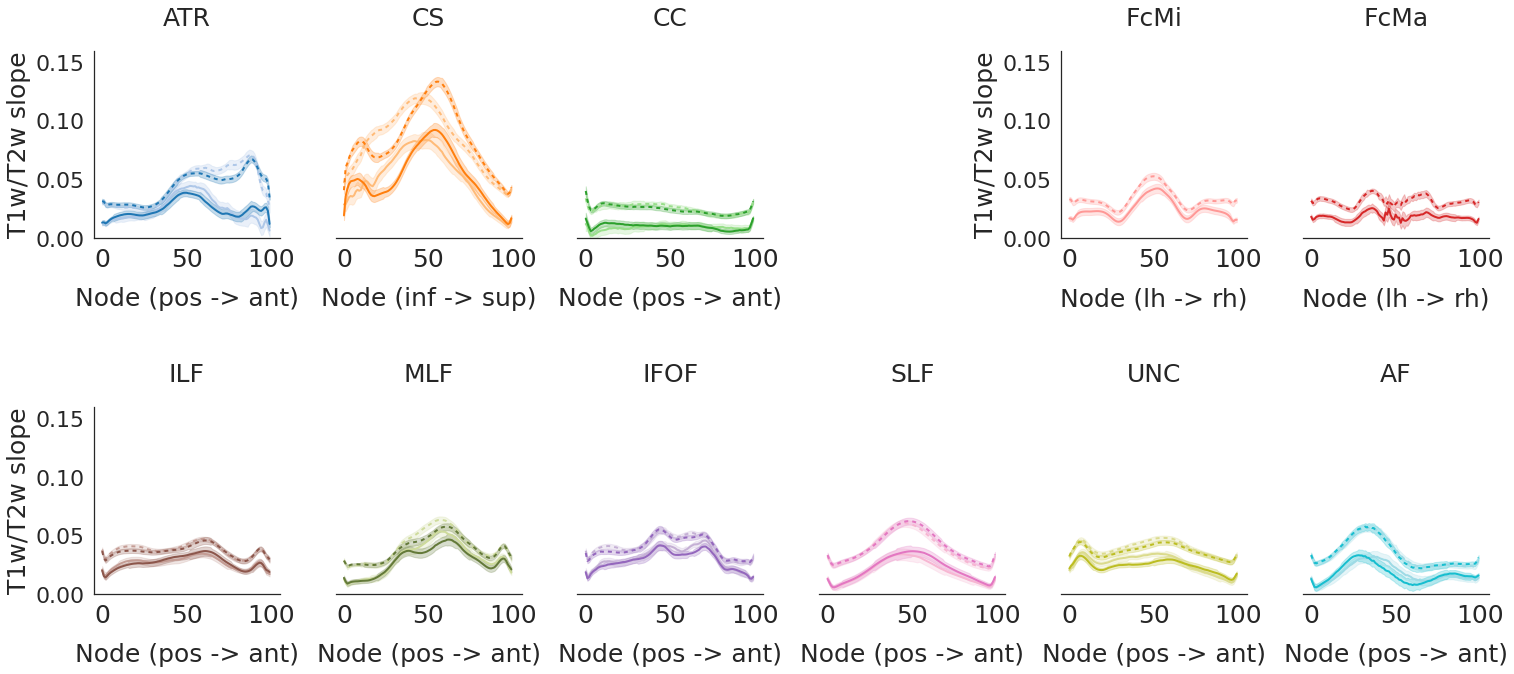

In [10]:
#this creates fig 2 of the main manuscript
df=pd.read_csv('./outputData/LM_result_inUtero_exUtero_noNorm.csv');

coeffType1=df[df['coeffType']==1];
coeffType2=df[df['coeffType']==2];


fig, axes = plt.subplots(2,6,frameon=False,figsize=(25,10));
fig.tight_layout;
fig.subplots_adjust(wspace=0.3, hspace=0.9);

ct = 0;
for tractName in tractCount:
    
    ax=axes[tractPos[tracts[ct]]];    
    currentTract=df.query("tract == @tractName");
    coeffType1CurrentTract=coeffType1.query('tract == @tractName');
    coeffType2CurrentTract=coeffType2.query('tract == @tractName');
    
    sns.set(font_scale = 2);
    sns.set_style('white');
    fig1 = sns.lineplot(data=coeffType1CurrentTract, x='node', y='coeff', hue='coeffType',legend=False, dashes=[(2,2)], style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=2); #I have changed the palette colour from 'crest' to 'Blues' as my computer didn't recognise that colour
    fig1 = sns.lineplot(data=coeffType2CurrentTract, x='node', y='coeff', hue='coeffType' ,legend=False, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=2);
    fig1 = ax.fill_between(coeffType1CurrentTract["node"], coeffType1CurrentTract['coeff']-coeffType1CurrentTract['se'],coeffType1CurrentTract['coeff']+coeffType1CurrentTract['se'],color=[color_list_all[color_order[ct]]],alpha=0.25);
    fig1 = ax.fill_between(coeffType2CurrentTract["node"], coeffType2CurrentTract['coeff']-coeffType2CurrentTract['se'], coeffType2CurrentTract['coeff']+coeffType2CurrentTract['se'], color=[color_list_all[color_order[ct]]],alpha=0.25); 

    _= ax.set_title(tracts[ct], pad=25, fontsize=25);
    _ = ax.set_xlabel(x_labels[ct], labelpad = 15, fontsize=25);
    _=ax.set_ylim([0,0.16])
    _=ax.hlines(y=0, xmin=0, xmax=100, linewidth=1, color='black',linestyle='dashed')
    
    if ct==2 or ct==3 or ct==12 or ct==13 or ct==8:
        _=ax.set_ylabel("T1w/T2w slope",fontsize=25);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,-1.0,-0.5,0.0])
        #ax.set_yticklabels([-1.5,-1.0,-0.5,0.0],Fontsize=25)
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['top'].set_visible(False);
        _=line1=Line2D([],[],color=color_list_all[ct],linestyle='dashed');
        _=line2=Line2D([],[],color=color_list_all[ct],linestyle='-');
        
    else:
        _=ax.set_ylabel('',fontsize=14);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,0.0])
        _=ax.yaxis.set_visible(False);
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['left'].set_visible(False);
        _=ax.spines['top'].set_visible(False);

    ct = ct + 1;
    
axes[0, 3].axis("off")
sns.set_style('white');
plt.show();
fig.savefig('./figures/fig2_compareCoeffs.png', dpi=600)



34.34033613444103

(68000, 25)

40.92016806722025

(68000, 25)

40.92016806721737

(68000, 25)

<bound method Figure.tight_layout of <Figure size 1800x720 with 12 Axes>>

(0.0, 1.0, 0.0, 1.0)

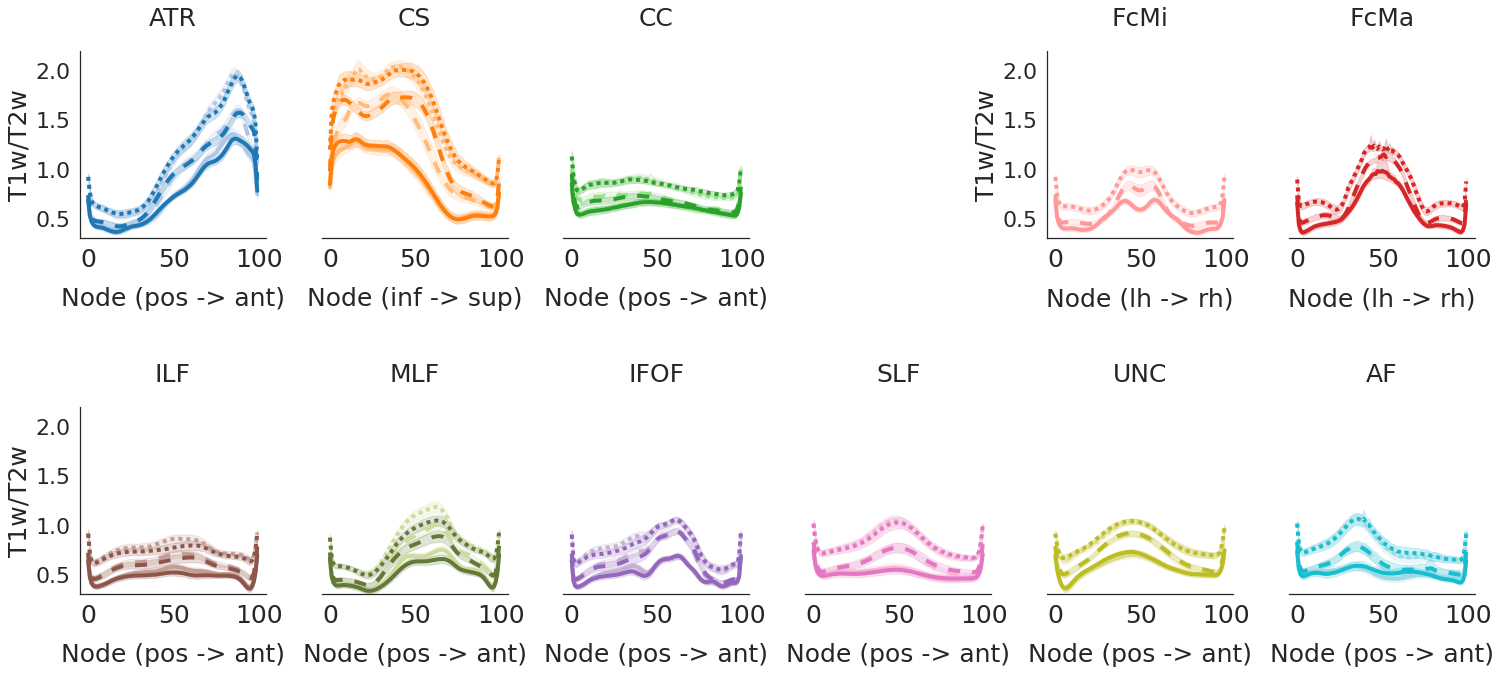

In [11]:
#This generates Fig 3 in the main manuscript
#sort matched data into gropus and plot developement
#group 1: preterm babies scaned at birth
#gruop 2: preterm babies scanned full-term
#group 3: full-term babies matched to preterm babies scanned full-term

age0=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==1]
age0['scan_age'].mean()
age0.shape
age1=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==2]
age1['scan_age'].mean()
age1.shape
age2=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==3]
age2['scan_age'].mean()
age2.shape

sns.set(font_scale = 2)
sns.set_style('white');
matchedData=allDataMergedCleaned[allDataMergedCleaned['matched_groups']>0]

df= matchedData;

fig, axes = plt.subplots(2,6,frameon=False,figsize=(25,10));
fig.tight_layout;
fig.subplots_adjust(wspace=0.3, hspace=0.9);
sns.set(font_scale = 2);

ct = 0;
for tractName in tractCount:
    
    ax=axes[tractPos[tracts[ct]]];    
    currentTract=df.query("tractID == @tractName");
    sns.set_style('white');
    
    group=1
    currentGroup=currentTract.query("matched_groups == @group");
    fig1=sns.lineplot(data=currentGroup, x='nodeID', y='t1wt2w',hue='matched_groups',legend=False, style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4)
    group=2
    currentGroup=currentTract.query("matched_groups == @group");
    fig1=sns.lineplot(data=currentGroup, x='nodeID', y='t1wt2w',hue='matched_groups',legend=False, dashes=[(3,3)], style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4)
    group=3
    currentGroup=currentTract.query("matched_groups == @group");
    fig1=sns.lineplot(data=currentGroup, x='nodeID', y='t1wt2w',hue='matched_groups',legend=False, dashes=[(1,1)], style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4)
    
    _= ax.set_title(tracts[ct], pad=25, fontsize=25);
    _ = ax.set_xlabel(x_labels[ct], labelpad = 15, fontsize=25);
    _=ax.set_ylim([0.3,2.2])
    
    if ct==2 or ct==3 or ct==12 or ct==13 or ct==8:
        _=ax.set_ylabel("T1w/T2w",fontsize=25);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,-1.0,-0.5,0.0])
        #ax.set_yticklabels([-1.5,-1.0,-0.5,0.0],Fontsize=25)
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['top'].set_visible(False);
        _=line1=Line2D([],[],color=color_list_all[ct],linestyle='dashed');
        _=line2=Line2D([],[],color=color_list_all[ct],linestyle='-');
        #ax.legend([line1,line2],['BB','AB'],loc="upper left",borderpad=0.01,bbox_to_anchor=(0.15,0.2),ncol=2,framealpha=0.75,frameon=True,edgecolor=[1,1,1],prop={'size':20},fancybox=True,handlelength=1.5)
        
    else:
        _=ax.set_ylabel('',fontsize=14);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,0.0])
        _=ax.yaxis.set_visible(False);
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['left'].set_visible(False);
        _=ax.spines['top'].set_visible(False);

    ct = ct + 1;
    
sns.set_style('white');
axes[0, 3].axis("off");
plt.show();
fig.savefig('./figures/fig3_premi_protracted_developement_t1wt2w.png', dpi=600)

In [12]:
#predict t1w/t2w in preterm from scanAge model 

dfLM=pd.read_csv('./outputData/LM_result_scanAge_noNorm.csv');
allDataCleanedNoLongi=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==0]
groupsMergedCleanedPTSL=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==2]
tractCount=allDataCleanedNoLongi['tractID'].unique()
tractCount.shape

coeffType1=dfLM[dfLM['coeffType']==3];

dfLM.head(20)
groupsMergedCleanedPTSL.head()
t1wt2wPredicted=[]
t1wt2wMeassured=[]
t1wt2wPred=[]
tractCount=groupsMergedCleanedPTSL['tractID'].unique()
tractCount.shape

print(tractCount)
nodeCount=groupsMergedCleanedPTSL['nodeID'].unique()
nodeCount.shape
print(nodeCount)
subjectsCount=groupsMergedCleanedPTSL['subjectID'].unique()
subjectsCount.shape
print(subjectsCount)

for subject in subjectsCount:

    for tract in tractCount:
        
        for node in nodeCount:
            
            groupsMergedCleanedPTSLForStats=groupsMergedCleanedPTSL[(groupsMergedCleanedPTSL['subjectID']==subject) & (groupsMergedCleanedPTSL['tractID']==tract) & (groupsMergedCleanedPTSL['nodeID']==node)]
            groupsMergedCleanedPTSLForStats.reset_index(level=0, inplace=True)
            #print(groupsMergedCleanedPTSLForStats['R1'])
            
            coeffType1ForStats=coeffType1[(coeffType1['tract']==tract) & (coeffType1['node']==node)]
            coeffType1ForStats.reset_index(level=0, inplace=True)

            t1wt2wPred=groupsMergedCleanedPTSLForStats['scan_age']*coeffType1ForStats['coeff'] + coeffType1ForStats['intercept']
            t1wt2wPredicted.append(t1wt2wPred)

df=pd.DataFrame(t1wt2wPredicted)
df.columns=['t1wt2wPredictedScanAge']

df.to_csv('./outputData/groupsMergedCleanedPTSL_predicted_t1wt2w_scanAge.csv')



(20,)

,Unnamed: 0,tract,node,coeffType,coeff,se,intercept,r2,adjustR2,aic,pvals
0,0,ARC_R,0,3,0.031287,0.002,-0.290048,0.476,0.474,-601.0,9.650000e-44
1,1,ARC_R,1,3,0.027750,0.002,-0.346934,0.386,0.384,-562.6,1.900000e-33
2,2,ARC_R,2,3,0.024947,0.002,-0.307168,0.318,0.316,-537.2,1.260000e-26
3,3,ARC_R,3,3,0.024405,0.002,-0.302087,0.305,0.302,-531.2,2.510000e-25
4,4,ARC_R,4,3,0.024947,0.002,-0.320010,0.310,0.308,-525.4,8.090000e-26
5,5,ARC_R,5,3,0.025479,0.002,-0.332123,0.316,0.314,-521.3,2.120000e-26
6,6,ARC_R,6,3,0.025819,0.002,-0.336939,0.320,0.318,-519.1,8.470000e-27
7,7,ARC_R,7,3,0.026333,0.002,-0.349568,0.329,0.327,-519.6,1.140000e-27
8,8,ARC_R,8,3,0.027089,0.002,-0.372948,0.339,0.337,-516.0,1.220000e-28
9,9,ARC_R,9,3,0.027881,0.002,-0.398759,0.349,0.347,-511.9,1.250000e-29


,t1wt2w,tractID,nodeID,subjectID,sessionID,dti_fa,dti_md,dki_fa,dki_md,dki_mk,...,scan_age,scan_head_circumference,scan_number,radiology_score,sedation,isLongi,timeAfterBirth,matched,matched_groups,dti_md_x100
4000,0.767970,ARC_R,0,CC00576XX16,178200,0.138844,0.001225,0.156317,0.001279,0.206877,...,42.142857,33.0,2,2,0,1,13.285714,1,2,0.122485
4001,0.605442,ARC_R,1,CC00576XX16,178200,0.143392,0.001288,0.161182,0.001345,0.205552,...,42.142857,33.0,2,2,0,1,13.285714,1,2,0.128817
4002,0.542237,ARC_R,2,CC00576XX16,178200,0.146799,0.001351,0.164202,0.001413,0.210849,...,42.142857,33.0,2,2,0,1,13.285714,1,2,0.135131
4003,0.524649,ARC_R,3,CC00576XX16,178200,0.150547,0.001392,0.168221,0.001457,0.211458,...,42.142857,33.0,2,2,0,1,13.285714,1,2,0.139219
4004,0.518655,ARC_R,4,CC00576XX16,178200,0.153781,0.001414,0.171617,0.001481,0.210375,...,42.142857,33.0,2,2,0,1,13.285714,1,2,0.141428


(20,)

['ARC_R' 'ARC_L' 'ATR_R' 'ATR_L' 'CGC_R' 'CGC_L' 'CST_R' 'CST_L' 'FA' 'FP'
 'IFO_R' 'IFO_L' 'ILF_R' 'ILF_L' 'MdLF_R' 'MdLF_L' 'SLF_R' 'SLF_L' 'UNC_R'
 'UNC_L']


(100,)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


(34,)

['CC00576XX16' 'CC00672BN13' 'CC00723XX14' 'CC00135AN12' 'CC00845BN21'
 'CC00621XX11' 'CC00518XX15' 'CC00686XX19' 'CC00305XX08' 'CC00525XX14'
 'CC00284BN13' 'CC00301XX04' 'CC00326XX13' 'CC00829XX21' 'CC00406XX10'
 'CC00489XX20' 'CC00657XX14' 'CC00245AN15' 'CC00845AN21' 'CC00648XX22'
 'CC00517XX14' 'CC00838XX22' 'CC00688XX21' 'CC00284AN13' 'CC00797XX23'
 'CC00418AN14' 'CC00628XX18' 'CC00689XX22' 'CC00385XX15' 'CC00361XX07'
 'CC00770XX12' 'CC00395XX17' 'CC00617XX15' 'CC00191XX11']


In [13]:
#predict t1wt2w in preterm from inUtero exUTero model 

dfLM=pd.read_csv('./outputData/LM_result_inUtero_exUtero_noNorm.csv')
groupsMergedCleanedPTSL=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==2]

coeffType1=dfLM[dfLM['coeffType']==1];
coeffType2=dfLM[dfLM['coeffType']==2];
dfLM.head(20)
groupsMergedCleanedPTSL.head()
t1wt2wPredicted=[]
t1wt2wPred=[]
t1wt2wMeassured=[]
tractCount=groupsMergedCleanedPTSL['tractID'].unique()
tractCount.shape
print(tractCount)

nodeCount=groupsMergedCleanedPTSL['nodeID'].unique()
nodeCount.shape
print(nodeCount)

subjectsCount=groupsMergedCleanedPTSL['subjectID'].unique()
subjectsCount.shape
print(subjectsCount)

for subject in subjectsCount:

    for tract in tractCount:
        
        for node in nodeCount:
            
            groupsMergedCleanedPTSLForStats=groupsMergedCleanedPTSL[(groupsMergedCleanedPTSL['subjectID']==subject) & (groupsMergedCleanedPTSL['tractID']==tract) & (groupsMergedCleanedPTSL['nodeID']==node)]
            groupsMergedCleanedPTSLForStats.reset_index(level=0, inplace=True)
            
            coeffType1ForStats=coeffType1[(coeffType1['tract']==tract) & (coeffType1['node']==node)]
            coeffType1ForStats.reset_index(level=0, inplace=True)
            
            coeffType2ForStats=coeffType2[(coeffType2['tract']==tract) & (coeffType2['node']==node)]
            coeffType2ForStats.reset_index(level=0, inplace=True)
            
            t1wt2wPred=groupsMergedCleanedPTSLForStats['birth_age']*coeffType1ForStats['coeff'] + groupsMergedCleanedPTSLForStats['timeAfterBirth']*coeffType2ForStats['coeff'] + coeffType2ForStats['intercept']
            t1wt2wPredicted.append(t1wt2wPred)
             
df=pd.DataFrame(t1wt2wPredicted)
df.columns=['t1wt2wPredictedexUT']
df.shape
df.head
df.tail

df.to_csv('./outputData/groupsMergedCleanedPTSL_predicted_t1wt2w_exUT.csv')



,Unnamed: 0,tract,node,coeffType,coeff,se,intercept,r2,adjustR2,aic,pvals
0,0,ARC_R,0,1,0.032808,0.002,-0.320761,0.621,0.618,-696.0,2.790000e-63
1,1,ARC_R,0,2,0.014091,0.002,-0.320761,0.621,0.618,-696.0,2.790000e-63
2,2,ARC_R,1,1,0.029319,0.002,-0.378621,0.545,0.542,-650.5,1.580000e-51
3,3,ARC_R,1,2,0.010009,0.002,-0.378621,0.545,0.542,-650.5,1.580000e-51
4,4,ARC_R,2,1,0.026562,0.002,-0.339786,0.490,0.487,-622.3,3.580000e-44
5,5,ARC_R,2,2,0.006685,0.003,-0.339786,0.490,0.487,-622.3,3.580000e-44
6,6,ARC_R,3,1,0.026054,0.002,-0.335389,0.484,0.480,-618.4,2.330000e-43
7,7,ARC_R,3,2,0.005761,0.003,-0.335389,0.484,0.480,-618.4,2.330000e-43
8,8,ARC_R,4,1,0.026601,0.002,-0.353420,0.485,0.482,-611.3,1.470000e-43
9,9,ARC_R,4,2,0.006242,0.003,-0.353420,0.485,0.482,-611.3,1.470000e-43


,t1wt2w,tractID,nodeID,subjectID,sessionID,dti_fa,dti_md,dki_fa,dki_md,dki_mk,...,scan_age,scan_head_circumference,scan_number,radiology_score,sedation,isLongi,timeAfterBirth,matched,matched_groups,dti_md_x100
4000,0.767970,ARC_R,0,CC00576XX16,178200,0.138844,0.001225,0.156317,0.001279,0.206877,...,42.142857,33.0,2,2,0,1,13.285714,1,2,0.122485
4001,0.605442,ARC_R,1,CC00576XX16,178200,0.143392,0.001288,0.161182,0.001345,0.205552,...,42.142857,33.0,2,2,0,1,13.285714,1,2,0.128817
4002,0.542237,ARC_R,2,CC00576XX16,178200,0.146799,0.001351,0.164202,0.001413,0.210849,...,42.142857,33.0,2,2,0,1,13.285714,1,2,0.135131
4003,0.524649,ARC_R,3,CC00576XX16,178200,0.150547,0.001392,0.168221,0.001457,0.211458,...,42.142857,33.0,2,2,0,1,13.285714,1,2,0.139219
4004,0.518655,ARC_R,4,CC00576XX16,178200,0.153781,0.001414,0.171617,0.001481,0.210375,...,42.142857,33.0,2,2,0,1,13.285714,1,2,0.141428


(20,)

['ARC_R' 'ARC_L' 'ATR_R' 'ATR_L' 'CGC_R' 'CGC_L' 'CST_R' 'CST_L' 'FA' 'FP'
 'IFO_R' 'IFO_L' 'ILF_R' 'ILF_L' 'MdLF_R' 'MdLF_L' 'SLF_R' 'SLF_L' 'UNC_R'
 'UNC_L']


(100,)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


(34,)

['CC00576XX16' 'CC00672BN13' 'CC00723XX14' 'CC00135AN12' 'CC00845BN21'
 'CC00621XX11' 'CC00518XX15' 'CC00686XX19' 'CC00305XX08' 'CC00525XX14'
 'CC00284BN13' 'CC00301XX04' 'CC00326XX13' 'CC00829XX21' 'CC00406XX10'
 'CC00489XX20' 'CC00657XX14' 'CC00245AN15' 'CC00845AN21' 'CC00648XX22'
 'CC00517XX14' 'CC00838XX22' 'CC00688XX21' 'CC00284AN13' 'CC00797XX23'
 'CC00418AN14' 'CC00628XX18' 'CC00689XX22' 'CC00385XX15' 'CC00361XX07'
 'CC00770XX12' 'CC00395XX17' 'CC00617XX15' 'CC00191XX11']


(68000, 1)

<bound method NDFrame.head of        t1wt2wPredictedexUT
0                 0.813185
1                 0.600416
2                 0.515534
3                 0.492988
4                 0.497155
...                    ...
67995             0.574779
67996             0.589025
67997             0.625102
67998             0.701261
67999             0.845634

[68000 rows x 1 columns]>

<bound method NDFrame.tail of        t1wt2wPredictedexUT
0                 0.813185
1                 0.600416
2                 0.515534
3                 0.492988
4                 0.497155
...                    ...
67995             0.574779
67996             0.589025
67997             0.625102
67998             0.701261
67999             0.845634

[68000 rows x 1 columns]>

,tractID,nodeID,t1wt2w,sessionID,dti_fa,dti_md,dki_fa,dki_md,dki_mk,birth_age,...,sedation,isLongi,timeAfterBirth,matched,matched_groups,dti_md_x100,Unnamed: 0,t1wt2wPredictedScanAge,Unnamed: 0,t1wt2wPredictedexUT
0,ARC_L,0,0.832767,130507.411765,0.134282,0.001240,0.143879,0.001304,0.227275,31.966387,...,0.0,1.0,8.953782,1.0,2.0,0.123958,33100.0,0.986903,33100.0,0.837507
1,ARC_L,1,0.634061,130507.411765,0.139074,0.001309,0.149109,0.001374,0.219217,31.966387,...,0.0,1.0,8.953782,1.0,2.0,0.130860,33101.0,0.784048,33101.0,0.636392
2,ARC_L,2,0.553715,130507.411765,0.146257,0.001373,0.156263,0.001441,0.214762,31.966387,...,0.0,1.0,8.953782,1.0,2.0,0.137287,33102.0,0.704594,33102.0,0.554934
3,ARC_L,3,0.531195,130507.411765,0.155127,0.001409,0.165047,0.001479,0.209282,31.966387,...,0.0,1.0,8.953782,1.0,2.0,0.140940,33103.0,0.685296,33103.0,0.536007
4,ARC_L,4,0.530874,130507.411765,0.164797,0.001421,0.174727,0.001489,0.202547,31.966387,...,0.0,1.0,8.953782,1.0,2.0,0.142094,33104.0,0.686833,33104.0,0.540105


<bound method Figure.tight_layout of <Figure size 1800x720 with 12 Axes>>

(0.0, 1.0, 0.0, 1.0)

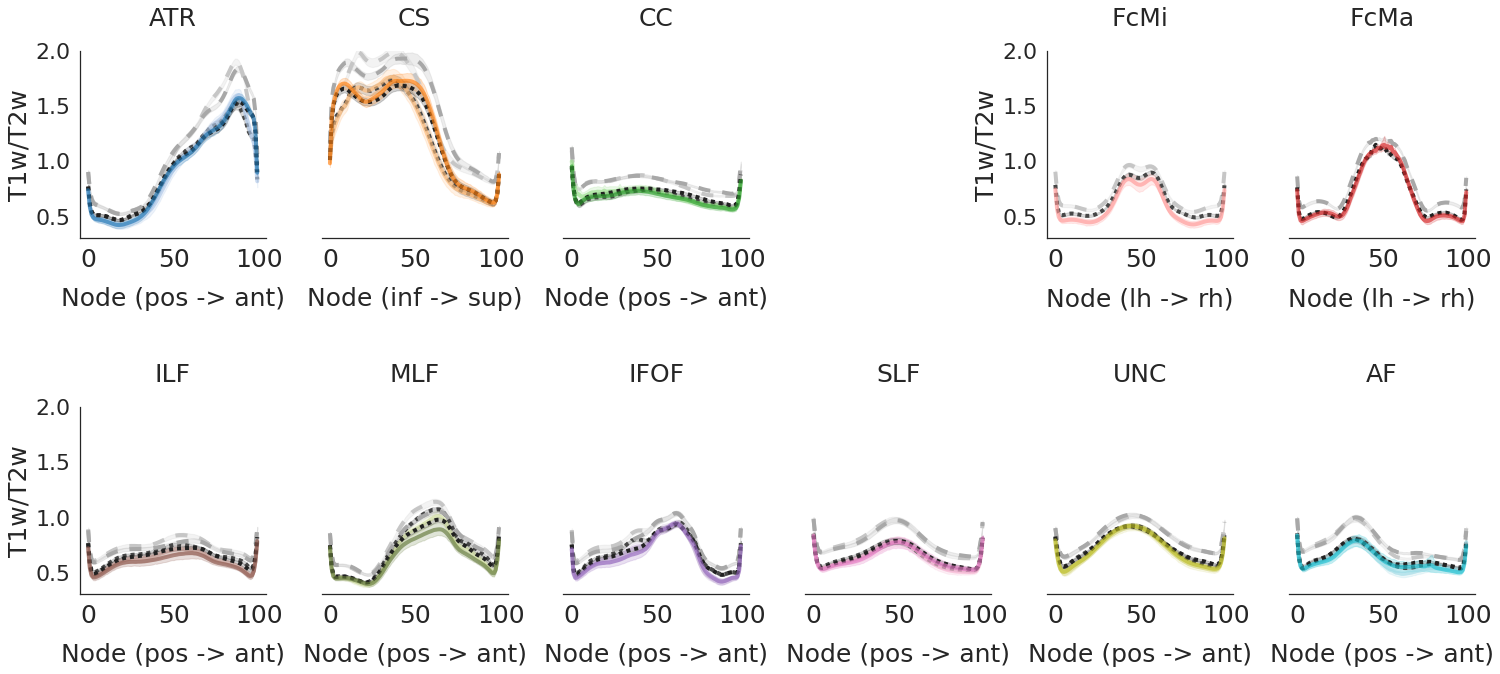

In [14]:
#this produces fig 4a in the main manuscipt
dfPTSL=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==2]
dfPTSL.reset_index(drop=True,inplace=True)
dfPredscanAge=pd.read_csv('./outputData/groupsMergedCleanedPTSL_predicted_t1wt2w_scanAge.csv');
dfPredexUT=pd.read_csv('./outputData/groupsMergedCleanedPTSL_predicted_t1wt2w_exUT.csv');

dfIn=pd.concat([dfPTSL,dfPredscanAge,dfPredexUT],axis=1)

dfMerged=dfIn.groupby(["tractID","nodeID"], as_index=False).mean()
dfMerged.head()

df= dfIn;


fig, axes = plt.subplots(2,6,frameon=False,figsize=(25,10));
fig.tight_layout;
fig.subplots_adjust(wspace=0.3, hspace=0.9);
sns.set(font_scale = 2);
sns.set_style('white');

ct = 0;
for tractName in tractCount:
    ax=axes[tractPos[tracts[ct]]];
    _=ax.set_ylim([0.3,2])
    currentTract=df.query("tractID == @tractName");
    sns.set_style('white');
    grey_colors=sns.color_palette("Greys", 8)
    
    if (ct % 2) == 0: 
        fig1=sns.lineplot(data=currentTract, x='nodeID', y='t1wt2wPredictedScanAge',hue=1, legend=False, dashes=[(3,3)], style=True, ax=ax, palette=[grey_colors[2]], linewidth=4)
        fig1=sns.lineplot(data=currentTract, x='nodeID', y='t1wt2wPredictedexUT',hue=1, legend=False, dashes=[(1,1)], style=True, ax=ax, palette=[grey_colors[6]], linewidth=4)
    else:
        fig1=sns.lineplot(data=currentTract, x='nodeID', y='t1wt2wPredictedScanAge',hue=1, legend=False, dashes=[(3,3)], style=True, ax=ax, palette=[grey_colors[3]], linewidth=4)
        fig1=sns.lineplot(data=currentTract, x='nodeID', y='t1wt2wPredictedexUT',hue=1, legend=False, dashes=[(1,1)], style=True, ax=ax, palette=[grey_colors[7]], linewidth=4)
    
    fig1=sns.lineplot(data=currentTract, x='nodeID', y='t1wt2w',legend=False, hue=1, style=True, ax=ax, palette=[color_list_all[color_order[ct]]], linewidth=4,alpha=0.65)
    
    _= ax.set_title(tracts[ct], pad=25, fontsize=25);
    _ = ax.set_xlabel(x_labels[ct], labelpad = 15, fontsize=25);
    
    if ct==2 or ct==3 or ct==12 or ct==13 or ct==8:
        _=ax.set_ylabel("T1w/T2w",fontsize=25);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,-1.0,-0.5,0.0])
        #ax.set_yticklabels([-1.5,-1.0,-0.5,0.0],Fontsize=25)
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['top'].set_visible(False);
        _=line1=Line2D([],[],color=color_list_all[ct],linestyle='dashed');
        _=line2=Line2D([],[],color=color_list_all[ct],linestyle='-');
        #ax.legend([line1,line2],['BB','AB'],loc="upper left",borderpad=0.01,bbox_to_anchor=(0.15,0.2),ncol=2,framealpha=0.75,frameon=True,edgecolor=[1,1,1],prop={'size':20},fancybox=True,handlelength=1.5)
        
    else:
        _=ax.set_ylabel('',fontsize=14);
        _=ax.set_xticks([0,50,100]);
        _=ax.set_xticklabels([0,50,100],Fontsize=25);
        #ax.set_yticks([-1.5,0.0])
        _=ax.yaxis.set_visible(False);
        _=ax.spines['right'].set_visible(False);
        _=ax.spines['left'].set_visible(False);
        _=ax.spines['top'].set_visible(False);

    ct = ct + 1;
    
axes[0, 3].axis("off");
sns.set_style('white');
plt.show();
fig.savefig('figures/fig4a_predict_sampl2_from_sampl1.png', dpi=600)



0.6437339169870363

0.8724331324666588

MannwhitneyuResult(statistic=142.0, pvalue=4.6052517282977075e-08)

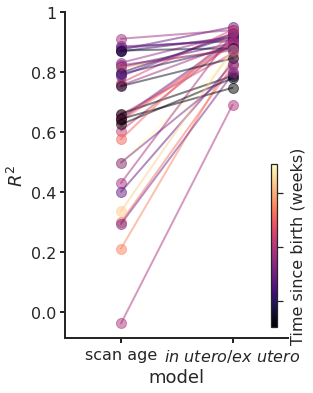

In [30]:
#this produces fig 4b in the main manuscipt
font = {'size'   : 12}
mpl.rc("font", **font)

fs = 16
dfPTSL=allDataMergedCleaned[allDataMergedCleaned['matched_groups']==2]
dfPTSL.reset_index(drop=True, inplace=True)
#dfPTSL.head()
dfPredscanAge=pd.read_csv('./outputData/groupsMergedCleanedPTSL_predicted_t1wt2w_scanAge.csv');
#dfPredscanAge.head()
dfPredexUT=pd.read_csv('./outputData/groupsMergedCleanedPTSL_predicted_t1wt2w_exUT.csv');
#dfPredexUT.head()
dfIn=pd.concat([dfPTSL,dfPredscanAge,dfPredexUT],axis=1)
#dfIn.head()
subjects = dfIn["subjectID"].unique()
#df=dfIn
r2_sa = []
r2_eu = []
ba = []
sa = []
for subject in subjects:
    subject_df = df[df["subjectID"] == subject][["t1wt2wPredictedScanAge", "t1wt2wPredictedexUT", "t1wt2w", "birth_age", "timeAfterBirth"]];
    r2_sa.append(r2_score(subject_df["t1wt2w"], subject_df["t1wt2wPredictedScanAge"]));
    r2_eu.append(r2_score(subject_df["t1wt2w"], subject_df["t1wt2wPredictedexUT"]));
    ba.append(subject_df["birth_age"].iloc[0]);
    sa.append(subject_df["timeAfterBirth"].iloc[0]);
norm_ba = ba - min(ba);
norm_ba = norm_ba / max(norm_ba);
norm_sa = sa - min(sa);
norm_sa = norm_sa / max(norm_sa);
#print(r2_sa);
#print(subject_df["t1wt2w"]);
#print(subject_df["t1wt2wPredictedScanAge"]);
fig, ax = plt.subplots();
for ii in range(len(subjects)):
    _=ax.plot([0, 1], [r2_sa[ii], r2_eu[ii]], 'ko-', alpha=0.5, color=cmap(norm_sa[ii]), linewidth=2, markersize=10);
_=ax.set_xticks([0, 1]);
_=ax.set_xlim([-0.5, 1.5]);
cbaxes = inset_axes(ax, width="3%", height="50%", loc=4);
cb = fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=min(sa)-1, vmax=max(sa)+1), cmap=cmap), ax=ax, cax=cbaxes);
_=cb.ax.set_ylabel("Time since birth (weeks)", fontsize=fs);
_=cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fs);
_=ax.tick_params(length=5, width=2, direction="out", reset=True);
_=ax.spines['top'].set_visible(False);
_=ax.spines['right'].set_visible(False);
ss = ax.spines['left'];
_=ss.set_linewidth(2);
ss = ax.spines['bottom'];
_=ss.set_linewidth(2);
_=ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]);
_=ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1],fontsize=fs);
_=ax.set_ylabel("$R^2$", fontsize=fs+2);
_=ax.set_xlabel("model", fontsize=fs+2);
#ax.spines[['right', 'top']].set_visible(False)
_=ax.get_xaxis().tick_bottom();
_=ax.get_yaxis().tick_left();
_=ax.set_xticklabels(["scan age", "$\it{in~utero}$/$\it{ex~utero}$"], fontsize=fs);
_=fig.set_size_inches([4, 6]);
np.mean(r2_sa)
np.mean(r2_eu)
mannwhitneyu(r2_sa, r2_eu)
fig.savefig('figures/fig4b_predict_sampl2_from_sampl1.png', dpi=600)
